Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

**Target = `price`**

# Environment Setup & Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from  catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time
import gc

## Data preparation

In [2]:
df = pd.read_csv("/datasets/car_data.csv")

In [3]:
# Inspect dataset
df1 = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

## Standardize Columns

In [4]:
df.columns = df.columns.str.lower()

<div class="alert alert-danger"; style="border-left: 7px solid red">
<b>⛔️ Reviewer's comment V2</b> 
    
Is there a reason we are randomly filling this with with `wrangler`?
</div>

<div class="alert alert-info"; style="border-left: 7px solid blue">
<b>Student’s Comment</b>: Yes, but this took me a while to do so, I can just redo, take out and/or alter some of the code where you commented by since I don't remember all my reasonings for everything. I jumped around a bit while creating this code; I know you can tell based on some of your comments. I'm taking out the wrangler filling, but I believe it was because of something in my code from way down. Whatever the reason, once I went through the code, a lot of it didn't seem to make sense when I went through it; so, alot of it has been deleted or altered. </div>
</div> 

### Details to Help with Data Cleaning

**General**
- 1769: Steam Wagon (Nicolas-Joseph Cugnot, France)	Steam-powered, heavy, experimental — not practical
- 1800s: Steam carriages - Small numbers in UK & France, for private roads
- 1830s–1890s: Electric vehicles - Short-range city vehicles, mostly experimental or low-volume
- The first gasoline car was made as early as 1885
- The first car to receive registration was on August 14th, 1893


**Automation of Vehicle History**
- 1904: Sturtevant Automatic Automobile
- 1939/1940: Cadillac & Oldsmobile w/ Hydra-Matic by General Motors
- 1941: Buick (military - WWII civilian car production halt (1942))
      - Chrysler Fluid Drive / Vacamatic / Prestomatic
- 1948: Buick Roadmaster / Dynaflow (1949)
- 1950: Powerglide by Chevrolet
- 1961: K4A Mercedes-Benz
    - most Cadillac, Oldsmobile, Buick, and Chrysler
 - 1962 - : Automatics rapidly expanded

**First Car by Model (Earliest Registration Year)**
- Rover: 1885
- Mercedes-Benz: 1886
- Peugeot: 1889
- Opel: 1899
- Renault: 1899
- Fiat: 1899
- Ford: 1903
- Škoda: 1905
- Lancia: 1906
- Daihatsu: 1907
- Suzuki: 1909
- Audi: 1910
- Alfa Romeo: 1910
- Chevrolet: 1911
- Mitsubishi: 1917
- Citroën: 1919
- Jaguar: 1922
- Chrysler: 1924
- Volvo: 1927
- BMW: 1928
- Mazda: 1931
- Porsche: 1931
- Nissan: 1933
- Toyota: 1936
- Volkswagen: 1937
- Jeep: 1941
- Kia: 1944
- Saab: 1947
- Honda: 1948
- Land Rover: 1948
- SEAT: 1950
- Subaru: 1954
- Trabant: 1957
- Mini: 1959
- Dacia: 1966
- Daewoo: 1967
- Hyundai: 1967
- Lada: 1970
- Smart: 1998
- Sonstige_autos: N/A (miscellaneous)


In [5]:
# Look at years before 1885 and after 2025
df[(df["registrationyear"] > 2025) | (df["registrationyear"] < 1885)]

datecrawled  price vehicletype  registrationyear gearbox  power  \
622     16/03/2016 16:55      0         NaN              1111     NaN      0   
12946   29/03/2016 18:39     49         NaN              5000     NaN      0   
15147   14/03/2016 00:52      0         NaN              9999     NaN      0   
15870   02/04/2016 11:55   1700         NaN              3200     NaN      0   
16062   29/03/2016 23:42    190         NaN              1000     NaN      0   
...                  ...    ...         ...               ...     ...    ...   
340548  02/04/2016 17:44      0         NaN              3500  manual     75   
340759  04/04/2016 23:55    700         NaN              1600  manual   1600   
341791  28/03/2016 17:37      1         NaN              3000     NaN      0   
348830  22/03/2016 00:38      1         NaN              1000     NaN   1000   
351682  12/03/2016 00:57  11500         NaN              1800     NaN     16   

         model  mileage  registrationmonth fueltype           brand  \
622        NaN     5000                  0      NaN            opel   
12946     golf     5000                 12      NaN      volkswagen   
15147      NaN    10000                  0      NaN  sonstige_autos   
15870      NaN     5000                  0      NaN  sonstige_autos   
16062   mondeo     5000                  0      NaN            ford   
...        ...      ...                ...      ...             ...   
340548     NaN     5000                  3   petrol  sonstige_autos   
340759      a3   150000                  4   petrol            audi   
341791  zafira     5000                  0      NaN            opel   
348830     NaN   150000                  0      NaN  sonstige_autos   
351682   other     5000                  6   petrol            fiat   

       notrepaired       datecreated  numberofpictures  postalcode  \
622            NaN  16/03/2016 00:00                 0       44628   
12946          NaN  29/03/2016 00:00                 0       74523   
15147          NaN  13/03/2016 00:00                 0       32689   
15870          NaN  02/04/2016 00:00                 0       33649   
16062          NaN  29/03/2016 00:00                 0       47166   
...            ...               ...               ...         ...   
340548         NaN  02/04/2016 00:00                 0       96465   
340759          no  04/04/2016 00:00                 0       86343   
341791         NaN  28/03/2016 00:00                 0       26624   
348830         NaN  21/03/2016 00:00                 0       41472   
351682         NaN  11/03/2016 00:00                 0       16515   

                lastseen  
622     20/03/2016 16:44  
12946   06/04/2016 04:16  
15147   21/03/2016 23:46  
15870   06/04/2016 09:46  
16062   06/04/2016 10:44  
...                  ...  
340548  04/04/2016 15:17  
340759  05/04/2016 06:44  
341791  02/04/2016 22:17  
348830  05/04/2016 14:18  
351682  05/04/2016 19:47  

[171 rows x 16 columns]

**First Car by Model (Earliest Registration Year)**
- Rover: 1885
- Mercedes-Benz: 1886
- Peugeot: 1889
- Opel: 1899
- Renault: 1899
- Fiat: 1899
- Ford: 1903
- Škoda: 1905
- Lancia: 1906
- Daihatsu: 1907
- Suzuki: 1909
- Audi: 1910
- Alfa Romeo: 1910
- Chevrolet: 1911
- Mitsubishi: 1917
- Citroën: 1919
- Jaguar: 1922
- Chrysler: 1924
- Volvo: 1927
- BMW: 1928
- Mazda: 1931
- Porsche: 1931
- Nissan: 1933
- Toyota: 1936
- Volkswagen: 1937
- Jeep: 1941
- Kia: 1944
- Saab: 1947
- Honda: 1948
- Land Rover: 1948
- SEAT: 1950
- Subaru: 1954
- Trabant: 1957
- Mini: 1959
- Dacia: 1966
- Daewoo: 1967
- Hyundai: 1967
- Lada: 1970
- Smart: 1998
- Sonstige_autos: N/A (miscellaneous)

**Brands that do not have registration dates before earliest record**
- Lada
- Daewoo
- Dacia
- Mini
- SEAT
- Land Rover
- Honda
- Saab
- Kia
- Nissan
- Porsche
- Mazda
- Jaguar
- Chrysler
- Volvo
- Rover
- Mercedes-Benz
- Peugeot
- Opel
- Renault
- Fiat
- Ford
- Škoda
- Lancia
- Daihatsu
- Suzuki
- Audi
- Alfa Romeo
- Chevrolet

In [6]:
# Look at smart cars registered before 1998
df[(df['brand'] == 'smart') & (df['registrationyear'] < 1998)]

smartnan = (df['brand'] == 'smart') & (df['registrationyear'] < 1998) & (df['model'].isna())

df.loc[smartnan,['registrationyear']] = np.nan

# Hyundai before 1967 implausible
hyundai = (df['brand'] == 'hyundai') & (df['registrationyear'] < 1967) & (df['model'].isna())
df.loc[hyundai, ['registrationyear']] = np.nan


remaining = ['smart', 'hyundai', 'mitsubishi', 'citroen', 'bmw', 'toyota', 'volkswagen', 'jeep', 'subaru', 'trabant']
earliest_years = {'smart': 1998, 'hyundai': 1967,'mitsubishi': 1917, 'citroen': 1919, 'bmw': 1928, 'toyota': 1936, 
                  'volkswagen': 1937, 'jeep': 1941, 'subaru': 1954, 'trabant': 1957}

for brands in remaining:
    df.loc[(df['brand'] == brands) & (df['registrationyear'] < earliest_years[brands]) & 
        df['model'].isna(), ['registrationyear']] = np.nan
    display(df[(df['brand'] == brands) & (df['registrationyear'] < earliest_years[brands])])

# Kaefer's is the german name for beetle - they are the same car
beetle = df['model'] == 'kaefer'
df.loc[beetle, ['model']] = 'beetle'

del smartnan,hyundai,beetle
gc.collect()

datecrawled  price vehicletype  registrationyear gearbox  power  \
31212   12/03/2016 16:45    700       small            1997.0     NaN      0   
161667  04/04/2016 20:56   1650       small            1992.0    auto     55   
319739  05/04/2016 20:36   1650       small            1992.0     NaN      0   

          model  mileage  registrationmonth fueltype  brand notrepaired  \
31212   forfour     5000                  3   petrol  smart         NaN   
161667   fortwo   100000                  7   petrol  smart          no   
319739   fortwo   100000                  6      NaN  smart         yes   

             datecreated  numberofpictures  postalcode          lastseen  
31212   12/03/2016 00:00                 0       88416  07/04/2016 06:17  
161667  04/04/2016 00:00                 0       28327  06/04/2016 23:44  
319739  05/04/2016 00:00                 0       28327  05/04/2016 20:36

datecrawled  price vehicletype  registrationyear gearbox  power  \
244840  09/03/2016 17:50      0         NaN            1910.0     NaN      0   

        model  mileage  registrationmonth fueltype    brand notrepaired  \
244840  other     5000                  0      NaN  hyundai         NaN   

             datecreated  numberofpictures  postalcode          lastseen  
244840  09/03/2016 00:00                 0       59510  07/04/2016 10:44

datecrawled  price vehicletype  registrationyear gearbox  power  \
154559  03/04/2016 12:40      0       small            1910.0  manual      0   

       model  mileage  registrationmonth fueltype       brand notrepaired  \
154559  colt   150000                  0   petrol  mitsubishi         NaN   

             datecreated  numberofpictures  postalcode          lastseen  
154559  03/04/2016 00:00                 0       46397  07/04/2016 14:57

datecrawled  price vehicletype  registrationyear gearbox  power  \
125577  15/03/2016 18:38   7750         NaN            1001.0     NaN      0   
270911  23/03/2016 11:48      0       other            1910.0  manual      0   

        model  mileage  registrationmonth fueltype    brand notrepaired  \
125577  other     5000                  0      NaN  citroen         NaN   
270911  other     5000                  0   petrol  citroen          no   

             datecreated  numberofpictures  postalcode          lastseen  
125577  15/03/2016 00:00                 0       66706  06/04/2016 18:47  
270911  23/03/2016 00:00                 0       98630  23/03/2016 11:48

datecrawled  price vehicletype  registrationyear gearbox  power  \
58883   15/03/2016 21:57      1         NaN            1910.0     NaN      0   
119442  18/03/2016 10:37      1         NaN            1000.0     NaN   1000   
203230  01/04/2016 15:37    400         NaN            1910.0  manual    170   
213499  08/03/2016 12:06    380         NaN            1000.0     NaN      0   
287304  09/03/2016 15:54    500         NaN            1602.0  manual      0   

        model  mileage  registrationmonth fueltype brand notrepaired  \
58883     3er   150000                  0      NaN   bmw         NaN   
119442    3er     5000                  0      NaN   bmw         NaN   
203230    3er     5000                  0      NaN   bmw         NaN   
213499    6er     5000                  0      NaN   bmw         NaN   
287304  other     5000                  0      NaN   bmw         yes   

             datecreated  numberofpictures  postalcode          lastseen  
58883   15/03/2016 00:00                 0       74074  07/04/2016 07:17  
119442  18/03/2016 00:00                 0       94086  05/04/2016 22:16  
203230  01/04/2016 00:00                 0       66333  03/04/2016 11:48  
213499  08/03/2016 00:00                 0       35102  06/04/2016 00:16  
287304  09/03/2016 00:00                 0       30900  10/03/2016 12:17

Empty DataFrame
Columns: [datecrawled, price, vehicletype, registrationyear, gearbox, power, model, mileage, registrationmonth, fueltype, brand, notrepaired, datecreated, numberofpictures, postalcode, lastseen]
Index: []

datecrawled  price vehicletype  registrationyear gearbox  power  \
23750   16/03/2016 19:58   3900       wagon            1910.0  manual     90   
35943   19/03/2016 10:57    200       other            1910.0     NaN      0   
40133   23/03/2016 18:00      0         NaN            1910.0     NaN      0   
53577   20/03/2016 11:44    330         NaN            1000.0     NaN      0   
56241   30/03/2016 18:54    950         NaN            1400.0  manual   1400   
62803   07/03/2016 22:58   3400       small            1910.0  manual     90   
71459   27/03/2016 23:46    500         NaN            1000.0     NaN      0   
74814   21/03/2016 12:52    400         NaN            1910.0     NaN     60   
143621  17/03/2016 23:40    550         NaN            1000.0     NaN   1000   
144388  09/03/2016 20:52     50         NaN            1910.0     NaN      0   
147663  03/04/2016 19:37      0         NaN            1910.0     NaN      0   
151280  05/04/2016 00:39    300         NaN            1910.0  manual      0   
164397  29/03/2016 17:49      0         NaN            1000.0     NaN      0   
174893  05/03/2016 19:48      0         NaN            1000.0     NaN   1000   
183727  03/04/2016 12:48      0         bus            1910.0     NaN      0   
189722  29/03/2016 16:56   1500         NaN            1000.0  manual      0   
203985  07/03/2016 14:53    222         NaN            1910.0  manual      0   
218241  16/03/2016 12:46   7999         NaN            1800.0     NaN    290   
256532  05/03/2016 17:44  12500         NaN            1000.0     NaN    200   
276318  31/03/2016 14:58    300         NaN            1910.0     NaN      0   
286928  18/03/2016 16:51      1         NaN            1000.0     NaN    174   
318111  25/03/2016 13:42      1         NaN            1910.0     NaN      0   
318501  02/04/2016 13:57      0         NaN            1910.0     NaN      0   

              model  mileage  registrationmonth  fueltype       brand  \
23750        passat   150000                  0    petrol  volkswagen   
35943         caddy   150000                  0  gasoline  volkswagen   
40133         other     5000                  0       NaN  volkswagen   
53577          polo     5000                  0       NaN  volkswagen   
56241          golf   125000                  4    petrol  volkswagen   
62803        beetle    90000                  4       NaN  volkswagen   
71459          golf     5000                  0       NaN  volkswagen   
74814          golf   150000                  0    petrol  volkswagen   
143621         golf     5000                  6    petrol  volkswagen   
144388       kaefer     5000                  0       NaN  volkswagen   
147663         polo     5000                  0       NaN  volkswagen   
151280         golf   150000                  0    petrol  volkswagen   
164397  transporter     5000                  1       NaN  volkswagen   
174893         golf     5000                  4    petrol  volkswagen   
183727  transporter     5000                  0       NaN  volkswagen   
189722       kaefer     5000                  0    petrol  volkswagen   
203985         golf     5000                  0    petrol  volkswagen   
218241         golf     5000                  6       NaN  volkswagen   
256532         golf     5000                  0       NaN  volkswagen   
276318         polo     5000                  0       NaN  volkswagen   
286928      touareg     5000                  3  gasoline  volkswagen   
318111         golf   125000                  0       NaN  volkswagen   
318501        caddy     5000                  0       NaN  volkswagen   

       notrepaired       datecreated  numberofpictures  postalcode  \
23750          NaN  16/03/2016 00:00                 0       88662   
35943          NaN  19/03/2016 00:00                 0       35096   
40133          NaN  23/03/2016 00:00                 0       85045   
53577          NaN  20/03/2016 00:00                 0     

Empty DataFrame
Columns: [datecrawled, price, vehicletype, registrationyear, gearbox, power, model, mileage, registrationmonth, fueltype, brand, notrepaired, datecreated, numberofpictures, postalcode, lastseen]
Index: []

datecrawled  price vehicletype  registrationyear gearbox  power  \
18224  09/03/2016 17:49   7999         NaN            1500.0  manual    224   

         model  mileage  registrationmonth fueltype   brand notrepaired  \
18224  impreza     5000                  3      NaN  subaru         NaN   

            datecreated  numberofpictures  postalcode          lastseen  
18224  09/03/2016 00:00                 0       53577  15/03/2016 05:15

datecrawled  price vehicletype  registrationyear gearbox  power  \
199563  09/03/2016 20:37     60       wagon            1956.0     NaN      0   
294028  28/03/2016 23:45      0         NaN            1111.0     NaN      0   

        model  mileage  registrationmonth fueltype    brand notrepaired  \
199563  other   150000                  0      NaN  trabant         NaN   
294028    601     5000                  0      NaN  trabant         NaN   

             datecreated  numberofpictures  postalcode          lastseen  
199563  09/03/2016 00:00                 0       16775  05/04/2016 16:45  
294028  28/03/2016 00:00                 0        6712  30/03/2016 16:45

4

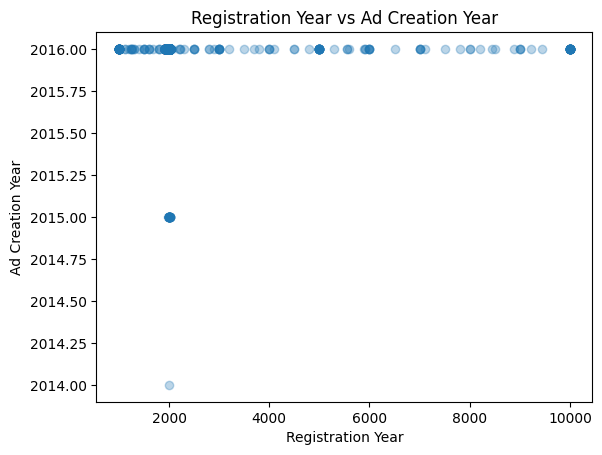

In [7]:
df['datecreated'] = pd.to_datetime(df['datecreated'])


# Cars shouldn't be registered after datecreated

plt.scatter(df['registrationyear'], df['datecreated'].dt.year, alpha=0.3)
plt.xlabel("Registration Year")
plt.ylabel("Ad Creation Year")
plt.title("Registration Year vs Ad Creation Year")
plt.show()

In [8]:
registration_years = {
    'fortwo': {'earliest': 1998, 'latest': 2016},
    'forfour': {'earliest': 2004, 'latest': 2016},
    'colt': {'earliest': 1962, 'latest': 2013},
    '3er': {'earliest': 1975, 'latest': 2016},
    '6er': {'earliest': 1976, 'latest': 2016},
    'caddy': {'earliest': 1980, 'latest': 2016},
    'polo': {'earliest': 1975, 'latest': 2016},
    'golf': {'earliest': 1974, 'latest': 2016},
    'beetle': {'earliest': 1938, 'latest': 2016},
    'transporter': {'earliest': 1950, 'latest': 2016},
    'touareg': {'earliest': 2002, 'latest': 2016},
    'impreza': {'earliest': 1992, 'latest': 2016},
    '601': {'earliest': 1964, 'latest': 1991},
    'corsa': {'earliest': 1982, 'latest': 2016},
    'astra': {'earliest': 1991, 'latest': 2016},
    'passat': {'earliest': 1973, 'latest': 2016},
    'a4': {'earliest': 1994, 'latest': 2016},
    'c_klasse': {'earliest': 1993, 'latest': 2016},
    '5er': {'earliest': 1972, 'latest': 2016},
    'e_klasse': {'earliest': 1993, 'latest': 2016},
    'a3': {'earliest': 1996, 'latest': 2016},
    'focus': {'earliest': 1998, 'latest': 2016},
    'fiesta': {'earliest': 1976, 'latest': 2016},
    'a6': {'earliest': 1994, 'latest': 2016},
    'twingo': {'earliest': 1993, 'latest': 2016},
    '2_reihe': {'earliest': 1982, 'latest': 2016},
    'vectra': {'earliest': 1988, 'latest': 2008},
    'a_klasse': {'earliest': 1997, 'latest': 2016},
    'mondeo': {'earliest': 1993, 'latest': 2016},
    'clio': {'earliest': 1991, 'latest': 2016},
    '1er': {'earliest': 2004, 'latest': 2016},
    '3_reihe': {'earliest': 1982, 'latest': 2016},
    'touran': {'earliest': 2003, 'latest': 2016},
    'punto': {'earliest': 1993, 'latest': 2016},
    'zafira': {'earliest': 1999, 'latest': 2016},
    'megane': {'earliest': 1995, 'latest': 2016},
    'ibiza': {'earliest': 1984, 'latest': 2016},
    'ka': {'earliest': 1996, 'latest': 2016},
    'lupo': {'earliest': 1998, 'latest': 2005},
    'octavia': {'earliest': 1996, 'latest': 2016},
    'fabia': {'earliest': 1999, 'latest': 2016},
    'cooper': {'earliest': 2001, 'latest': 2016},
    'clk': {'earliest': 1997, 'latest': 2010},
    'micra': {'earliest': 1982, 'latest': 2016},
    '80': {'earliest': 1972, 'latest': 1996},
    'x_reihe': {'earliest': 2000, 'latest': 2016},
    'sharan': {'earliest': 1995, 'latest': 2016},
    'scenic': {'earliest': 1996, 'latest': 2016},
    'omega': {'earliest': 1986, 'latest': 2003},
    'laguna': {'earliest': 1994, 'latest': 2016},
    'civic': {'earliest': 1972, 'latest': 2016},
    '1_reihe': {'earliest': 1970, 'latest': 2016},
    'leon': {'earliest': 1999, 'latest': 2016},
    '6_reihe': {'earliest': 2003, 'latest': 2016},
    'i_reihe': {'earliest': 2004, 'latest': 2016},
    'slk': {'earliest': 1996, 'latest': 2016},
    'galaxy': {'earliest': 1959, 'latest': 2016},
    'tt': {'earliest': 1998, 'latest': 2016},
    'meriva': {'earliest': 2003, 'latest': 2016},
    'yaris': {'earliest': 1999, 'latest': 2016},
    '7er': {'earliest': 1977, 'latest': 2016},
    'mx_reihe': {'earliest': 1989, 'latest': 2016},
    'kangoo': {'earliest': 1997, 'latest': 2016},
    'm_klasse': {'earliest': 1997, 'latest': 2016},
    '500': {'earliest': 1957, 'latest': 2016},
    'escort': {'earliest': 1968, 'latest': 2000},
    'arosa': {'earliest': 1997, 'latest': 2005},
    'one': {'earliest': 2001, 'latest': 2016},
    's_klasse': {'earliest': 1972, 'latest': 2016},
    'vito': {'earliest': 1996, 'latest': 2016},
    'b_klasse': {'earliest': 2005, 'latest': 2016},
    'bora': {'earliest': 1998, 'latest': 2005},
    'berlingo': {'earliest': 1996, 'latest': 2016},
    'tigra': {'earliest': 1994, 'latest': 2008},
    'v40': {'earliest': 1995, 'latest': 2016},
    'sprinter': {'earliest': 1995, 'latest': 2016},
    'transit': {'earliest': 1965, 'latest': 2016},
    'fox': {'earliest': 2003, 'latest': 2016},
    'z_reihe': {'earliest': 1998, 'latest': 2016},
    'swift': {'earliest': 1983, 'latest': 2016},
    'c_max': {'earliest': 2003, 'latest': 2016},
    'corolla': {'earliest': 1966, 'latest': 2016},
    'panda': {'earliest': 1980, 'latest': 2016},
    'seicento': {'earliest': 1998, 'latest': 2007},
    'tiguan': {'earliest': 2007, 'latest': 2016},
    'insignia': {'earliest': 2008, 'latest': 2016},
    '4_reihe': {'earliest': 1892, 'latest': 2016},
    'v70': {'earliest': 1997, 'latest': 2016},
    '156': {'earliest': 1997, 'latest': 2005},
    'primera': {'earliest': 1990, 'latest': 2007},
    'espace': {'earliest': 1984, 'latest': 2016},
    'scirocco': {'earliest': 1974, 'latest': 2017},
    'stilo': {'earliest': 2001, 'latest': 2008},
    'a1': {'earliest': 2010, 'latest': 2025},
    'almera': {'earliest': 1995, 'latest': 2006},
    '147': {'earliest': 2000, 'latest': 2010},
    'avensis': {'earliest': 1997, 'latest': 2016},
    'grand': {'earliest': 1924, 'latest': 2016},
    'a5': {'earliest': 2007, 'latest': 2016},
    'qashqai': {'earliest': 2006, 'latest': 2016},
    'a8': {'earliest': 1994, 'latest': 2016},
    'eos': {'earliest': 2006, 'latest': 2016},
    'c3': {'earliest': 2002, 'latest': 2016},
    'navara':   {'earliest': 1997, 'latest': 2016},
    'c4':       {'earliest': 2004, 'latest': 2016},
    'kadett':   {'earliest': 1937, 'latest': 1991},
    'signum':   {'earliest': 2003, 'latest': 2008},
    'jetta':    {'earliest': 1979, 'latest': 2016},
    'forester': {'earliest': 1997, 'latest': 2016},
    'xc_reihe': {'earliest': 2001, 'latest': 2016},
    'combo':    {'earliest': 1993, 'latest': 2016},
    'jazz':     {'earliest': 2001, 'latest': 2016},
    '100':      {'earliest': 1968, 'latest': 1994},
    'sportage': {'earliest': 1993, 'latest': 2016},
    'sorento':  {'earliest': 2002, 'latest': 2016},
    'mustang':  {'earliest': 1964, 'latest': 2016},
    'getz':     {'earliest': 2002, 'latest': 2011},
    'r19':      {'earliest': 1988, 'latest': 1996},
    'cordoba':  {'earliest': 1993, 'latest': 2009},
    'up':       {'earliest': 2011, 'latest': 2016},
    'ceed':     {'earliest': 2006, 'latest': 2016},
    '5_reihe':  {'earliest': 1972, 'latest': 2016},
    'yeti':     {'earliest': 2009, 'latest': 2016},
    'mii':      {'earliest': 2011, 'latest': 2016},     
    'rx_reihe': {'earliest': 1978, 'latest': 2012},     
    'modus':    {'earliest': 2004, 'latest': 2012},     
    'matiz':    {'earliest': 1998, 'latest': 2016},     
    'c1':       {'earliest': 2005, 'latest': 2016},     
    'rio':      {'earliest': 2000, 'latest': 2016},     
    'logan':    {'earliest': 2004, 'latest': 2016},     
    'spider':   {'earliest': 1996, 'latest': 2006},     
    'cuore':    {'earliest': 1977, 'latest': 2009},     
    's_max':    {'earliest': 2006, 'latest': 2015},
    'a2':       {'earliest': 1999, 'latest': 2005},
    'viano':    {'earliest': 2003, 'latest': 2014},
    'roomster': {'earliest': 2006, 'latest': 2015},
    'sl':       {'earliest': 1952, 'latest': 2011},
    'santa':    {'earliest': 1999, 'latest': 2013},
    'ptcruiser':{'earliest': 2000, 'latest': 2010},
    'exeo':     {'earliest': 2008, 'latest': 2013},
    '159':      {'earliest': 2005, 'latest': 2011},
    'juke':     {'earliest': 2010, 'latest': 2016},
    'carisma':  {'earliest': 1995, 'latest': 2006},
    'accord':   {'earliest': 1976, 'latest': 2016},
    'lanos':    {'earliest': 1997, 'latest': 2009},
    'phaeton':  {'earliest': 2002, 'latest': 2016},
    'verso':    {'earliest': 2001, 'latest': 2016},
    'rav':      {'earliest': 1994, 'latest': 2016},
    'picanto':  {'earliest': 2003, 'latest': 2016},
    'boxster':  {'earliest': 1996, 'latest': 2016},
    'kalos':    {'earliest': 2002, 'latest': 2011},
    'superb':   {'earliest': 2001, 'latest': 2016},
    'alhambra': {'earliest': 1996, 'latest': 2010},
    'roadster':    {'earliest': 1998, 'latest': 2016},
    'ypsilon':     {'earliest': 1995, 'latest': 2016},
    'cayenne':     {'earliest': 2002, 'latest': 2016},
    'galant':      {'earliest': 1969, 'latest': 2012},
    'justy':       {'earliest': 1984, 'latest': 2010},
    '90':          {'earliest': 1984, 'latest': 1987},
    'sirion':      {'earliest': 1995, 'latest': 2016},
    'crossfire':   {'earliest': 2003, 'latest': 2008},
    'agila':       {'earliest': 2000, 'latest': 2014},
    'duster':      {'earliest': 2010, 'latest': 2016},
    'cr_reihe':    {'earliest': 1995, 'latest': 2016},
    'v50':         {'earliest': 2004, 'latest': 2012},
    'c_reihe':     {'earliest': 1993, 'latest': 2016},
    'v_klasse':    {'earliest': 1996, 'latest': 2016},
    'c5':          {'earliest': 2001, 'latest': 2016},
    'aygo':        {'earliest': 2005, 'latest': 2016},
    'cc':          {'earliest': 2008, 'latest': 2016},
    'carnival':    {'earliest': 1998, 'latest': 2016},
    'fusion':      {'earliest': 2002, 'latest': 2016},
    '911':         {'earliest': 1963, 'latest': 2016},
    'm_reihe':     {'earliest': 1976, 'latest': 2016},
    'cl':          {'earliest': 1996, 'latest': 2014},
    '300c':        {'earliest': 2005, 'latest': 2016},
    'spark':       {'earliest': 1998, 'latest': 2016},
    'kuga':        {'earliest': 2008, 'latest': 2016},
    'x_type':      {'earliest': 2001, 'latest': 2009},
    'ducato':      {'earliest': 1981, 'latest': 2016},
    's_type':      {'earliest': 1998, 'latest': 2008},
    'x_trail':     {'earliest': 2000, 'latest': 2016},
    'toledo':      {'earliest': 1991, 'latest': 2013},
    'altea':       {'earliest': 2004, 'latest': 2015},
    'voyager':     {'earliest': 1984, 'latest': 2016},
    'calibra':     {'earliest': 1989, 'latest': 1997},
    'bravo':       {'earliest': 1995, 'latest': 2006},
    'antara':      {'earliest': 2006, 'latest': 2016},
    'tucson':      {'earliest': 2004, 'latest': 2016},
    'citigo':      {'earliest': 2011, 'latest': 2016},
    'jimny':       {'earliest': 1983, 'latest': 2016},
    'wrangler':    {'earliest': 1986, 'latest': 2016},
    'lybra':       {'earliest': 1998, 'latest': 2016},
    'q7':          {'earliest': 2005, 'latest': 2016},
    'lancer':      {'earliest': 1973, 'latest': 2016},
    'captiva':     {'earliest': 2006, 'latest': 2016},
    'c2':          {'earliest': 2003, 'latest': 2009},
    'discovery':   {'earliest': 1989, 'latest': 2016},
    'freelander':  {'earliest': 1997, 'latest': 2014},
    'sandero':     {'earliest': 2007, 'latest': 2016},
    'note':        {'earliest': 2004, 'latest': 2016},
    '900':         {'earliest': 1978, 'latest': 1993},
    'cherokee':    {'earliest': 1984, 'latest': 2016},
    'clubman':     {'earliest': 2007, 'latest': 2016},
    'samara':      {'earliest': 1984, 'latest': 2001},
    'defender':    {'earliest': 1983, 'latest': 2016},
    'cx_reihe':    {'earliest': 2006, 'latest': 2011},
    'legacy':      {'earliest': 1989, 'latest': 2016},
    'pajero':      {'earliest': 1982, 'latest': 2016},
    'auris':       {'earliest': 2006, 'latest': 2016},
    'niva':        {'earliest': 1977, 'latest': 2016},
    's60':         {'earliest': 2000, 'latest': 2016},
    'nubira':      {'earliest': 1997, 'latest': 2008},
    'vivaro':      {'earliest': 2001, 'latest': 2016},
    'g_klasse':    {'earliest': 1979, 'latest': 2016},
    'lodgy':       {'earliest': 2012, 'latest': 2016},
    '850':         {'earliest': 1991, 'latest': 1997},
    'range_rover': {'earliest': 1970, 'latest': 2016},
    'q3':          {'earliest': 2011, 'latest': 2016},
    'serie_2':     {'earliest': 1958, 'latest': 2016},
    'glk':         {'earliest': 2008, 'latest': 2015},
    'charade':     {'earliest': 1977, 'latest': 2000},
    'croma':       {'earliest': 1985, 'latest': 2010},
    'outlander':   {'earliest': 2001, 'latest': 2016},
    'doblo':       {'earliest': 2000, 'latest': 2016},
    'musa':        {'earliest': 2004, 'latest': 2012},
    'move':        {'earliest': 1998, 'latest': 2002},
    '9000':        {'earliest': 1985, 'latest': 1998},
    'v60':         {'earliest': 2010, 'latest': 2016},
    '145':         {'earliest': 1994, 'latest': 2000},
    'aveo':        {'earliest': 2002, 'latest': 2011},
    '200':         {'earliest': 1980, 'latest': 2007},
    'b_max':       {'earliest': 2007, 'latest': 2012},
    'range_rover_sport': {'earliest': 2005, 'latest': 2016},
    'terios':      {'earliest': 1997, 'latest': 2016},
    'rangerover':  {'earliest': 1970, 'latest': 2016},
    'q5':          {'earliest': 2008, 'latest': 2016},
    'range_rover_evoque':{'earliest': 2011, 'latest': 2016},
    'materia':     {'earliest': 2007, 'latest': 2012},
    'delta':       {'earliest': 1979, 'latest': 2014},
    'gl':          {'earliest': 2006, 'latest': 2015},
    'kalina':      {'earliest': 2004, 'latest': 2016},
    'amarok':      {'earliest': 2010, 'latest': 2016},
    'elefantino':  {'earliest': 1963, 'latest': 2011},
    'i3':          {'earliest': 2013, 'latest': 2016},
    'kappa':       {'earliest': 1994, 'latest': 2001},
    'serie_3':     {'earliest': 1975, 'latest': 2016},
    'serie_1':     {'earliest': 2004, 'latest': 2016},
    'mercedes_benz': {'earliest': 1926, 'latest': 2016},
    'citroen': {'earliest': 1919, 'latest': 2016},
    'fiat': {'earliest': 1899, 'latest': 2016},
    'ford': {'earliest': 1903, 'latest': 2016},
    'hyundai': {'earliest': 1967, 'latest': 2016},
    'peugeot': {'earliest': 1889, 'latest': 2016},
    'opel': {'earliest': 1899, 'latest': 2016},
    'suzuki': {'earliest': 1955, 'latest': 2016},
    'audi': {'earliest': 1910, 'latest': 2016},
    'mazda': {'earliest': 1931, 'latest': 2016},
    'renault': {'earliest': 1898, 'latest': 2016},
    'chevrolet': {'earliest': 1911, 'latest': 2016},
    'toyota': {'earliest': 1936, 'latest': 2016},
    'mitsubishi': {'earliest': 1917, 'latest': 2016},
    'volkswagen': {'earliest': 1937, 'latest': 2016},
    'nissan': {'earliest': 1933, 'latest': 2016},
    'volvo': {'earliest': 1927, 'latest': 2016},
    'alfa_romeo': {'earliest': 1910, 'latest': 2016},
    'kia': {'earliest': 1944, 'latest': 2016},
    'rover': {'earliest': 1904, 'latest': 2005},
    'chrysler': {'earliest': 1925, 'latest': 2016},
    'saab': {'earliest': 1947, 'latest': 2011},
    'honda': {'earliest': 1963, 'latest': 2016},
    'skoda': {'earliest': 1905, 'latest': 2016},
    'bmw': {'earliest': 1928, 'latest': 2016},
    'jaguar': {'earliest': 1935, 'latest': 2016},
    'porsche': {'earliest': 1948, 'latest': 2016},
    'jeep': {'earliest': 1941, 'latest': 2016},
    'seat': {'earliest': 1950, 'latest': 2016},
    'daihatsu': {'earliest': 1951, 'latest': 2016},
    'lancia': {'earliest': 1908, 'latest': 2016},
    'mini': {'earliest': 1959, 'latest': 2016},
    'daewoo': {'earliest': 1937, 'latest': 2011},
    'trabant': {'earliest': 1957, 'latest': 1991},
    'smart': {'earliest': 1998, 'latest': 2016},
    'subaru': {'earliest': 1954, 'latest': 2016},
    'lada': {'earliest': 1966, 'latest': 2016},
    'dacia': {'earliest': 1966, 'latest': 2016},
    'land_rover': {'earliest': 1948, 'latest': 2016},
    'other': {'earliest': 1893, 'latest': 2016}
    
}

registration_cols = list(registration_years.keys())

for registration in registration_cols:
    earliest = registration_years[registration]['earliest']
    latest = registration_years[registration]['latest']
    # Too early
    early_reg = (df['model'] == registration) & (df['registrationyear'] < earliest) 
    df.loc[early_reg,['registration_correction']] = "Y: too early"
    # Too late
    late_reg = (df['model'] == registration) & (df['registrationyear'] > latest)
    df.loc[late_reg,['registration_correction']] = "Y: too late"
    # Acceptable range
    acc_reg = (df['model'] == registration) & (df['registrationyear'] >= earliest) & (df['registrationyear'] <= latest)
    df.loc[acc_reg,['registration_correction']] = 'N'
    

df['registration_correction'].isna().sum()

19705

In [9]:
del registration_years, registration_cols
gc.collect()

2731

In [10]:
# Code to see the Nan values in made column `registrationy_correction`
display(df[df['registration_correction'].isna()].value_counts(subset = 'brand'))

# Code to get the list of registration years that were too early
display(df[df['registration_correction'] == "Y: too early"].value_counts(subset = 'model').index.to_list())

# Code to see what needs to be fixed
df['registration_correction'].value_counts(dropna = False)

brand
volkswagen        3505
sonstige_autos    3374
bmw               1935
opel              1871
audi              1283
mercedes_benz     1210
ford              1013
peugeot            891
renault            735
fiat               502
mazda              352
smart              268
citroen            249
seat               235
hyundai            228
nissan             207
mitsubishi         160
toyota             157
honda              155
skoda              141
suzuki             137
alfa_romeo         137
kia                113
chevrolet          110
volvo              109
trabant             95
chrysler            89
rover               82
mini                62
daewoo              46
subaru              44
porsche             42
daihatsu            39
jeep                26
lancia              23
dacia               22
saab                16
lada                15
jaguar              14
land_rover          13
dtype: int64

['e_klasse',
 '6_reihe',
 'z_reihe',
 'spider',
 'cr_reihe',
 'c_klasse',
 '1er',
 'cooper',
 'x_type',
 'forfour',
 's_klasse',
 'sprinter',
 'seicento',
 '300c',
 'golf',
 'antara',
 'a6',
 'cl',
 'move',
 'b_klasse',
 'zafira',
 'astra',
 'clio',
 'i3',
 'fox',
 '601',
 'a4',
 'kuga',
 'punto',
 'lupo',
 '3er',
 'twingo',
 'v60',
 'ka',
 'touran',
 'focus',
 'corsa',
 'vivaro',
 'polo',
 'mondeo',
 'glk',
 'a3',
 'a_klasse',
 'c3',
 'cx_reihe',
 'signum',
 'arosa',
 'up',
 'verso',
 'other',
 '156',
 'a5',
 '911',
 'insignia',
 '500',
 'scenic',
 'fusion',
 'agila',
 'beetle',
 'sorento',
 'kangoo',
 'fabia',
 'c4',
 'defender',
 '3_reihe',
 'tucson',
 '2_reihe',
 'v70',
 'ypsilon',
 'xc_reihe',
 'viano',
 'meriva',
 'modus',
 'a2',
 'octavia',
 'wrangler',
 '159',
 'tigra',
 'passat',
 'a1',
 'touareg',
 'range_rover_evoque',
 'vectra',
 '7er',
 'serie_1',
 'transporter',
 'materia',
 'c5',
 'fortwo',
 'leon',
 'boxster',
 'caddy',
 'laguna',
 'combo',
 '145',
 'impreza',
 'tt',
 '

N               318683
NaN              19705
Y: too late      14031
Y: too early      1950
Name: registration_correction, dtype: int64

In [11]:
# Only consider “reasonable” registration years
reasonable_mask = df['registrationyear'].between(1885, 2016)
df_valid = df[reasonable_mask]


# Group by brand AND model since peugeot and mazda both have a model named 1_reihe - others may too
# Need the count to make sure there are enough observations to pull from
model_stats = df_valid.groupby(['brand', 'model'])['registrationyear'].agg(['min','count']).reset_index()

# Only trust models with at least 100 observations
min_count = 100
trusted_models = model_stats[model_stats['count'] >= min_count]


# Merge min_year for each brand+model
df = df.merge(
    trusted_models[['brand','model','min']],
    on=['brand','model'],
    how='left'
)

# Update registrationyears by using the Y: too early query from registration_correction column
mask = (df['registration_correction'] == "Y: too early") & (df['registrationyear'] < df['min'])

# Replace registrationyear
df.loc[mask, 'registrationyear'] = df.loc[mask, 'min']

# Mark as corrected
df.loc[mask, 'registration_correction'] = "N"

# Ensure marked correctly
df[mask]

datecrawled  price vehicletype  registrationyear gearbox  power  \
16062   29/03/2016 23:42    190         NaN            1910.0     NaN      0   
18224   09/03/2016 17:49   7999         NaN            1980.0  manual    224   
53577   20/03/2016 11:44    330         NaN            1910.0     NaN      0   
56241   30/03/2016 18:54    950         NaN            1910.0  manual   1400   
66621   07/03/2016 15:39      0         NaN            1910.0    auto   1200   
67167   01/04/2016 08:55      0         NaN            1998.0     NaN      0   
71459   27/03/2016 23:46    500         NaN            1910.0     NaN      0   
79120   15/03/2016 18:47   4750         NaN            1954.0     NaN      0   
104698  27/03/2016 13:52    100         NaN            1990.0     NaN      0   
119442  18/03/2016 10:37      1         NaN            1910.0     NaN   1000   
125577  15/03/2016 18:38   7750         NaN            1910.0     NaN      0   
129768  05/03/2016 17:55    275         NaN            1971.0     NaN      0   
143621  17/03/2016 23:40    550         NaN            1910.0     NaN   1000   
164397  29/03/2016 17:49      0         NaN            1910.0     NaN      0   
174893  05/03/2016 19:48      0         NaN            1910.0     NaN   1000   
189722  29/03/2016 16:56   1500         NaN            1910.0  manual      0   
192705  31/03/2016 15:47     20         NaN            1990.0     NaN      0   
195855  28/03/2016 23:40      1         NaN            1990.0     NaN      0   
213499  08/03/2016 12:06    380         NaN            1976.0     NaN      0   
216770  02/04/2016 14:39     60         NaN            1910.0     NaN      0   
218241  16/03/2016 12:46   7999         NaN            1910.0     NaN    290   
252420  27/03/2016 16:39    149         NaN            1987.0     NaN      0   
256532  05/03/2016 17:44  12500         NaN            1910.0     NaN    200   
275472  05/04/2016 11:39    530         NaN            1980.0     NaN      0   
286928  18/03/2016 16:51      1         NaN            1992.0     NaN    174   
287304  09/03/2016 15:54    500         NaN            1929.0  manual      0   
294028  28/03/2016 23:45      0         NaN            1960.0     NaN      0   
319412  25/03/2016 18:58    480         NaN            1945.0     NaN      0   
340759  04/04/2016 23:55    700         NaN            1989.0  manual   1600   
351682  12/03/2016 00:57  11500         NaN            1910.0     NaN     16   

              model  mileage  registrationmonth  fueltype          brand  \
16062        mondeo     5000                  0       NaN           ford   
18224       impreza     5000                  3       NaN         subaru   
53577          polo     5000                  0       NaN     volkswagen   
56241          golf   125000                  4    petrol     volkswagen   
66621         punto   150000                  0    petrol           fiat   
67167          kuga     5000                  7  gasoline           ford   
71459          golf     5000                  0       NaN     volkswagen   
79120         other     5000                  0       NaN        renault   
104698          156     5000                  0    petrol     alfa_romeo   
119442          3er     5000                  0       NaN            bmw   
125577        other     5000                  0       NaN        citroen   
129768     e_klasse     5000                  0       NaN  mercedes_benz   
143621         golf     5000                  6    petrol     volkswagen   
164397  transporter     5000                  1       NaN     volkswagen   
174893         golf     5000                  4    petrol     volkswagen   
189722       beetle     5000                  0    petrol     volkswagen   
192705          156     5000                  0       NaN     alfa_romeo   
195855       zafira     5000                  0       NaN           opel   
213499          6er     5000                  0       NaN            bmw   
216770      

In [12]:
# Remove added column
df = df.drop(columns=['min'])  

# Filled in 30 rows for the Y: too early column
df['registration_correction'].value_counts(dropna = False)

N               318713
NaN              19705
Y: too late      14031
Y: too early      1920
Name: registration_correction, dtype: int64

In [13]:
# Do the same thing for the Y: too late rows

reasonable_mask = df['registrationyear'].between(1885, 2016)
df_valid = df[reasonable_mask]


model_stats = df_valid.groupby(['brand', 'model'])['registrationyear'].agg(['max','count']).reset_index()


min_count = 100
trusted_models = model_stats[model_stats['count'] >= min_count]


df = df.merge(
    trusted_models[['brand','model','max']],
    on=['brand','model'],
    how='left'
)

mask = (df['registration_correction'] == "Y: too late") & (df['registrationyear'] > df['max'])



df.loc[mask, 'registrationyear'] = df.loc[mask, 'max']


df.loc[mask, 'registration_correction'] = "N"
display(df[mask])


df = df.drop(columns=['max'])  

datecrawled  price vehicletype  registrationyear gearbox  power  \
22      23/03/2016 14:52   2900         NaN            2016.0  manual     90   
26      10/03/2016 19:38   5555         NaN            2016.0  manual    125   
48      25/03/2016 14:40   7750         NaN            2016.0  manual     80   
51      07/03/2016 18:57   2000         NaN            2016.0  manual     90   
57      10/03/2016 20:53   2399         NaN            2016.0  manual     64   
...                  ...    ...         ...               ...     ...    ...   
354112  11/03/2016 15:49   3600         NaN            2016.0  manual     86   
354140  29/03/2016 16:47   1000         NaN            2016.0  manual    101   
354203  17/03/2016 00:56   2140         NaN            2016.0  manual     80   
354253  25/03/2016 09:37   1250         NaN            2016.0     NaN      0   
354289  05/03/2016 14:55   5000         NaN            2016.0  manual    120   

          model  mileage  registrationmonth  fueltype       brand notrepaired  \
22       meriva   150000                  5    petrol        opel          no   
26           c4   125000                  4       NaN     citroen          no   
48         golf   100000                  1    petrol  volkswagen         NaN   
51        punto   150000                 11  gasoline        fiat         yes   
57        other   125000                  3       NaN        seat          no   
...         ...      ...                ...       ...         ...         ...   
354112  transit   150000                  5  gasoline        ford         NaN   
354140       a4   150000                  9       NaN        audi         NaN   
354203   fiesta   150000                  6       NaN        ford          no   
354253    corsa   150000                  0    petrol        opel         NaN   
354289    other   150000                  7       NaN     citroen         yes   

       datecreated  numberofpictures  postalcode          lastseen  \
22      2016-03-23                 0       49716  31/03/2016 01:16   
26      2016-10-03                 0       31139  16/03/2016 09:16   
48      2016-03-25                 0       48499  31/03/2016 21:47   
51      2016-07-03                 0       66115  07/03/2016 18:57   
57      2016-10-03                 0       33397  25/03/2016 10:17   
...            ...               ...         ...               ...   
354112  2016-11-03                 0       32339  12/03/2016 05:45   
354140  2016-03-29                 0       38315  06/04/2016 02:44   
354203  2016-03-17                 0       44866  29/03/2016 15:45   
354253  2016-03-25                 0       45527  06/04/2016 07:46   
354289  2016-05-03                 0       15518  05/04/2016 11:48   

       registration_correction     max  
22                           N  2016.0  
26                           N  2016.0  
48                           N  2016.0  
51                           N  2016.0  
57                           N  2016.0  
...                        ...     ...  
354112                       N  2016.0  
354140                       N  2016.0  
354203                       N  2016.0  
354253                       N  2016.0  
354289                       N  2016.0  

[12373 rows x 18 columns]

In [14]:
# Removed 12,373 from Y: too late
display(df['registration_correction'].value_counts(dropna = False))

del reasonable_mask, df_valid, model_stats, mask, min_count, trusted_models
gc.collect()

N               331086
NaN              19705
Y: too early      1920
Y: too late       1658
Name: registration_correction, dtype: int64

0

**Total `registrationyear` rows fixed:** 12,403

**Total rows:** 354,369

**Percent Fixed:** 3.5%

## Duplicate Handling

In [15]:
display(df.duplicated().sum())
df[df.duplicated()]
df = df.drop_duplicates()
df.duplicated().sum()

262

0

## Missing Values

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354107 entries, 0 to 354368
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   datecrawled              354107 non-null  object        
 1   price                    354107 non-null  int64         
 2   vehicletype              316623 non-null  object        
 3   registrationyear         354075 non-null  float64       
 4   gearbox                  334277 non-null  object        
 5   power                    354107 non-null  int64         
 6   model                    334406 non-null  object        
 7   mileage                  354107 non-null  int64         
 8   registrationmonth        354107 non-null  int64         
 9   fueltype                 321218 non-null  object        
 10  brand                    354107 non-null  object        
 11  notrepaired              282962 non-null  object        
 12  datecreated     

**Missing Values:**

|Column        |Percent Missing|
|--------------|--------|
|Vehicle Type: |10.586 %|
|Registration Year: |6.575 %|
|GearBox:      |5.600 %|
|Model:        |5.564 %|
|FuelType:     |9.288 %|
|NotReparied: |20.091 %|

In [17]:
# Percent Missing
print("Percent Missing")
print("===============")
vt = 354107 - 316623
vtp = (vt/354107) * 100
print(f"Vehicle Type: \n{vtp:.3f} %")
print("")
ry = 23283
ryp = (ry/354107) * 100
print(f"Registration Year: \n{ryp:.3f} %")
print("")
gb = 354107 - 334277
gbp = (gb/354107) * 100
print(f"GearBox: \n{gbp:.3f} %")
print("")
m = 354107 - 334406
mp = (m/354107) * 100
print(f"Model: \n{mp:.3f} %")
print("")
ft = 354107 - 321218
ftp = (ft/354107) * 100
print(f"FuelType: \n{ftp:.3f} %")
print("")
nr = 354107 - 282962
nrp = (nr/354107) * 100
print(f"NotReparied: \n{nrp:.3f} %")

del vt, vtp, ry, ryp, gb, gbp, m, mp, ft, ftp, nr, nrp
gc.collect()

Percent Missing
Vehicle Type: 
10.586 %

Registration Year: 
6.575 %

GearBox: 
5.600 %

Model: 
5.564 %

FuelType: 
9.288 %

NotReparied: 
20.091 %


0

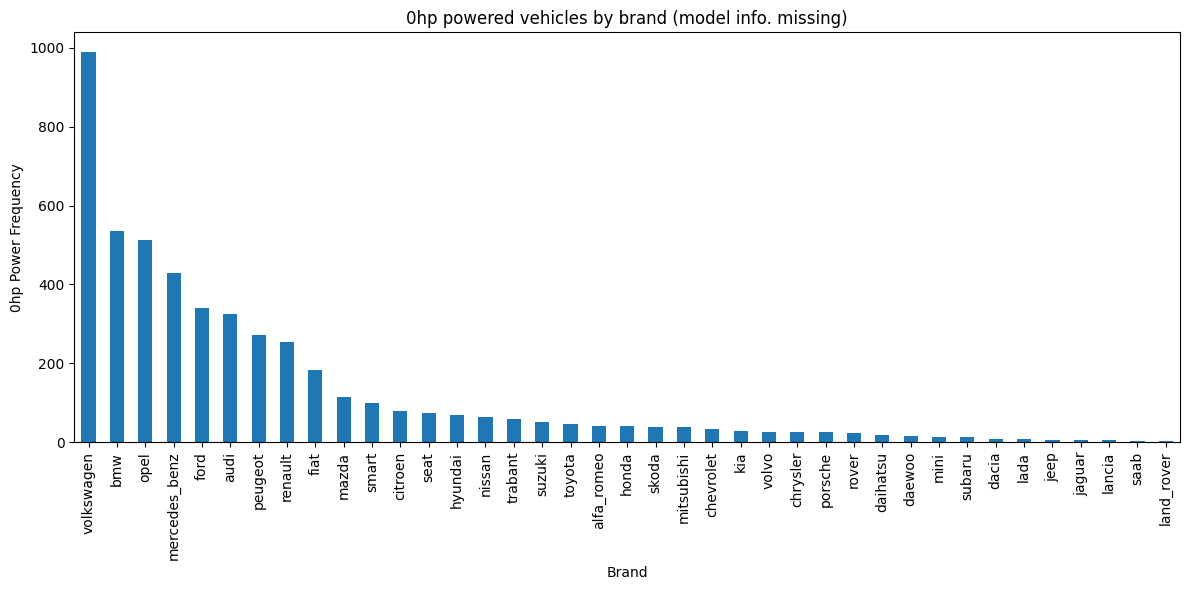

volkswagen       990
bmw              536
opel             512
mercedes_benz    429
ford             341
audi             325
peugeot          272
renault          254
fiat             182
mazda            114
smart            100
citroen           78
seat              73
hyundai           68
nissan            63
trabant           58
suzuki            50
toyota            47
alfa_romeo        42
honda             40
skoda             38
mitsubishi        38
chevrolet         34
kia               27
volvo             25
chrysler          25
porsche           25
rover             23
daihatsu          19
daewoo            16
mini              12
subaru            12
dacia              7
lada               7
jeep               6
jaguar             6
lancia             5
saab               3
land_rover         2
Name: brand, dtype: int64

array(['volkswagen', 'renault', 'mitsubishi', 'bmw', 'peugeot', 'audi',
       'volvo', 'chevrolet', 'trabant', 'opel', 'smart', 'nissan',
       'suzuki', 'mercedes_benz', 'mazda', 'seat', 'fiat', 'citroen',
       'ford', 'skoda', 'kia', 'chrysler', 'daewoo', 'alfa_romeo',
       'rover', 'porsche', 'dacia', 'honda', 'lada', 'subaru', 'hyundai',
       'toyota', 'mini', 'jaguar', 'daihatsu', 'saab', 'land_rover',
       'lancia', 'jeep'], dtype=object)

brand       model            
chevrolet   aveo                   8
            captiva                8
            matiz                 41
            other                129
            spark                  5
chrysler    300c                  17
            crossfire              6
            grand                  8
            other                 45
            ptcruiser             34
            voyager               65
dacia       duster                13
            lodgy                  5
            logan                 33
            other                  1
            sandero               12
daewoo      kalos                 16
            lanos                 18
            matiz                 39
            nubira                 7
            other                 12
daihatsu    charade                6
            cuore                 77
            materia                1
            move                  14
            other                 15
        

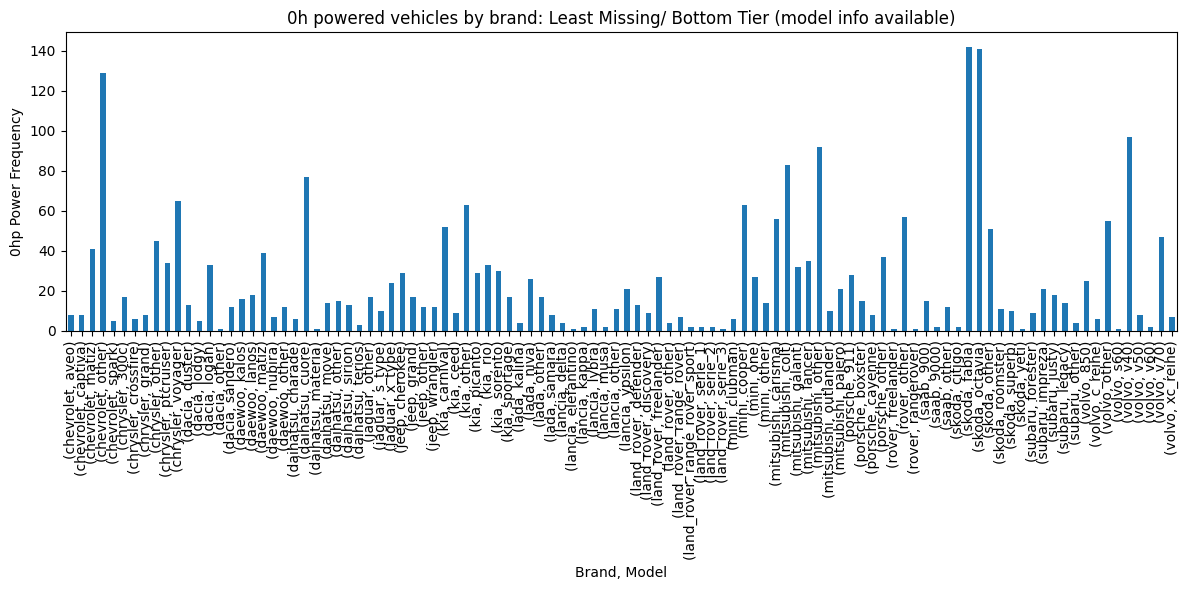

brand       model   
alfa_romeo  145          11
            147          39
            156          58
            159          10
            other        39
            spider       23
citroen     berlingo     94
            c1           32
            c2           37
            c3           48
            c4           27
            c5           41
            other       285
honda       accord       30
            civic       130
            cr_reihe     14
            jazz         19
            other        38
hyundai     getz         60
            i_reihe      56
            other       140
            santa        18
            tucson       11
nissan      almera       73
            juke          4
            micra       301
            navara       14
            note          7
            other        79
            primera      86
            qashqai      26
            x_trail      20
seat        alhambra     27
            altea        15
            arosa       127

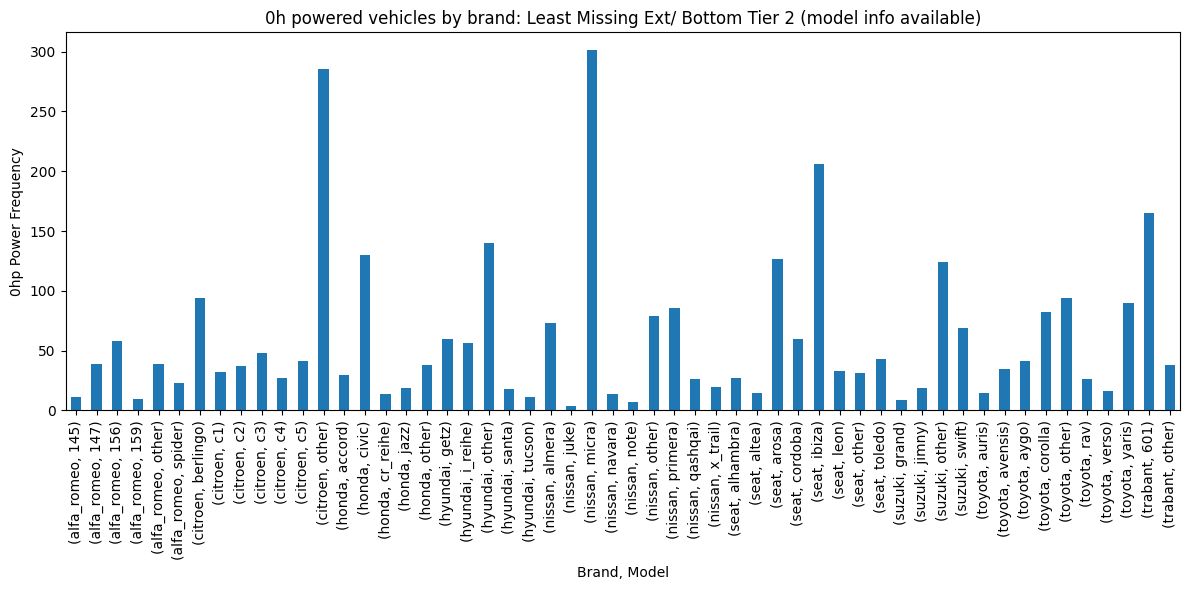

brand    model   
audi     100          33
         200           2
         80          212
         90           15
         a1           12
         a2           39
         a3          490
         a4          729
         a5           17
         a6          363
         a8           44
         other        46
         q3            1
         q5            2
         q7           17
         tt           32
fiat     500          57
         bravo        38
         croma         7
         doblo        32
         ducato       98
         other       244
         panda        86
         punto       518
         seicento    129
         stilo        71
ford     b_max         1
         c_max        36
         escort      143
         fiesta      726
         focus       537
         fusion       22
         galaxy      148
         ka          536
         kuga         11
         mondeo      433
         mustang      32
         other       203
         s_max         5
       

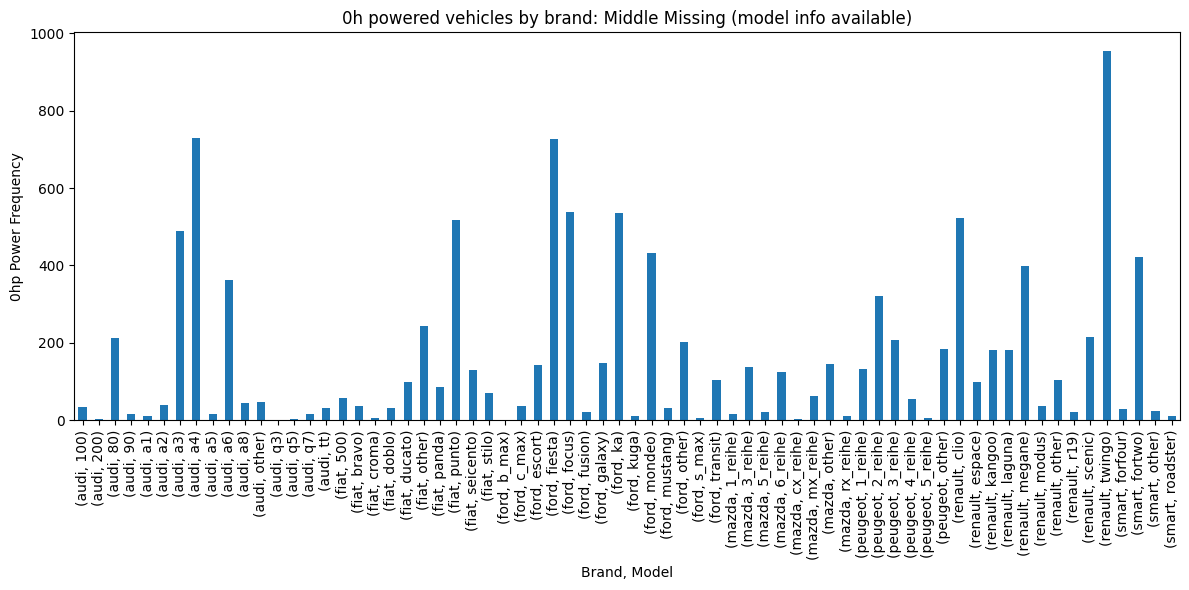

brand          model   
bmw            1er          123
               3er         1534
               5er          499
               6er           13
               7er           79
               i3             3
               m_reihe       17
               other         85
               x_reihe      125
               z_reihe       22
mercedes_benz  a_klasse     539
               b_klasse      54
               c_klasse     744
               cl            21
               clk          138
               e_klasse     638
               g_klasse      14
               gl             1
               glk            4
               m_klasse      71
               other        326
               s_klasse     114
               sl            49
               slk           76
               sprinter     132
               v_klasse      24
               viano         31
               vito         127
opel           agila         70
               antara        13
               a

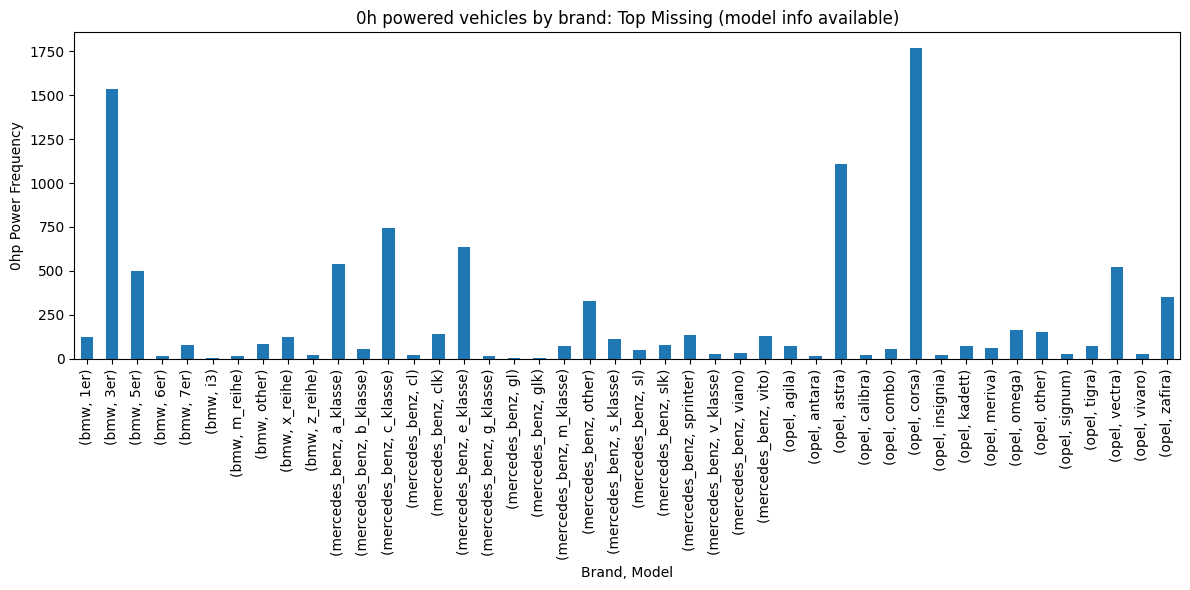

brand       model      
volkswagen  golf           2460
            polo           1611
            passat          883
            transporter     496
            touran          361
            lupo            332
            sharan          230
            caddy           190
            beetle          166
            other           137
            fox              75
            bora             62
            touareg          58
            jetta            47
            scirocco         27
            tiguan           24
            phaeton          20
            eos               8
            cc                8
            up                4
            amarok            1
dtype: int64

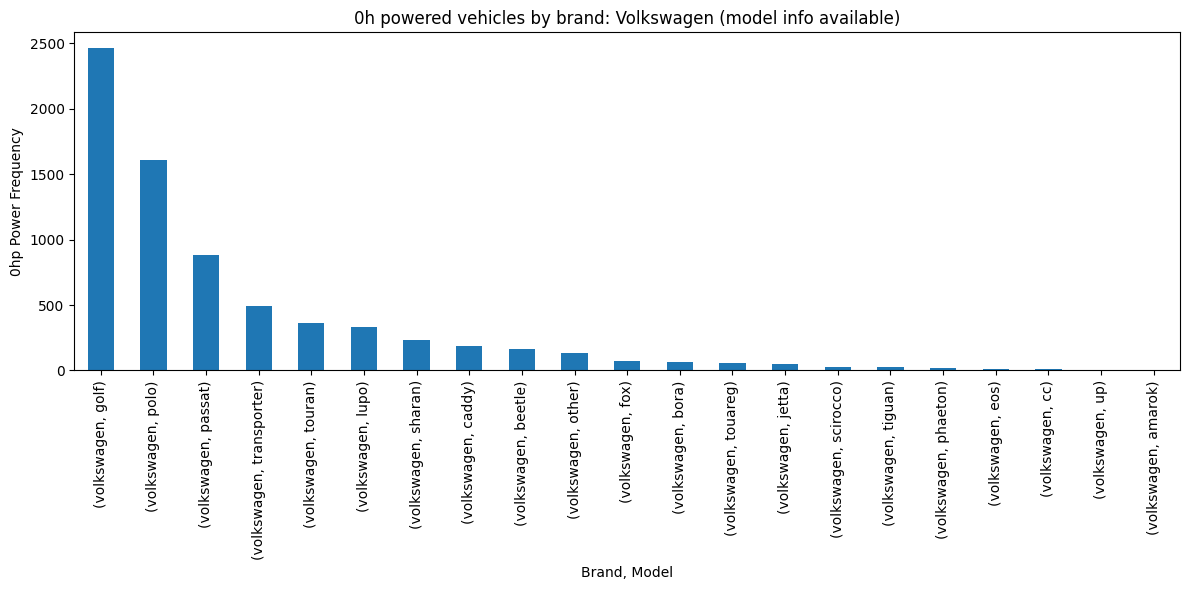

In [18]:
# Inpect Model Column
model_col = df[(df['model'].isna()) & (df['brand'] != 'sonstige_autos')]
model_col_p0 = model_col[model_col['power'] == 0]

brand_p0 = model_col_p0['brand'].value_counts()
brand_p0.plot(kind='bar', x='brand', y='power', figsize=(12,6))
plt.title('0hp powered vehicles by brand (model info. missing)')
plt.xlabel('Brand')
plt.ylabel('0hp Power Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

display(brand_p0)
display(model_col_p0['brand'].unique())

brand_p0_rows_bottom = ['mitsubishi', 'skoda', 'chevrolet', 'kia', 'porsche', 'chrysler', 'volvo', 'rover', 'daihatsu',
           'daewoo', 'subaru', 'mini', 'lada', 'dacia', 'jeep', 'jaguar', 'lancia', 'saab', 'land_rover']
      

brand_p0_rows_mbottom = ['citroen', 'seat', 'hyundai', 'nissan', 'trabant', 'suzuki', 'toyota', 
                         'alfa_romeo', 'honda']

brand_p0_rows_middle = ['ford', 'audi', 'peugeot', 'renault', 'fiat', 'mazda', 'smart']

brand_p0_rows_top = ['bmw', 'opel', 'mercedes_benz']

brand_p0_rows_vw = ['volkswagen']





# Separate by brand and known model
model_col_notna_top_bottom = df[(df['model'].notna()) & (df['brand'] != 'sonstige_autos') & (df['power'] == 0) \
    & (df['brand'].isin(brand_p0_rows_bottom))]

model_col_notna_top_mbottom = df[(df['model'].notna()) & (df['brand'] != 'sonstige_autos') & (df['power'] == 0) \
    & (df['brand'].isin(brand_p0_rows_mbottom))]

model_col_notna_top_middle = df[(df['model'].notna()) & (df['brand'] != 'sonstige_autos') & (df['power'] == 0) \
    & (df['brand'].isin(brand_p0_rows_middle))]

model_col_notna_top = df[(df['model'].notna()) & (df['brand'] != 'sonstige_autos') & (df['power'] == 0) \
    & (df['brand'].isin(brand_p0_rows_top))]

model_col_notna_top_vw = df[(df['model'].notna()) & (df['brand'] != 'sonstige_autos') & (df['power'] == 0) \
    & (df['brand'].isin(brand_p0_rows_vw))]

# Use known model to find NaN values
# Least missing
brand_p0_notna_top_bottom = model_col_notna_top_bottom[['brand','model']].value_counts().sort_index()

# Middle Least missing
brand_p0_notna_top_mbottom = model_col_notna_top_mbottom[['brand','model']].value_counts().sort_index()

# Middle missing
brand_p0_notna_top_middle = model_col_notna_top_middle[['brand','model']].value_counts().sort_index()

# Top Missing
brand_p0_notna_top = model_col_notna_top[['brand','model']].value_counts().sort_index()

# Volkswagen
brand_p0_notna_top_vw = model_col_notna_top_vw[['brand','model']].value_counts()


# Least Missing
with pd.option_context('display.max_rows', None):
    display(brand_p0_notna_top_bottom)
brand_p0_notna_top_bottom.plot(kind = 'bar', x = ('brand','model'), y = 'power', figsize = (12,6))
plt.title('0h powered vehicles by brand: Least Missing/ Bottom Tier (model info available)')
plt.xlabel("Brand, Model")
plt.ylabel("0hp Power Frequency")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

# Next Least Missing
display(brand_p0_notna_top_mbottom)
brand_p0_notna_top_mbottom.plot(kind = 'bar', x = ('brand','model'), y = 'power', figsize = (12,6))
plt.title('0h powered vehicles by brand: Least Missing Ext/ Bottom Tier 2 (model info available)')
plt.xlabel("Brand, Model")
plt.ylabel("0hp Power Frequency")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

# Middle Missing
with pd.option_context('display.max_rows', None):
    display(brand_p0_notna_top_middle)
brand_p0_notna_top_middle.plot(kind = 'bar', x = ('brand','model'), y = 'power', figsize = (12,6))
plt.title('0h powered vehicles by brand: Middle Missing (model info available)')
plt.xlabel("Brand, Model")
plt.ylabel("0hp Power Frequency")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

# Top Missing
display(brand_p0_notna_top)
brand_p0_notna_top.plot(kind = 'bar', x = ('brand','model'), y = 'power', figsize = (12,6))
plt.title('0h powered vehicles by brand: Top Missing (model info available)')
plt.xlabel("Brand, Model")
plt.ylabel("0hp Power Frequency")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

# Volkswagen
display(brand_p0_notna_top_vw)
brand_p0_notna_top_vw.plot(kind = 'bar', x = ('brand','model'), y = 'power', figsize = (12,6))
plt.title('0h powered vehicles by brand: Volkswagen (model info available)')
plt.xlabel("Brand, Model")
plt.ylabel("0hp Power Frequency")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()


In [19]:
model_col_notna_top_vw['model'].unique()

vw0 = ['golf', 'polo', 'passat', 'transporter', 'touran', 'lupo', 'sharan',
       'caddy', 'beetle', 'fox', 'bora', 'touareg',  'jetta', 
       'scirocco', 'tiguan', 'phaeton', 'eos', 'cc', 'up', 'amarok']


model_col_notna_top['model'].unique()

bmw0 = ['3er', '5er', 'x_reihe', '1er', '7er', 'z_reihe', 'm_reihe' '6er', 'i3'] 

merc0 = ['c_klasse', 'e_klasse', 'a_klasse', 'clk', 'sprinter', 'vito', 's_klasse', 'slk', 'm_klasse', 
         'b_klasse', 'sl', 'viano', 'v_klasse', 'cl', 'g_klasse', 'glk', 'gl']

opel0 = ['corsa', 'astra', 'vectra', 'zafira', 'omega', 'kadett', 'tigra', 'agila', 'meriva', 'combo', 
         'signum', 'vivaro', 'calibra', 'insignia', 'antara']

model_col_notna_top_middle['model'].unique()

audi0 = ['a4', 'a3', 'a6', '80', 'a8', 'a2','100', 'tt', 'a5', 'q7', '90', 'a1', '200', 'q5', 'q3']

fiat0 = ['punto', 'seicento', 'ducato', 'panda', 'stilo', '500', 'bravo', 'doblo', 'croma']

ford0 = ['fiesta', 'focus', 'ka', 'mondeo', 'galaxy', 'escort', 'transit', 'c_max', 'mustang', 
         'fusion', 'kuga', 's_max', 'b_max']

mazda0 = ['3_reihe', '6_reihe', 'mx_reihe', '5_reihe', '1_reihe', 'rx_reihe', 'cx_reihe']

peu0 = '2_reihe', '3_reihe', '1_reihe', '4_reihe', '5_reihe',

ren0 = ['twingo', 'clio', 'megane', 'scenic',  'kangoo', 'laguna', 'espace', 'modus',  'r19']       

smart0 = ['fortwo', 'forfour', 'roadster']



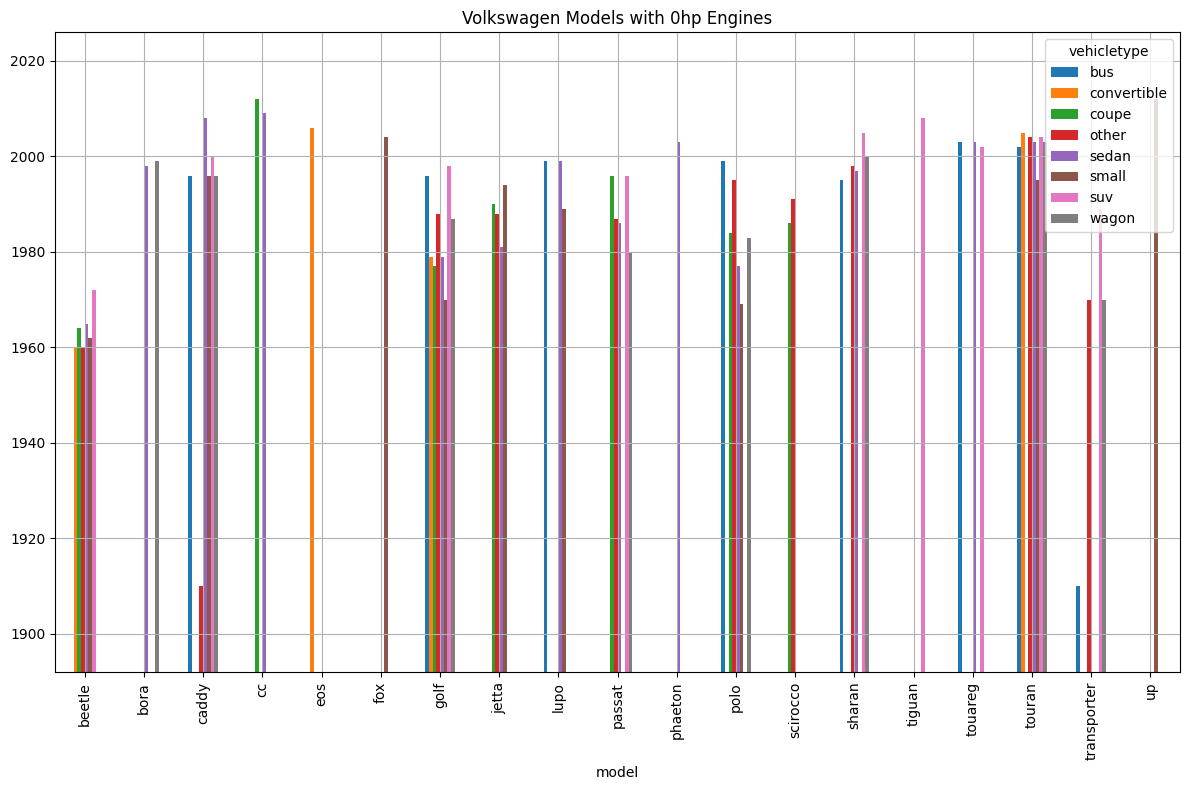

In [20]:
vw_model = df[(df['brand'] == 'volkswagen') & (df['power'] == 0) & (df['model'].isin(vw0))]

pivot_table_min_vw = pd.pivot_table(vw_model, index = 'model', columns = 'vehicletype', values = 'registrationyear', aggfunc = ('min'))
pivot_table_min_vw.plot(kind = 'bar', figsize = (12,8))
plt.title("Volkswagen Models with 0hp Engines")
plt.ylim(1892, 2026)
plt.grid(True)
plt.tight_layout()
plt.show()




In [21]:
del model_col,model_col_p0,brand_p0,brand_p0_rows_bottom,brand_p0_rows_mbottom,brand_p0_rows_middle,brand_p0_rows_top,brand_p0_rows_vw 
del model_col_notna_top_bottom,model_col_notna_top_mbottom,model_col_notna_top_middle,model_col_notna_top,model_col_notna_top_vw 
del brand_p0_notna_top_bottom,brand_p0_notna_top_mbottom,brand_p0_notna_top_middle,brand_p0_notna_top,brand_p0_notna_top_vw
gc.collect()

21322

<div class="alert alert-danger"; style="border-left: 7px solid red">
<b>⛔️ Reviewer's comment V2</b> 
    
This is something that should have been fixed in the previous code, not just adding new code.
</div>

<div class="alert alert-danger"; style="border-left: 7px solid red">
<b>⛔️ Reviewer's comment V2</b> 
    
Is there a reason we are replacing the registration year for all Jetta models made after 2005 with 2016?
</div>

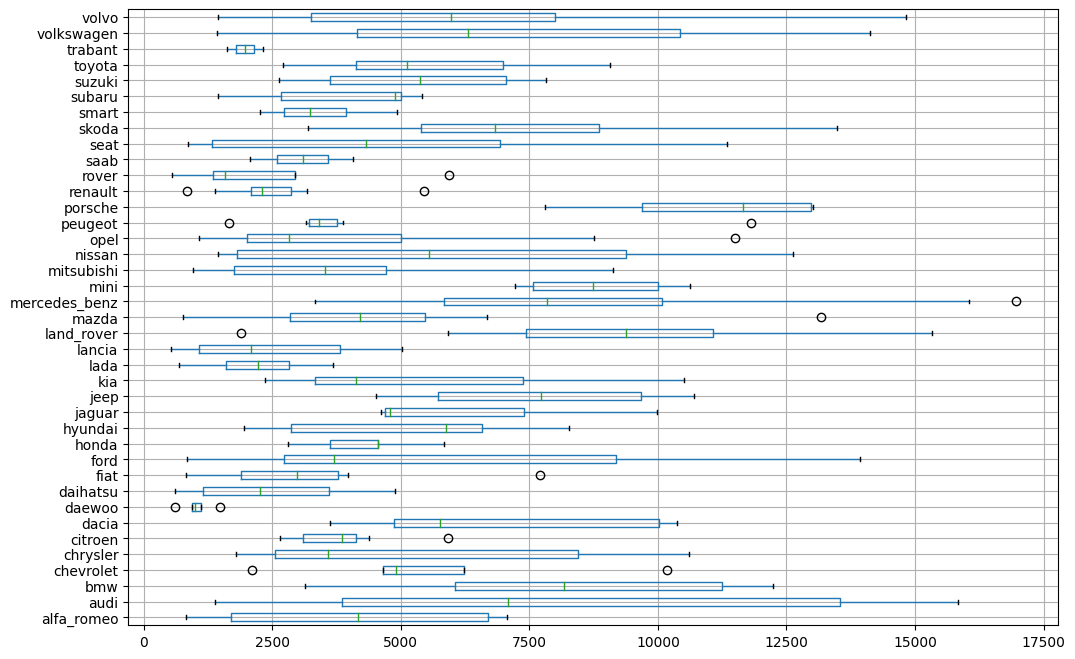

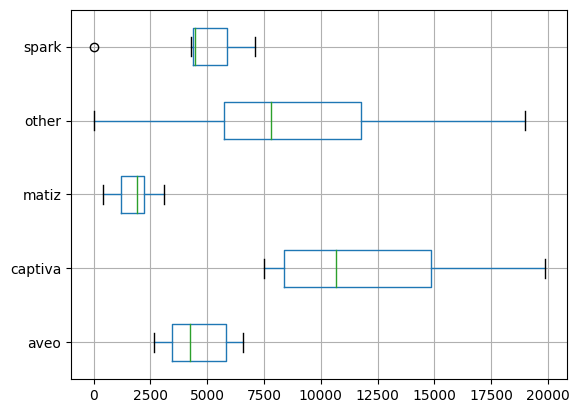

In [22]:
pivot = pd.pivot_table(df, index = 'model', columns = 'brand', values = 'price')

pivot.boxplot(vert = False, figsize = (12,8))
plt.show()

chevy = df[df['brand'] == 'chevrolet']
chevy_pivot = pd.pivot_table(chevy, index = 'registrationyear', columns = 'model', values = 'price')
chevy_pivot
chevy_pivot.boxplot(vert = False)
plt.show()

In [23]:
display(df[(df['vehicletype'] == 'suv') & (df['registrationyear'] > 2005) & (df['brand'] == 'chevrolet')].value_counts(subset = 'model'))
captiva = (df['vehicletype'] == 'suv') & (df['registrationyear'] > 2005) & (df['brand'] == 'chevrolet') & (df['model'] != 'other')
df.loc[captiva,['model']] = 'captiva'

df[(df['vehicletype'] == 'suv') & (df['registrationyear'] > 2005) & (df['brand'] == 'chevrolet')]

convertible = (df['brand'] == 'chevrolet') & (df['vehicletype'] == 'convertible')
df.loc[convertible,['model']] = 'other'

matiz68 = (df['brand'] == 'chevrolet') & (df['power'] == 68) & (df['price'] < 2600)
df.loc[matiz68,['model']] = 'matiz'
df.loc[matiz68,['vehicletype']] = 'small'
display(df[(df['brand'] == 'chevrolet') & (df['power'] == 68) & (df['price'] < 2600)])

matiz52 = (df['brand'] == 'chevrolet') & (df['power'] == 52)
df.loc[matiz52,['model']] = 'matiz'
df.loc[matiz52,['vehicletype']] = 'small'
display(df[(df['brand'] == 'chevrolet') & (df['power'] == 52)])

matiz67 = (df['brand'] == 'chevrolet') & (df['power'] == 67)
df.loc[matiz67,['model']] = 'matiz'
df.loc[matiz67,['vehicletype']] = 'small'
display(df[(df['brand'] == 'chevrolet') & (df['power'] == 67)])

peugeot = df[df['brand'] == 'peugeot']
peugeot_pivot = pd.pivot_table(peugeot,index = 'power', columns = 'model', values = 'price')
df[(df['brand'] == 'peugeot') & (df['power'].isin([7,33,42,43,48,57, 454]))]

re_1 = (df['brand'] == 'peugeot') & (df['power'].isin([7,33,42,43,48,57,454]))
df.loc[re_1,['vehicletype']] = 'small'
df.loc[re_1,['model']] = '1_reihe'
display(df[(df['brand'] == 'peugeot') & (df['power'].isin([7,33,42,43,48,57,454]))])



model
captiva    164
other       19
dtype: int64

datecrawled  price vehicletype  registrationyear gearbox  power  \
82008   08/03/2016 22:44   2599       small            2008.0  manual     68   
140254  22/03/2016 21:36   1200       small            2005.0  manual     68   
205903  14/03/2016 19:41   1799       small            2008.0  manual     68   
257625  23/03/2016 10:38   1500       small            2005.0  manual     68   
353189  19/03/2016 13:37   1200       small            2016.0  manual     68   

        model  mileage  registrationmonth fueltype      brand notrepaired  \
82008   matiz   100000                  8      NaN  chevrolet         NaN   
140254  matiz    90000                  5   petrol  chevrolet         NaN   
205903  matiz   100000                  5   petrol  chevrolet          no   
257625  matiz   150000                 11      lpg  chevrolet         NaN   
353189  matiz    90000                  5   petrol  chevrolet         NaN   

       datecreated  numberofpictures  postalcode          lastseen  \
82008   2016-08-03                 0       44145  14/03/2016 06:16   
140254  2016-03-22                 0        4155  24/03/2016 07:15   
205903  2016-03-14                 0       24816  06/04/2016 04:17   
257625  2016-03-23                 0       41238  24/03/2016 17:17   
353189  2016-03-19                 0        4155  21/03/2016 17:50   

       registration_correction  
82008                        N  
140254                       N  
205903                       N  
257625                     NaN  
353189                       N

datecrawled  price vehicletype  registrationyear gearbox  power  \
373     02/04/2016 12:39   1350       small            2005.0  manual     52   
2263    27/03/2016 19:55   2399       small            2016.0  manual     52   
2820    26/03/2016 20:47   3350       small            2010.0  manual     52   
5636    30/03/2016 08:55   3650       small            2009.0  manual     52   
7123    04/04/2016 18:39   2500       small            2008.0  manual     52   
...                  ...    ...         ...               ...     ...    ...   
340075  17/03/2016 21:37   4999       small            2010.0    auto     52   
340549  29/03/2016 15:57   1599       small            2009.0  manual     52   
344585  13/03/2016 17:50   2100       small            2009.0  manual     52   
349474  08/03/2016 13:25   2600       small            2009.0  manual     52   
349800  01/04/2016 22:38   1950       small            2008.0  manual     52   

        model  mileage  registrationmonth fueltype      brand notrepaired  \
373     matiz   150000                  6   petrol  chevrolet         yes   
2263    matiz    80000                  7   petrol  chevrolet         NaN   
2820    matiz    80000                  2   petrol  chevrolet          no   
5636    matiz    50000                  7   petrol  chevrolet          no   
7123    matiz   125000                 12   petrol  chevrolet          no   
...       ...      ...                ...      ...        ...         ...   
340075  matiz    30000                  3   petrol  chevrolet          no   
340549  matiz    80000                  5   petrol  chevrolet          no   
344585  matiz   125000                 11   petrol  chevrolet          no   
349474  matiz    50000                  3   petrol  chevrolet          no   
349800  matiz    60000                  9   petrol  chevrolet          no   

       datecreated  numberofpictures  postalcode          lastseen  \
373     2016-02-04                 0       91207  06/04/2016 10:17   
2263    2016-03-27                 0       33605  05/04/2016 18:45   
2820    2016-03-26                 0       18273  06/04/2016 11:17   
5636    2016-03-30                 0       26789  30/03/2016 08:55   
7123    2016-04-04                 0       21493  06/04/2016 20:44   
...            ...               ...         ...               ...   
340075  2016-03-17                 0       45329  17/03/2016 22:40   
340549  2016-03-29                 0       20357  06/04/2016 02:15   
344585  2016-03-13                 0       22869  28/03/2016 14:16   
349474  2016-08-03                 0       65719  11/03/2016 09:45   
349800  2016-01-04                 0       42369  01/04/2016 23:41   

       registration_correction  
373                          N  
2263                         N  
2820                         N  
5636                         N  
7123                         N  
...                        ...  
340075                       N  
340549                       N  
344585                       N  
349474                       N  
349800                       N  

[101 rows x 17 columns]

datecrawled  price vehicletype  registrationyear gearbox  power  \
1981    27/03/2016 18:43   2990       small            2007.0  manual     67   
3769    01/04/2016 15:53   1500       small            2016.0  manual     67   
5215    26/03/2016 08:55   2900       small            2010.0  manual     67   
7757    21/03/2016 09:52   3750       small            2007.0  manual     67   
9006    14/03/2016 11:38   2750       small            2007.0  manual     67   
...                  ...    ...         ...               ...     ...    ...   
340326  02/04/2016 22:51   2150       small            2007.0  manual     67   
344984  26/03/2016 22:54   2100       small            2007.0  manual     67   
348552  04/04/2016 13:46   2250       small            2006.0  manual     67   
351693  28/03/2016 17:41   1100       small            2006.0  manual     67   
352283  12/03/2016 15:46   1950       small            2007.0  manual     67   

        model  mileage  registrationmonth fueltype      brand notrepaired  \
1981    matiz   125000                  4      lpg  chevrolet          no   
3769    matiz   125000                 10      NaN  chevrolet         NaN   
5215    matiz    80000                  4   petrol  chevrolet          no   
7757    matiz    70000                 10      lpg  chevrolet          no   
9006    matiz    70000                 10   petrol  chevrolet          no   
...       ...      ...                ...      ...        ...         ...   
340326  matiz   150000                 12   petrol  chevrolet          no   
344984  matiz   125000                  6   petrol  chevrolet          no   
348552  matiz   150000                  7      lpg  chevrolet          no   
351693  matiz   150000                  6   petrol  chevrolet          no   
352283  matiz    90000                  8   petrol  chevrolet          no   

       datecreated  numberofpictures  postalcode          lastseen  \
1981    2016-03-27                 0       72108  05/04/2016 15:15   
3769    2016-01-04                 0        4158  07/04/2016 13:50   
5215    2016-03-26                 0       25421  03/04/2016 19:47   
7757    2016-03-21                 0       53945  06/04/2016 02:45   
9006    2016-03-14                 0       21029  07/04/2016 12:45   
...            ...               ...         ...               ...   
340326  2016-02-04                 0       31863  07/04/2016 00:45   
344984  2016-03-26                 0       48565  04/04/2016 22:47   
348552  2016-04-04                 0       33397  06/04/2016 14:46   
351693  2016-03-28                 0       46537  06/04/2016 23:15   
352283  2016-12-03                 0       48529  15/03/2016 21:16   

       registration_correction  
1981                         N  
3769                         N  
5215                         N  
7757                         N  
9006                         N  
...                        ...  
340326                       N  
344984                       N  
348552                       N  
351693                       N  
352283                       N  

[91 rows x 17 columns]

datecrawled  price vehicletype  registrationyear gearbox  power  \
44179   02/04/2016 17:52    500       small            1998.0    auto      7   
154470  07/03/2016 10:52    100       small            1995.0  manual     42   
174795  10/03/2016 23:44    150       small            1997.0  manual     33   
186556  20/03/2016 16:55    430       small            2016.0     NaN     33   
191097  23/03/2016 22:51      0       small            1997.0  manual     33   
204925  29/03/2016 15:45    850       small            1997.0  manual     57   
210942  30/03/2016 15:51    700       small            1998.0  manual    454   
262687  05/03/2016 16:52      0       small            1996.0  manual     48   
314981  20/03/2016 04:02    700       small            2016.0  manual     33   
323988  10/03/2016 22:50   1033       small            1996.0  manual     43   

          model  mileage  registrationmonth fueltype    brand notrepaired  \
44179   1_reihe   100000                 11   petrol  peugeot          no   
154470  1_reihe   150000                  6   petrol  peugeot         NaN   
174795  1_reihe   150000                 11   petrol  peugeot         yes   
186556  1_reihe   150000                  9   petrol  peugeot         NaN   
191097  1_reihe   125000                  6      NaN  peugeot         yes   
204925  1_reihe   150000                  2   petrol  peugeot          no   
210942  1_reihe   150000                  8   petrol  peugeot         NaN   
262687  1_reihe   150000                  7   petrol  peugeot         yes   
314981  1_reihe   150000                  7   petrol  peugeot          no   
323988  1_reihe   150000                 10   petrol  peugeot          no   

       datecreated  numberofpictures  postalcode          lastseen  \
44179   2016-02-04                 0       66271  02/04/2016 17:52   
154470  2016-07-03                 0        1665  15/03/2016 22:16   
174795  2016-10-03                 0       66333  11/03/2016 12:17   
186556  2016-03-20                 0       73525  04/04/2016 20:44   
191097  2016-03-23                 0       86343  06/04/2016 06:45   
204925  2016-03-29                 0       16909  06/04/2016 01:16   
210942  2016-03-30                 0       85598  30/03/2016 15:51   
262687  2016-05-03                 0       26441  24/03/2016 18:45   
314981  2016-03-20                 0       28759  23/03/2016 22:17   
323988  2016-10-03                 0       42277  24/03/2016 20:18   

       registration_correction  
44179                        N  
154470                       N  
174795                       N  
186556                       N  
191097                     NaN  
204925                       N  
210942                       N  
262687                       N  
314981                       N  
323988                       N

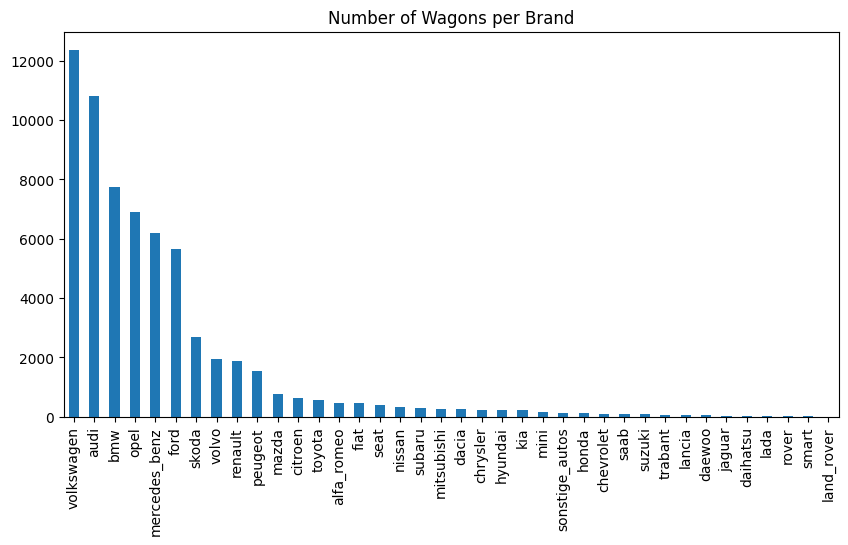

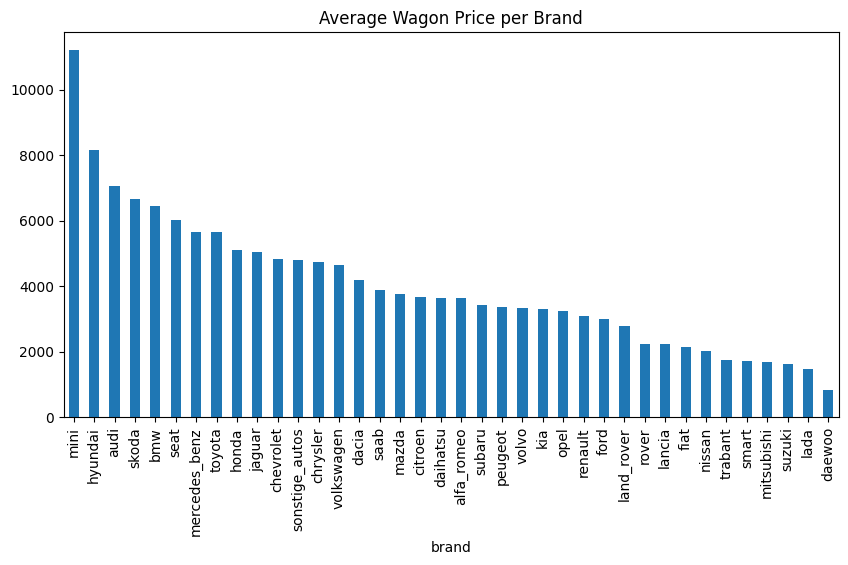

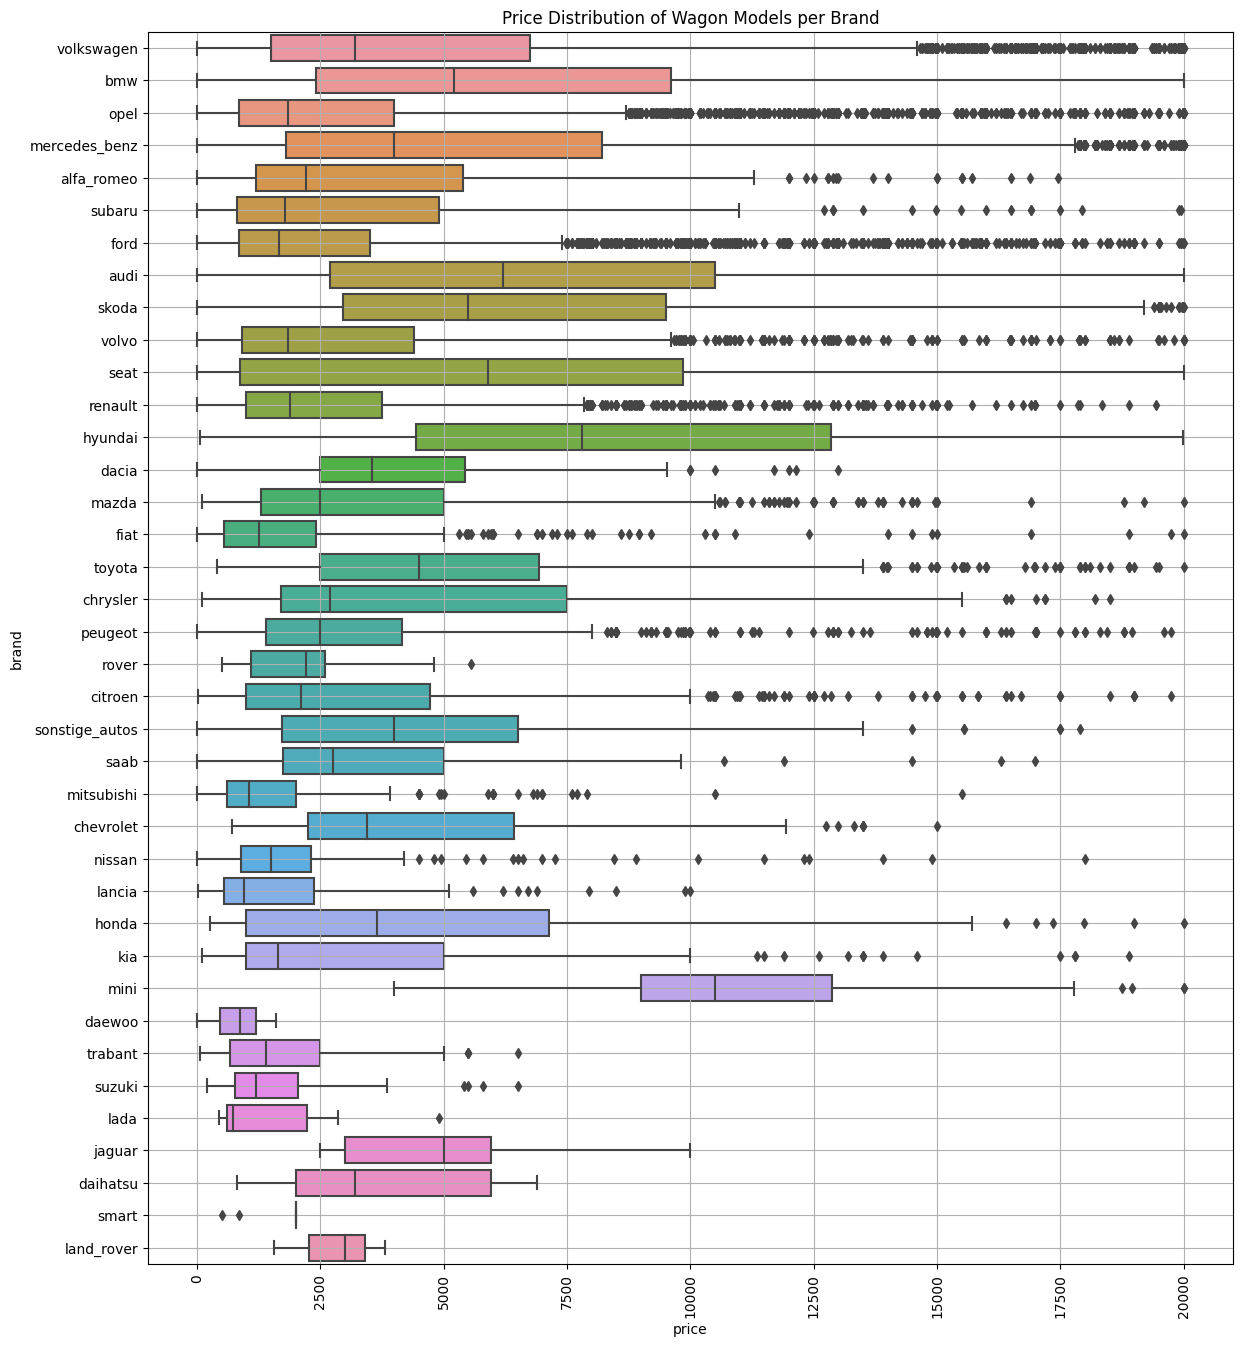

In [24]:
wagon = df[(df['vehicletype'] == 'wagon') & (df['price'] > 0)]

wagon['brand'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of Wagons per Brand')
plt.show()

wagon.groupby('brand')['price'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(10,5), title='Average Wagon Price per Brand')
plt.show()

plt.figure(figsize=(14,16))
sns.boxplot(data=wagon, x='price', y='brand')
plt.xticks(rotation=90)
plt.title('Price Distribution of Wagon Models per Brand')
plt.grid()
plt.show()


**Wagon Type Vehicles Against Price**

| Brand | Vehicle Type | (~)Count | Avg Price | Distribution (25 - 75) |
|-------|--------------|----------|-----------|------------------------|
| volkswagen | Wagon   | 12,500   | 5,000     | 1,250 - 7,000          |
| audi  | Wagon        | 11,000   | 7,000     | 2,500 - 11,000         |
| bmw   | Wagon        | 8,000    | 7,000     | 2,300 - 9,500          |
| opel  | Wagon        | 7,000    | 3,500     | 1,000 - 4,500          |
| mercedes_benz | Wagon| 6,500    | 6,000     | 1,500 - 8,500          |
| ford  | Wagon        | 5,900    | 6,000     | 1,500 - 8,000          |
| skoda | Wagon        | 3,000    | 6,500     | 2,000 - 9,000          |
| volvo | Wagon        | 2,200    | 5,500     | 2,000 - 7,500          |
| renault | Wagon      | 2,000    | 3,000     | 1,000 - 4,000          |
| peugeot | Wagon      | 1,800    | 4,900     | 1,500 - 6,500          |
| mazda | Wagon        | 1,000    | 4,800     | 2,000 - 6,500          |
| toyota | Wagon       | 800      | 4,700     | 2,000 - 6,500          |
| alfa_romeo | Wagon   | 600      | 4,400     | 1,500 - 6,000          |
| fiat  | Wagon        | 500      | 2,200     | 1,000 - 3,000          |
| seat  | Wagon        | 500      | 4,000     | 1,500 - 5,500          |
| nissan | Wagon       | 400      | 3,800     | 1,500 - 5,000          |
| citroen | Wagon      | 400      | 3,700     | 1,500 - 5,000          |
| mitsubishi | Wagon   | 300      | 1,800     | 800 - 2,500            |
| dacia | Wagon        | 300      | 3,700     | 2,000 - 5,000          |
| chevrolet | Wagon    | 200      | 3,500     | 1,500 - 5,000          |
| hyundai | Wagon      | 200      | 11,500    | 6,000 - 15,000         |
| kia   | Wagon        | 200      | 3,300     | 1,500 - 4,500          |
| mini  | Wagon        | 100      | 8,000     | 4,000 - 11,000         |
| subaru | Wagon       | <100     | 4,000     | 2,000 - 5,500          |
| honda | Wagon        | <100     | 3,000     | 1,500 - 4,000          |
| chrysler | Wagon     | <100     | 2,800     | 1,000 - 4,000          |
| saab  | Wagon        | <100     | 2,800     | 1,000 - 4,000          |
| suzuki | Wagon       | <100     | 2,300     | 1,000 - 3,000          |
| smart | Wagon        | <100     | 2,200     | 1,000 - 3,000          |
| lancia | Wagon       | <100     | 2,000     | 800 - 3,000            |
| daewoo | Wagon       | <100     | 900       | 500 - 1,200            |
| jaguar | Wagon       | <100     | 1,800     | 1,000 - 2,500          |
| land_rover | Wagon   | <100     | 2,900     | 1,500 - 4,000          |
| lada  | Wagon        | <100     | 1,700     | 800 - 2,500            |
| rover | Wagon        | <100     | 1,600     | 800 - 2,200            |
| trabant | Wagon      | <100     | 1,800     | 1,000 - 2,500          |




In [25]:
df[(df['brand'] == 'volkswagen') & (df['vehicletype'] == 'wagon') & (df['price'] > 1250) & \
    (df['price'] < 7000) & (df['registrationyear'] > 1996) & (df['registrationyear'] < 1999) & (df['power'].isin([150]))]

passat = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'wagon') & (df['price'] > 1250) & (df['price'] < 7000) & (df['registrationyear'] > 1996) & \
(df['registrationyear'] < 1999) & (df['power'].isin([150]))
df.loc[passat,['model']] = 'passat'


passat1 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'wagon') & (df['price'] > 1250) & (df['price'] < 7000) & (df['registrationyear'] == 1991) & \
    (df['power'].isin([90,136]))
df.loc[passat1,['model']] = 'passat'

passat2 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'wagon') & (df['price'] > 1250) & (df['price'] < 7000) & (df['registrationyear'] == 1992) & \
    (df['model'].isna())
df.loc[passat2,['model']] = 'passat'

passat3 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'wagon') & (df['price'] > 1250) & (df['price'] < 7000) & \
(df['registrationyear'].isin([1982,1993,1994])) & (df['model'].isna())
df.loc[passat3,['model']] = 'passat'

passat4 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'wagon') & (df['price'] > 1250) & (df['price'] < 7000) & (df['registrationyear'].isin([1996])) & \
(df['power'].isin([174])) & (df['model'].isna())
df.loc[passat4,['model']] = 'passat'

passat5 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'wagon') & (df['model'].isna()) & (df['power'].isin([125])) & (df['price'] > 1250) & \
(df['price'] < 7000)
df.loc[passat5,['model']] = 'passat'

passat6 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'wagon') & (df['power'].isin([110,193])) & (df['price'] > 1250) & (df['price'] < 7000) & \
(df['registrationyear'].isin([1998])) & (df['model'].isna())
df.loc[passat6, ['model']] = 'passat'

golf = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'wagon') & (df['price'] > 1250) & (df['price'] < 7000) & (df['registrationyear'].isin([1996])) & \
(df['power'].isin([75,110])) & (df['model'].isna())

df.loc[golf,['model']] = 'golf'

passat140 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'wagon') & (df['model'].isna()) & (df['registrationyear'] > 2004) & \
(df['registrationyear'] < 2007) & (df['power'].isin([140]))
df.loc[passat140,['model']] = 'passat'

golf90 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 2000) & \
(df['registrationyear'] < 2005) & (df['power'].isin([90]))
df.loc[golf90,['model']] = 'golf'

passat90 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 1985) & \
(df['registrationyear'] < 1993) & (df['power'].isin([90]))
df.loc[passat90,['model']] = 'passat'

golf75 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 1993) & \
(df['registrationyear'] < 1995) & (df['power'].isin([75]))
df.loc[golf75,['model']] = 'golf'

golf7502 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 2001) & \
(df['registrationyear'] < 2003) & (df['power'].isin([75]))
df.loc[golf7502,['model']] = 'golf'

passat105 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 1995) & \
(df['registrationyear'] < 1998) & (df['power'].isin([105]))
df.loc[passat105,['model']] = 'passat'

passat131 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 1999) & \
(df['registrationyear'] < 2002) & (df['power'].isin([131]))
df.loc[passat131,['model']] = 'passat'

passat116 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 1989) \
& (df['registrationyear'] < 1997) & (df['power'].isin([116]))
df.loc[passat116,['model']] = 'passat'

passat150 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 1995) \
& (df['registrationyear'] < 2006) & (df['power'].isin([150]))
df.loc[passat150,['model']] = 'passat'

passat115 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 1990) \
& (df['registrationyear'] < 1997) & (df['power'].isin([115]))
df.loc[passat115,['model']] = 'passat'

passat170 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 2004) & \
(df['registrationyear'] < 2012) & (df['power'].isin([170]))
df.loc[passat170,['model']] = 'passat'

golf110 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 2013) & \
(df['registrationyear'] < 2017) & (df['power'].isin([60]))
df.loc[golf110,['model']] = 'golf'

golf60 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 1990) & \
(df['registrationyear'] < 1996) & (df['power'].isin([60]))
df.loc[golf60,['model']] = 'golf'

polo60 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 1996) & \
(df['registrationyear'] < 2001) & (df['power'].isin([60]))
df.loc[polo60,['model']] = 'polo'

passat125 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 1996) & \
(df['registrationyear'] < 2000) & (df['power'].isin([125]))
df.loc[passat125,['model']] = 'passat'

passat100 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 1990) & \
(df['registrationyear'] < 2005) & (df['power'].isin([100]))
df.loc[passat100,['model']] = 'passat'

passat174 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 1993) & \
(df['registrationyear'] < 1997) & (df['power'].isin([174]))
df.loc[passat174,['model']] = 'passat'

passat130 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 1998) & \
(df['registrationyear'] < 2005) & (df['power'].isin([130]))
df.loc[passat130,['model']] = 'passat'

passat120 = (df['brand'] == 'volkswagen') & (df['model'].isna()) & (df['vehicletype'] == 'wagon') & (df['registrationyear'] > 1980) & (df['registrationyear'] < 2000) & (df['power'].isin([120]))
df.loc[passat120,['model']] = 'passat'


vw_small75 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'small') & (df['model'].isna()) & (df['power'].isin([75])) & \
(df['registrationyear'].isin([1985,1992]))
df.loc[vw_small75,['model']] = 'golf'

vw_sedan75 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'sedan') & (df['model'].isna()) & (df['power'].isin([75])) & \
(df['registrationyear'] > 1993) & (df['registrationyear'] < 2007)
df.loc[vw_sedan75,['model']] = 'golf'

opel_sedan84 = (df['brand'] == 'opel') & (df['vehicletype'] == 'sedan') & (df['model'].isna()) & (df['power'].isin([75])) & \
(df['registrationyear'].isin([1984]))
df.loc[opel_sedan84,['model']] = 'kadett'

opel_sedan94 = (df['brand'] == 'opel') & (df['vehicletype'] == 'sedan') & (df['model'].isna()) & (df['power'].isin([75])) & \
(df['registrationyear'].isin([1994,1999,2000]))
df.loc[opel_sedan94,['model']] = 'astra'

opel_sedan04 = (df['brand'] == 'opel') & (df['vehicletype'] == 'sedan') & (df['model'].isna()) & (df['power'].isin([75])) & \
(df['registrationyear'].isin([2004,2008]))
df.loc[opel_sedan04,['model']] = 'corsa'

ford_sedan99 = (df['brand'] == 'ford') & (df['vehicletype'] == 'sedan') & (df['model'].isna()) & (df['power'].isin([75])) & \
(df['registrationyear'].isin([1999,2001,2003]))
df.loc[ford_sedan99,['model']] = 'focus'

opel_wagon96 = (df['brand'] == 'opel') & (df['vehicletype'] == 'wagon') & (df['model'].isna()) & (df['power'].isin([75])) & (df['registrationyear'] > 1995) \
& (df['registrationyear'] < 2001)
df.loc[opel_wagon96,['model']] = 'astra'

opel_small01 = (df['brand'] == 'opel') & (df['vehicletype'] == 'small') & (df['model'].isna()) & (df['power'].isin([75])) \
& (df['registrationyear'].isin([2001, 2002, 2003, 2004, 2006, 2008]))
df.loc[opel_small01,['model']] = 'corsa'

renault_small91 = (df['brand'] == 'renault') & (df['vehicletype'] == 'small') & (df['model'].isna()) & (df['power'].isin([75])) & \
(df['registrationyear'] > 1990) & (df['registrationyear'] < 2001)
df.loc[renault_small91,['model']] = 'clio'

peugeot_small92 = (df['brand'] == 'peugeot') & (df['vehicletype'] == 'small') & (df['model'].isna()) & (df['power'].isin([75])) & \
(df['registrationyear'].isin([1992]))
df.loc[peugeot_small92,['model']] = '1_reihe'

peugeot_small94 = (df['brand'] == 'peugeot') & (df['vehicletype'] == 'small') & (df['model'].isna()) & (df['power'].isin([75])) & \
(df['registrationyear'].isin([1994]))
df.loc[peugeot_small94,['model']] = '3_reihe'

peugeot_small00 = (df['brand'] == 'peugeot') & (df['vehicletype'] == 'small') & (df['model'].isna()) & (df['power'].isin([75])) & \
(df['registrationyear'] > 1999) & (df['registrationyear'] < 2010)
df.loc[peugeot_small00,['model']] = '2_reihe'

In [26]:
del vw0, bmw0, merc0, opel0, audi0, fiat0, ford0, mazda0, peu0, ren0, smart0, chevy, chevy_pivot, captiva, convertible, matiz68, matiz52, matiz67
del peugeot, peugeot_pivot, re_1, wagon, passat, passat1, passat2, passat3, passat4, passat5, passat6, golf
del passat140, golf90, passat90, golf75, golf7502, passat105, passat131, passat116, passat150, passat115, passat170, golf110, golf60, polo60
del passat125, passat100, passat174, passat130, passat120
del vw_small75,vw_sedan75,opel_sedan84,opel_sedan94,opel_sedan04,ford_sedan99,opel_wagon96,opel_small01,renault_small91,peugeot_small92
del peugeot_small94,peugeot_small00

gc.collect()

25995

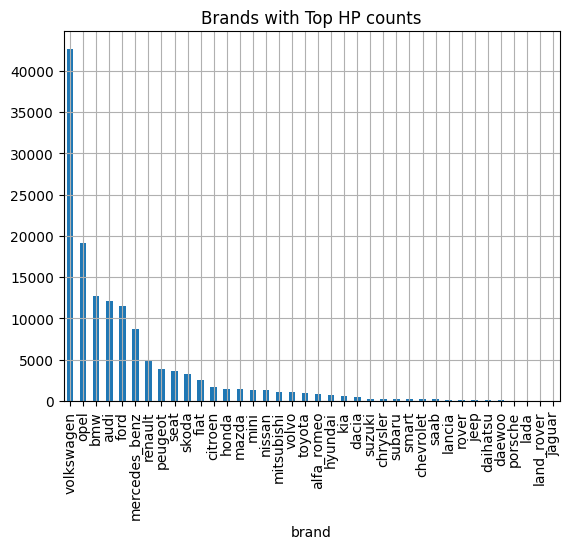

In [27]:
brand_power = df[(df['power'].isin([75,60,150,101,140,90,116,105,170,125,136,102])) & (df['model'].notna()) & (df['model'] != 'model') & \
    (df['brand'] != 'sonstige_autos')].value_counts(subset = 'brand')

brand_power.plot(kind = 'bar')
plt.title("Brands with Top HP counts")
plt.grid()
plt.show()

Batch 1: HP [60 & 70]


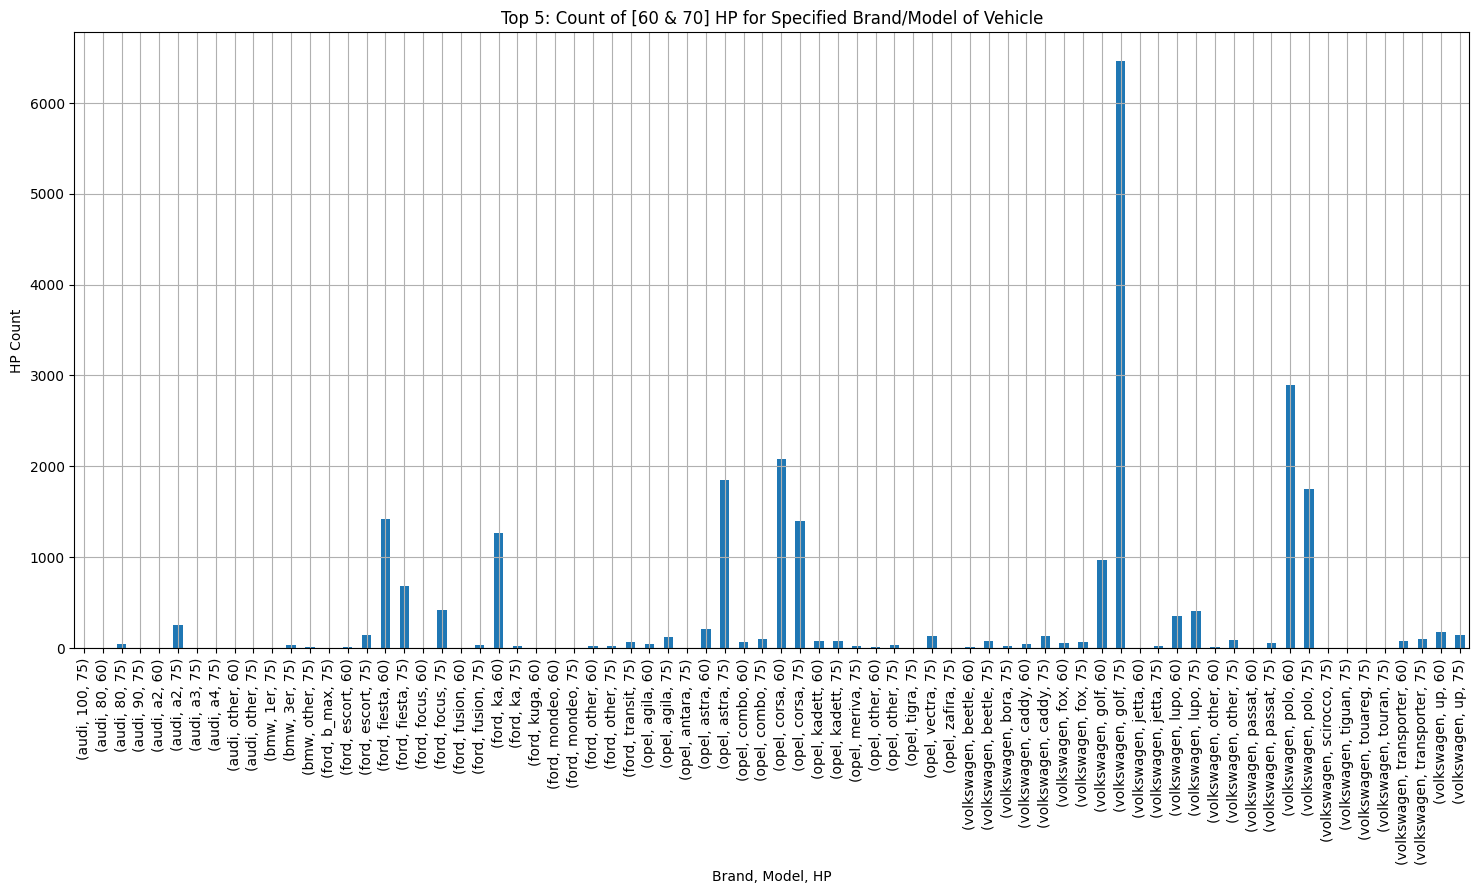

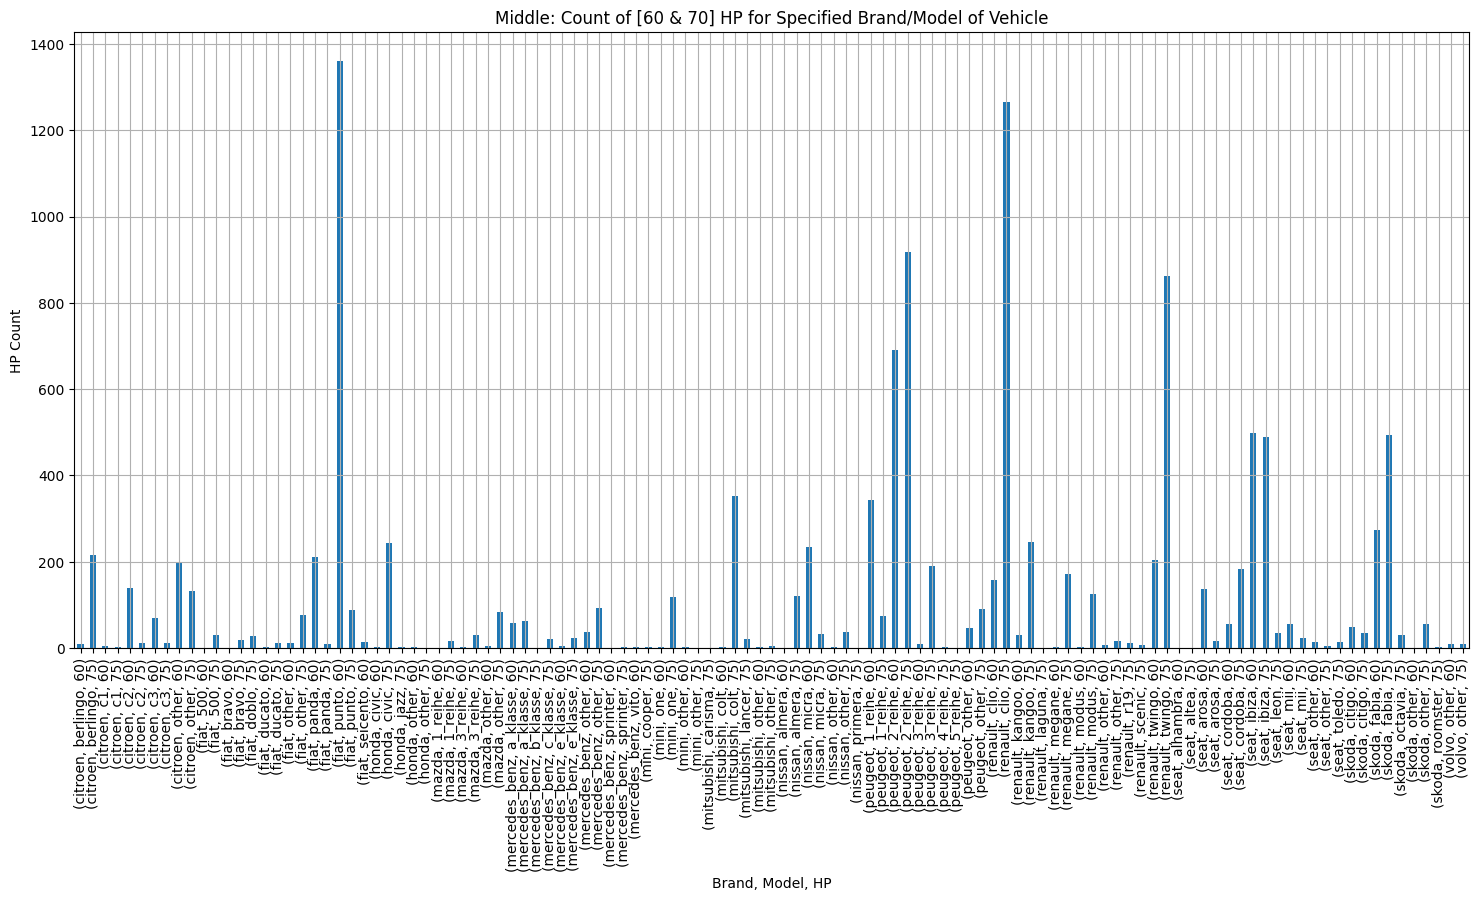

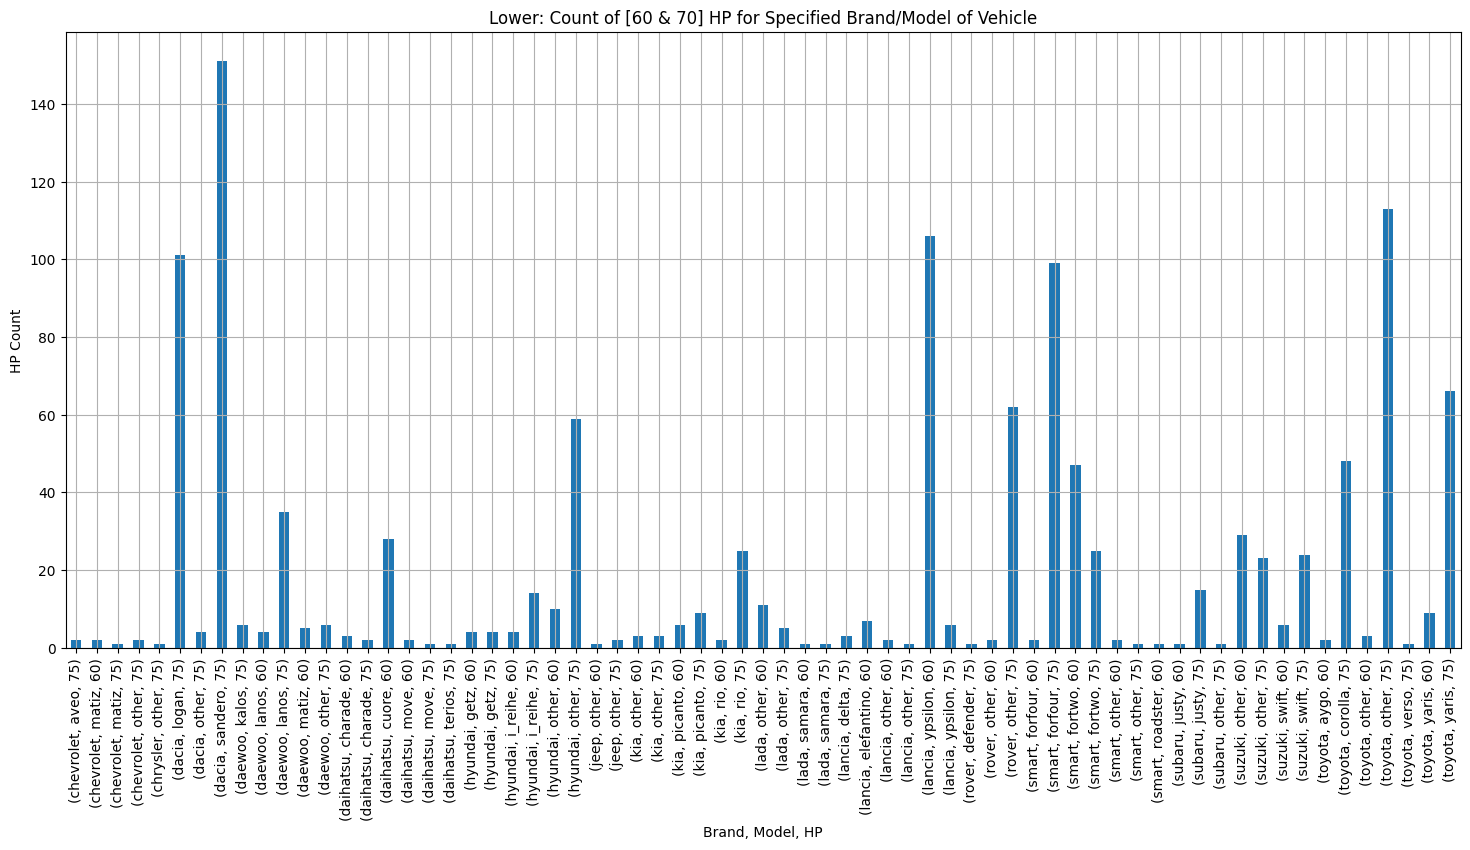

Batch 2: HP [150 & 101]


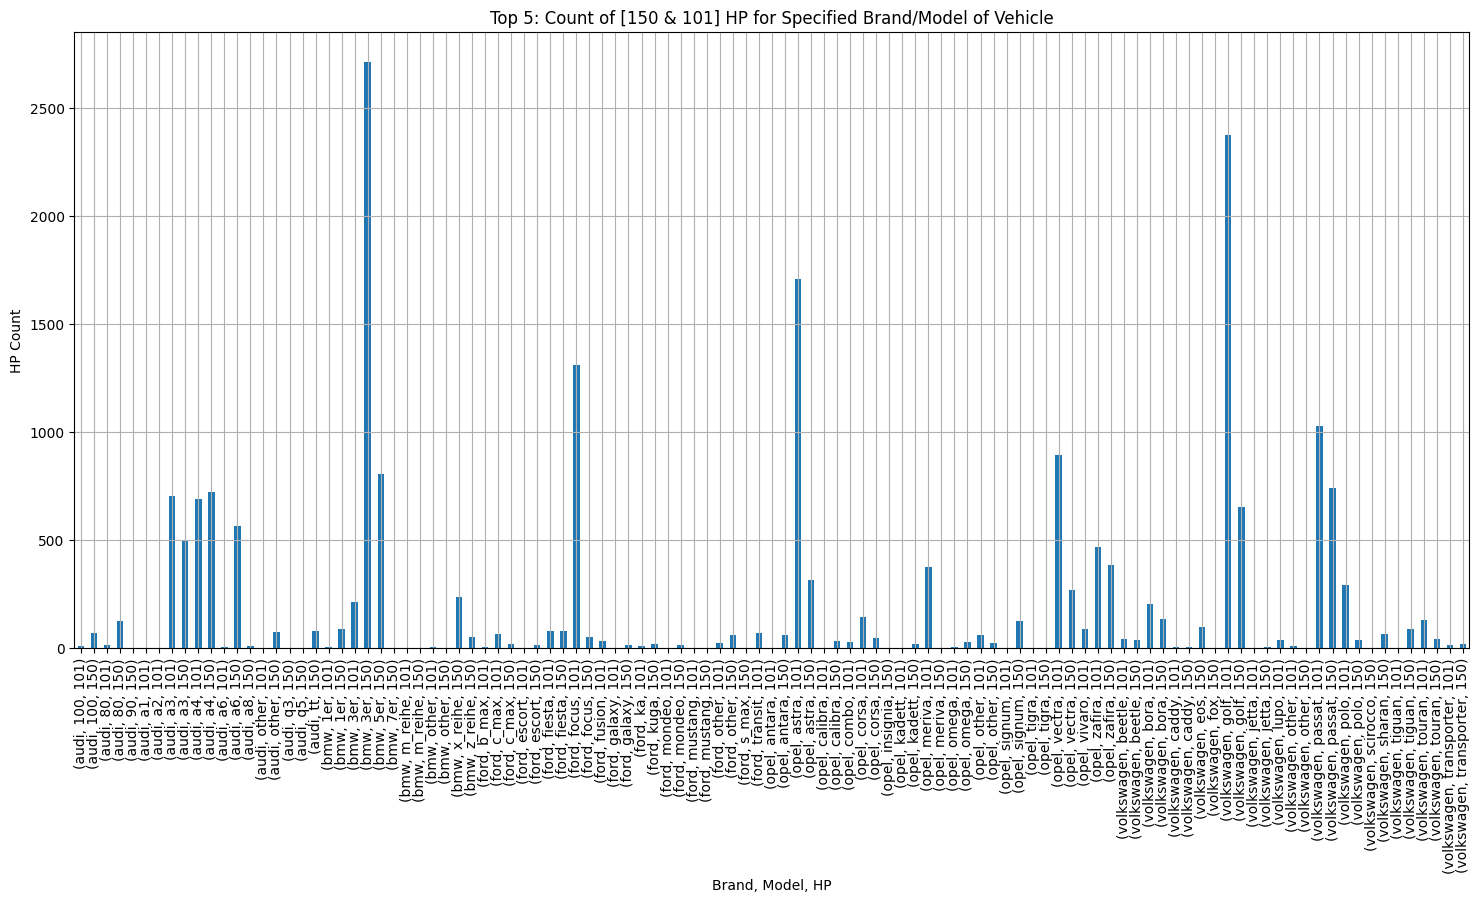

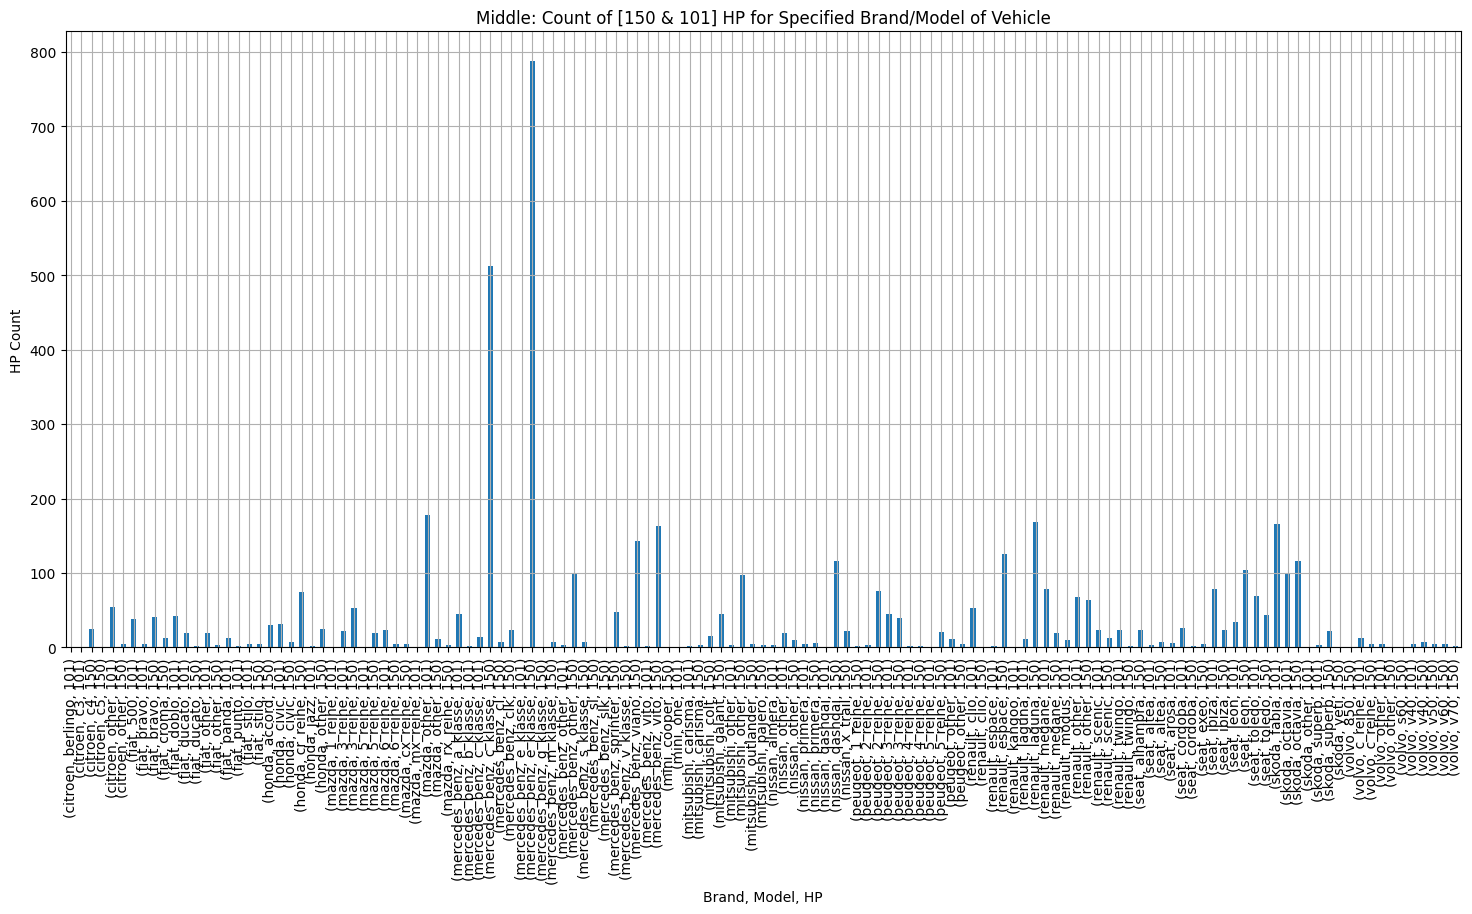

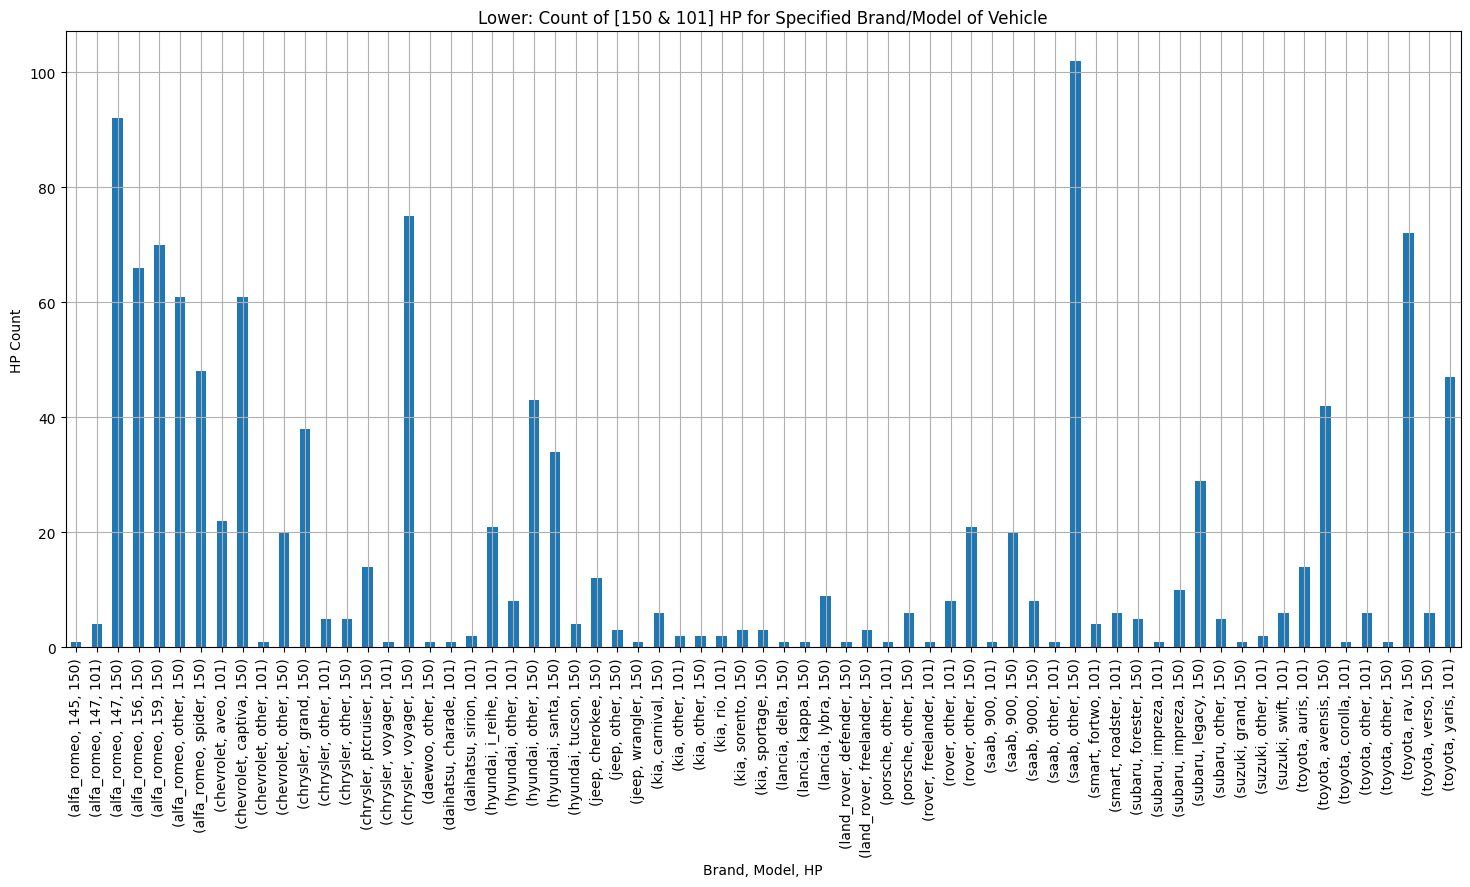

Batch 3: HP [140 & 90]


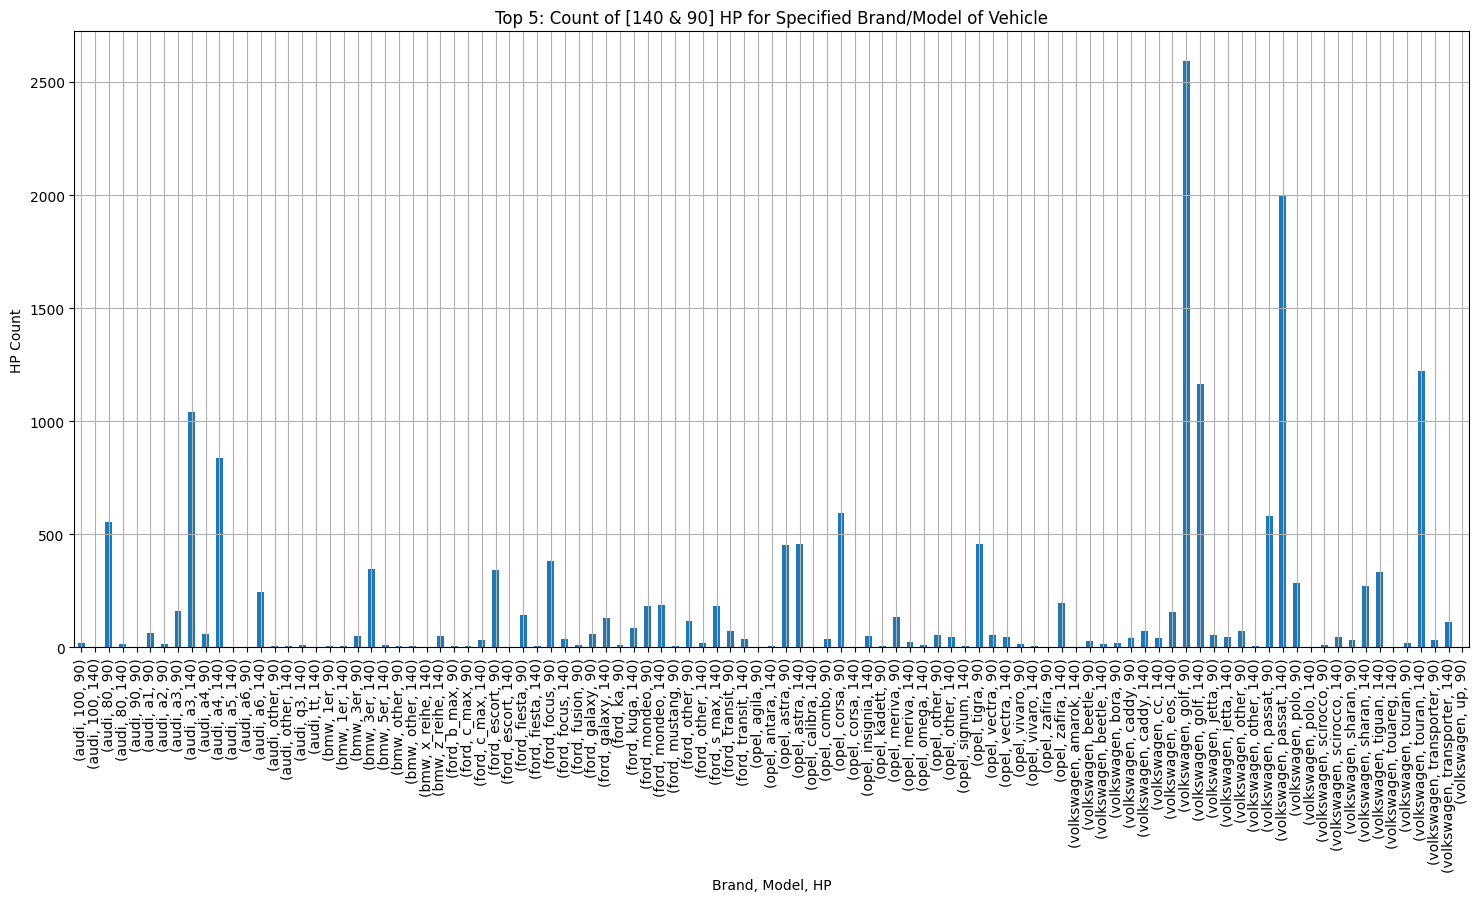

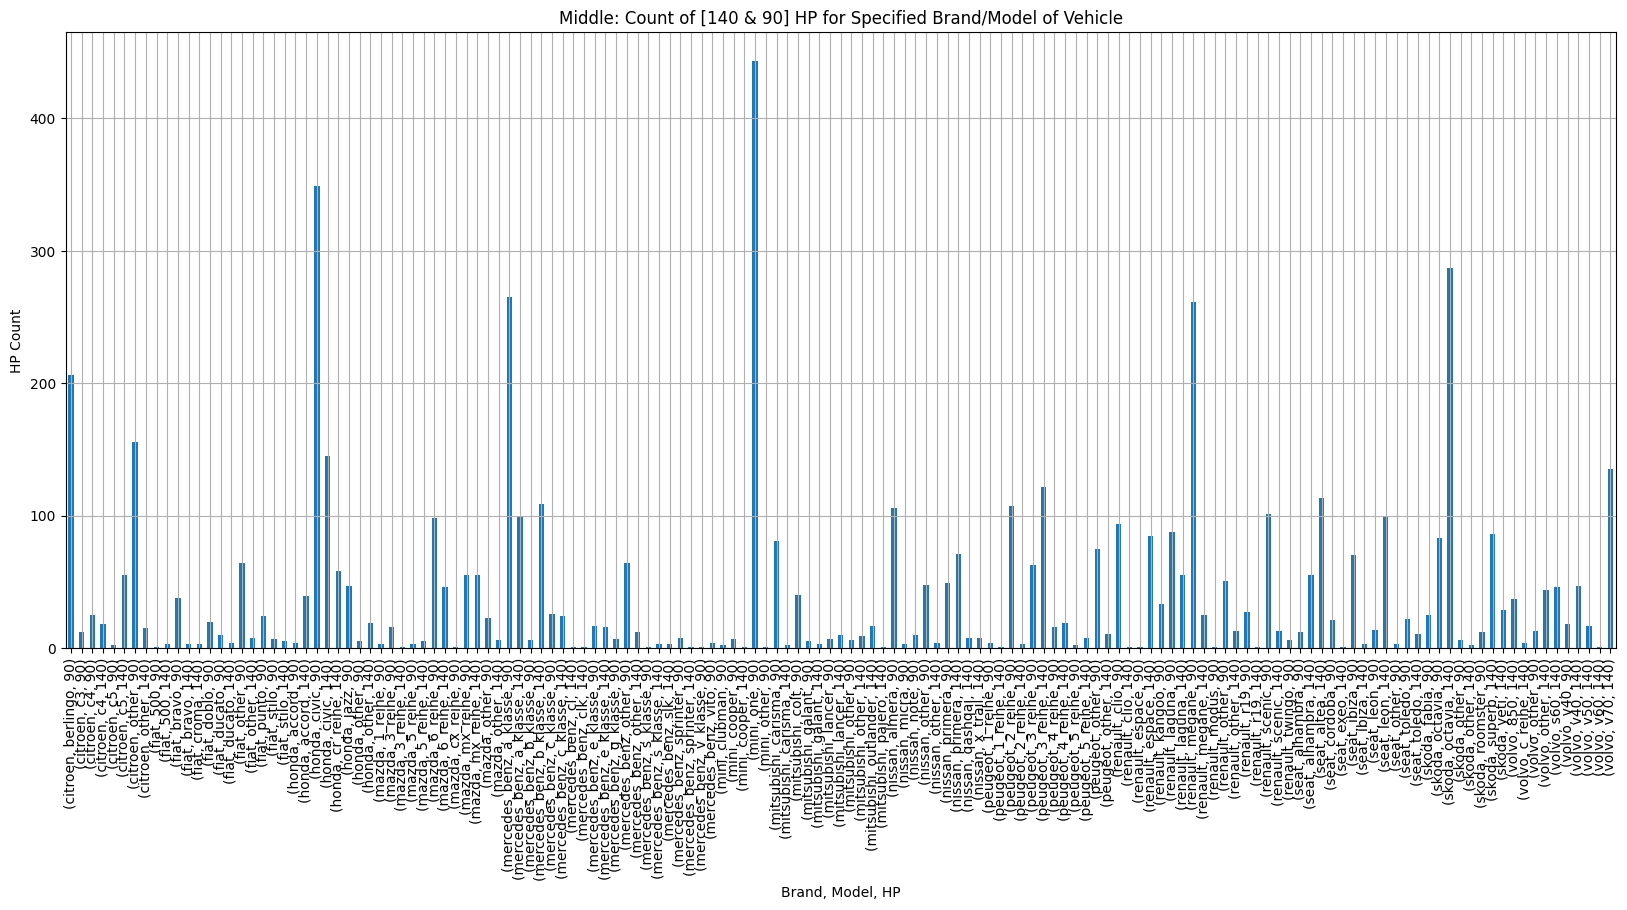

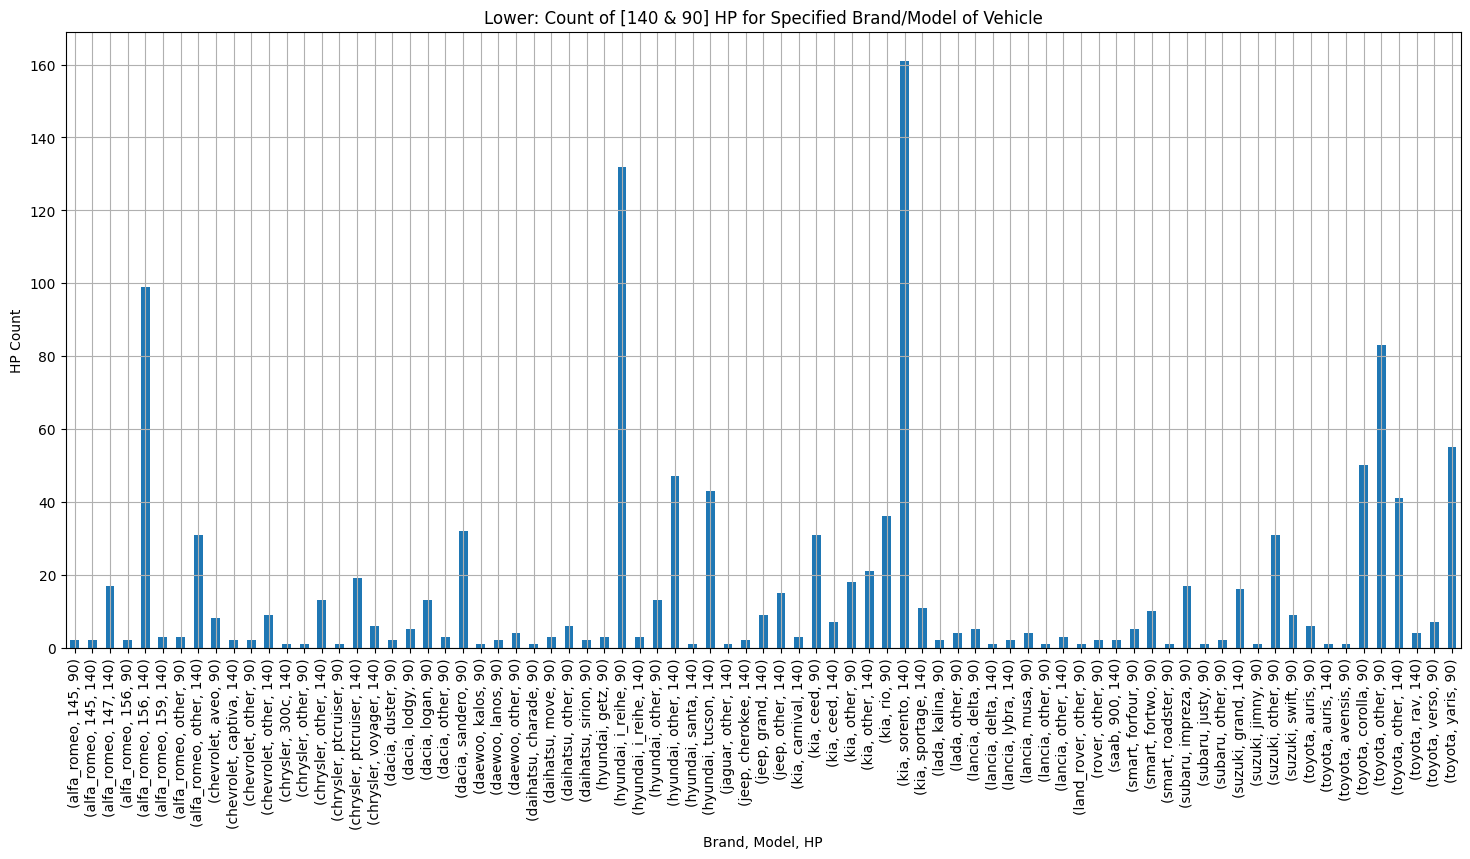

Batch 4: HP [116 & 105]


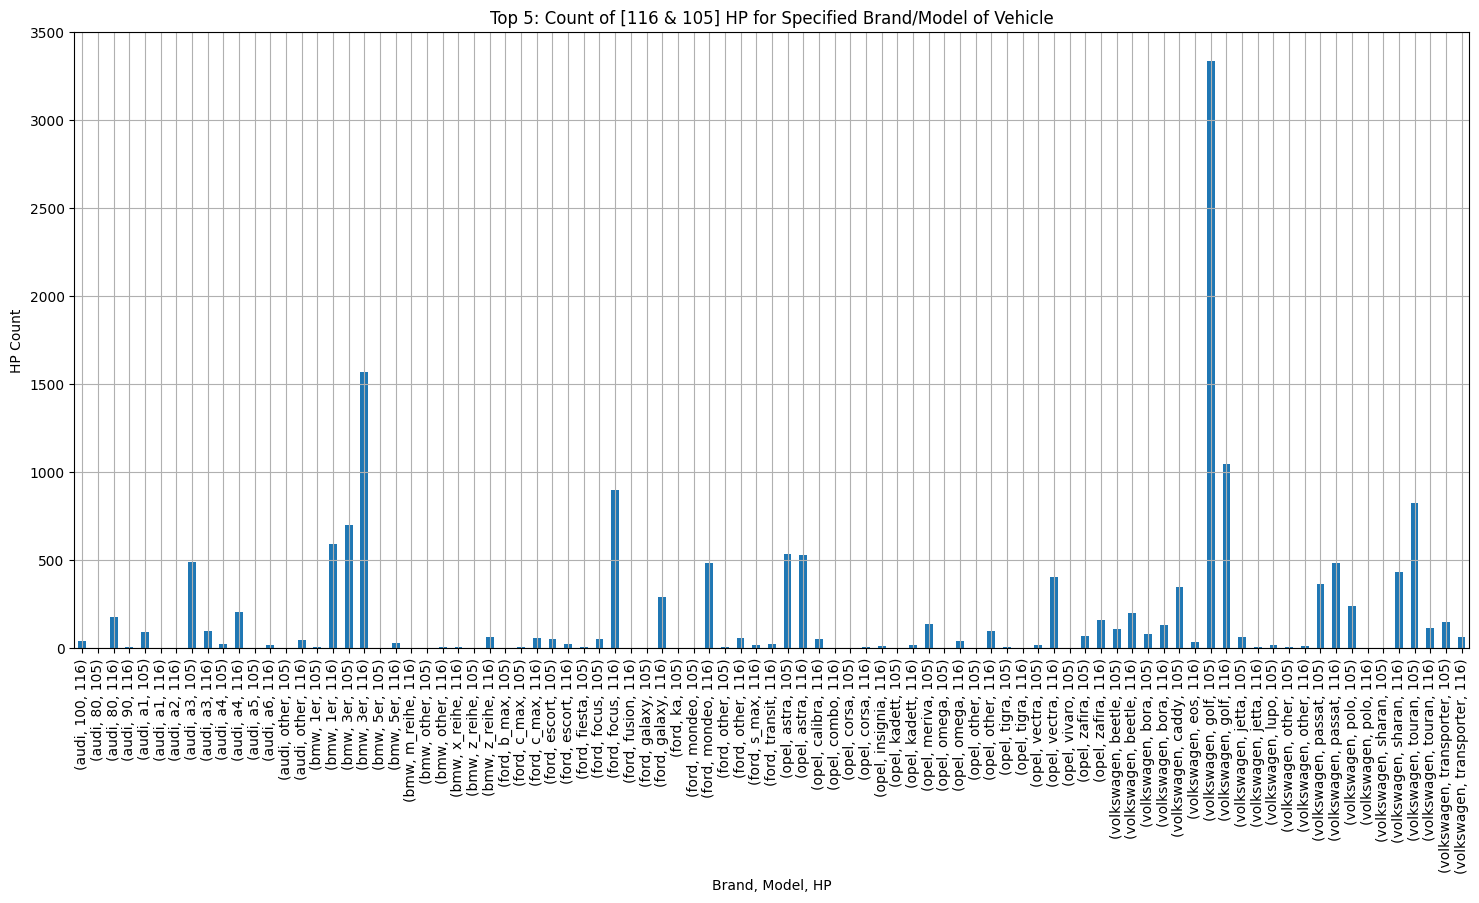

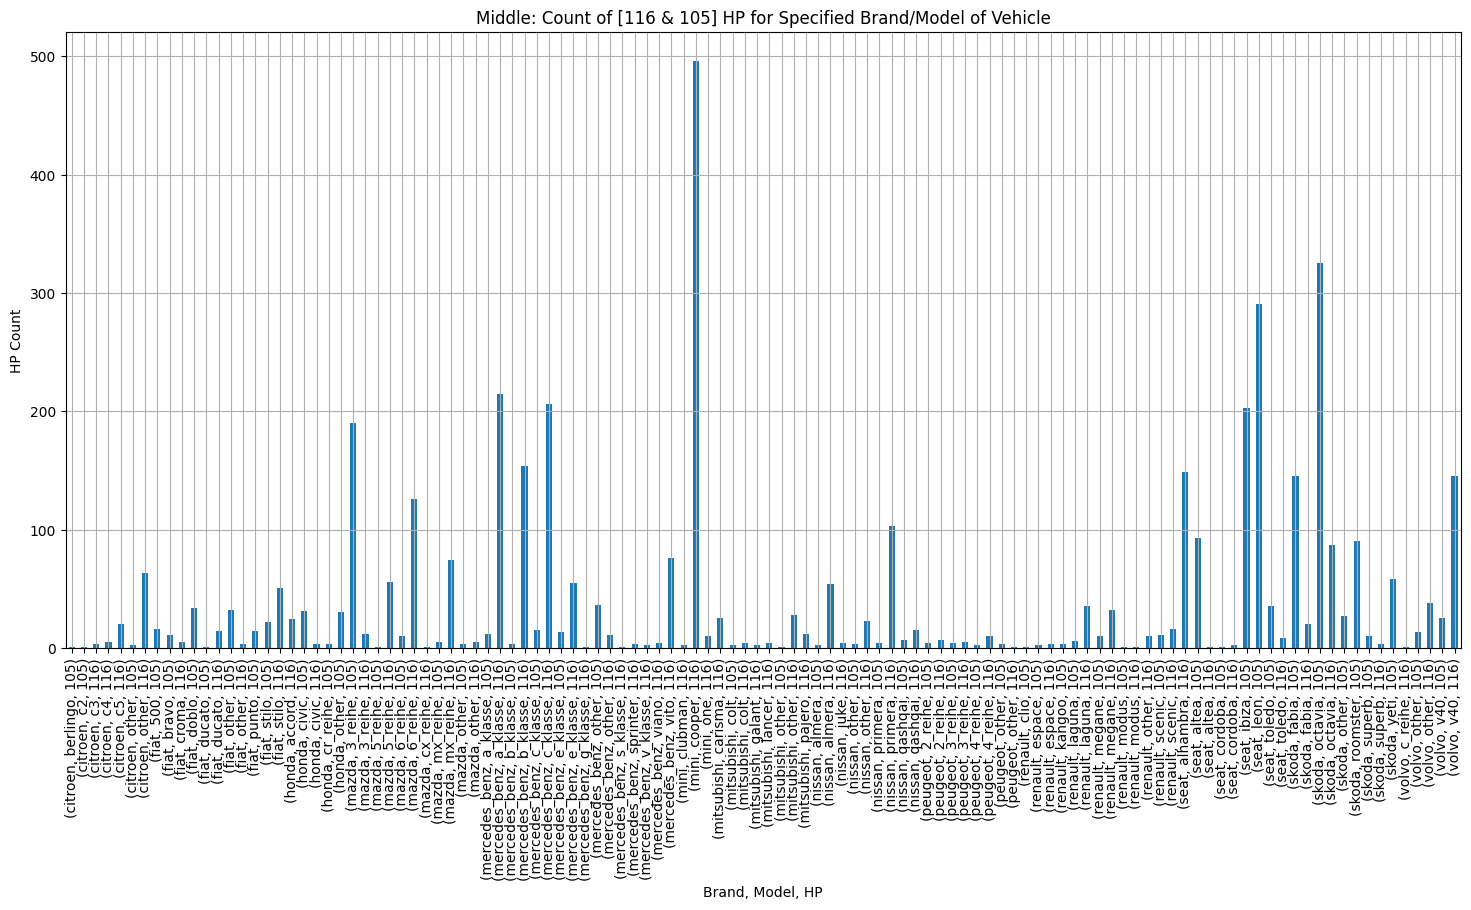

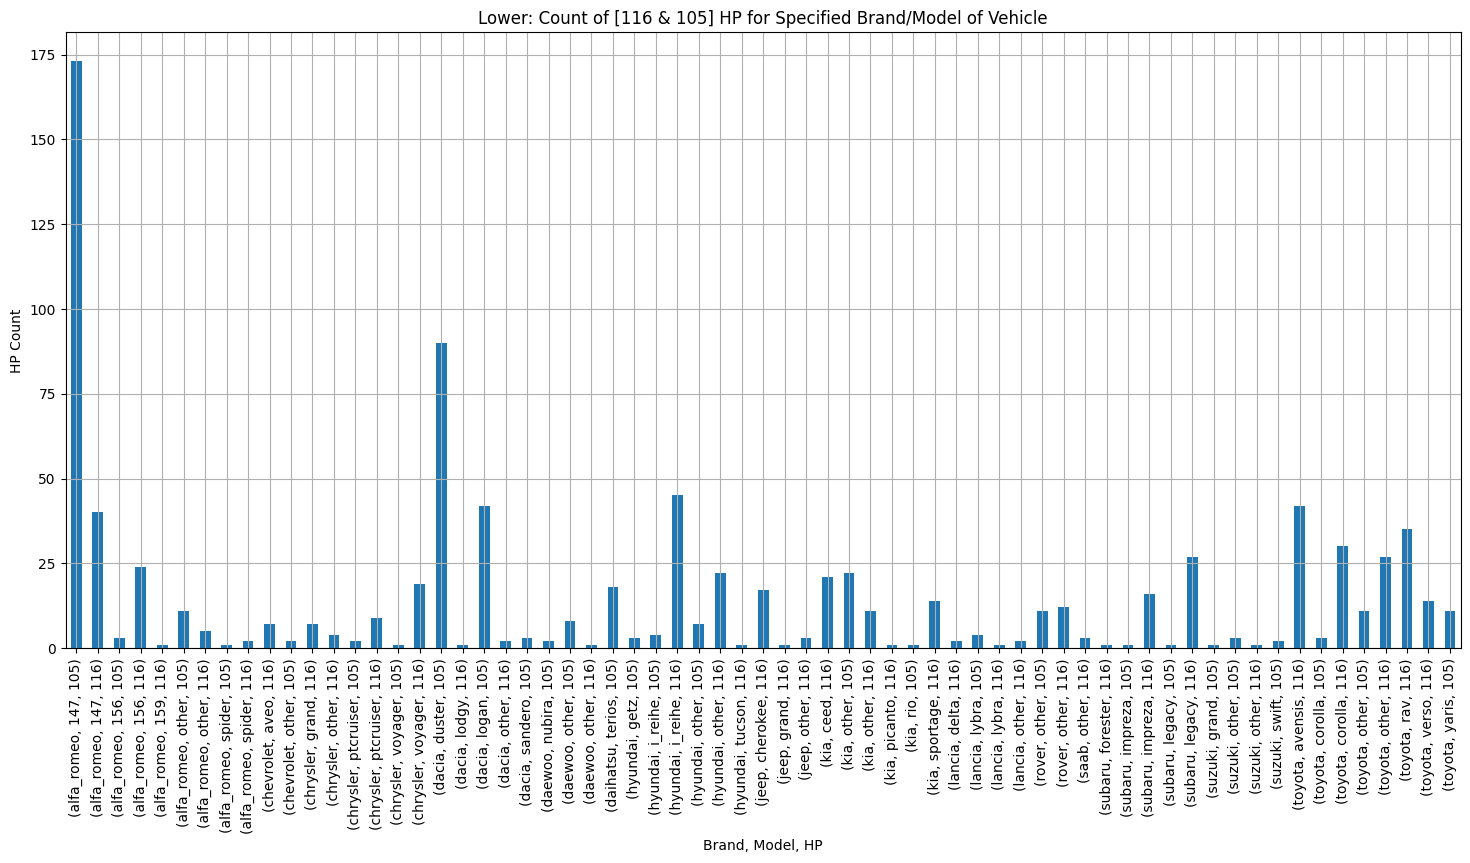

Batch 5: HP [170 & 125]


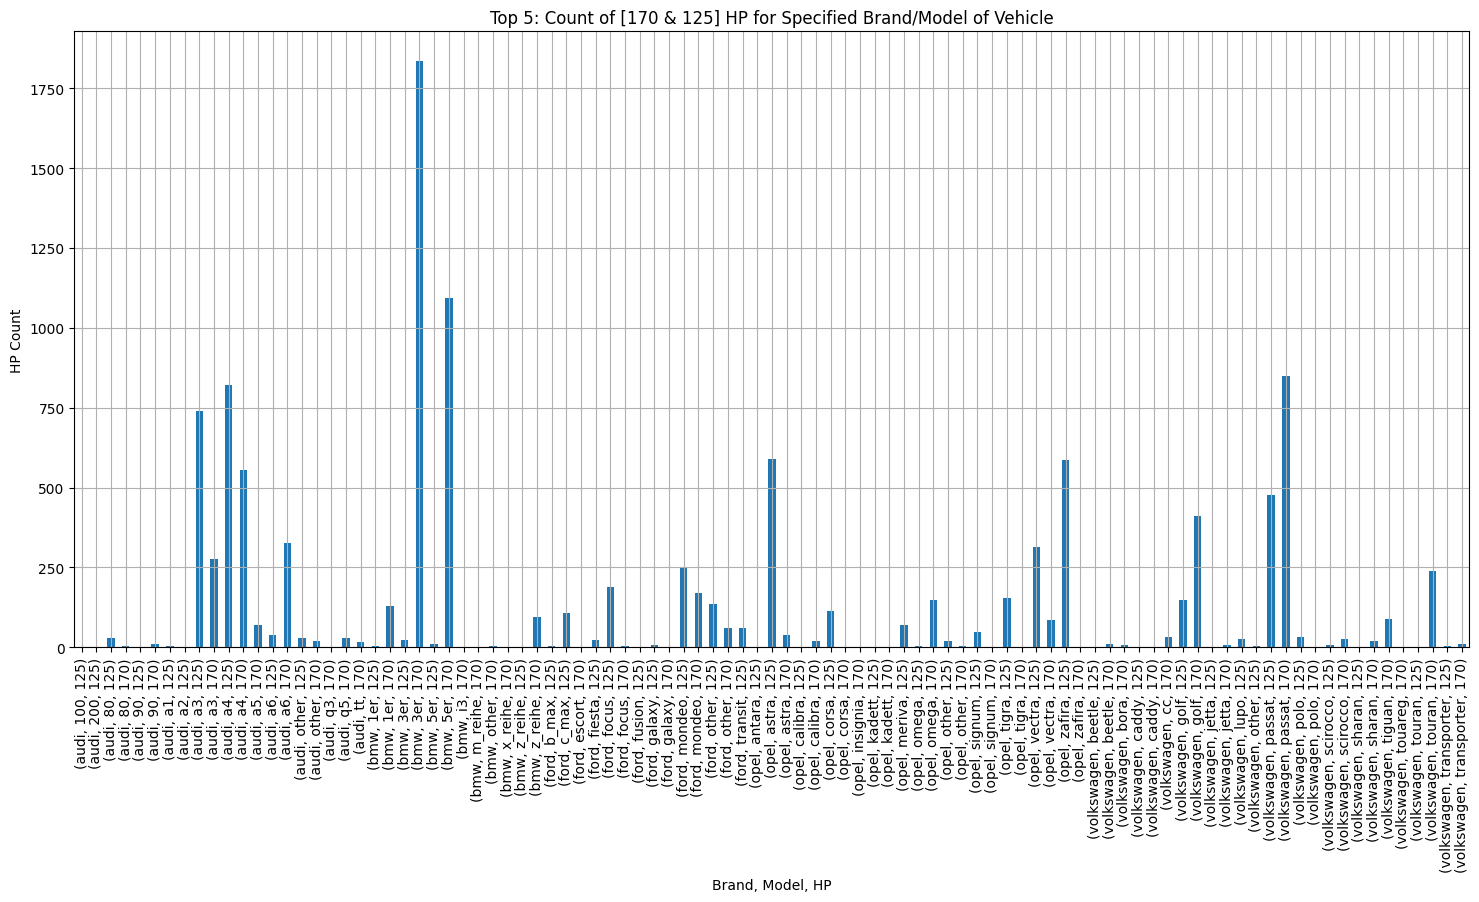

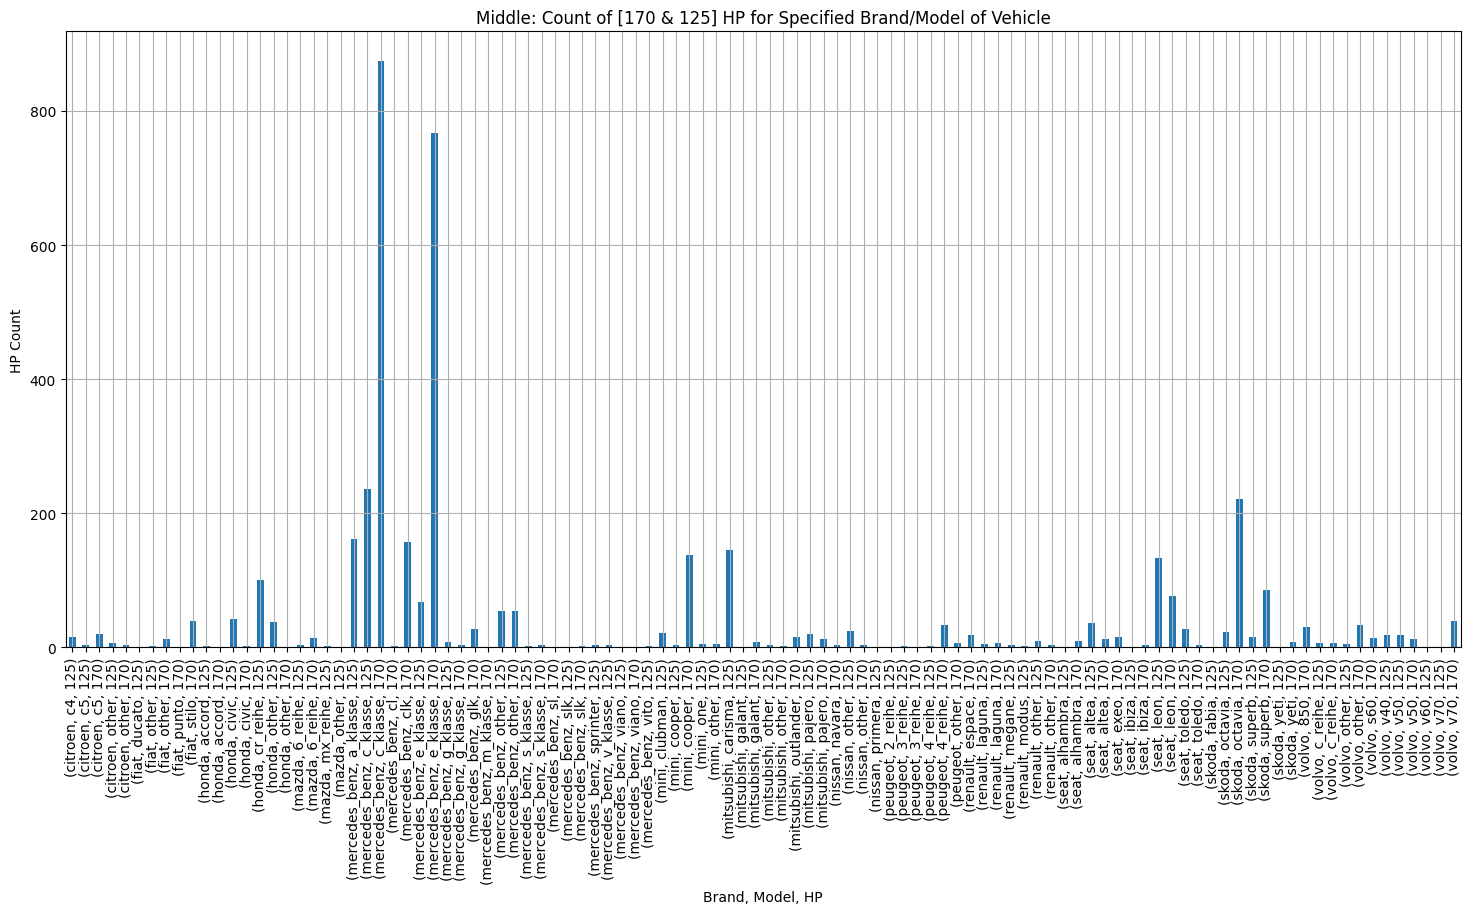

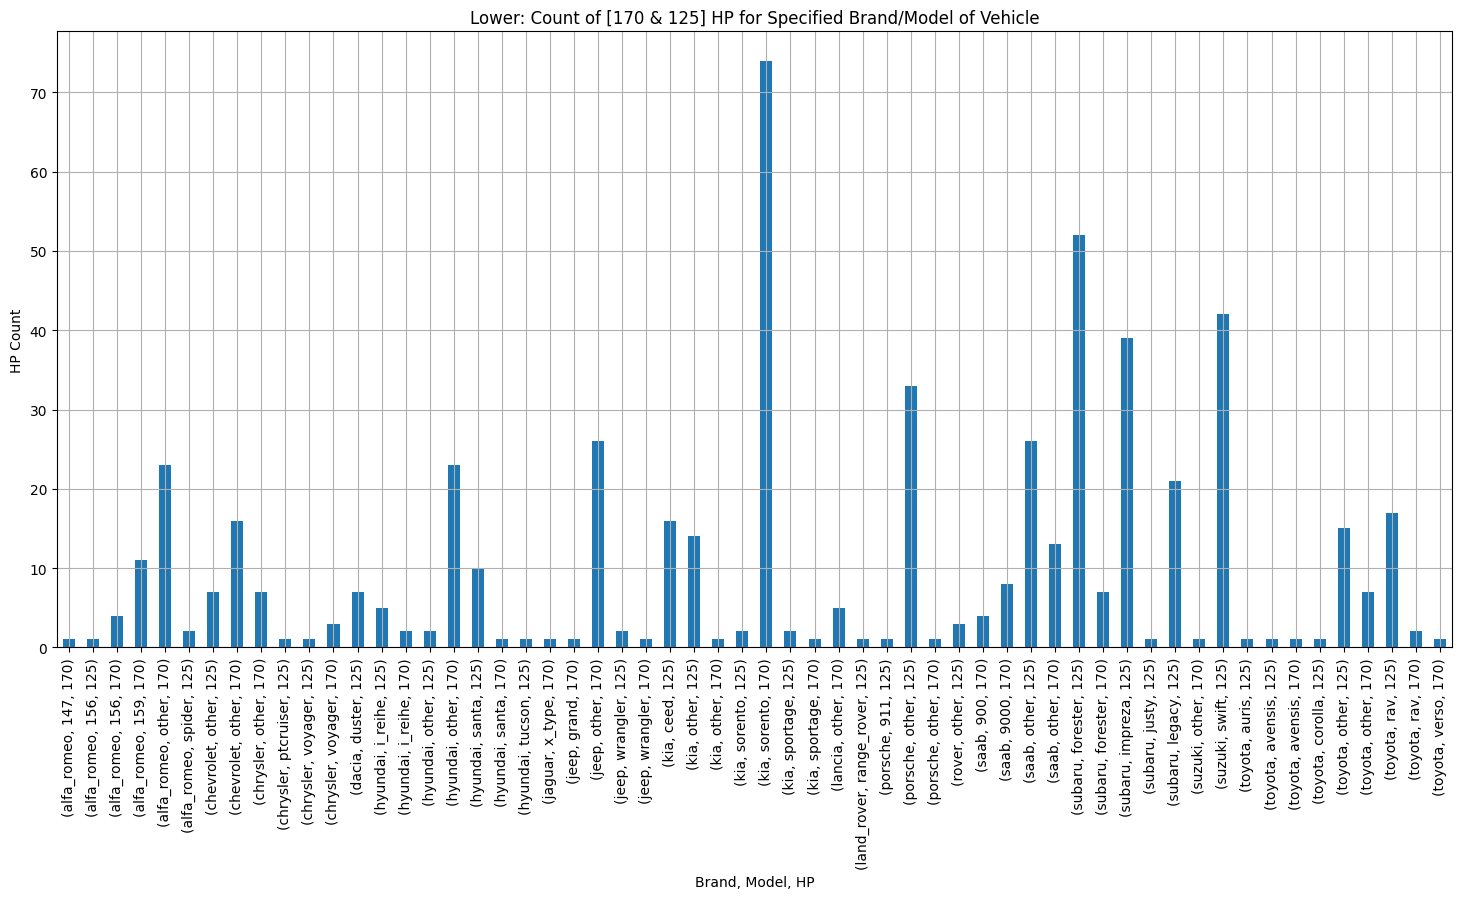

Batch 6: HP [136 & 102]


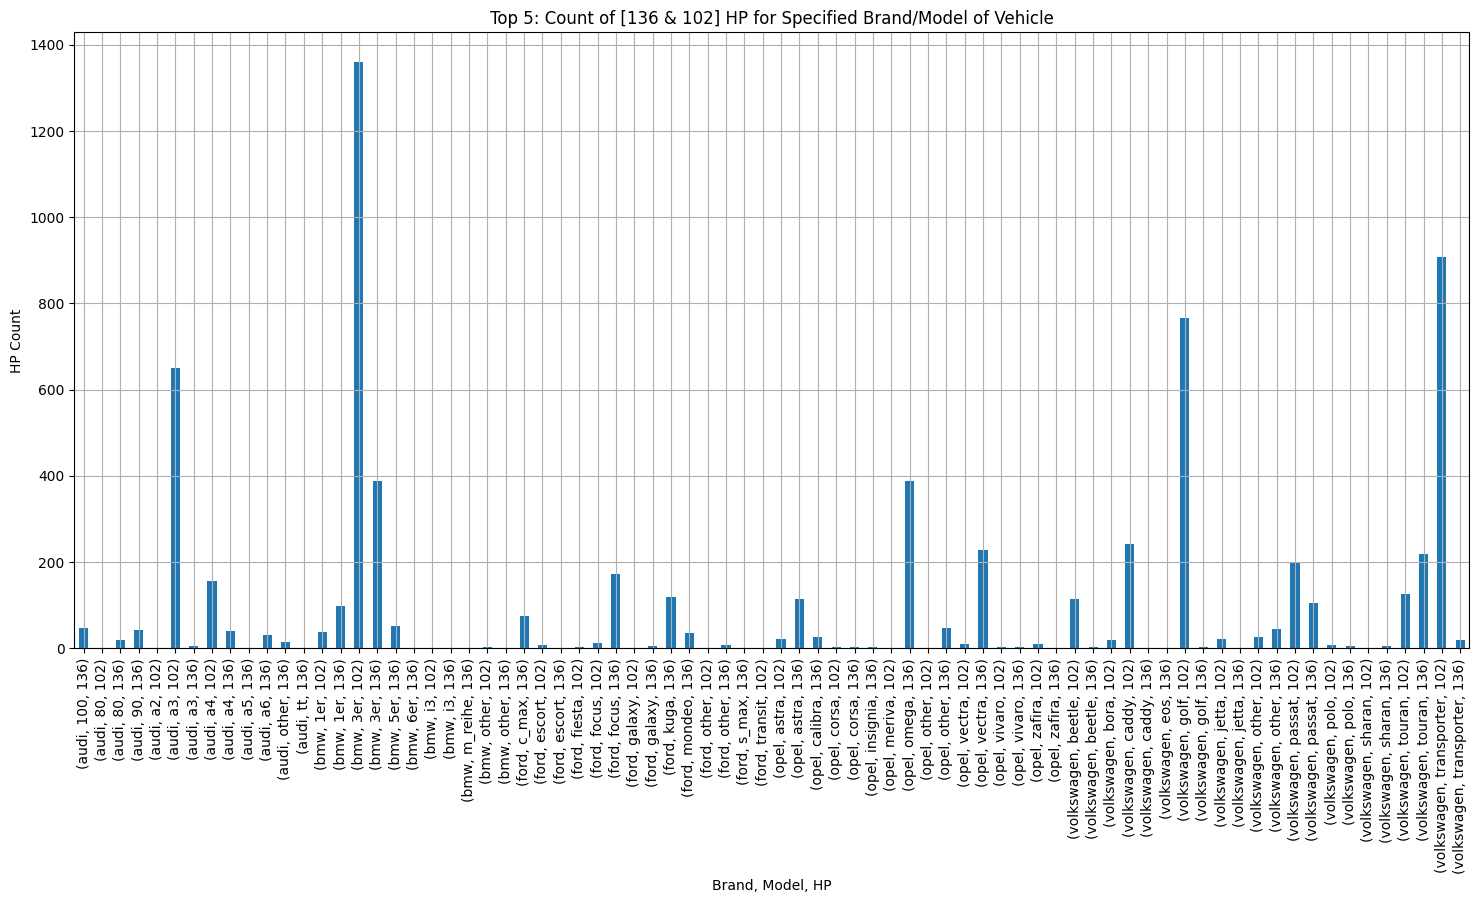

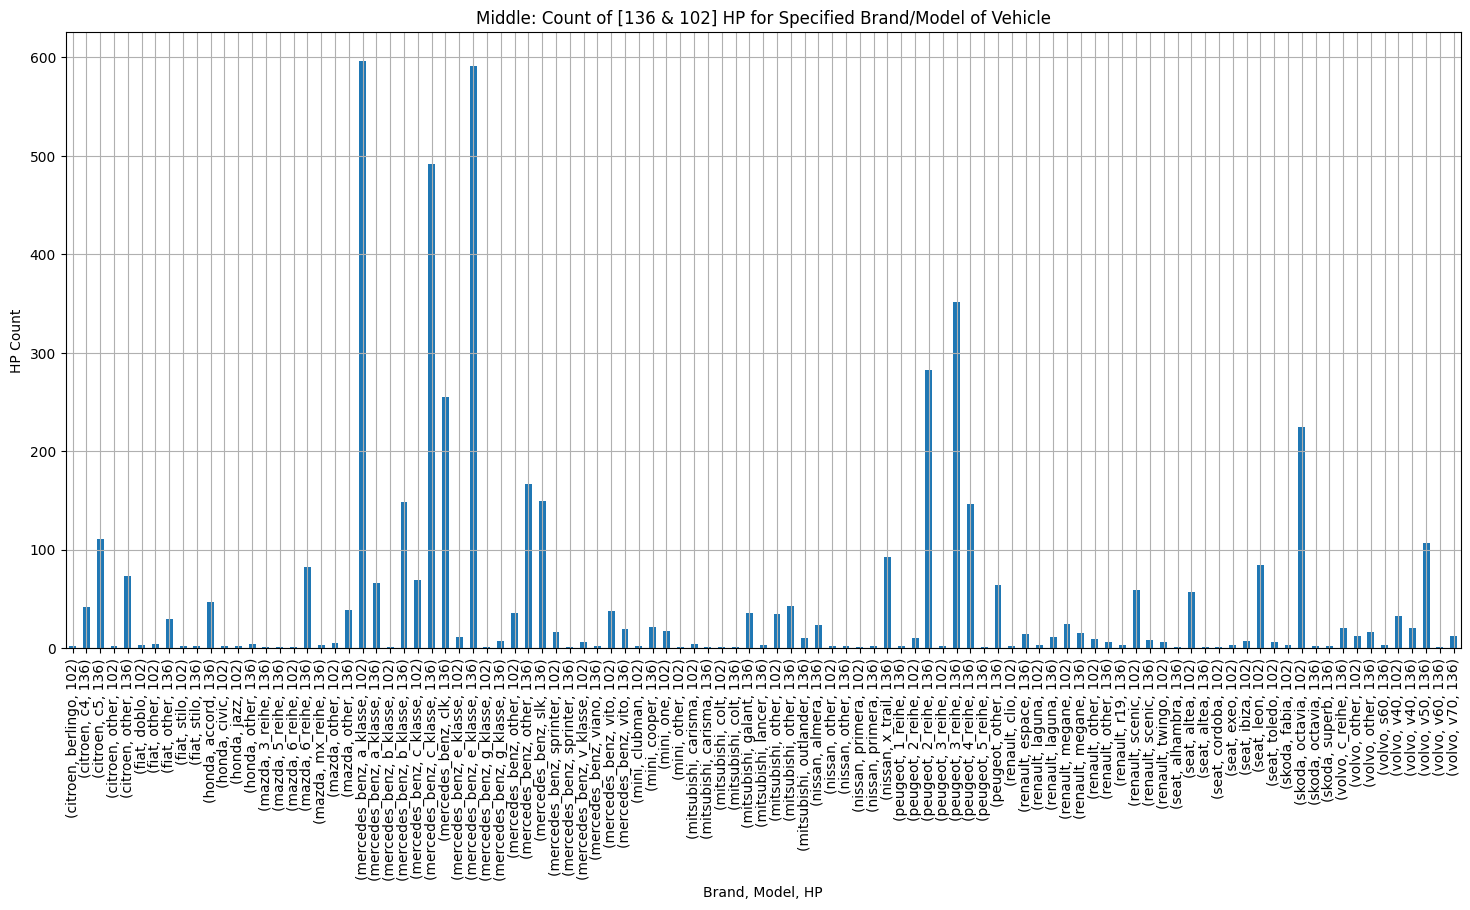

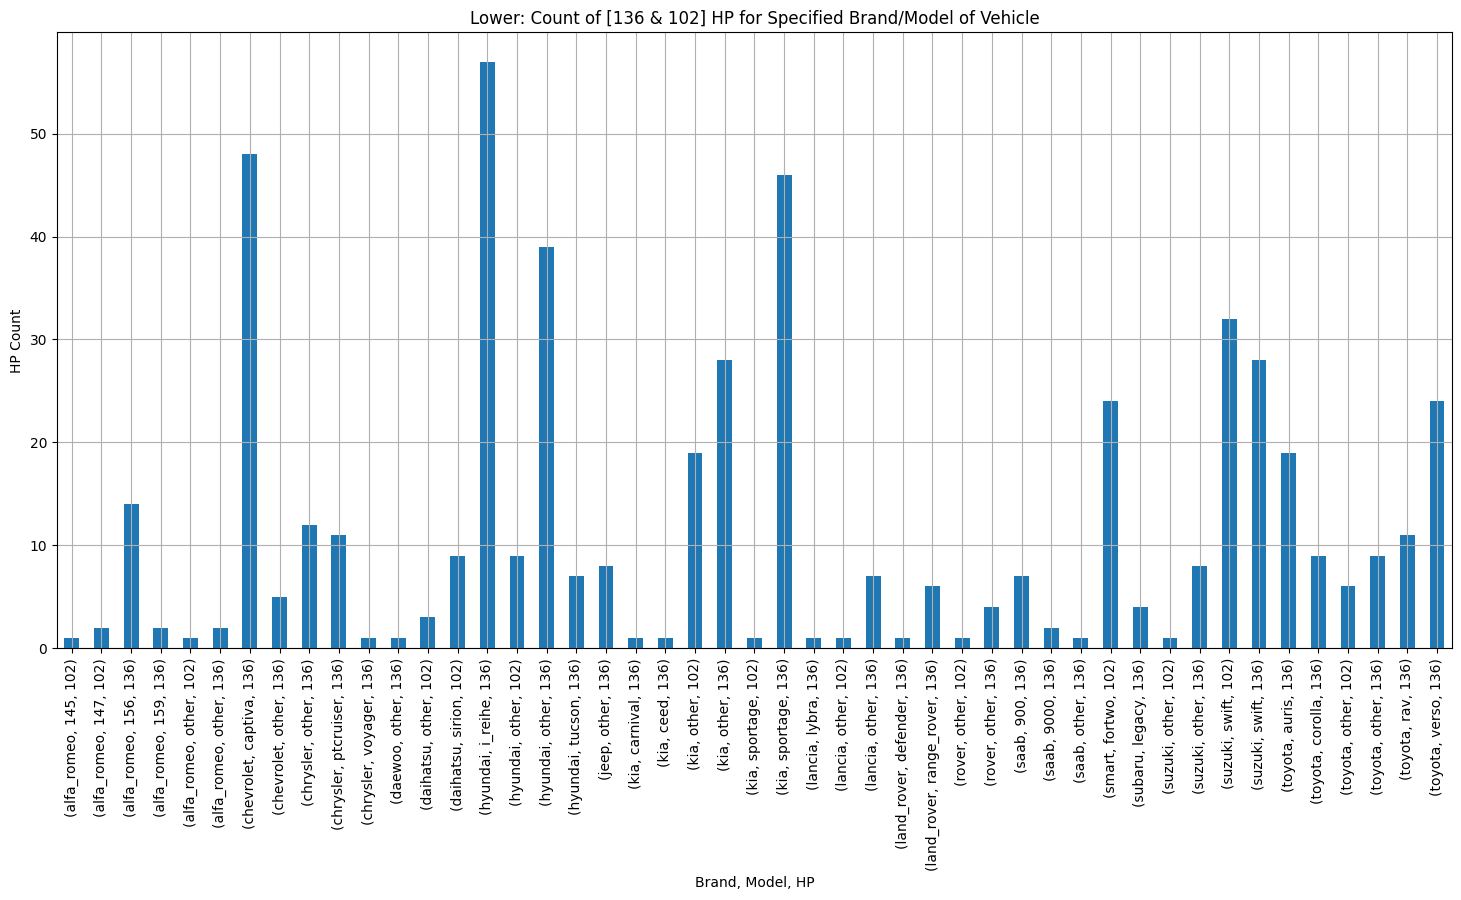

In [28]:
brand_power1 = df[(df['power'].isin([75,60])) & (df['model'].notna()) & (df['model'] != 'model') & \
    (df['brand'] != 'sonstige_autos')]
brand_power2 = df[(df['power'].isin([150,101])) & (df['model'].notna()) & (df['model'] != 'model') & \
    (df['brand'] != 'sonstige_autos')]
brand_power3 = df[(df['power'].isin([140,90])) & (df['model'].notna()) & (df['model'] != 'model') & \
    (df['brand'] != 'sonstige_autos')]
brand_power4 = df[(df['power'].isin([116,105])) & (df['model'].notna()) & (df['model'] != 'model') & \
    (df['brand'] != 'sonstige_autos')]
brand_power5 = df[(df['power'].isin([170,125])) & (df['model'].notna()) & (df['model'] != 'model') & \
    (df['brand'] != 'sonstige_autos')]
brand_power6 = df[(df['power'].isin([136,102])) & (df['model'].notna()) & (df['model'] != 'model') & \
    (df['brand'] != 'sonstige_autos')]

top5_brand_power = ['volkswagen','opel','bmw','audi','ford']
over1000_brand_power = ['mercedes_benz', 'renault', 'peugeot', 'seat', 'skoda', 'fiat', 'citroen', 'honda', 'mazda', 'mini', 'nissan', 'mitsubishi', 'volvo']  
under1000_brand_power = ['toyota', 'alfa_romeo', 'hyundai', 'kia', 'dacia', 'suzuki', 'chrysler', 'subaru', 'smart', 'chevrolet', 'saab', 'lancia', 
                        'rover', 'jeep', 'daihatsu', 'daewoo', 'porsche', 'lada', 'land_rover', 'jaguar'] 


top5_brands = brand_power1[brand_power1['brand'].isin(top5_brand_power)]
top5_brands2 = brand_power2[brand_power2['brand'].isin(top5_brand_power)]
top5_brands3 = brand_power3[brand_power3['brand'].isin(top5_brand_power)]
top5_brands4 = brand_power4[brand_power4['brand'].isin(top5_brand_power)]
top5_brands5 = brand_power5[brand_power5['brand'].isin(top5_brand_power)]
top5_brands6 = brand_power6[brand_power6['brand'].isin(top5_brand_power)]

middle_brands = brand_power1[brand_power1['brand'].isin(over1000_brand_power)]
middle_brands2 = brand_power2[brand_power2['brand'].isin(over1000_brand_power)]
middle_brands3 = brand_power3[brand_power3['brand'].isin(over1000_brand_power)]
middle_brands4 = brand_power4[brand_power4['brand'].isin(over1000_brand_power)]
middle_brands5 = brand_power5[brand_power5['brand'].isin(over1000_brand_power)]
middle_brands6 = brand_power6[brand_power6['brand'].isin(over1000_brand_power)]


lower_brands = brand_power1[brand_power1['brand'].isin(under1000_brand_power)]
lower_brands2 = brand_power2[brand_power2['brand'].isin(under1000_brand_power)]
lower_brands3 = brand_power3[brand_power3['brand'].isin(under1000_brand_power)]
lower_brands4 = brand_power4[brand_power4['brand'].isin(under1000_brand_power)]
lower_brands5 = brand_power5[brand_power5['brand'].isin(under1000_brand_power)]
lower_brands6 = brand_power6[brand_power6['brand'].isin(under1000_brand_power)]


# Use known model and power to find Nan
top5 = top5_brands[['brand','model','power']].value_counts().sort_index()
top52 = top5_brands2[['brand','model','power']].value_counts().sort_index()
top53 = top5_brands3[['brand','model','power']].value_counts().sort_index()
top54 = top5_brands4[['brand','model','power']].value_counts().sort_index()
top55 = top5_brands5[['brand','model','power']].value_counts().sort_index()
top56 = top5_brands6[['brand','model','power']].value_counts().sort_index()

middle = middle_brands[['brand','model','power']].value_counts().sort_index()
middle2 = middle_brands2[['brand','model','power']].value_counts().sort_index()
middle3 = middle_brands3[['brand','model','power']].value_counts().sort_index()
middle4 = middle_brands4[['brand','model','power']].value_counts().sort_index()
middle5 = middle_brands5[['brand','model','power']].value_counts().sort_index()
middle6 = middle_brands6[['brand','model','power']].value_counts().sort_index()


lower = lower_brands[['brand','model','power']].value_counts().sort_index()
lower2 = lower_brands2[['brand','model','power']].value_counts().sort_index()
lower3 = lower_brands3[['brand','model','power']].value_counts().sort_index()
lower4 = lower_brands4[['brand','model','power']].value_counts().sort_index()
lower5 = lower_brands5[['brand','model','power']].value_counts().sort_index()
lower6 = lower_brands6[['brand','model','power']].value_counts().sort_index()


print("Batch 1: HP [60 & 70]")
# Top 5 Prevalent Brands w/ specified HP [60 & 70]
top5.plot(kind = 'bar', x = ('brand','model','power'), figsize = (18,8))
plt.title('Top 5: Count of [60 & 70] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()

# Middle Prevalent Brands w/ specified HP [60 & 70]
middle.plot(kind = 'bar', x = ('brand','model','power'), figsize = (18,8))
plt.title('Middle: Count of [60 & 70] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()

# Lower Prevalent Brands w/ specified HP [60 & 70]
lower.plot(kind = 'bar', x = ('brand','model','power'), figsize = (18,8))
plt.title('Lower: Count of [60 & 70] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()


print("Batch 2: HP [150 & 101]")
# Batch 2: HP [150 & 101]
top52.plot(kind = 'bar', x = ('brand','model','power'), figsize = (18,8))
plt.title('Top 5: Count of [150 & 101] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()

middle2.plot(kind = 'bar', x = ('brand','model','power'), figsize = (18,8))
plt.title('Middle: Count of [150 & 101] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()

lower2.plot(kind = 'bar', x = ('brand','model','power'), figsize = (18,8))
plt.title('Lower: Count of [150 & 101] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()



print("Batch 3: HP [140 & 90]")
# Batch 3: HP [140 & 90]
top53.plot(kind = 'bar', x = ('brand','model','power'), figsize = (18,8))
plt.title('Top 5: Count of [140 & 90] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()

middle3.plot(kind = 'bar', x = ('brand','model','power'), figsize = (20,8))
plt.title('Middle: Count of [140 & 90] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()

lower3.plot(kind = 'bar', x = ('brand','model','power'), figsize = (18,8))
plt.title('Lower: Count of [140 & 90] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()



print("Batch 4: HP [116 & 105]")
# Batch 4: HP [116 & 105]
top54.plot(kind = 'bar', x = ('brand','model','power'), figsize = (18,8))
plt.title('Top 5: Count of [116 & 105] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()

middle4.plot(kind = 'bar', x = ('brand','model','power'), figsize = (18,8))
plt.title('Middle: Count of [116 & 105] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()

lower4.plot(kind = 'bar', x = ('brand','model','power'), figsize = (18,8))
plt.title('Lower: Count of [116 & 105] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()



print("Batch 5: HP [170 & 125]")
# Batch 5: HP [170 & 125]
top55.plot(kind = 'bar', x = ('brand','model','power'), figsize = (18,8))
plt.title('Top 5: Count of [170 & 125] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()

middle5.plot(kind = 'bar', x = ('brand','model','power'), figsize = (18,8))
plt.title('Middle: Count of [170 & 125] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()

lower5.plot(kind = 'bar', x = ('brand','model','power'), figsize = (18,8))
plt.title('Lower: Count of [170 & 125] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()



print("Batch 6: HP [136 & 102]")
# Batch 6: HP [136 & 102]
top56.plot(kind = 'bar', x = ('brand','model','power'), figsize = (18,8))
plt.title('Top 5: Count of [136 & 102] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()

middle6.plot(kind = 'bar', x = ('brand','model','power'), figsize = (18,8))
plt.title('Middle: Count of [136 & 102] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()

lower6.plot(kind = 'bar', x = ('brand','model','power'), figsize = (18,8))
plt.title('Lower: Count of [136 & 102] HP for Specified Brand/Model of Vehicle')
plt.xlabel("Brand, Model, HP")
plt.ylabel("HP Count")
plt.xticks(rotation = 90)
plt.grid()
plt.show()

In [29]:
display(df[(df['brand'].isin(['audi'])) & (df['power'].isin([75])) & (df['vehicletype'] == 'small')  & (df['model'].notna())].value_counts(subset = 'model'))
display(df[(df['brand'].isin(['opel'])) & (df['vehicletype'] != 'small') & (df['power'].isin([60])) & (df['registrationyear'] > 1991) & (df['registrationyear'] < 1993)].value_counts(subset = 'model'))
display(df[(df['brand'].isin(['mini'])) & (df['power'].isin([75])) & (df['model'].notna())].value_counts(subset = 'model'))
display(df[(df['brand'].isin(['seat'])) & (df['registrationyear'] > 2002) & (df['registrationyear'] < 2012) & (df['power'].isin([75]))& (df['model'].notna())].value_counts(subset = 'model'))
display(df[(df['brand'].isin(['skoda'])) & (df['registrationyear'] > 2000) & (df['registrationyear'] != 2013) & (df['power'].isin([75]))& (df['model'].notna())].value_counts(subset = 'model'))
display(df[(df['brand'].isin(['smart']))  & (df['power'].isin([60]))& (df['model'].notna())].value_counts(subset = 'model'))
display(df[(df['brand'].isin(['bmw'])) & (df['power'].isin([101])) & (df['model'].notna())].value_counts(subset = 'model'))
display(df[(df['brand'].isin(['mitsubishi'])) & (df['vehicletype'] == 'sedan') & (df['registrationyear'] == 1999) & (df['power'].isin([150])) & (df['model'].notna())].value_counts(subset = 'model'))
display(df[(df['brand'].isin(['mitsubishi'])) & (df['vehicletype'] == 'bus') & (df['power'].isin([150])) & (df['model'].notna())].value_counts(subset = 'model'))
display(df[(df['brand'].isin(['honda'])) & (df['power'].isin([101])) & (df['model'].notna())].value_counts(subset = 'model'))

model
a2    210
a3      2
dtype: int64

model
astra    4
dtype: int64

model
one       118
cooper      3
other       1
dtype: int64

model
ibiza      322
cordoba     13
altea        1
dtype: int64

model
fabia       479
citigo       16
octavia       9
other         3
roomster      2
dtype: int64

model
fortwo      47
forfour      2
other        2
roadster     1
dtype: int64

model
3er        212
1er          5
other        4
m_reihe      1
dtype: int64

model
galant    10
dtype: int64

model
other    32
dtype: int64

model
civic    31
jazz      2
dtype: int64

In [30]:
audi75 = (df['brand'].isin(['audi'])) & (df['power'].isin([75])) & (df['vehicletype'] == 'small') & (df['model'].isna())
df.loc[audi75,['model']] = 'a2'

opelastra = (df['brand'].isin(['opel'])) & (df['vehicletype'] != 'small') & (df['power'].isin([60])) & (df['registrationyear'] > 1991) & (df['registrationyear'] < 1993)& (df['model'].isna())
df.loc[opelastra,['model']] = 'astra'


mini75 = (df['brand'].isin(['mini'])) & (df['power'].isin([75])) & (df['model'].isna())
df.loc[mini75,['model']] = 'one'

nissan60 = (df['brand'].isin(['nissan'])) & (df['power'].isin([60])) & (df['model'].isna())
df.loc[nissan60,['model']] = 'micra'

ibiza03 = (df['brand'].isin(['seat'])) & (df['registrationyear'] > 2002) & (df['registrationyear'] < 2012) & (df['power'].isin([75])) & (df['model'].isna())
df.loc[ibiza03,['model']] = 'ibiza'

skoda60 = (df['brand'].isin(['skoda'])) & (df['registrationyear'] > 2000) & (df['registrationyear'] != 2013) & (df['power'].isin([75])) & (df['model'].isna())
df.loc[skoda60,['model']] = 'fabia'

lancia60 = (df['brand'].isin(['lancia'])) & (df['power'].isin([60])) & (df['model'].isna())
df.loc[lancia60,['model']] = 'ypsilon'

smart60 = (df['brand'].isin(['smart']))  & (df['power'].isin([60])) & (df['model'].isna())
df.loc[smart60,['model']] = 'fortwo'

bmw101 = (df['brand'].isin(['bmw'])) & (df['power'].isin([101])) & (df['model'].isna())
df.loc[bmw101,['model']] = '3er'

mit99 = (df['brand'].isin(['mitsubishi'])) & (df['vehicletype'] == 'sedan') & (df['registrationyear'] == 1999) & (df['power'].isin([150])) & (df['model'].isna())
df.loc[mit99,['model']] = 'galant'

mitbus00 = (df['brand'].isin(['mitsubishi'])) & (df['vehicletype'] == 'bus') & (df['power'].isin([150])) & (df['model'].isna())
df.loc[mitbus00,['model']] = 'other'

honda101 = (df['brand'].isin(['honda'])) & (df['power'].isin([101])) & (df['model'].isna())
df.loc[honda101,['model']] = 'civic' 



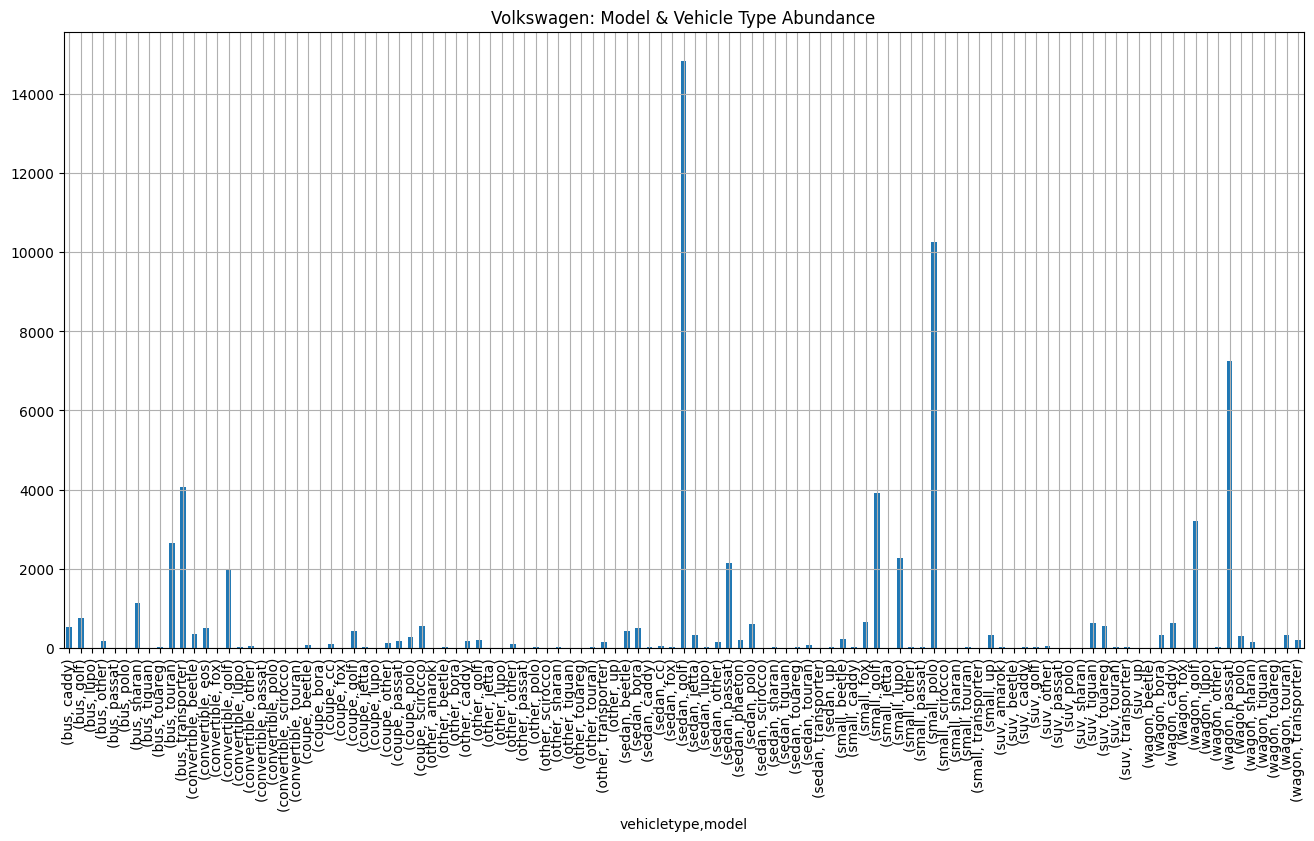

In [31]:
topbrand_vt = ['volkswagen']
vt_power = df[(df['brand'].notna()) & (df['brand'].isin(topbrand_vt)) & (df['model'].notna()) & (df['vehicletype'].notna())]

vwvt = vt_power[['vehicletype','model']].value_counts().sort_index()

vwvt.plot(kind = 'bar', figsize = (16,8))
plt.title("Volkswagen: Model & Vehicle Type Abundance")
plt.grid()
plt.show()


In [32]:
# VW GOLF

golf = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'sedan') & (df['power'].isin([211,230,174,102, 122, 350, 250, 170, 86, 200,100,109,190,68,80,72,131,144,129,77,160,76,204])) & (df['model'].isna())
df.loc[golf,['model']] = 'golf'

golf02 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'sedan') & (df['power'].isin([90])) & (df['registrationyear'] > 2002) & (df['model'].isna())
df.loc[golf02,['model']] = 'golf'

golf98 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'sedan') & (df['power'].isin([60])) & (df['registrationyear'] < 1998) & (df['model'].isna())
df.loc[golf98,['model']] = 'golf'

golf09 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'sedan') & (df['power'].isin([125,110])) & (df['registrationyear'] == 2009) & (df['model'].isna())
df.loc[golf09,['model']] = 'golf'

golf99 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'sedan') & (df['power'].isin([150])) & (df['registrationyear'] > 1999) & (df['model'].isna())
df.loc[golf99,['model']] = 'golf'

golf04 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'sedan') & (df['power'].isin([140])) & (df['registrationyear'] == 2004) & (df['model'].isna())
df.loc[golf04,['model']] = 'golf'

golf91 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'sedan') & (df['power'].isin([55])) & (df['registrationyear'] != 1991) & (df['model'].isna())
df.loc[golf91,['model']] = 'golf'



# VW POLO

polo = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'sedan') & (df['power'].isin([64,54])) & (df['model'].isna())
df.loc[polo,['model']] = 'polo'

polo98 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'sedan') & (df['power'].isin([60])) & (df['registrationyear'] > 1998) & (df['model'].isna())
df.loc[polo98,['model']] = 'polo'



# VW PASSAT 

passat = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'sedan') & (df['power'].isin([148,136])) & (df['model'].isna())
df.loc[passat,['model']] = 'passat'

passat97 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'sedan') & (df['power'].isin([125])) & (df['registrationyear'] == 1997) & (df['model'].isna())
df.loc[passat97,['model']] = 'passat'



### VW BEETLE

beetle = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'sedan') & (df['power'].isin([30])) & (df['model'].isna())
df.loc[beetle,['model']] = 'beetle'



#### VW JETTA

jetta = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'sedan') & (df['power'].isin([70])) & (df['registrationyear'] == 1981) & (df['model'].isna())
df.loc[jetta,['model']] = 'jetta'



### VW PHAETON

phaeton = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'sedan') & (df['power'].isin([313,420,240])) & (df['model'].isna())
df.loc[phaeton,['model']] = 'phaeton'

phaeton05 = (df['brand'] == 'volkswagen') & (df['vehicletype'] == 'sedan') & (df['registrationyear'] == 2005) & (df['power'].isin([224])) & (df['model'].isna())
df.loc[phaeton05,['model']] = 'phaeton'


### Wagon

trabant = (df['vehicletype'] == 'wagon') & (df['brand'] == 'trabant') & (df['model'].isna())
df.loc[trabant,['model']] = '601'

bmw = (df['vehicletype'] == 'wagon') & (df['registrationyear'] < 1990) & (df['brand'] == 'bmw') & (df['model'].isna())
df.loc[bmw,['model']] = '3er'

vw80 = (df['vehicletype'] == 'wagon') & (df['registrationyear'] < 1990) & (df['brand'] == 'volkswagen') & (df['model'].isna())
df.loc[vw80,['model']] = 'passat'


opel82 = (df['vehicletype'] == 'wagon') & (df['registrationyear'] == 1982) & (df['brand'] == 'opel') & (df['model'].isna())
df.loc[opel82,['model']] = 'kadett'

other82 = (df['vehicletype'] == 'wagon') & (df['registrationyear'] < 1988) & (df['brand'] != 'sonstige_autos') & (df['model'].isna())
df.loc[other82,['model']] = 'other'

volvo89 = (df['vehicletype'] == 'wagon') & (df['registrationyear'] == 1989) & (df['brand'] == 'volvo') & (df['model'].isna())
df.loc[volvo89,['model']] = 'other'

audi100 = (df['vehicletype'] == 'wagon') & (df['registrationyear'] == 1990) & (df['brand'] == 'audi') & (df['model'].isna())
df.loc[audi100,['model']] = '100'

### HP specific

freelander = (df['brand'] == 'land_rover') & (df['vehicletype'].isin(['suv'])) & (df['power'].isin([111,115,60,129,140,109,])) & (df['registrationyear'] > 1992) & (df['registrationyear'] < 2006) & (df['model'].isna())
df.loc[freelander,['model']] = 'freelander'

ypsilon = (df['brand'] == 'lancia') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([44,70,74,75,602,1200])) & (df['model'].isna())
df.loc[ypsilon,['model']] = 'ypsilon'

logan = (df['brand'] == 'dacia') & (df['vehicletype'].isin(['wagon'])) & (df['power'].isin([75,84,85,105])) & (df['registrationyear'].isin([2009,2012,2013,2015])) & (df['model'].isna())
df.loc[logan,['model']] = 'logan'

porscheother = (df['brand'] == 'porsche') & (df['vehicletype'] == 'coupe') & (df['power'].isin([125,160])) & (df['registrationyear'].isin([1981,1989])) & (df['model'].isna())
df.loc[porscheother,['model']] = 'other'

justy = (df['brand'] == 'subaru') & (df['vehicletype'] == 'small') & (df['power'].isin([25,34,50,60,68])) & (df['registrationyear'].isin([1996,1997,2000])) & (df['model'].isna())
df.loc[justy,['model']] = 'justy'

otherrover = (df['brand'] == 'rover') & (df['vehicletype'] == 'sedan') & (df['power'].isin([75,100,111,120,150,16,77,85,105,16,77,85,105,108,116,130,174])) & (df['registrationyear'].isin([1996,1997,1998,1999,2000,2001,2002,2003])) & (df['model'].notna())
df.loc[otherrover,['model']] = 'other'

chryslerother = (df['brand'] == 'chrysler') & (df['vehicletype'] == 'sedan') & (df['power'].isin([133,254,250,85,100,109,122,137,186])) & (df['registrationyear'].isin([1952,1977,1996,1998,1999,2000,2002,2008,2010])) & (df['model'].isna())
df.loc[chryslerother,['model']] = 'other'

voyager = (df['brand'] == 'chrysler') & (df['vehicletype'] == 'bus') & (df['power'].isin([151])) & (df['registrationyear'].isin([1996,1997,1999])) & (df['model'].isna())
df.loc[voyager,['model']] = 'voyager'


t601 = (df['brand'] == 'trabant') & (df['vehicletype'] == 'sedan') & (df['power'].isin([26,45])) & (df['registrationyear'].isin([1982,1988,1989,1977,1986,1984,1998])) & (df['model'].isna())
df.loc[t601,['model']] = '601'

six = (df['brand'] == 'trabant') & (df['vehicletype'].isin(['small','coupe'])) & (df['power'].isin([60,26,75])) & (df['registrationyear'].isin([1988,1998,2004,2008])) & (df['model'].isna())
df.loc[six,['model']] = '601'

otherchevy = (df['brand'] == 'chevrolet') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([64,141,75,94,95,54,109,125,195,163,130,105,124,72,69,60,360])) & (df['registrationyear'].isin([2011,2005,1968,1978,2000,2006,2010,2012])) & (df['model'].isna())
df.loc[otherchevy,['model']] = 'other'

volvoother = (df['brand'] == 'volvo') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([115,131,52,105,113,116])) & (df['registrationyear'].isin([1996,1991,1993,2007,1985,1988,1998,1999,2004,2012])) & (df['model'].isna())
df.loc[volvoother,['model']] = 'other'

kother = (df['brand'] == 'kia') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([105,138,140,48,101,113,133,143,203])) & (df['registrationyear'].isin([2005,2007,2001,2002,2003,2004])) & (df['model'].isna())
df.loc[kother,['model']] = 'other'

rio = (df['brand'] == 'kia') & (df['vehicletype'].isin(['wagon'])) & (df['power'].isin([97,109,83,98,105,125,138,139,150])) & (df['registrationyear'].isin([2003,2000,2007,1999,2001,2002])) & (df['model'].isna())
df.loc[rio,['model']] = 'rio'

sorento = (df['brand'] == 'kia') & (df['vehicletype'].isin(['suv'])) & (df['power'].isin([140,78,110,133,194])) & (df['registrationyear'].isin([2006,2001,2004,1995,1999,2012])) & (df['model'].isna())
df.loc[sorento,['model']] = 'sorento'

civic = (df['brand'] == 'honda') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([90,124,125])) & (df['registrationyear'].isin([1992,1991,1993])) & (df['model'].isna())
df.loc[civic,['model']] = 'civic'

jazz = (df['brand'] == 'honda') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([90])) & (df['registrationyear'].isin([2010])) & (df['model'].isna())
df.loc[jazz,['model']] = 'jazz'

hother = (df['brand'] == 'honda') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([65])) & (df['registrationyear'].isin([1999])) & (df['model'].isna())
df.loc[hother,['model']] = 'other'

civcou = (df['brand'] == 'honda') & (df['vehicletype'].isin(['coupe'])) & (df['power'].isin([90,114,100,105,107,109])) & (df['registrationyear'].isin([2000,1995,1996,1998,1989,1999,2006])) & (df['model'].isna())
df.loc[civcou,['model']] = 'civic'

honother = (df['brand'] == 'honda') & (df['vehicletype'].isin(['coupe'])) & (df['power'].isin([133,185])) & (df['registrationyear'].isin([2000,1992,1998])) & (df['model'].isna())

cother = (df['brand'] == 'honda') & (df['vehicletype'].isin(['coupe'])) & (df['power'].isin([133])) & (df['registrationyear'].isin([2000,1992,1998,])) & (df['model'].isna())
df.loc[cother,['model']] = 'other'

jbus = (df['brand'] == 'honda') & (df['vehicletype'].isin(['bus'])) & (df['power'].isin([90])) & (df['registrationyear'].isin([2010,2012,2013])) & (df['model'].isna())
df.loc[jbus,['model']] = 'jazz'

octavia = (df['brand'] == 'skoda') & (df['price'] > 2099) & (df['price'] < 5701) & (df['vehicletype'].isin(['wagon'])) & (df['power'].isin([102,105,150])) & (df['registrationyear'].isin([2001,2005,2007,2008])) & (df['model'].isna())
df.loc[octavia,['model']] = octavia

swift = (df['brand'] == 'suzuki') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([53,50,55,58,92])) & (df['registrationyear'].isin([1997,2000,1998,2003,2008])) & (df['model'].isna())
df.loc[swift,['model']] = 'swift'

suzother = (df['brand'] == 'suzuki') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([63,52,65,76,83,84,57,96])) & (df['registrationyear'].isin([1990, 1995,1996,1999,2002,1997,2001,2004,2007])) & (df['model'].isna())
df.loc[suzother,['model']] = 'other'

ukiother = (df['brand'] == 'suzuki') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([68])) & (df['registrationyear'].isin([2009,2011,2012])) & (df['model'].isna())
df.loc[ukiother,['model']] = 'other'

jimny = (df['brand'] == 'suzuki') & (df['vehicletype'].isin(['suv'])) & (df['power'].isin([86,82,88])) & (df['registrationyear'].isin([2001,2005,2003])) & (df['model'].isna())
df.loc[jimny,['model']] = 'jimny'

zother = (df['brand'] == 'suzuki') & (df['vehicletype'].isin(['suv'])) & (df['power'].isin([97,45,68,75,85,98,136,170])) & (df['registrationyear'].isin([1995,1996,1988,1992,1998,2006,2007])) & (df['model'].isna())
df.loc[zother,['model']] = 'other'

carisma = (df['brand'] == 'mitsubishi') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([125,115])) & (df['registrationyear'].isin([2002,1995,1998,1997,2000,2003])) & (df['model'].isna())
df.loc[carisma,['model']] = 'carisma'

colt = (df['brand'] == 'mitsubishi') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([75,90,95])) & (df['registrationyear'].isin([2002,2009,2000,2006])) & (df['model'].isna())
df.loc[colt,['model']] = 'colt'

coltt = (df['brand'] == 'mitsubishi') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([75,70,95,82,150])) & (df['registrationyear'].isin([1999,1996,1998,2006,2009,1997,2000,2002,2010,2012,2001])) & (df['model'].isna())
df.loc[coltt,['model']] = 'colt'


lancer = (df['brand'] == 'mitsubishi') & (df['vehicletype'].isin(['wagon'])) & (df['power'].isin([98])) & (df['registrationyear'].isin([1999,2000,2001,2003,2004,1997,2007])) & (df['model'].isna())
df.loc[lancer,['model']] = 'lancer'

galant = (df['brand'] == 'mitsubishi') & (df['vehicletype'].isin(['wagon'])) & (df['power'].isin([160,165])) & (df['registrationyear'].isin([1999,2000,2001,2003,2004,1997,2007])) & (df['model'].isna())
df.loc[galant,['model']] = 'galant'

wother = (df['brand'] == 'mitsubishi') & (df['vehicletype'].isin(['wagon'])) & (df['power'].isin([82,86,83,101,132,125])) & (df['registrationyear'].isin([1999,2000,2001,2003,2004])) & (df['model'].isna())
df.loc[wother,['model']] = 'other'

yaris = (df['brand'] == 'toyota') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([75,86,90,87])) & (df['registrationyear'].isin([2008,2000,2001,2002])) & (df['model'].isna())
df.loc[yaris,['model']] = 'yaris'

aygo = (df['brand'] == 'toyota') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([68])) & (df['registrationyear'].isin([2008,2006,2009])) & (df['model'].isna())
df.loc[aygo,['model']] = 'aygo'

yar = (df['brand'] == 'toyota') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([68])) & (df['registrationyear'].isin([1999,2001])) & (df['model'].isna())
df.loc[yar,['model']] = 'yaris'

cor = (df['brand'] == 'toyota') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([97])) & (df['registrationyear'].isin([2003,2000,2001])) & (df['model'].isna())
df.loc[cor,['model']] = 'corolla'

corolla = (df['brand'] == 'toyota') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([86])) & (df['registrationyear'].isin([1998])) & (df['model'].isna())
df.loc[corolla,['model']] = 'corolla'

sixty = (df['brand'] == 'toyota') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([60])) & (df['registrationyear'].isin([1997])) & (df['model'].isna())
df.loc[sixty,['model']] = 'other'

tother = (df['brand'] == 'toyota') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([75])) & (df['registrationyear'].isin([1993,1995,1997])) & (df['model'].isna())
df.loc[tother,['model']] = 'other'

coro = (df['brand'] == 'toyota') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([75,88,90,110])) & (df['registrationyear'].isin([1993,2006,1995,2008])) & (df['model'].isna())
df.loc[coro,['model']] = 'corolla'

auris = (df['brand'] == 'toyota') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([177,124,126])) & (df['registrationyear'].isin([2007,2010])) & (df['model'].isna())
df.loc[auris,['model']] = 'auris'

llo = (df['brand'] == 'toyota') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([72,97,105])) & (df['registrationyear'].isin([1992,2003])) & (df['model'].isna())
df.loc[llo,['model']] = 'corolla'

avensis = (df['brand'] == 'toyota') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([177])) & (df['model'].isna())
df.loc[avensis,['model']] = 'avensis'

sedoy = (df['brand'] == 'toyota') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([63,91,180])) & (df['registrationyear'].isin([1993,1998,2009])) & (df['model'].isna())
df.loc[sedoy,['model']] = 'other'

yar = (df['brand'] == 'toyota') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([68])) & (df['registrationyear'].isin([1999])) & (df['model'].isna())
df.loc[yar,['model']] = 'yaris'

micra = (df['brand'] == 'nissan') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([54,65,50,55,40])) & (df['registrationyear'].isin([1994,2009,1998,1995,1999,2000,2004,1991,1996,1997,2008,2013])) & (df['model'].isna())
df.loc[micra,['model']] = 'micra'

micraa = (df['brand'] == 'nissan') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([65,80])) & (df['registrationyear'].isin([2003,2014])) & (df['model'].isna())
df.loc[micraa,['model']] = 'micra'

micraaa = (df['brand'] == 'nissan') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([98])) & (df['registrationyear'].isin([2013])) & (df['model'].isna())
df.loc[micraaa,['model']] = 'micra'

qashqai = (df['brand'] == 'nissan') & (df['vehicletype'].isin(['suv'])) & (df['power'].isin([150])) & (df['registrationyear'].isin([2011])) & (df['model'].isna())
df.loc[qashqai,['model']] = 'qashqai'

ibiza = (df['brand'] == 'seat') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([75,64,86,69,70,85])) & (df['registrationyear'].isin([2002,2001,2003,2011,2007])) & (df['model'].isna())
df.loc[ibiza,['model']] = 'ibiza'

arosa = (df['brand'] == 'seat') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([50])) & (df['registrationyear'].isin([1999,2002,1998,2000,2001,1997])) & (df['model'].isna())
df.loc[arosa,['model']] = 'arosa'

ibizaa = (df['brand'] == 'seat') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([86,101,69])) & (df['registrationyear'].isin([2006,2012,2013])) & (df['model'].isna())
df.loc[ibizaa,['model']] = 'ibiza'

ibiza1 = (df['brand'] == 'seat') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([200,51])) & (df['registrationyear'].isin([2009])) & (df['model'].isna())
df.loc[ibiza1,['model']] = 'ibiza'

other1 = (df['brand'] == 'seat') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([25])) & (df['model'].isna())
df.loc[other1,['model']] = 'other'

cordoba75 = (df['brand'] == 'seat') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([75])) & (df['registrationyear'].isin([1996,1998])) & (df['model'].isna())
df.loc[cordoba75,['model']] = 'cordoba'

leon07 = (df['brand'] == 'seat') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([105])) & (df['registrationyear'].isin([2007])) & (df['model'].isna())
df.loc[leon07,['model']] = 'leon'

leon160 = (df['brand'] == 'seat') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([102,160,265])) & (df['registrationyear'].isin([2007,2008,2009,2012])) & (df['model'].isna())
df.loc[leon160,['model']] = 'leon'

toledo = (df['brand'] == 'seat') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([101,150])) & (df['registrationyear'].isin([1998,1999])) & (df['model'].isna())
df.loc[toledo,['model']] = 'toledo'

leon140 = (df['brand'] == 'seat') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([140])) & (df['registrationyear'].isin([2006])) & (df['model'].isna())
df.loc[leon140,['model']] = 'leon'

toledo150 = (df['brand'] == 'seat') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([150])) & (df['registrationyear'].isin([2000])) & (df['model'].isna())
df.loc[toledo150,['model']] = 'toledo'

ibiza09 = (df['brand'] == 'seat') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([86])) & (df['registrationyear'].isin([2009])) & (df['model'].isna())
df.loc[ibiza09,['model']] = 'ibiza'

ibiza07 = (df['brand'] == 'seat') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([64])) & (df['model'].isna())
df.loc[ibiza07,['model']] = 'ibiza'

getz = (df['brand'] == 'hyundai') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([55,82,88,97])) & (df['registrationyear'].isin([2003,2007,2002])) & (df['model'].isna())
df.loc[getz,['model']] = 'getz'

i_reihe = (df['brand'] == 'hyundai') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([68,77,78])) & (df['registrationyear'].isin([2010,2009,2011,2007])) & (df['model'].isna())
df.loc[i_reihe,['model']] = 'i_reihe'

getz03 = (df['brand'] == 'hyundai') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([55,63,67,65,90])) & (df['registrationyear'].isin([2003])) & (df['model'].isna())
df.loc[getz03,['model']] = 'getz'

yother = (df['brand'] == 'hyundai') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([58,54,55,60,75,40])) & (df['registrationyear'].isin([1998,1999,1996,2000,2001,2002])) & (df['model'].isna())
df.loc[yother,['model']] = 'other'

yot = (df['brand'] == 'hyundai') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([60])) & (df['model'].isna())
df.loc[yot,['model']] = 'other'

ir = (df['brand'] == 'hyundai') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([67])) & (df['registrationyear'].isin([2010])) & (df['model'].isna())
df.loc[ir,['model']] = 'i_reihe'

other58 = (df['brand'] == 'hyundai') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([58])) & (df['model'].isna())
df.loc[other58,['model']] = 'other'

i = (df['brand'] == 'hyundai') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([63,65,79,90])) & (df['registrationyear'].isin([2011])) & (df['model'].isna())
df.loc[i,['model']] = 'i_reihe'

rei = (df['brand'] == 'hyundai') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([109,90,78])) & (df['registrationyear'].isin([2009,2010,2011])) & (df['model'].isna())
df.loc[rei,['model']] = 'i_reihe'

other99 = (df['brand'] == 'hyundai') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([82,140,160,235])) & (df['registrationyear'].isin([1999,2003,2005,2006])) & (df['model'].isna())
df.loc[other99,['model']] = 'other'

other94 = (df['brand'] == 'hyundai') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([75,85,86,131,136,54])) & (df['registrationyear'].isin([1994,2000,2001,2002,2005])) & (df['model'].isna())
df.loc[other94,['model']] = 'other'

santa = (df['brand'] == 'hyundai') & (df['vehicletype'].isin(['suv'])) & (df['power'].isin([145,155,170])) & (df['registrationyear'].isin([2003,2002,2004,2006,2008])) & (df['model'].isna())
df.loc[santa,['model']] = 'santa'

he = (df['brand'] == 'hyundai') & (df['vehicletype'].isin(['suv'])) & (df['power'].isin([163,140,184])) & (df['registrationyear'].isin([2010,2013])) & (df['model'].isna())
df.loc[he,['model']] = 'i_reihe'


shother = (df['brand'] == 'hyundai') & (df['vehicletype'].isin(['suv'])) & (df['power'].isin([163,99])) & (df['registrationyear'].isin([2006,1998,2000,2005])) & (df['model'].isna())
df.loc[shother,['model']] = 'other'

santa140 = (df['brand'] == 'hyundai') & (df['vehicletype'].isin(['suv'])) & (df['power'].isin([140])) & (df['registrationyear'].isin([2003])) & (df['model'].isna())
df.loc[santa140,['model']] = 'santa'

other150 = (df['brand'] == 'hyundai') & (df['vehicletype'].isin(['suv'])) & (df['power'].isin([150])) & (df['registrationyear'].isin([2002,2003])) & (df['model'].isna())
df.loc[other150,['model']] = 'other'

santa06 = (df['brand'] == 'hyundai') & (df['vehicletype'].isin(['suv'])) & (df['power'].isin([150])) & (df['registrationyear'].isin([2006])) & (df['model'].isna())
df.loc[santa06,['model']] = 'santa'

c1 = (df['brand'] == 'citroen') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([68])) & (df['registrationyear'].isin([2008,2011])) & (df['model'].isna())
df.loc[c1,['model']] = 'c1'

c3 = (df['brand'] == 'citroen') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([73])) & (df['registrationyear'].isin([2003])) & (df['model'].isna())
df.loc[c3,['model']] = 'c3'

othercit = (df['brand'] == 'citroen') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([60,75])) & (df['registrationyear'].isin([2001,1999,2000,1998])) & (df['model'].isna())
df.loc[othercit,['model']] = 'other'

fortwo = (df['brand'] == 'smart') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([61,45,54,41,55,71,40,50,72])) & (df['registrationyear'].isin([2005,2002,1999,2001,2000,2012,2004,2003,2008,1998,2007,2011,2009,2014])) & (df['model'].isna())
df.loc[fortwo,['model']] = 'fortwo'

forfour = (df['brand'] == 'smart') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([109])) & (df['registrationyear'].isin([2006])) & (df['model'].isna())
df.loc[forfour,['model']] = 'forfour'

ftvert = (df['brand'] == 'smart') & (df['vehicletype'].isin(['convertible'])) & (df['power'].isin([54,41,45]))  & (df['registrationyear'].isin([2000,2001,2005,2006,2008])) & (df['model'].isna())
df.loc[ftvert,['model']] = 'fortwo'

vertft = (df['brand'] == 'smart') & (df['vehicletype'].isin(['convertible'])) & (df['power'].isin([55,61]))  & (df['registrationyear'].isin([2000,2001,2002])) & (df['model'].isna())
df.loc[vertft,['model']] = 'fortwo'

ft = (df['brand'] == 'smart') & (df['vehicletype'].isin(['convertible'])) & (df['power'].isin([84]))  & (df['registrationyear'].isin([2009])) & (df['model'].isna())
df.loc[ft,['model']] = 'fortwo'

sixre = (df['brand'] == 'mazda') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([115,116,166,141,120])) & (df['registrationyear'].isin([1999,2003])) & (df['model'].isna())
df.loc[sixre,['model']] = '6_reihe'

sre = (df['brand'] == 'mazda') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([90])) & (df['registrationyear'].isin([1997,1998,1996,2000,1990])) & (df['model'].isna())
df.loc[sre,['model']] = '6_reihe'

mazother = (df['brand'] == 'mazda') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([144,163,109])) & (df['registrationyear'].isin([1997,2001,1993])) & (df['model'].isna())
df.loc[mazother,['model']] = 'other'

three = (df['brand'] == 'mazda') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([98])) & (df['registrationyear'].isin([2001])) & (df['model'].isna())
df.loc[three,['model']] = '3_reihe'

three88 = (df['brand'] == 'mazda') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([88])) & (df['registrationyear'].isin([1997,1995,1998,1996])) & (df['model'].isna())
df.loc[three88,['model']] = '3_reihe'

rh6 = (df['brand'] == 'mazda') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([166,141,163])) & (df['registrationyear'].isin([2002,2010])) & (df['model'].isna())
df.loc[rh6,['model']] = '6_reihe'

thei = (df['brand'] == 'mazda') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([105,73])) & (df['registrationyear'].isin([1996,2006,1997,2005,2008])) & (df['model'].isna())
df.loc[thei,['model']] = '3_reihe'

ihth = (df['brand'] == 'mazda') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([144,98,114,150,109,86,75])) & (df['registrationyear'].isin([1999,1995,2003,2006,2000,2010])) & (df['model'].isna())
df.loc[ihth,['model']] = '3_reihe'

eeh = (df['brand'] == 'mazda') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([73])) & (df['registrationyear'].isin([1997,1996,2000])) & (df['model'].isna())
df.loc[eeh,['model']] = '3_reihe'

hee = (df['brand'] == 'mazda') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([75])) & (df['registrationyear'].isin([1997,1999])) & (df['model'].isna())
df.loc[hee,['model']] = '3_reihe'

ri3 = (df['brand'] == 'mazda') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([88,98,65,109])) & (df['registrationyear'].isin([1998,1999,1996,2002,2003,2006,2008])) & (df['model'].isna())
df.loc[ri3,['model']] = '3_reihe'

reihe373 = (df['brand'] == 'mazda') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([73])) & (df['registrationyear'].isin([1998])) & (df['model'].isna())
df.loc[reihe373,['model']] = '3_reihe'

other7509 = (df['brand'] == 'mazda') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([75])) & (df['registrationyear'].isin([2009,2013])) & (df['model'].isna())
df.loc[other7509,['model']] = 'other'

reihe1 = (df['brand'] == 'mazda') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([75])) & (df['registrationyear'].isin([1995])) & (df['model'].isna())
df.loc[reihe1,['model']] = '1_reihe'

punto60 = (df['brand'] == 'fiat') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([60])) & (df['registrationyear'].isin([2000.0, 2001.0, 2002.0, 2003.0, 1999.0, 1998.0,
              1997.0, 1996.0, 1993.0, 1994.0])) & (df['model'].isna())
df.loc[punto60,['model']] = 'punto'

panda60 = (df['brand'] == 'fiat') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([60])) & (df['registrationyear'].isin([2010.0, 2008.0, 2011.0, 1991.0])) & (df['model'].isna())
df.loc[panda60,['model']] = 'panda'

seicento60 = (df['brand'] == 'fiat') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([55])) & (df['registrationyear'].isin([2000,2001])) & (df['model'].isna())
df.loc[seicento60,['model']] = 'seicento'

punto65 = (df['brand'] == 'fiat') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([65])) & (df['registrationyear'].isin([2010.0, 2000.0, 1999.0,
              1996.0, 1998.0, 2001.0, 2003.0, 2004.0])) & (df['model'].isna())
df.loc[punto65,['model']] = 'punto'

punto01 = (df['brand'] == 'fiat') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([60, 80, 44, 75, 90, 65, 85, 64, 68, 86])) & (df['registrationyear'].isin([2001])) & (df['model'].isna())
df.loc[punto01,['model']] = 'punto'

seicento01 = (df['brand'] == 'fiat') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([55,50])) & (df['registrationyear'].isin([2001])) & (df['model'].isna())
df.loc[seicento01,['model']] = 'seicento'

stilo170 = (df['brand'] == 'fiat') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([170])) & (df['registrationyear'].isin([2001])) & (df['model'].isna())
df.loc[stilo170,['model']] = 'stilo'

other101 = (df['brand'] == 'fiat') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([101])) & (df['registrationyear'].isin([2001])) & (df['model'].isna())
df.loc[other101,['model']] = 'other'

punto98 = (df['brand'] == 'fiat') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([60, 86, 65, 75, 44])) & (df['registrationyear'].isin([1998])) & (df['model'].isna())
df.loc[punto98,['model']] = 'punto'

five69 = (df['brand'] == 'fiat') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([69])) & (df['registrationyear'].isin([2008.0, 2009.0, 2010.0, 2013.0])) & (df['model'].isna())
df.loc[five69,['model']] = '500'

puntorand = (df['brand'] == 'fiat') & (df['vehicletype'].isin(['small'])) & (df['power'].isin([80, 86, 85, 69, 64])) & (df['registrationyear'].isin([1999,2003,2000])) & (df['model'].isna())
df.loc[puntorand,['model']] = 'punto'

stilo103 = (df['brand'] == 'fiat') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([103, 80, 170, 115, 102])) & (df['registrationyear'].isin([2002.0, 2003.0, 2004.0, 2005.0])) & (df['model'].isna())
df.loc[stilo103,['model']] = 'stilo'

bravo150 = (df['brand'] == 'fiat') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([150])) & (df['registrationyear'].isin([2007.0, 2008.0])) & (df['model'].isna())
df.loc[bravo150,['model']] = 'bravo'

bravo08 = (df['brand'] == 'fiat') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([60])) & (df['registrationyear'].isin([2008.0])) & (df['model'].isna())
df.loc[bravo08,['model']] = 'bravo'

punto60 = (df['brand'] == 'fiat') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([60])) & (df['registrationyear'].isin([2003,2000])) & (df['model'].isna())
df.loc[punto60,['model']] = 'punto'

re2 = (df['brand'] == 'peugeot') & (df['vehicletype'].isin(['small']))& (df['power'].isin([60])) & (df['registrationyear'].isin([2004.0, 2005.0,
              2011.0, 2010.0, 1990.0])) & (df['model'].isna())
df.loc[re2,['model']] = '2_reihe'

twore = (df['brand'] == 'peugeot') & (df['vehicletype'].isin(['convertible']))& (df['power'].isin([120,109])) & (df['registrationyear'].isin([2003.0, 2002.0, 2004.0, 2005.0, 2011.0, 2012.0])) & (df['model'].isna())
df.loc[twore,['model']] = '2_reihe'

fiestarand = (df['brand'] == 'ford') & (df['vehicletype'].isin(['small']))& (df['power'].isin([82, 150,182,  61,81])) & (df['registrationyear'].isin([2006.0, 2009.0, 2014.0, 2000.0, 2005.0])) & (df['model'].isna())
df.loc[fiestarand,['model']] = 'fiesta'

fiestaa = (df['brand'] == 'ford') & (df['vehicletype'].isin(['small']))& (df['power'].isin([60])) & (df['registrationyear'].isin([1992.0, 2010.0])) & (df['model'].isna())
df.loc[fiestaa,['model']] = 'fiesta'

fiestaaa = (df['brand'] == 'ford') & (df['vehicletype'].isin(['small']))& (df['power'].isin([50, 75, 54, 66, 103])) & (df['registrationyear'].isin([2000])) & (df['model'].isna())
df.loc[fiestaaa,['model']] = 'fiesta'


In [33]:
del audi75,opelastra,mini75,nissan60,ibiza03,skoda60,lancia60,smart60,bmw101,mit99,mitbus00,honda101
del golf,golf02,golf98,golf09,golf99,golf04,golf91
del polo,polo98,passat97,beetle,jetta,phaeton,phaeton05
del brand_power,brand_power1,brand_power2,brand_power3,brand_power4,brand_power5,brand_power6
del top5_brand_power,over1000_brand_power,under1000_brand_power,top5_brands ,top5_brands2,top5_brands3,top5_brands4,top5_brands5,top5_brands6
del middle_brands,middle_brands2,middle_brands3,middle_brands4,middle_brands5,middle_brands6
del lower_brands,lower_brands2,lower_brands3,lower_brands4,lower_brands5,lower_brands6
del top5,top52,top53,top54,top55,top56,middle,middle2,middle3,middle4,middle5,middle6,lower,lower2,lower3,lower4,lower5,lower6 
del topbrand_vt, vt_power, vwvt
del trabant,bmw,vw80,opel82,other82,volvo89,audi100,freelander,ypsilon,logan,porscheother,justy,otherrover,chryslerother,voyager
del t601,six,otherchevy,volvoother,kother,rio,sorento,civic,jazz,hother,civcou,honother,cother,jbus,octavia,swift,suzother
del ukiother,jimny,zother,carisma,colt,coltt, lancer, galant, wother, yaris, aygo, yar, cor, corolla, sixty, tother, coro, auris
del llo,avensis,sedoy,micra,micraa,micraaa,ibiza,arosa,ibizaa,ibiza1,other1,cordoba75,leon07,leon160,toledo,leon140,toledo150
del ibiza09,ibiza07,getz,i_reihe,getz03,yother,yot,ir,other58,i,rei,other99,other94,santa,he,shother,santa140,other150,santa06
del c1,c3,othercit,fortwo,forfour,ftvert,vertft,sixre,sre,mazother,three,three88,rh6,thei,ihth,eeh,hee,ri3,reihe373,other7509
del reihe1,punto60,panda60,seicento60,punto65,punto01,seicento01,stilo170,other101,punto98,five69,puntorand,stilo103,bravo150
del bravo08,re2,twore,fiestarand,fiestaa,fiestaaa
gc.collect()

899

In [34]:
def analyze_missing_models(df, brand):
    # Focus on the brand
    brand_df = df[df['brand'] == brand]
    
    # Step 1: Check which vehicle types are most common for missing models
    vt_counts = brand_df[brand_df['model'].isna()]['vehicletype'].value_counts()
    print(f"\n--- {brand.upper()} ---")
    print("Vehicle types with missing models:")
    print(vt_counts)

    # Step 2: For each vehicle type, show power distribution
    for vt in vt_counts.index:
        subset = brand_df[(brand_df['model'].isna()) & (brand_df['vehicletype'] == vt)]
        pw_counts = subset['power'].value_counts()
        print(f"\n{vt}: Power distribution for missing models")
        print(pw_counts)
        print(pw_counts.index)

        # Step 3: Show registration year distribution
        reg_counts = subset['registrationyear'].value_counts()
        print(f"\n{vt}: Registration year distribution for missing models")
        print(reg_counts)
        print(reg_counts.index)

analyze_missing_models(df, 'ford')


--- FORD ---
Vehicle types with missing models:
small          220
wagon          136
sedan           94
bus             57
coupe           51
suv             33
other           21
convertible     20
Name: vehicletype, dtype: int64

small: Power distribution for missing models
0      70
60     60
50     20
75     18
45      5
90      5
80      5
70      5
44      4
55      4
65      3
68      3
100     2
95      2
101     2
116     2
96      1
118     1
110     1
71      1
74      1
69      1
67      1
63      1
59      1
173     1
Name: power, dtype: int64
Int64Index([  0,  60,  50,  75,  45,  90,  80,  70,  44,  55,  65,  68, 100,
             95, 101, 116,  96, 118, 110,  71,  74,  69,  67,  63,  59, 173],
           dtype='int64')

small: Registration year distribution for missing models
1999.0    30
1998.0    26
2000.0    23
1997.0    23
2002.0    22
2001.0    20
1996.0    12
2004.0    12
2003.0    11
2005.0    10
1990.0     6
2006.0     5
1995.0     3
2007.0     3
1992.0     3
1

In [35]:
analyze_missing_models(df, 'mercedes_benz')


--- MERCEDES_BENZ ---
Vehicle types with missing models:
sedan          388
wagon          157
coupe           84
small           45
bus             45
convertible     29
suv             22
other           21
Name: vehicletype, dtype: int64

sedan: Power distribution for missing models
0        100
122       31
136       23
170       19
143       16
        ... 
166        1
54         1
172        1
174        1
10912      1
Name: power, Length: 74, dtype: int64
Int64Index([    0,   122,   136,   170,   143,   150,   224,   109,   204,
              163,   160,    75,   118,   177,    82,   125,   306,   193,
              116,   184,    95,   132,   197,   218,    90,   102,   108,
               87,   156,   220,   225,    65,   231,   129,   190,    72,
              272,   234,   278,   320,   260,   341,    88,   300,   387,
              292,   388,   192,   265,   161,   186, 16051,    86,   600,
               94,    96,   103,   105,   106,   107,   110,   121,   123,
      

In [36]:
# When the year is 1996 there are 149 c_klasse - no other model listed
# When the year is 1994 there are 140 c_klasse and 1 b_klasse (b_klasse was not made in 1994)
# When year is 1995 there are 124 c_klasse and 1 e_klasse - most likely replacement is c_klasse
# When year is 1997 there are 109 c_klasse and 1 b_klasse - again b_klasse not made until 2005
# When year 1998 - 101 c_klasse - no other models listed
# Year 1999 shown below - g_klasse did not have a sedan 

display(df[(df['brand'] == 'mercedes_benz') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([143,122,125])) & \
    (df['model'].isna())].value_counts(subset = 'registrationyear').index)

display(df[(df['brand'] == 'mercedes_benz') & (df['vehicletype'].isin(['sedan'])) & (df['registrationyear'].isin([1999])) & (df['model'].isna())].value_counts(subset = 'power').index)

display(df[(df['brand'] == 'mercedes_benz') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([143])) & \
    (df['registrationyear'].isin([1999])) & (df['model'].notna())].value_counts(subset = 'model'))

display(df[(df['brand'] == 'mercedes_benz') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([122])) & \
    (df['registrationyear'].isin([1999])) & (df['model'].notna())].value_counts(subset = 'model'))


# When HP 150: e_klasse - 111, c_klasse - 1, other - 1 (majority is e_klasse)
# When HP 177: e_klasse - 65, other - 4, c_klasse - 2 (majority is e_klasse)
# When HP 306: shown below (majority is e_klasse - only 2 missing models from this category (can justify filling in as e_klasse))

display(df[(df['brand'] == 'mercedes_benz') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([306])) & (df['registrationyear'].isin([2002])) & (df['model'].notna())].value_counts(subset = 'model'))

# When HP 102: a_klasse - 70, c_klasse - 6, e_klasse - 1 (majority is a_klasse)
# When HP 82: shown below

display(df[(df['brand'] == 'mercedes_benz') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([82])) & (df['registrationyear'].isin([2000])) & (df['model'].notna())].value_counts(subset = 'model'))



Float64Index([1999.0, 2002.0, 1998.0, 1996.0, 1997.0, 2001.0, 1989.0, 1990.0,
              1991.0, 1992.0, 1994.0, 1995.0, 2003.0, 2000.0, 2004.0, 1985.0,
              1987.0, 1993.0, 2012.0],
             dtype='float64', name='registrationyear')

Int64Index([0, 143, 122, 125, 204, 224, 86, 102, 109, 110, 170, 174, 177, 225], dtype='int64', name='power')

model
e_klasse    24
dtype: int64

model
c_klasse    72
g_klasse     1
dtype: int64

model
e_klasse    41
s_klasse     2
dtype: int64

model
a_klasse    67
dtype: int64

In [37]:
ek = (df['brand'] == 'mercedes_benz') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([143])) & \
    (df['registrationyear'].isin([1999])) & (df['model'].isna())
df.loc[ek,['model']] = 'e_klasse'

ck = (df['brand'] == 'mercedes_benz') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([122])) & \
    (df['registrationyear'].isin([1996,1994,1995, 1997, 1998, 1999])) & (df['model'].isna())
df.loc[ck,['model']] = 'c_klasse'

e = (df['brand'] == 'mercedes_benz') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([150, 177,306])) & (df['registrationyear'].isin([2002])) & (df['model'].isna())
df.loc[e,['model']] = 'e_klasse'

a = (df['brand'] == 'mercedes_benz') & (df['vehicletype'].isin(['sedan'])) & (df['power'].isin([102,82])) & (df['registrationyear'].isin([2000])) & (df['model'].isna())
df.loc[a,['model']] = 'a_klasse'

df.isna().sum()

datecrawled                    0
price                          0
vehicletype                37471
registrationyear              32
gearbox                    19830
power                          0
model                      18340
mileage                        0
registrationmonth              0
fueltype                   32889
brand                          0
notrepaired                71145
datecreated                    0
numberofpictures               0
postalcode                     0
lastseen                       0
registration_correction    19701
dtype: int64

In [38]:
del ek, ck, e, a
gc.collect()

0

In [39]:
def fill_missing_models_majority(df, threshold=0.9):
    """
    Unified model-filling strategy that combines:
      1. Unique-combination inference
      2. Majority vote with power+registrationyear
      3. Majority vote with year_bin
      4. Tiered fallback grouping strategy
    Only fills when confidence is above the given threshold.
    """
    import numpy as np
    import pandas as pd

    df = df.copy()

    # -----------------------------
    # STEP 0: Create year_bin
    # -----------------------------
    def categorize_year(year):
        if pd.isna(year):
            return np.nan
        elif year < 1990:
            return 'before_1990'
        elif year < 2000:
            return '1990s'
        elif year < 2010:
            return '2000s'
        else:
            return '2010_plus'

    df['year_bin'] = df['registrationyear'].apply(categorize_year)

    # -----------------------------
    # STEP 1: Unique combination rule
    # -----------------------------
    known = df[df['model'].notna()]
    missing = df[df['model'].isna()]

    unique_models = (
        known.groupby(['brand', 'vehicletype', 'power', 'registrationyear'])['model']
        .nunique()
        .reset_index(name='model_count')
    )
    unique_keys = unique_models[unique_models['model_count'] == 1].drop(columns='model_count')

    unique_known = known.merge(
        unique_keys,
        on=['brand', 'vehicletype', 'power', 'registrationyear'],
        how='inner'
    )[["brand", "vehicletype", "power", "registrationyear", "model"]].drop_duplicates()

    missing = missing.merge(
        unique_known,
        on=['brand', 'vehicletype', 'power', 'registrationyear'],
        how='left',
        suffixes=('', '_uniq')
    )
    missing['model'] = missing['model_uniq'].combine_first(missing['model'])
    missing.drop(columns=['model_uniq'], inplace=True)
    df = pd.concat([known, missing], ignore_index=True)

    # -----------------------------
    # STEP 2: Majority rule with power + registrationyear
    # -----------------------------
    known = df[df['model'].notna()]
    missing = df[df['model'].isna()]

    model_stats = (
        known.groupby(['brand', 'vehicletype', 'power', 'registrationyear', 'model'])
        .size()
        .groupby(level=[0,1,2,3])
        .apply(lambda x: x / x.sum())
        .reset_index(name='model_share')
    )

    dominant = (
        model_stats[model_stats['model_share'] >= threshold]
        .sort_values('model_share', ascending=False)
        .drop_duplicates(subset=['brand','vehicletype','power','registrationyear'])
    )

    missing = missing.merge(
        dominant[['brand','vehicletype','power','registrationyear','model']],
        on=['brand','vehicletype','power','registrationyear'],
        how='left',
        suffixes=('', '_maj')
    )
    missing['model'] = missing['model_maj'].combine_first(missing['model'])
    missing.drop(columns=['model_maj'], inplace=True)
    df = pd.concat([known, missing], ignore_index=True)

    # -----------------------------
    # STEP 3: Majority rule using year_bin
    # -----------------------------
    known = df[df['model'].notna()]
    missing = df[df['model'].isna()]

    model_counts = (
        known.groupby(['brand','vehicletype','year_bin'])['model']
        .value_counts(normalize=True)
        .rename('freq')
        .reset_index()
    )

    majority_models = model_counts[model_counts['freq'] >= threshold]

    missing = missing.merge(
        majority_models[['brand','vehicletype','year_bin','model']],
        on=['brand','vehicletype','year_bin'],
        how='left',
        suffixes=('', '_bin')
    )
    missing['model'] = missing['model_bin'].combine_first(missing['model'])
    missing.drop(columns=['model_bin'], inplace=True)
    df = pd.concat([known, missing], ignore_index=True)

    # -----------------------------
    # STEP 4: Tiered fallback strategy
    # -----------------------------
    missing_before = df['model'].isna().sum()

    groupings = [
        ['brand', 'vehicletype'],
        ['brand', 'vehicletype', 'year_bin'],
        ['brand', 'fueltype', 'vehicletype'],
        ['brand', 'vehicletype', 'fueltype', 'year_bin']
    ]

    for cols in groupings:
        def mode_freq_df(x):
            m = x.mode()
            if m.empty:
                return pd.DataFrame({'model_mode':[np.nan],'freq':[0]})
            freq = (x == m[0]).sum() / len(x)
            return pd.DataFrame({'model_mode':[m[0]], 'freq':[freq]})

        majority_df = df.groupby(cols)['model'].apply(mode_freq_df).reset_index()
        majority_df = majority_df[majority_df['freq'] >= threshold]

        lookup = {
            tuple(row[c] for c in cols): row['model_mode']
            for _, row in majority_df.iterrows()
        }

        df['model'] = df.apply(
            lambda row: lookup.get(tuple(row[c] for c in cols), row['model'])
            if pd.isna(row['model']) else row['model'],
            axis=1
        )

    missing_after = df['model'].isna().sum()
    print(f"✅ Filled {missing_before - missing_after} missing models (threshold={threshold:.0%})")

    return df


In [40]:
df_model = fill_missing_models_majority(df)
df_model.isna().sum()

✅ Filled 50 missing models (threshold=90%)


datecrawled                    0
price                          0
vehicletype                37471
registrationyear              32
gearbox                    19830
power                          0
model                      14555
mileage                        0
registrationmonth              0
fueltype                   32889
brand                          0
notrepaired                71145
datecreated                    0
numberofpictures               0
postalcode                     0
lastseen                       0
registration_correction    19701
year_bin                      32
dtype: int64

In [41]:
def fill_missing_vehicle_type(df, threshold=0.9):
    """
    Fills missing vehicle types based on the most common value within:
      1. (brand, model, year_bin, power)
      2. (brand, model, year_bin)
      3. (brand, model)
    Only fills when the confidence (frequency ratio of the mode)
    is above the given threshold.
    """
    df = df.copy()

    def safe_mode(series):
        m = series.mode(dropna=True)
        return m.iloc[0] if not m.empty else np.nan

    # -----------------------------
    # Helper: compute majority + confidence
    # -----------------------------
    def compute_majority(group_cols, name):
        grouped = df.groupby(group_cols)['vehicletype']

        majority = grouped.apply(safe_mode)
        confidence = grouped.apply(
            lambda x: x.value_counts(normalize=True).iloc[0]
            if not x.dropna().empty else 0
        )

        majority = majority[confidence >= threshold]  # keep only high-confidence groups
        return majority.rename(name).reset_index()

    # -----------------------------
    # STEP 1: (brand, model, year_bin, power)
    # ------------------------------
    cols_lvl1 = ['brand', 'model', 'year_bin', 'power']
    majority_lvl1 = compute_majority(cols_lvl1, 'lvl1_type')
    df = df.merge(majority_lvl1, on=cols_lvl1, how='left')

    # -----------------------------
    # STEP 2: (brand, model, year_bin)
    # ------------------------------
    cols_lvl2 = ['brand', 'model', 'year_bin']
    majority_lvl2 = compute_majority(cols_lvl2, 'lvl2_type')
    df = df.merge(majority_lvl2, on=cols_lvl2, how='left')

    # -----------------------------
    # STEP 3: (brand, model)
    # ------------------------------
    cols_lvl3 = ['brand', 'model']
    majority_lvl3 = compute_majority(cols_lvl3, 'lvl3_type')
    df = df.merge(majority_lvl3, on=cols_lvl3, how='left')

    # -----------------------------
    # STEP 4: Fill progressively
    # ------------------------------
    df['vehicletype'] = (
        df['vehicletype']
        .fillna(df['lvl1_type'])
        .fillna(df['lvl2_type'])
        .fillna(df['lvl3_type'])
    )

    # -----------------------------
    # STEP 5: Cleanup
    # ------------------------------
    df.drop(columns=['lvl1_type', 'lvl2_type', 'lvl3_type'], inplace=True)

    return df


In [42]:
# 14,224 `vehicletype` rows filled
df_vt = fill_missing_vehicle_type(df_model)
df_vt.isna().sum()

datecrawled                    0
price                          0
vehicletype                23247
registrationyear              32
gearbox                    19830
power                          0
model                      14555
mileage                        0
registrationmonth              0
fueltype                   32889
brand                          0
notrepaired                71145
datecreated                    0
numberofpictures               0
postalcode                     0
lastseen                       0
registration_correction    19701
year_bin                      32
dtype: int64

In [43]:
def fill_missing_fueltype(df, group_cols=None, threshold=0.9):

    if group_cols is None:
        group_cols = ['brand', 'model', 'power', 'vehicletype', 'registrationyear']

    df = df.copy()

    # Step 1: Compute mode fueltype per group
    fuel_mode_stats = (
        df[df['fueltype'].notna()]
        .groupby(group_cols)['fueltype']
        .agg(lambda x: x.mode()[0] if not x.mode().empty else None)
        .reset_index(name='mode_fueltype')
    )

    # Step 2: Compute how dominant (confident) that mode is
    fuel_freq_stats = (
        df[df['fueltype'].notna()]
        .groupby(group_cols)['fueltype']
        .value_counts(normalize=True)
        .groupby(level=list(range(len(group_cols))))
        .max()
        .reset_index(name='mode_freq')
    )

    # Step 3: Keep only groups with strong mode agreement
    fuel_stats = pd.merge(fuel_mode_stats, fuel_freq_stats, on=group_cols)
    fuel_stats = fuel_stats[fuel_stats['mode_freq'] >= threshold]

    # Step 4: Merge back and fill missing
    df = df.merge(fuel_stats, on=group_cols, how='left')

    df['fueltype'] = df.apply(
        lambda row: row['mode_fueltype'] if pd.isna(row['fueltype']) and pd.notna(row['mode_fueltype'])
        else row['fueltype'],
        axis=1
    )

    # Step 5: Clean up helper columns
    df = df.drop(columns=['mode_fueltype', 'mode_freq'], errors='ignore')

    return df


In [44]:
# 13,386 `fueltype` values filled
df_ft = fill_missing_fueltype(df_vt)
df_ft.isna().sum()

datecrawled                    0
price                          0
vehicletype                23247
registrationyear              32
gearbox                    19830
power                          0
model                      14555
mileage                        0
registrationmonth              0
fueltype                   19503
brand                          0
notrepaired                71145
datecreated                    0
numberofpictures               0
postalcode                     0
lastseen                       0
registration_correction    19701
year_bin                      32
dtype: int64

In [45]:

def fill_zero_power(df, group_cols=None, threshold=0.9):
    """
    Fill zero horsepower (HP) values using mode-based imputation with a confidence threshold.

    group_cols : list of str, optional
        Columns to group by when determining mode HP. 
        Default: ['brand', 'model', 'fueltype', 'registrationyear']

    returns df : 
        DataFrame with zero HP values filled where confident mode exists.
    """

    # Default grouping columns
    if group_cols is None:
        group_cols = ['brand', 'model', 'vehicletype','fueltype', 'registrationyear']

    df = df.copy()  # Work on a copy to avoid side effects

    # Step 1: Compute mode HP for each group
    hp_mode_stats = (
        df[df['power'] > 0]  # Only consider valid HPs
        .groupby(group_cols)['power']
        .agg(lambda x: x.mode()[0] if not x.mode().empty else None)
        .reset_index(name='mode_hp')
    )

    # Step 2: Compute mode frequency (confidence)
    hp_freq_stats = (
        df[df['power'] > 0]
        .groupby(group_cols)['power']
        .value_counts(normalize=True)
        .groupby(level=list(range(len(group_cols))))  # Group again by same keys
        .max()
        .reset_index(name='mode_freq')
    )

    # Step 3: Keep only groups where mode occurs ≥ threshold fraction of the time
    hp_stats = pd.merge(hp_mode_stats, hp_freq_stats, on=group_cols)
    hp_stats = hp_stats[hp_stats['mode_freq'] >= threshold]

    # Step 4: Merge imputation info back to df
    df = df.merge(hp_stats, on=group_cols, how='left')

    # Step 5: Fill zeros only where confident mode exists
    df['power'] = df.apply(
        lambda row: row['mode_hp'] if row['power'] == 0 and pd.notna(row['mode_hp']) else row['power'],
        axis=1
    )

    # Step 6: Clean up helper columns
    df = df.drop(columns=['mode_hp', 'mode_freq'], errors='ignore')

    return df



In [46]:
display(df_ft[df_ft['power'] == 0])
# 1,591 0HP values filled
df_car = fill_zero_power(df_ft)
df_car[df_car['power'] == 0]

datecrawled  price vehicletype  registrationyear gearbox  power  \
0       24/03/2016 11:52    480         NaN            1993.0  manual      0   
14      11/03/2016 21:39    450       small            1910.0     NaN      0   
31      15/03/2016 20:59    245       sedan            1994.0     NaN      0   
36      28/03/2016 17:50   1500         bus            2016.0     NaN      0   
39      26/03/2016 22:06      0       small            1990.0     NaN      0   
...                  ...    ...         ...               ...     ...    ...   
354098  19/03/2016 14:53   1750         NaN            1995.0     NaN      0   
354100  30/03/2016 07:54      0         NaN            2000.0     NaN      0   
354101  07/03/2016 19:51   1500         NaN            1995.0     NaN      0   
354104  31/03/2016 19:52    180         NaN            1995.0     NaN      0   
354106  14/03/2016 17:48   2200         NaN            2005.0     NaN      0   

         model  mileage  registrationmonth  fueltype           brand  \
0         golf   150000                  0    petrol      volkswagen   
14          ka     5000                  0    petrol            ford   
31        golf   150000                  2    petrol      volkswagen   
36      kangoo   150000                  1  gasoline         renault   
39       corsa   150000                  1    petrol            opel   
...        ...      ...                ...       ...             ...   
354098     NaN   100000                 12       NaN  sonstige_autos   
354100     NaN   150000                  0       NaN  sonstige_autos   
354101     NaN   150000                  0       NaN      volkswagen   
354104     NaN   125000                  3    petrol            opel   
354106     NaN    20000                  1       NaN  sonstige_autos   

       notrepaired datecreated  numberofpictures  postalcode  \
0              NaN  2016-03-24                 0       70435   
14             NaN  2016-11-03                 0       24148   
31              no  2016-03-15                 0       44145   
36              no  2016-03-28                 0       46483   
39             NaN  2016-03-26                 0       56412   
...            ...         ...               ...         ...   
354098         NaN  2016-03-19                 0        6188   
354100         NaN  2016-03-30                 0        6686   
354101         NaN  2016-07-03                 0       26789   
354104         NaN  2016-03-31                 0       41470   
354106         NaN  2016-03-14                 0       39576   

                lastseen registration_correction     year_bin  
0       07/04/2016 03:16                       N        1990s  
14      19/03/2016 08:46            Y: too early  before_1990  
31      17/03/2016 18:17                       N        1990s  
36      30/03/2016 09:18                       N    2010_plus  
39      27/03/2016 17:43                       N        1990s  
...                  ...                     ...          ...  
354098  01/04/2016 01:47                     NaN        1990s  
354100  06/04/2016 23:46                     NaN        2000s  
354101  03/04/2016 11:46                     NaN        1990s  
354104  06/04/2016 14:18                     NaN        1990s  
354106  06/04/2016 00:46                     NaN        2000s  

[40218 rows x 18 columns]

datecrawled  price vehicletype  registrationyear gearbox  power  \
0       24/03/2016 11:52    480         NaN            1993.0  manual    0.0   
14      11/03/2016 21:39    450       small            1910.0     NaN    0.0   
31      15/03/2016 20:59    245       sedan            1994.0     NaN    0.0   
39      26/03/2016 22:06      0       small            1990.0     NaN    0.0   
53      17/03/2016 07:56   4700       wagon            2005.0  manual    0.0   
...                  ...    ...         ...               ...     ...    ...   
354098  19/03/2016 14:53   1750         NaN            1995.0     NaN    0.0   
354100  30/03/2016 07:54      0         NaN            2000.0     NaN    0.0   
354101  07/03/2016 19:51   1500         NaN            1995.0     NaN    0.0   
354104  31/03/2016 19:52    180         NaN            1995.0     NaN    0.0   
354106  14/03/2016 17:48   2200         NaN            2005.0     NaN    0.0   

         model  mileage  registrationmonth fueltype           brand  \
0         golf   150000                  0   petrol      volkswagen   
14          ka     5000                  0   petrol            ford   
31        golf   150000                  2   petrol      volkswagen   
39       corsa   150000                  1   petrol            opel   
53      signum   150000                  0      NaN            opel   
...        ...      ...                ...      ...             ...   
354098     NaN   100000                 12      NaN  sonstige_autos   
354100     NaN   150000                  0      NaN  sonstige_autos   
354101     NaN   150000                  0      NaN      volkswagen   
354104     NaN   125000                  3   petrol            opel   
354106     NaN    20000                  1      NaN  sonstige_autos   

       notrepaired datecreated  numberofpictures  postalcode  \
0              NaN  2016-03-24                 0       70435   
14             NaN  2016-11-03                 0       24148   
31              no  2016-03-15                 0       44145   
39             NaN  2016-03-26                 0       56412   
53              no  2016-03-17                 0       88433   
...            ...         ...               ...         ...   
354098         NaN  2016-03-19                 0        6188   
354100         NaN  2016-03-30                 0        6686   
354101         NaN  2016-07-03                 0       26789   
354104         NaN  2016-03-31                 0       41470   
354106         NaN  2016-03-14                 0       39576   

                lastseen registration_correction     year_bin  
0       07/04/2016 03:16                       N        1990s  
14      19/03/2016 08:46            Y: too early  before_1990  
31      17/03/2016 18:17                       N        1990s  
39      27/03/2016 17:43                       N        1990s  
53      04/04/2016 04:17                       N        2000s  
...                  ...                     ...          ...  
354098  01/04/2016 01:47                     NaN        1990s  
354100  06/04/2016 23:46                     NaN        2000s  
354101  03/04/2016 11:46                     NaN        1990s  
354104  06/04/2016 14:18                     NaN        1990s  
354106  06/04/2016 00:46                     NaN        2000s  

[38621 rows x 18 columns]

In [47]:

def fill_all_missing_values(
    df,
    threshold=0.9,
    verbose=True,
    repeat_until_no_change=True,
    max_loops=5
):
    """
    Runs all fill functions in sequence (and optionally repeats)
    until no more missing values are filled.

    Parameters
    ----------
    df : pd.DataFrame
        The input dataframe.
    threshold : float, optional (default=0.9)
        Confidence threshold for majority-based fills.
    verbose : bool, optional (default=True)
        Print progress updates.
    repeat_until_no_change : bool, optional (default=True)
        If True, keeps looping until no new values are filled.
    max_loops : int, optional (default=5)
        Safety limit for maximum number of full passes.

    Returns
    -------
    df : pd.DataFrame
        The filled dataframe.
    """

    df = df.copy()

    steps = [
        ("Vehicle Type", fill_missing_vehicle_type),
        ("Model", fill_missing_models_majority),
        ("Fuel Type", fill_missing_fueltype),
        ("Power (0 HP)", fill_zero_power)
    ]

    def count_missing(d):
        return (
            d['vehicletype'].isna().sum(),
            d['model'].isna().sum(),
            d['fueltype'].isna().sum(),
            (d['power'] == 0).sum()
        )

    last_missing = count_missing(df)

    loop = 0
    while True:
        loop += 1
        if verbose:
            print(f"\n🔁 Pass {loop} (threshold={threshold:.0%})")

        for name, func in steps:
            if verbose:
                print(f"   ▶ Running {name} fill function...")
            try:
                df = func(df, threshold=threshold)
            except TypeError:
                df = func(df)
            except Exception as e:
                print(f"   ⚠️ Error in {name}: {e}")

        current_missing = count_missing(df)

        if verbose:
            print(f"   Missing counts after pass {loop}:")
            print(f"      vehicletype: {current_missing[0]:,}")
            print(f"      model:       {current_missing[1]:,}")
            print(f"      fueltype:    {current_missing[2]:,}")
            print(f"      power==0:    {current_missing[3]:,}")

        # Stop if no more changes
        if not repeat_until_no_change:
            break

        if current_missing == last_missing:
            if verbose:
                print("\n✅ No further fills detected — stopping.")
            break

        if loop >= max_loops:
            if verbose:
                print("\n⚠️ Reached max loop limit, stopping.")
            break

        last_missing = current_missing

    if verbose:
        print("\n🏁 All fill functions completed.\n")

    return df



In [48]:
df_car = fill_all_missing_values(df_car, repeat_until_no_change=True)


🔁 Pass 1 (threshold=90%)
   ▶ Running Vehicle Type fill function...
   ▶ Running Model fill function...
✅ Filled 17 missing models (threshold=90%)
   ▶ Running Fuel Type fill function...
   ▶ Running Power (0 HP) fill function...
   Missing counts after pass 1:
      vehicletype: 22,779
      model:       14,397
      fueltype:    19,143
      power==0:    38,574

🔁 Pass 2 (threshold=90%)
   ▶ Running Vehicle Type fill function...
   ▶ Running Model fill function...
✅ Filled 0 missing models (threshold=90%)
   ▶ Running Fuel Type fill function...
   ▶ Running Power (0 HP) fill function...
   Missing counts after pass 2:
      vehicletype: 22,720
      model:       14,397
      fueltype:    19,112
      power==0:    38,565

🔁 Pass 3 (threshold=90%)
   ▶ Running Vehicle Type fill function...
   ▶ Running Model fill function...
✅ Filled 0 missing models (threshold=90%)
   ▶ Running Fuel Type fill function...
   ▶ Running Power (0 HP) fill function...
   Missing counts after pass 3:
     

In [49]:
def correct_registration_years_x(df, threshold=0.9, proximity=1):
    """
    Corrects registration years flagged as 'too early' or 'too late'.
    Adds ±proximity tolerance when determining majority years.
    """

    df = df.copy()

    # --- Split flagged vs correct ---
    flagged_mask = df['registration_correction'].isin(['Y: too early', 'Y: too late'])
    flagged = df[flagged_mask].copy()
    correct = df[~flagged_mask].copy()

    if flagged.empty:
        return df  # nothing to fix

    # --- Helper: Cluster nearby years (±proximity) ---
    def cluster_years(series, proximity=1):
        if series.empty:
            return np.nan, 0
        years = series.dropna().astype(int)
        if years.empty:
            return np.nan, 0

        clusters = []
        for y in sorted(years.unique()):
            found = False
            for cluster in clusters:
                if abs(cluster['years'][-1] - y) <= proximity:
                    cluster['years'].append(y)
                    cluster['count'] += (years == y).sum()
                    found = True
                    break
            if not found:
                clusters.append({'years': [y], 'count': (years == y).sum()})

        top_cluster = max(clusters, key=lambda c: c['count'])
        cluster_year = int(np.round(np.mean(top_cluster['years'])))
        freq = top_cluster['count'] / len(years)
        return cluster_year, freq

    # --- Compute majority year per group ---
    def get_majority_table(group_cols):
        rows = []
        for name, group in correct.groupby(group_cols):
            year, freq = cluster_years(group['registrationyear'], proximity)
            rows.append((*name, year, freq, group['registrationyear'].min(), group['registrationyear'].max()))
        return pd.DataFrame(rows, columns=group_cols + ['majority_year','mode_freq','min','max'])

    # Start with detailed grouping
    majority_df = get_majority_table(['brand','model','power','vehicletype'])

    flagged = flagged.merge(majority_df, on=['brand','model','power','vehicletype'], how='left')

    # --- Fallback using (brand, model, vehicletype) ---
    missing_mask = flagged['majority_year'].isna()
    if missing_mask.any():
        fallback = get_majority_table(['brand','model','vehicletype'])
        flagged = flagged.merge(
            fallback,
            on=['brand','model','vehicletype'],
            how='left',
            suffixes=('','_fallback')
        )

        # Fill in missing majority fields from fallback where possible
        for col in ['majority_year','mode_freq','min','max']:
            flagged[col] = flagged[col].fillna(flagged[f"{col}_fallback"])

        # Clean up helper columns
        flagged.drop(columns=[c for c in flagged.columns if c.endswith('_fallback')], inplace=True)

    # --- Apply corrections ---
    def fill_year(row):
        if pd.notna(row['mode_freq']) and row['mode_freq'] >= threshold and pd.notna(row['majority_year']):
            return row['majority_year']
        elif row['registration_correction'] == 'Y: too early' and pd.notna(row['min']):
            return row['min']
        elif row['registration_correction'] == 'Y: too late' and pd.notna(row['max']):
            return row['max']
        else:
            return row['registrationyear']

    def fill_flag(row):
        if pd.notna(row['mode_freq']) and row['mode_freq'] >= threshold:
            return 'N'
        else:
            return row['registration_correction']

    flagged['registrationyear'] = flagged.apply(fill_year, axis=1)
    flagged['registration_correction'] = flagged.apply(fill_flag, axis=1)

    # --- Cleanup helper cols ---
    flagged.drop(columns=['majority_year','mode_freq','min','max'], inplace=True)

    # --- Combine back safely ---
    result = pd.concat([correct, flagged], ignore_index=True)
    return result


In [50]:
df_years = correct_registration_years_x(df_car)
df_years[(df_years['registration_correction'] == "Y: too early") | (df_years['registration_correction'] == "Y: too late")]

datecrawled  price vehicletype  registrationyear gearbox  power  \
350533  11/03/2016 21:39    450       small            1996.0     NaN    0.0   
350534  03/04/2016 20:44   1999       small            2016.0  manual  110.0   
350535  31/03/2016 19:43   1200         NaN            2016.0  manual   75.0   
350537  04/04/2016 13:48   1490       sedan            1993.0    auto  136.0   
350538  08/03/2016 18:51    350       wagon            1998.0  manual    0.0   
...                  ...    ...         ...               ...     ...    ...   
354098  07/03/2016 21:59   2199         NaN            2016.0  manual    0.0   
354099  30/03/2016 08:56   3899         bus            2002.0  manual  200.0   
354100  20/03/2016 10:48    900         NaN            1995.0  manual    0.0   
354102  12/03/2016 09:56    600         NaN            2016.0  manual  170.0   
354103  29/03/2016 19:50   3000       sedan            2016.0  manual    0.0   

           model  mileage  registrationmonth  fueltype          brand  \
350533        ka     5000                  0    petrol           ford   
350534    almera   150000                  9  gasoline         nissan   
350535     modus   150000                  0    petrol        renault   
350537  e_klasse   150000                  2    petrol  mercedes_benz   
350538   6_reihe   150000                  0    petrol          mazda   
...          ...      ...                ...       ...            ...   
354098    samara    70000                  0       NaN           lada   
354099    signum   150000                  6    petrol           opel   
354100       601     5000                  0    petrol        trabant   
354102    vectra   150000                  0    petrol           opel   
354103      colt   150000                  8  gasoline     mitsubishi   

       notrepaired datecreated  numberofpictures  postalcode  \
350533         NaN  2016-11-03                 0       24148   
350534         NaN  2016-03-04                 0       10997   
350535         yes  2016-03-31                 0       47546   
350537          no  2016-04-04                 0       13349   
350538         yes  2016-08-03                 0       54655   
...            ...         ...               ...         ...   
354098          no  2016-07-03                 0        1796   
354099          no  2016-03-30                 0       84187   
354100         NaN  2016-03-20                 0        9623   
354102         yes  2016-12-03                 0       67475   
354103          no  2016-03-29                 0       45472   

                lastseen registration_correction     year_bin  
350533  19/03/2016 08:46            Y: too early  before_1990  
350534  05/04/2016 21:17             Y: too late    2010_plus  
350535  31/03/2016 19:43             Y: too late    2010_plus  
350537  06/04/2016 15:16            Y: too early        1990s  
350538  07/04/2016 14:56            Y: too early        1990s  
...                  ...                     ...          ...  
354098  08/03/2016 13:16             Y: too late    2010_plus  
354099  30/03/2016 08:56            Y: too early        2000s  
354100  02/04/2016 09:46             Y: too late        1990s  
354102  06/04/2016 01:46             Y: too late    2010_plus  
354103  06/04/2016 05:46             Y: too late    2010_plus  

[1654 rows x 18 columns]

In [51]:
gc.collect()
display(df_years['registration_correction'].value_counts(dropna = False))
df_years1 = correct_registration_years_x(df_years, threshold = 0.9, proximity = 5)
display(df_years1['registration_correction'].value_counts(dropna = False))
df_reg = correct_registration_years_x(df_years1, threshold = 0.9, proximity = 10)
df_reg['registration_correction'].value_counts(dropna = False)
df_reg = correct_registration_years_x(df_reg, threshold = 0.8, proximity = 1)
df_reg['registration_correction'].value_counts(dropna = False)
df_reg = correct_registration_years_x(df_reg, threshold = 0.8, proximity = 5)
df_reg['registration_correction'].value_counts(dropna = False)
df_reg = correct_registration_years_x(df_reg, threshold = 0.8, proximity = 10)
df_reg['registration_correction'].value_counts(dropna = False)
df_reg = correct_registration_years_x(df_reg, threshold = 0.7, proximity = 1)
df_reg['registration_correction'].value_counts(dropna = False)
df_reg = correct_registration_years_x(df_reg, threshold = 0.7, proximity = 5)
df_reg['registration_correction'].value_counts(dropna = False)
df_reg = correct_registration_years_x(df_reg, threshold = 0.7, proximity = 10)
display(df_reg['registration_correction'].value_counts(dropna = False))

df_reg[(df_reg['registration_correction'] == 'Y: too early')].value_counts(subset = 'model').index

N               332752
NaN              19701
Y: too late        888
Y: too early       766
Name: registration_correction, dtype: int64

N               333250
NaN              19701
Y: too late        729
Y: too early       427
Name: registration_correction, dtype: int64

N               333741
NaN              19701
Y: too late        518
Y: too early       147
Name: registration_correction, dtype: int64

Index(['e_klasse', '6_reihe', 'i3', 'golf', 'antara', '3er', '911', 'cx_reihe',
       'vivaro', 'v60', 'glk', 'kuga', 'signum', 'insignia',
       'range_rover_evoque', 'combo', 'up', 'serie_1', 'tucson', 'a2', '601',
       'passat', 'modus', '145', 'picanto', 'q3', 'tigra', 'x_reihe', 'spark',
       'fabia', 'kangoo', 'fox', '300c', 'escort', 'cr_reihe', 'cc', 'cayenne',
       'c_klasse', 'c2', 'beetle', 'b_klasse', 'astra', 'a_klasse', 'a3',
       '500', 'zafira'],
      dtype='object', name='model')

In [52]:
models_for_median = [
        'e_klasse', '6_reihe', 'i3', 'golf', 'antara', '3er', '911', 'cx_reihe',
       'vivaro', 'v60', 'glk', 'kuga', 'signum', 'insignia',
       'range_rover_evoque', 'combo', 'up', 'serie_1', 'tucson', 'a2', '601',
       'passat', 'modus', '145', 'picanto', 'q3', 'tigra', 'x_reihe', 'spark',
       'fabia', 'kangoo', 'fox', '300c', 'escort', 'cr_reihe', 'cc', 'cayenne',
       'c_klasse', 'c2', 'beetle', 'b_klasse', 'astra', 'a_klasse', 'a3',
       '500', 'zafira'
]

# For faster lookups
models_for_median = set(models_for_median)

# Loop through each model
for model in models_for_median:
    # mask for this model & still marked too early
    mask = (
        (df_reg['model'] == model) &
        (df_reg['registration_correction'] == "Y: too early")
    )
    
    # compute median from the VALID years for this model
    median_year = (
        df_reg.loc[
            (df_reg['model'] == model) &
            df_reg['registrationyear'].between(1885, 2026)
        ]['registrationyear']
        .median()
    )
    
    # fill with the median
    df_reg.loc[mask, 'registrationyear'] = median_year
    
    # mark as corrected
    df_reg.loc[mask, 'registration_correction'] = "N"


In [53]:
display(df_reg['registration_correction'].value_counts(dropna = False))

df_reg[(df_reg['registration_correction'] == 'Y: too late')].value_counts(subset = 'model').index

N              333888
NaN             19701
Y: too late       518
Name: registration_correction, dtype: int64

Index(['vectra', 'escort', '147', 'cordoba', 'colt', 'lanos', '100', 'primera',
       '80', 'kadett', 'modus', '90', 'a2', 'omega', 'ptcruiser', 'stilo',
       'move', 'tigra', 'other', 'roomster', 'bora', 'bravo', 'croma', 'r19',
       '145', 'altea', '9000', 'samara', 'santa', 'musa', 'galant', '900',
       'kalina', '601', 'elefantino', 'juke', '911', 'almera', 'aveo',
       'toledo', 'serie_2', 'lybra', 'calibra', 'crossfire', '159', 'delta',
       'getz', 'rangerover'],
      dtype='object', name='model')

In [54]:
models_for_median = [
        'vectra', 'escort', '147', 'cordoba', 'colt', 'lanos', '100', 'primera',
       '80', 'kadett', 'modus', '90', 'a2', 'omega', 'ptcruiser', 'stilo',
       'move', 'tigra', 'other', 'roomster', 'bora', 'bravo', 'croma', 'r19',
       '145', 'altea', '9000', 'samara', 'santa', 'musa', 'galant', '900',
       'kalina', '601', 'elefantino', 'juke', '911', 'almera', 'aveo',
       'toledo', 'serie_2', 'lybra', 'calibra', 'crossfire', '159', 'delta',
       'getz', 'rangerover'
]

# For faster lookups
models_for_median = set(models_for_median)

# Loop through each model
for model in models_for_median:
    # mask for this model & still marked too late
    mask = (
        (df_reg['model'] == model) &
        (df_reg['registration_correction'] == "Y: too late")
    )
    
    # compute median from the VALID years for this model
    median_year = (
        df_reg.loc[
            (df_reg['model'] == model) &
            df_reg['registrationyear'].between(1885, 2026)
        ]['registrationyear']
        .median()
    )
    
    # fill with the median
    df_reg.loc[mask, 'registrationyear'] = median_year
    
    # mark as corrected
    df_reg.loc[mask, 'registration_correction'] = "N"


In [55]:
display(df_reg['registration_correction'].value_counts(dropna = False))

display(df_reg[(df_reg['registration_correction'].isna())].value_counts(subset = 'model').index.to_list())

N      334406
NaN     19701
Name: registration_correction, dtype: int64

['other',
 '3er',
 'corsa',
 'golf',
 'astra',
 'polo',
 'passat',
 'fortwo',
 '2_reihe',
 'transporter',
 '3_reihe',
 'a4',
 'c_klasse',
 'punto',
 'a3',
 'a_klasse',
 'fiesta',
 'focus',
 '5er',
 'e_klasse',
 '80',
 'zafira',
 'micra',
 'a6',
 '6_reihe',
 'civic',
 'megane',
 'mondeo',
 'colt',
 'i_reihe',
 '601',
 'vectra',
 'fabia',
 'clio',
 'x_reihe',
 'ibiza',
 'laguna',
 '1_reihe',
 'clk',
 'cooper',
 '1er',
 '156',
 'lupo',
 'corolla',
 'escort',
 'rio',
 'cordoba',
 'scenic',
 'caddy',
 'arosa',
 'twingo',
 'octavia',
 'galaxy',
 'v40',
 'ypsilon',
 'a5',
 'tt',
 'jazz',
 'sorento',
 'swift',
 'primera',
 'tigra',
 'm_klasse',
 'carisma',
 'stilo',
 'kangoo',
 's_klasse',
 'omega',
 '100',
 'a8',
 'beetle',
 'sharan',
 'v70',
 'getz',
 'logan',
 'one',
 'lancer',
 '7er',
 'seicento',
 'cr_reihe',
 'matiz',
 'leon',
 'tiguan',
 'touran',
 'sprinter',
 'mx_reihe',
 'jimny',
 'touareg',
 'freelander',
 'espace',
 'cuore',
 'voyager',
 'yaris',
 'superb',
 'justy',
 '850',
 'berl

In [56]:
models_for_median = [ '3er','corsa','golf','astra','polo','passat','fortwo','2_reihe','transporter','a4','c_klasse',
 'punto','a3','a_klasse','fiesta','focus','5er','e_klasse','80','zafira','micra','a6','6_reihe','civic','megane','mondeo',
 'colt','i_reihe','601','vectra','fabia','clio','x_reihe','ibiza','laguna','clk','cooper','1er','156','lupo','corolla',
 'escort','rio','cordoba','scenic','caddy','arosa','twingo','octavia','galaxy','v40','ypsilon','a5','tt','jazz','sorento',
 'swift','primera','tigra','m_klasse','carisma','stilo','kangoo','s_klasse','omega','100','a8','beetle','sharan','v70',
 'getz','logan','one','lancer','7er','seicento','cr_reihe','matiz','leon','tiguan','touran','sprinter','mx_reihe','jimny','touareg',
 'freelander','espace','cuore','voyager','yaris','superb','justy','850','berlingo','santa','147','scirocco','niva',
 'toledo','panda','picanto','signum','kuga','aygo','bravo','alhambra','c4','galant','6er','cayenne','500','c5','kadett',
 'avensis','ducato','carnival','ptcruiser','phaeton','c3','doblo','calibra','fox','lanos','4_reihe','altea','rav','transit','roomster','z_reihe','vivaro',
 'sportage','accord','almera','sl','slk','b_klasse','auris','s_type','grand','nubira','duster','ka','qashqai','insignia','captiva',
 'ceed','cl','forfour','combo','lybra','jetta','r19','meriva','terios','300c','kalos','pajero','159','c1','cherokee','sandero',
 'v50','x_type','impreza','xc_reihe','legacy','145','vito','lodgy','rangerover','90','900','911','a1','a2','m_reihe','forester',
 'eos','clubman','sirion','c2','c_reihe','fusion']

# For faster lookups
models_for_median = set(models_for_median)

# Loop through each model
for model in models_for_median:
    # mask for this model & still NaN
    mask = (
        (df_reg['model'] == model) &
        (df_reg['registration_correction'].isna())
    )
    
    # compute median from the VALID years for this model
    median_year = (
        df_reg.loc[
            (df_reg['model'] == model) &
            df_reg['registrationyear'].between(1885, 2016)
        ]['registrationyear']
        .median()
    )
    
    # fill with the median
    df_reg.loc[mask, 'registrationyear'] = median_year
    
    # mark as corrected
    df_reg.loc[mask, 'registration_correction'] = "N"

In [57]:
display(df_reg['registration_correction'].value_counts(dropna = False))

display(df_reg[df_reg['registration_correction'].isna()].value_counts(subset = 'model'))

display(df_reg[(df_reg['model'] == True)])

# To fill in model values = True (all are skoda brand with wagon vehicletype)
# When HP 102: octavia - 150, True - 3 (invalid model), fabia - 3 [majority is octavia]
# When HP 150: ocatvia - 88, True - 1 (invalid model) [majority is octavia]
# HP 105: see below (70% are octavia (not overwhelming, but there is only 1 True labeled model marked at 105 - can justify filling in octavia as the model))
# Added registration year == 2008: octavia - 30, fabia - 25, roomster - 1 [octavia is still the majority, though not by alot] - can still justify since only 1 fill required for this HP

display(df_reg[(df_reg['brand'] == 'skoda') & (df_reg['power'].isin([105])) & (df_reg['vehicletype'] == 'wagon')].value_counts(subset = 'model'))

N      338696
NaN     15411
Name: registration_correction, dtype: int64

model
other      872
3_reihe    109
1_reihe     23
True         5
5_reihe      5
dtype: int64

datecrawled  price vehicletype  registrationyear gearbox  power  \
21785   31/03/2016 18:55   2100       wagon            2001.0  manual  102.0   
44767   25/03/2016 13:37   2500       wagon            2001.0    auto  150.0   
57342   27/03/2016 15:42   4950       wagon            2008.0  manual  105.0   
170162  05/03/2016 14:26   3500       wagon            2007.0  manual  102.0   
190632  04/04/2016 00:06   5700       wagon            2005.0  manual  102.0   

       model  mileage  registrationmonth  fueltype  brand notrepaired  \
21785   True   150000                  6    petrol  skoda          no   
44767   True   150000                  8    petrol  skoda          no   
57342   True   150000                  1  gasoline  skoda          no   
170162  True   150000                  2       NaN  skoda         NaN   
190632  True   150000                 11    petrol  skoda          no   

       datecreated  numberofpictures  postalcode          lastseen  \
21785   2016-03-31                 0       19075  06/04/2016 13:15   
44767   2016-03-25                 0        6366  06/04/2016 15:44   
57342   2016-03-27                 0       51580  03/04/2016 11:18   
170162  2016-05-03                 0       60313  05/03/2016 16:48   
190632  2016-03-04                 0       56203  05/04/2016 12:12   

       registration_correction year_bin  
21785                      NaN    2000s  
44767                      NaN    2000s  
57342                      NaN    2000s  
170162                     NaN    2000s  
190632                     NaN    2000s

model
octavia     263
fabia        81
other        16
superb        8
roomster      7
True          1
dtype: int64

In [58]:
octavia = df_reg['model'] == True
df_reg.loc[octavia,['model']] = 'octavia'

display(df_reg[df_reg['registration_correction'].isna()].value_counts(subset = 'model'))

model
other      872
3_reihe    109
1_reihe     23
5_reihe      5
octavia      5
dtype: int64

In [59]:
# Got this by some variation of this: df_reg[(df_reg['model'] == 'other') & (df_reg['registration_correction'].isna())].value_counts(subset = 'brand')

brand_model_pairs = [
    ('skoda', 'octavia'),

    ('mazda', '5_reihe'),
    ('peugeot', '5_reihe'),

    ('mazda', '1_reihe'),
    ('peugeot', '1_reihe'),


    ('mazda', '3_reihe'),
    ('peugeot', '3_reihe'),

    # all the 'other' models:
    ('hyundai', 'other'),
    ('ford', 'other'),
    ('citroen', 'other'),
    ('chevrolet', 'other'),
    ('suzuki', 'other'),
    ('rover', 'other'),
    ('opel', 'other'),
    ('mazda', 'other'),
    ('mercedes_benz', 'other'),
    ('nissan', 'other'),
    ('peugeot', 'other'),
    ('fiat', 'other'),
    ('mitsubishi', 'other'),
    ('toyota', 'other'),
    ('chrysler', 'other'),
    ('kia', 'other'),
    ('volvo', 'other'),
    ('skoda', 'other'),
    ('alfa_romeo', 'other'),
    ('renault', 'other'),
    ('honda', 'other'),
    ('saab', 'other'),
    ('porsche', 'other'),
    ('audi', 'other'),
    ('volkswagen', 'other'),
    ('daewoo', 'other'),
    ('lada', 'other'),
    ('jeep', 'other'),
    ('jaguar', 'other'),
    ('daihatsu', 'other'),
    ('subaru', 'other'),
    ('seat', 'other'),
    ('bmw', 'other'),
    ('trabant', 'other'),
    ('smart', 'other'),
    ('mini', 'other')
]

for brand, model in brand_model_pairs:
    # mask for valid rows for this brand+model
    valid_mask = (
        (df_reg['brand'] == brand) &
        (df_reg['model'] == model) &
        df_reg['registrationyear'].between(1885, 2016)
    )
    
    # compute median ONLY for this brand+model
    median_year = df_reg.loc[valid_mask, 'registrationyear'].median()
    
    # rows we want to fix: correction is NaN
    fix_mask = (
        (df_reg['brand'] == brand) &
        (df_reg['model'] == model) &
        (df_reg['registration_correction'].isna())
    )
    
    # apply the median
    df_reg.loc[fix_mask, 'registrationyear'] = median_year

    # mark correction as N (corrected)
    df_reg.loc[fix_mask, 'registration_correction'] = 'N'




In [60]:
display(df_reg['registration_correction'].value_counts(dropna = False))

display(df_reg[df_reg['registration_correction'].isna()].value_counts(subset = 'brand').index.to_list())

N      339710
NaN     14397
Name: registration_correction, dtype: int64

['sonstige_autos',
 'volkswagen',
 'bmw',
 'opel',
 'audi',
 'mercedes_benz',
 'ford',
 'peugeot',
 'renault',
 'fiat',
 'mazda',
 'citroen',
 'seat',
 'smart',
 'nissan',
 'alfa_romeo',
 'hyundai',
 'honda',
 'toyota',
 'suzuki',
 'mitsubishi',
 'skoda',
 'trabant',
 'volvo',
 'chrysler',
 'kia',
 'chevrolet',
 'mini',
 'subaru',
 'daewoo',
 'porsche',
 'rover',
 'daihatsu',
 'jeep',
 'saab',
 'lancia',
 'dacia',
 'lada',
 'land_rover',
 'jaguar']

In [61]:
brands_to_fill = [
 'volkswagen','bmw','opel','audi','mercedes_benz','ford','renault','peugeot',
 'fiat','mazda','citroen','seat','smart','hyundai','alfa_romeo','nissan',
 'toyota','honda','trabant','mitsubishi','suzuki','skoda','volvo','chevrolet',
 'kia','mini','daihatsu','subaru','daewoo','chrysler','rover','porsche','jeep',
 'dacia','lancia','jaguar','land_rover','lada','saab'
]

# Compute brand-level medians (using only reasonable registration years)
reasonable_mask = df_reg['registrationyear'].between(1885, 2016)
brand_medians = df_reg.loc[reasonable_mask].groupby('brand')['registrationyear'].median()

for brand in brands_to_fill:
    median_year = brand_medians.get(brand)
    if pd.isna(median_year):
        continue

    fix_mask = (
        (df_reg['brand'] == brand) &
        (df_reg['registration_correction'].isna())
    )

    df_reg.loc[fix_mask, 'registrationyear'] = median_year
    df_reg.loc[fix_mask, 'registration_correction'] = 'N'


In [62]:
display(df_reg['registration_correction'].value_counts(dropna = False))

display(df_reg[df_reg['registration_correction'].isna()].value_counts(subset = 'brand'))

N      350734
NaN      3373
Name: registration_correction, dtype: int64

brand
sonstige_autos    3373
dtype: int64

In [63]:
display(df_reg.info())
df_reg = df_reg[~df_reg['registration_correction'].isna()].copy()
display(df_reg.info())

del df_years
del df_years1
gc.collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354107 entries, 0 to 354106
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   datecrawled              354107 non-null  object        
 1   price                    354107 non-null  int64         
 2   vehicletype              331387 non-null  object        
 3   registrationyear         354107 non-null  float64       
 4   gearbox                  334277 non-null  object        
 5   power                    354107 non-null  float64       
 6   model                    339710 non-null  object        
 7   mileage                  354107 non-null  int64         
 8   registrationmonth        354107 non-null  int64         
 9   fueltype                 334995 non-null  object        
 10  brand                    354107 non-null  object        
 11  notrepaired              282962 non-null  object        
 12  datecreated     

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350734 entries, 0 to 354106
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   datecrawled              350734 non-null  object        
 1   price                    350734 non-null  int64         
 2   vehicletype              329055 non-null  object        
 3   registrationyear         350734 non-null  float64       
 4   gearbox                  332007 non-null  object        
 5   power                    350734 non-null  float64       
 6   model                    339710 non-null  object        
 7   mileage                  350734 non-null  int64         
 8   registrationmonth        350734 non-null  int64         
 9   fueltype                 332726 non-null  object        
 10  brand                    350734 non-null  object        
 11  notrepaired              280912 non-null  object        
 12  datecreated     

None

0

In [64]:
fix80 = (df_reg['registrationyear'] < 1990) & (df_reg['year_bin'] != 'before_1990')
df_reg.loc[fix80,['year_bin']] = 'before_1990'

fix90 = (df_reg['registrationyear'] > 1989) & (df_reg['registrationyear'] < 2000) & (df_reg['year_bin'] != '1990s')
df_reg.loc[fix90,['year_bin']] = '1990s'

fix00 = (df_reg['registrationyear'] > 1999) & (df_reg['registrationyear'] < 2010) & (df_reg['year_bin'] != '2000s')
df_reg.loc[fix00,['year_bin']] = '2000s'

fix10 = (df_reg['registrationyear'] > 2009) & (df_reg['year_bin'] != '2010_plus')
df_reg.loc[fix10,['year_bin']] = '2010_plus'


In [65]:
df_app = fill_all_missing_values(df_reg, threshold = 0.9, repeat_until_no_change=True)


🔁 Pass 1 (threshold=90%)
   ▶ Running Vehicle Type fill function...
   ▶ Running Model fill function...
✅ Filled 1 missing models (threshold=90%)
   ▶ Running Fuel Type fill function...
   ▶ Running Power (0 HP) fill function...
   Missing counts after pass 1:
      vehicletype: 21,555
      model:       9,755
      fueltype:    17,545
      power==0:    37,068

🔁 Pass 2 (threshold=90%)
   ▶ Running Vehicle Type fill function...
   ▶ Running Model fill function...
✅ Filled 0 missing models (threshold=90%)
   ▶ Running Fuel Type fill function...
   ▶ Running Power (0 HP) fill function...
   Missing counts after pass 2:
      vehicletype: 21,270
      model:       9,755
      fueltype:    17,495
      power==0:    37,068

🔁 Pass 3 (threshold=90%)
   ▶ Running Vehicle Type fill function...
   ▶ Running Model fill function...
✅ Filled 0 missing models (threshold=90%)
   ▶ Running Fuel Type fill function...
   ▶ Running Power (0 HP) fill function...
   Missing counts after pass 3:
      ve

In [66]:
df_app3 = fill_all_missing_values(df_app, threshold = 0.8)
df_app3.isna().sum()


🔁 Pass 1 (threshold=80%)
   ▶ Running Vehicle Type fill function...
   ▶ Running Model fill function...
✅ Filled 114 missing models (threshold=80%)
   ▶ Running Fuel Type fill function...
   ▶ Running Power (0 HP) fill function...
   Missing counts after pass 1:
      vehicletype: 18,859
      model:       8,989
      fueltype:    15,358
      power==0:    35,995

🔁 Pass 2 (threshold=80%)
   ▶ Running Vehicle Type fill function...
   ▶ Running Model fill function...
✅ Filled 0 missing models (threshold=80%)
   ▶ Running Fuel Type fill function...
   ▶ Running Power (0 HP) fill function...
   Missing counts after pass 2:
      vehicletype: 18,697
      model:       8,921
      fueltype:    15,240
      power==0:    35,982

🔁 Pass 3 (threshold=80%)
   ▶ Running Vehicle Type fill function...
   ▶ Running Model fill function...
✅ Filled 0 missing models (threshold=80%)
   ▶ Running Fuel Type fill function...
   ▶ Running Power (0 HP) fill function...
   Missing counts after pass 3:
      

datecrawled                    0
price                          0
vehicletype                18697
registrationyear               0
gearbox                    18727
power                          0
model                       8921
mileage                        0
registrationmonth              0
fueltype                   15238
brand                          0
notrepaired                69822
datecreated                    0
numberofpictures               0
postalcode                     0
lastseen                       0
registration_correction        0
year_bin                       0
dtype: int64

In [67]:
del df_app

In [68]:
# HP too high

too_high_hp = (df_app3['power'] > 999)
df_app3.loc[too_high_hp,['power']] = 0

hp_toohigh = (df_app3['power'] > 621) & (df_app3['model'] != 'other') & (df_app3['model'] != '5er')
df_app3.loc[hp_toohigh,['power']] = 0

hp_high = (df_app3['power'] > 450) & (~(df_app3['brand'].isin(['mercedes_benz','audi','bmw','porsche','ford']))) & (df_app3['model'] != 'other')
df_app3.loc[hp_high,['power']] = 0

vwgolfhigh = (df_app3['brand'] == 'volkswagen') & (df_app3['model'] == 'golf') & (df_app3['power'] > 306)
df_app3.loc[vwgolfhigh,['power']] = 0

polohighe = (df_app3['brand'] == 'volkswagen') & (df_app3['model'] == 'polo') & (df_app3['power'] > 200)
df_app3.loc[polohighe,['power']] = 0

passathigh = (df_app3['brand'] == 'volkswagen') & (df_app3['model'] == 'passat') & (df_app3['power'] > 300)
df_app3.loc[passathigh,['power']] = 0

jagxhigh = (df_app3['brand'] == 'jaguar') & (df_app3['model'] == 'x_type') & (df_app3['power'] > 240)
df_app3.loc[jagxhigh,['power']] = 0

captivahigh = (df_app3['brand'] == 'chevrolet') & (df_app3['model'] == 'captiva') & (df_app3['power'] > 258)
df_app3.loc[captivahigh,['power']] = 0

vwhigh = (df_app3['brand'] == 'volkswagen') & (df_app3['power'] > 420)
df_app3.loc[vwhigh,['power']] = 0

citroenhigh = (df_app3['brand'] == 'citroen') & (df_app3['power'] > 241)
df_app3.loc[citroenhigh,['power']] = 0

chryslerhigh = (df_app3['brand'] == 'chrysler') & (df_app3['power'] > 470)
df_app3.loc[chryslerhigh,['power']] = 0

fiathigh = (df_app3['brand'] == 'fiat') & (df_app3['power'] > 220)
df_app3.loc[fiathigh,['power']] = 0

suzukihigh = (df_app3['brand'] == 'suzuki') & (df_app3['power'] > 290)
df_app3.loc[suzukihigh,['power']] = 0

arhigh = (df_app3['brand'] == 'alfa_romeo') & (df_app3['power'] > 505)
df_app3.loc[arhigh,['power']] = 0

fordhigh = (df_app3['brand'] == 'ford') & (df_app3['power'] > 760)
df_app3.loc[fordhigh,['power']] = 0

chevyhigh = (df_app3['brand'] == 'chevrolet') & (df_app3['power'] > 650)
df_app3.loc[chevyhigh,['power']] = 0

hyundaihigh = (df_app3['brand'] == 'hyundai') & (df_app3['power'] > 370)
df_app3.loc[hyundaihigh,['power']] = 0

mitsubishihigh = (df_app3['brand'] == 'mitsubishi') & (df_app3['power'] > 440)
df_app3.loc[mitsubishihigh,['power']] = 0

nissanhigh =  (df_app3['brand'] == 'nissan') & (df_app3['power'] > 600)
df_app3.loc[nissanhigh,['power']] = 0

opelhigh = (df_app3['brand'] == 'opel') & (df_app3['power'] > 577)
df_app3.loc[opelhigh,['power']] = 0

pehigh = (df_app3['brand'] == 'peugeot') & (df_app3['power'] > 360)
df_app3.loc[pehigh,['power']] = 0

seathigh = (df_app3['brand'] == 'seat') & (df_app3['power'] > 340)
df_app3.loc[seathigh,['power']] = 0

volvohigh = (df_app3['brand'] == 'volvo') & (df_app3['power'] > 510)
df_app3.loc[volvohigh,['power']] = 0

smarthigh = (df_app3['brand'] == 'smart') & (df_app3['power'] > 422)
df_app3.loc[smarthigh,['power']] = 0

# HP too low

too_low = (df_app3['power']>0) & (df_app3['power']<5)
df_app3.loc[too_low,['power']] = 0

bmw = (df_app3['brand'] == 'bmw') & (df_app3['model'] == 'bmw')
df_app3.loc[bmw,['model']] = None

opellow = (df_app3['brand'] == 'opel') & (df_app3['power'] > 0) & (df_app3['power']<40) & (df_app3['model'] != 'other')
df_app3.loc[opellow,['power']] = 0

vwlow = (df_app3['brand'] == 'volkswagen') & (df_app3['power']>0) & (df_app3['power']<30) & (df_app3['model'] != 'other')
df_app3.loc[vwlow,['power']] = 0

citroenlow = (df_app3['brand'] == 'citroen') & (df_app3['power']>0) & (df_app3['power'] < 32) & (df_app3['model'] != 'other')
df_app3.loc[citroenlow,['power']] = 0

fordlow = (df_app3['brand'] == 'ford') & (df_app3['power']>0) & (df_app3['power'] < 45) & (df_app3['model'] != 'other')
df_app3.loc[fordlow,['power']] = 0

renaultlow = (df_app3['brand'] == 'renault') & (df_app3['power']>0) & (df_app3['power'] < 32) & (df_app3['model'] != 'other')
df_app3.loc[renaultlow,['power']] = 0

merclow = (df_app3['brand'] == 'mercedes_benz') & (df_app3['power']>0) & (df_app3['power'] < 55) & (df_app3['model'] != 'other')
df_app3.loc[merclow,['power']] = 0

bmwlow = (df_app3['brand'] == 'bmw') & (df_app3['power']>0) & (df_app3['power'] < 55) & (df_app3['model'] != 'other')
df_app3.loc[bmwlow,['power']] = 0

audilow = (df_app3['brand'] == 'audi') & (df_app3['power']>0) & (df_app3['power'] < 44) & (df_app3['model'] != 'other')
df_app3.loc[audilow,['power']] = 0

fiatlow = (df_app3['brand'] == 'fiat') & (df_app3['power']>0) & (df_app3['power'] < 13) & (df_app3['model'] != 'other')
df_app3.loc[fiatlow,['power']] = 0

pelow = (df_app3['brand'] == 'peugeot') & (df_app3['power']>0) & (df_app3['power'] < 34) & (df_app3['model'] != 'other')
df_app3.loc[pelow,['power']] = 0

trabantlow = (df_app3['brand'] == 'trabant') & (df_app3['power']>0) & (df_app3['power'] < 23) & (df_app3['model'] != 'other')
df_app3.loc[trabantlow,['power']] = 0

nislow = (df_app3['brand'] == 'nissan') & (df_app3['power']>0) & (df_app3['power'] < 45) & (df_app3['model'] != 'other')
df_app3.loc[nislow,['power']] = 0

sk45 = (df_app3['brand'].isin(['mazda','smart','seat','skoda','mitsubishi','toyota','volvo','honda','suzuki'])) & (df_app3['power']>0) & (df_app3['power'] < 45) & (df_app3['model'] != 'other')
df_app3.loc[sk45,['power']] = 0

hylow = (df_app3['brand'].isin(['hyundai'])) & (df_app3['power']>0) & (df_app3['power'] < 49) & (df_app3['model'] != 'other')
df_app3.loc[hylow,['power']] = 0

subarulow = (df_app3['brand'].isin(['subaru'])) & (df_app3['power']>0) & (df_app3['power'] < 54) & (df_app3['model'] != 'other')
df_app3.loc[subarulow,['power']] = 0

dacialow = (df_app3['brand'].isin(['dacia'])) & (df_app3['power']>0) & (df_app3['power'] < 67) & (df_app3['model'] != 'other')
df_app3.loc[dacialow,['power']] = 0

k55 = (df_app3['brand'].isin(['rover','kia','lancia'])) & (df_app3['power']>0) & (df_app3['power'] < 55) & (df_app3['model'] != 'other')
df_app3.loc[k55,['power']] = 0

lrlow = (df_app3['brand'].isin(['land_rover'])) & (df_app3['power']>0) & (df_app3['power'] < 50) & (df_app3['model'] != 'other')
df_app3.loc[k55,['power']] = 0

fiat500low = (df_app3['brand'] == 'fiat') & (df_app3['model'] == '500') & (df_app3['registrationyear'] > 1975) & (df_app3['power']>0) & (df_app3['power']< 69) & (df_app3['model'] != 'other') & (df_app3['brand'] != 'sonstige_autos')
df_app3.loc[fiat500low,['power']] = 0

freelanderlow = (df_app3['brand'] == 'land_rover') & (df_app3['model'] == 'freelander') & (df_app3['power']>0) & (df_app3['power']< 109)
df_app3.loc[freelanderlow,['power']] = 0

pandalow = (df_app3['brand'] == 'fiat') & (df_app3['model'] == 'panda') & (df_app3['power'] > 0) & (df_app3['power']<30)
df_app3.loc[pandalow,['power']] = 0

seilow = (df_app3['brand'] == 'fiat') & (df_app3['model'] == 'seicento') & (df_app3['power'] > 0) & (df_app3['power']<39)
df_app3.loc[seilow,['power']] = 0

stilow = (df_app3['brand'] == 'fiat') & (df_app3['model'] == 'stilo') & (df_app3['power'] > 0) & (df_app3['power']<59)
df_app3.loc[stilow,['power']] = 0

beetle03 = (df_app3['brand'] == 'volkswagen') & (df_app3['model'] == 'beetle') & (df_app3['registrationyear'] >2002) & (df_app3['power'] > 0) & (df_app3['power']<75)
df_app3.loc[beetle03,['power']] = 0

polow = (df_app3['brand'] == 'volkswagen') & (df_app3['model'] == 'polo') & (df_app3['power']>0) & (df_app3['power'] < 37)
df_app3.loc[polow,['power']] = 0

luplow = (df_app3['model'] == 'lupo') & (df_app3['power']>0) & (df_app3['power'] < 45)
df_app3.loc[luplow,['power']] = 0

golflow = (df_app3['model'] == 'golf') & (df_app3['power']>0) & (df_app3['power'] < 50)
df_app3.loc[golflow,['power']] = 0

movlow = (df_app3['model'] == 'move') & (df_app3['power']>0) & (df_app3['power'] < 40)
df_app3.loc[movlow,['power']] = 0

sharanlow = (df_app3['model'] == 'sharan') & (df_app3['power']>0) & (df_app3['power'] < 90)
df_app3.loc[sharanlow,['power']] = 0

twinlow = (df_app3['model'] == 'twingo') & (df_app3['power']>0) & (df_app3['power'] < 40)

In [69]:
del too_high_hp, hp_toohigh, hp_high, vwgolfhigh, polohighe, passathigh, jagxhigh, captivahigh, vwhigh, citroenhigh, chryslerhigh, fiathigh,
del suzukihigh, arhigh, fordhigh, chevyhigh, hyundaihigh, mitsubishihigh, nissanhigh, opelhigh, pehigh, seathigh, volvohigh, smarthigh
del too_low, bmw, opellow, vwlow, citroenlow, fordlow, renaultlow, merclow, bmwlow, audilow, fiatlow, pelow, trabantlow, nislow, sk45, hylow, subarulow 
del dacialow, k55, lrlow, fiat500low, freelanderlow, pandalow, seilow, stilow, beetle03, polow, luplow, golflow, movlow, sharanlow, twinlow 
gc.collect()

0

In [70]:
def fill_gearbox(df, threshold=0.9, verbose=True):
    df = df.copy()
    df['gearbox'] = df['gearbox'].str.lower().str.strip()
    
    fill_strategies = [
        ['brand', 'model', 'fueltype', 'vehicletype', 'registrationyear'],
        ['brand', 'model', 'fueltype', 'vehicletype'],
        ['brand', 'model', 'fueltype'],
        ['brand', 'model', 'vehicletype'],
        ['brand', 'model'],
        ['brand']
    ]
    
    total_filled = 0
    start_missing = df['gearbox'].isna().sum()

    for cols in fill_strategies:
        # Count how many "auto" and "manual" in each group
        group_counts = (
            df.dropna(subset=['gearbox'])
            .groupby(cols)['gearbox']
            .value_counts(normalize=True)
            .rename('ratio')
            .reset_index()
        )
        
        # Keep only those where ratio >= threshold
        group_confident = (
            group_counts[group_counts['ratio'] >= threshold]
            .drop_duplicates(subset=cols)
            .rename(columns={'gearbox': 'fill_value'})
            .drop(columns=['ratio'])
        )

        if group_confident.empty:
            continue
        
        df = df.merge(group_confident, on=cols, how='left', suffixes=('', '_fill'))

        mask = df['gearbox'].isna() & df['fill_value'].notna()
        filled_now = mask.sum()

        df.loc[mask, 'gearbox'] = df.loc[mask, 'fill_value']
        df.drop(columns='fill_value', inplace=True)

        total_filled += filled_now
        if verbose and filled_now > 0:
            print(f"Filled {filled_now} missing gearbox values using {cols} (≥{threshold*100:.0f}% majority rule)")

        if df['gearbox'].isna().sum() == 0:
            break

    if verbose:
        end_missing = df['gearbox'].isna().sum()
        print(f"\n✅ Gearbox filling complete: {start_missing - end_missing} filled, {end_missing} still missing.")

    return df


In [71]:
df_app3g = fill_gearbox(df_app3)

Filled 7190 missing gearbox values using ['brand', 'model', 'fueltype', 'vehicletype', 'registrationyear'] (≥90% majority rule)
Filled 831 missing gearbox values using ['brand', 'model', 'fueltype', 'vehicletype'] (≥90% majority rule)
Filled 635 missing gearbox values using ['brand', 'model', 'fueltype'] (≥90% majority rule)
Filled 783 missing gearbox values using ['brand', 'model', 'vehicletype'] (≥90% majority rule)
Filled 1193 missing gearbox values using ['brand', 'model'] (≥90% majority rule)
Filled 1670 missing gearbox values using ['brand'] (≥90% majority rule)

✅ Gearbox filling complete: 12302 filled, 6425 still missing.


In [72]:
cvt = (df_app3g['model'].isin(['corsa'])) & (df_app3g['vehicletype'].isin(['wagon','coupe','bus']))
df_app3g.loc[cvt,'vehicletype'] = np.nan

gbus = (df_app3g['model'].isin(['golf'])) & (df_app3g['vehicletype'] == 'bus')
df_app3g.loc[gbus,['vehicletype']] = np.nan

puv = (df_app3g['model'].isin(['polo'])) & (df_app3g['vehicletype'].isin(['bus', 'suv']))
df_app3g.loc[puv,['vehicletype']] = np.nan

bmwsuv = (df_app3g['model'].isin(['3er'])) & (df_app3g['vehicletype'].isin(['bus', 'suv']))
df_app3g.loc[bmwsuv,['vehicletype']] = np.nan

astrabus = (df_app3g['model'].isin(['astra'])) & (df_app3g['vehicletype'].isin(['bus']))
df_app3g.loc[astrabus,['vehicletype']] = np.nan

nosuv = (df_app3g['vehicletype'] == 'suv') & (df_app3g['model'].isin(['beetle','combo','transporter','vectra', 'verso','500','vito','a3','vivaro','a4','transit','m_reihe','astra','b_klasse','slk','corolla','corsa','doblo','r19','fabia','focus','picanto', 'omega', '147']))
df_app3g.loc[nosuv,['vehicletype']] = np.nan

noconvertible = (df_app3g['vehicletype'] == 'convertible') & (df_app3g['model'].isin(['ypsilon','100','passat','200','7er','90','a_klasse','antara','c2','calibra','forester','galaxy','glk','i3','kuga','nubira','zafira']))
df_app3g.loc[noconvertible,['vehicletype']] = np.nan

nocoupe = (df_app3g['vehicletype'] == 'coupe') & (df_app3g['model'].isin(['micra','aygo','9000','v70','a1','arosa','toledo','bora','ptcruiser','cx_reihe','seicento','getz','meriva','zafira']))
df_app3g.loc[nocoupe,['vehicletype']] = np.nan

nobus = (df_app3g['vehicletype'] == 'bus') & (df_app3g['model'].isin(['c5','civic','mondeo','astra','tucson','antara','a4','5er','4_reihe','x_trail','a6','sl','tigra','swift','micra','santa','forester','galant','justy','punto','panda','pajero','outlander','omega','m_klasse','mx_reihe','materia','lancer']))
df_app3g.loc[nobus,['vehicletype']] = np.nan

nowagon = (df_app3g['vehicletype'] == 'wagon') & (df_app3g['model'].isin(['jazz','calibra','200','getz','twingo','yeti','g_klasse','fox','arosa','clk','i3','musa','touareg','lanos','micra','a2','90','q3','lupo','santa','kappa','kalos','sl','niva','spark','slk']))
df_app3g.loc[nowagon,['vehicletype']] = np.nan

nosedan = (df_app3g['vehicletype'] == 'sedan') & (df_app3g['model'].isin(['v50','galaxy','z_reihe','s_max','materia','forester','tucson','move','cayenne','spider','sorento','cx_reihe','antara','rav','combo','cr_reihe']))
df_app3g.loc[nosedan,['vehicletype']] = np.nan

nosmall = (df_app3g['vehicletype'] == 'small') & (df_app3g['model'].isin(['doblo','verso','vivaro','6_reihe','defender','kuga','croma','m_reihe','grand','cayenne','rangerover','a6','sportage','accord','octavia','impreza','s_type','s_klasse','rx_reihe']))
df_app3g.loc[nosmall,['vehicletype']] = np.nan


noaudi = (df_app3g['model'] == 'audi')
df_app3g.loc[noaudi,['model']] = np.nan


notrab = (df_app3g['brand'] == 'trabant') & (df_app3g['model'] == '601') & (df_app3g['vehicletype'].isin(['coupe','suv']))
df_app3g.loc[notrab,['vehicletype']] = np.nan

nokiacoupe = (df_app3g['brand'].isin(['kia'])) & (df_app3g['vehicletype'].isin(['coupe']))
df_app3g.loc[nokiacoupe,['vehicletype']] = np.nan

daewc = (df_app3g['brand'].isin(['daewoo'])) & (df_app3g['model'] == 'lanos') & (df_app3g['vehicletype'].isin(['coupe','wagon']))
df_app3g.loc[daewc,['vehicletype']] = np.nan

lanc = (df_app3g['brand'] == 'lancia')  & (df_app3g['model'].isin(['kappa','delta'])) & (df_app3g['vehicletype'] == 'coupe')
df_app3g.loc[lanc,['vehicletype']] = np.nan

alfa147 = (df_app3g['brand'] == 'alfa_romeo') & (df_app3g['model'] == '147') & ~(df_app3g['vehicletype'].isin(['small','other']))
df_app3g.loc[alfa147,['vehicletype']] = np.nan

rovernos = (df_app3g['brand'] == 'rover') & (df_app3g['model'].isin(['rangerover'])) & ~(df_app3g['vehicletype'].isin(['suv','other']))
df_app3g.loc[rovernos,['vehicletype']] = np.nan

ibizano = (df_app3g['brand'] == 'seat') & (df_app3g['model'].isin(['ibiza'])) & ~(df_app3g['vehicletype'].isin(['other','small','sedan']))
df_app3g.loc[ibizano,['vehicletype']] = np.nan

alteano = (df_app3g['brand'] == 'seat') & (df_app3g['model'].isin(['altea'])) & ~(df_app3g['vehicletype'].isin(['other','small']))
df_app3g.loc[alteano,['vehicletype']] = np.nan

focuscb = (df_app3g['brand'] == 'ford') & (df_app3g['model'] == 'focus')  & (df_app3g['vehicletype'].isin(['coupe','bus']))
df_app3g.loc[focuscb,['vehicletype']] = np.nan

ccw = (df_app3g['brand'] == 'chrysler') & (df_app3g['model'] == 'crossfire') & (df_app3g['vehicletype'] == 'wagon')
df_app3g.loc[ccw,['vehicletype']] = np.nan

slcs = (df_app3g['brand'] == 'seat') & (df_app3g['model'] == 'leon') & (df_app3g['vehicletype'].isin(['coupe','sedan']))
df_app3g.loc[slcs,['vehicletype']] = np.nan

mcb = (df_app3g['brand'] == 'mazda') & (df_app3g['model'] == '3_reihe') & (df_app3g['vehicletype'].isin(['coupe','bus']))
df_app3g.loc[mcb,['vehicletype']] = np.nan

calc = (df_app3g['brand'] == 'opel') & (df_app3g['model'] == 'calibra') & (df_app3g['vehicletype'] != 'coupe')
df_app3g.loc[calc,['vehicletype']] = np.nan

hicsb = (df_app3g['brand'] == 'hyundai') & (df_app3g['model'] == 'i_reihe') & (df_app3g['vehicletype'].isin(['coupe','suv','bus']))
df_app3g.loc[hicsb,['vehicletype']] = np.nan

f500 = (df_app3g['brand'] == 'fiat') & (df_app3g['model'] == '500') & ~(df_app3g['vehicletype'].isin(['small','convertible']))
df_app3g.loc[f500,['vehicletype']] = np.nan

fpun = (df_app3g['brand'] == 'fiat') & (df_app3g['model'] == 'punto')  & (df_app3g['vehicletype'].isin(['coupe','sedan']))
df_app3g.loc[fpun,['vehicletype']] = np.nan

daian = (df_app3g['brand'] == 'daihatsu') & (df_app3g['model'] == 'terios') & (df_app3g['vehicletype'].isin(['sedan']))
df_app3g.loc[daian,['vehicletype']] = np.nan

ladan = (df_app3g['brand'] == 'lada') & (df_app3g['model'] == 'niva') & (df_app3g['vehicletype'].isin(['bus','sedan']))
df_app3g.loc[ladan,['vehicletype']] = np.nan

aq5 = (df_app3g['brand'] == 'audi') & (df_app3g['model'] == 'q5') & (df_app3g['vehicletype'].isin(['sedan']))
df_app3g.loc[aq5,['vehicletype']] = np.nan

aq7 = (df_app3g['brand'] == 'audi') & (df_app3g['model'] == 'q7') & (df_app3g['vehicletype'].isin(['sedan','wagon']))
df_app3g.loc[aq7,['vehicletype']] = np.nan

dd = (df_app3g['brand'] == 'dacia') & (df_app3g['model'] == 'duster') & (df_app3g['vehicletype'].isin(['bus','wagon']))
df_app3g.loc[dd,['vehicletype']] = np.nan

tr = (df_app3g['brand'] == 'toyota') & (df_app3g['model'] == 'rav') & (df_app3g['vehicletype'].isin(['small','convertible']))
df_app3g.loc[tr,['vehicletype']] = np.nan

vxc = (df_app3g['brand'] == 'volvo') & (df_app3g['model'] == 'xc_reihe') & (df_app3g['vehicletype'].isin(['wagon','sedan']))
df_app3g.loc[vxc,['vehicletype']] = np.nan

sandan = (df_app3g['brand'] == 'dacia') & (df_app3g['model'] == 'sandero') & (df_app3g['vehicletype'].isin(['sedan']))
df_app3g.loc[sandan,['vehicletype']] = np.nan

sju = (df_app3g['brand'] == 'subaru') & (df_app3g['model'] == 'justy') & (df_app3g['vehicletype'].isin(['suv','sedan','wagon']))
df_app3g.loc[sju,['vehicletype']] = np.nan

lym = (df_app3g['brand'] == 'lancia') & (df_app3g['model'].isin(['ypsilon','musa'])) & (df_app3g['vehicletype'].isin(['sedan']))
df_app3g.loc[lym,['vehicletype']] = np.nan

dmat = (df_app3g['brand'] == 'daewoo') & (df_app3g['model'].isin(['matiz'])) & (df_app3g['vehicletype'].isin(['sedan','wagon']))
df_app3g.loc[dmat,['vehicletype']] = np.nan

tay = (df_app3g['brand'] == 'toyota') & (df_app3g['model'].isin(['yaris'])) & (df_app3g['vehicletype'].isin(['bus','wagon']))
df_app3g.loc[tay,['vehicletype']] = np.nan

tayr = (df_app3g['brand'] == 'toyota') & (df_app3g['model'].isin(['aygo','auris'])) & (df_app3g['vehicletype'].isin(['sedan']))
df_app3g.loc[tayr,['vehicletype']] = np.nan

tus = (df_app3g['brand'] == 'toyota') & (df_app3g['model'].isin(['corolla'])) & (df_app3g['vehicletype'].isin(['bus']))
df_app3g.loc[tus,['vehicletype']] = np.nan

coops = (df_app3g['brand'] == 'mini') & (df_app3g['model'].isin(['cooper'])) & (df_app3g['vehicletype'].isin(['suv','wagon','bus']))
df_app3g.loc[coops,['vehicletype']] = np.nan

coops = (df_app3g['brand'] == 'mini') & (df_app3g['vehicletype'] == 'bus')
df_app3g.loc[coops,['vehicletype']] = np.nan

mone = (df_app3g['brand'] == 'mini') & (df_app3g['model'].isin(['one'])) & (df_app3g['vehicletype'].isin(['suv','sedan']))
df_app3g.loc[mone,['vehicletype']] = np.nan

clubmn = (df_app3g['brand'] == 'mini') & (df_app3g['model'].isin(['clubman'])) & (df_app3g['vehicletype'].isin(['coupe','sedan']))
df_app3g.loc[clubmn,['vehicletype']] = np.nan

suzsw = (df_app3g['brand'] == 'suzuki') & (df_app3g['model'].isin(['swift'])) & (df_app3g['vehicletype'].isin(['wagon','sedan']))
df_app3g.loc[suzsw,['vehicletype']] = np.nan

cit12 = (df_app3g['brand'] == 'citroen') & (df_app3g['model'].isin(['c1','c2'])) & (df_app3g['vehicletype'].isin(['sedan']))
df_app3g.loc[cit12,['vehicletype']] = np.nan

cit4 = (df_app3g['brand'] == 'citroen') & (df_app3g['model'].isin(['c4'])) & (df_app3g['vehicletype'].isin(['bus']))
df_app3g.loc[cit4,['vehicletype']] = np.nan

cit3 = (df_app3g['brand'] == 'citroen') & (df_app3g['model'].isin(['c3'])) & (df_app3g['vehicletype'].isin(['sedan','wagon','bus']))
df_app3g.loc[cit3,['vehicletype']] = np.nan

kr = (df_app3g['brand'] == 'kia') & (df_app3g['model'].isin(['rio'])) & (df_app3g['vehicletype'].isin(['wagon']))
df_app3g.loc[kr,['vehicletype']] = np.nan

cs = (df_app3g['brand'] == 'chevrolet') & (df_app3g['model'].isin(['spark'])) & (df_app3g['vehicletype'].isin(['sedan']))
df_app3g.loc[cs,['vehicletype']] = np.nan

p2 = (df_app3g['brand'] == 'peugeot') & (df_app3g['model'].isin(['2_reihe'])) & (df_app3g['vehicletype'].isin(['suv','bus']))
df_app3g.loc[p2,['vehicletype']] = np.nan

p1 = (df_app3g['brand'] == 'peugeot') & (df_app3g['model'].isin(['1_reihe'])) & (df_app3g['vehicletype'].isin(['sedan','wagon','convertible']))
df_app3g.loc[p1,['vehicletype']] = np.nan

p3 = (df_app3g['brand'] == 'peugeot') & (df_app3g['model'].isin(['3_reihe'])) & (df_app3g['vehicletype'].isin(['bus']))
df_app3g.loc[p3,['vehicletype']] = np.nan

hg = (df_app3g['brand'] == 'hyundai') & (df_app3g['model'].isin(['getz'])) & (df_app3g['vehicletype'].isin(['sedan']))
df_app3g.loc[hg,['vehicletype']] = np.nan

oc = (df_app3g['brand'] == 'opel') & (df_app3g['model'].isin(['corsa'])) & (df_app3g['vehicletype'].isin(['coupe','convertible']))
df_app3g.loc[oc,['vehicletype']] = np.nan

oa = (df_app3g['brand'] == 'opel') & (df_app3g['model'].isin(['agila'])) & (df_app3g['vehicletype'].isin(['bus','wagon','sedan']))
df_app3g.loc[oa,['vehicletype']] = np.nan

omer = (df_app3g['brand'] == 'opel') & (df_app3g['model'].isin(['meriva'])) & (df_app3g['vehicletype'].isin(['bus','suv','sedan']))
df_app3g.loc[omer,['vehicletype']] = np.nan

ok = (df_app3g['brand'] == 'opel') & (df_app3g['model'].isin(['kadett'])) & (df_app3g['vehicletype'].isin(['suv']))
df_app3g.loc[ok,['vehicletype']] = np.nan

oz = (df_app3g['brand'] == 'opel') & (df_app3g['model'].isin(['zafira'])) & (df_app3g['vehicletype'].isin(['suv','sedan']))
df_app3g.loc[oz,['vehicletype']] = np.nan

hj = (df_app3g['brand'] == 'honda') & (df_app3g['model'].isin(['jazz'])) & (df_app3g['vehicletype'].isin(['bus','coupe','sedan']))
df_app3g.loc[hj,['vehicletype']] = np.nan


mak = (df_app3g['brand'] == 'mercedes_benz') & (df_app3g['model'].isin(['a_klasse'])) & (df_app3g['vehicletype'].isin(['bus','suv','wagon','coupe']))
df_app3g.loc[mak,['vehicletype']] = np.nan

mbk = (df_app3g['brand'] == 'mercedes_benz') & (df_app3g['model'].isin(['b_klasse'])) & (df_app3g['vehicletype'].isin(['sedan','wagon']))
df_app3g.loc[mbk,['vehicletype']] = np.nan

mck = (df_app3g['brand'] == 'mercedes_benz') & (df_app3g['model'].isin(['clk'])) & (df_app3g['vehicletype'].isin(['sedan','small','suv']))
df_app3g.loc[mck,['vehicletype']] = np.nan

msk = (df_app3g['brand'] == 'mercedes_benz') & (df_app3g['model'].isin(['sprinter'])) & (df_app3g['vehicletype'].isin(['sedan','small']))
df_app3g.loc[msk,['vehicletype']] = np.nan

mvk = (df_app3g['brand'] == 'mercedes_benz') & (df_app3g['model'].isin(['viano'])) & (df_app3g['vehicletype'].isin(['sedan','small']))
df_app3g.loc[mvk,['vehicletype']] = np.nan

mvtk = (df_app3g['brand'] == 'mercedes_benz') & (df_app3g['model'].isin(['vito'])) & (df_app3g['vehicletype'].isin(['small']))
df_app3g.loc[mvtk,['vehicletype']] = np.nan


nn = (df_app3g['brand'] == 'nissan') & (df_app3g['model'].isin(['note'])) & (df_app3g['vehicletype'].isin(['sedan']))
df_app3g.loc[nn,['vehicletype']] = np.nan

ff = (df_app3g['brand'] == 'ford') & (df_app3g['model'].isin(['fiesta'])) & (df_app3g['vehicletype'].isin(['bus','convertible']))
df_app3g.loc[ff,['vehicletype']] = np.nan

fk = (df_app3g['brand'] == 'ford') & (df_app3g['model'].isin(['ka'])) & (df_app3g['vehicletype'].isin(['coupe','wagon','convertible']))
df_app3g.loc[fk,['vehicletype']] = np.nan

ffu = (df_app3g['brand'] == 'ford') & (df_app3g['model'].isin(['fusion'])) & (df_app3g['vehicletype'].isin(['wagon','bus']))
df_app3g.loc[ffu,['vehicletype']] = np.nan

ffo = (df_app3g['brand'] == 'ford') & (df_app3g['model'].isin(['focus'])) & (df_app3g['vehicletype'].isin(['bus','suv','coupe','convertible']))
df_app3g.loc[ffo,['vehicletype']] = np.nan

fe = (df_app3g['brand'] == 'ford') & (df_app3g['model'].isin(['escort'])) & (df_app3g['vehicletype'].isin(['bus']))
df_app3g.loc[fe,['vehicletype']] = np.nan

fm = (df_app3g['brand'] == 'ford') & (df_app3g['model'].isin(['mondeo'])) & (df_app3g['vehicletype'].isin(['small','coupe']))
df_app3g.loc[fm,['vehicletype']] = np.nan

sf2 = (df_app3g['brand'] == 'smart') & (df_app3g['model'].isin(['fortwo'])) & (df_app3g['vehicletype'].isin(['bus','sedan']))
df_app3g.loc[sf2,['vehicletype']] = np.nan

sf4 = (df_app3g['brand'] == 'smart') & (df_app3g['model'].isin(['forfour'])) & (df_app3g['vehicletype'].isin(['sedan','wagon','coupe','convertible']))
df_app3g.loc[sf4,['vehicletype']] = np.nan

sf4 = (df_app3g['brand'] == 'smart') & (df_app3g['vehicletype'] == 'bus')
df_app3g.loc[sf4,['vehicletype']] = np.nan

fsed = (df_app3g['brand'] == 'fiat') & (df_app3g['model'].isin(['panda','seicento'])) & (df_app3g['vehicletype'].isin(['sedan']))
df_app3g.loc[fsed,['vehicletype']] = np.nan

sleo = (df_app3g['brand'] == 'seat') & (df_app3g['model'].isin(['leon'])) & (df_app3g['vehicletype'].isin(['bus']))
df_app3g.loc[sleo,['vehicletype']] = np.nan

sm = (df_app3g['brand'] == 'seat') & (df_app3g['model'].isin(['mii'])) & (df_app3g['vehicletype'].isin(['sedan']))
df_app3g.loc[sm,['vehicletype']] = np.nan

rc = (df_app3g['brand'] == 'renault') & (df_app3g['model'].isin(['clio'])) & (df_app3g['vehicletype'].isin(['coupe','bus']))
df_app3g.loc[rc,['vehicletype']] = np.nan

rt = (df_app3g['brand'] == 'renault') & (df_app3g['model'].isin(['twingo'])) & (df_app3g['vehicletype'].isin(['sedan','coupe','convertible']))
df_app3g.loc[rt,['vehicletype']] = np.nan

rm = (df_app3g['brand'] == 'renault') & (df_app3g['model'].isin(['modus'])) & (df_app3g['vehicletype'].isin(['sedan','bus','wagon']))
df_app3g.loc[rm,['vehicletype']] = np.nan

rme = (df_app3g['brand'] == 'renault') & (df_app3g['model'].isin(['megane'])) & (df_app3g['vehicletype'].isin(['suv','bus','small']))
df_app3g.loc[rme,['vehicletype']] = np.nan

rk = (df_app3g['brand'] == 'renault') & (df_app3g['model'].isin(['kangoo'])) & (df_app3g['vehicletype'].isin(['suv','sedan','small']))
df_app3g.loc[rk,['vehicletype']] = np.nan

skf = (df_app3g['brand'] == 'skoda') & (df_app3g['model'].isin(['fabia'])) & (df_app3g['vehicletype'].isin(['bus','convertible']))
df_app3g.loc[skf,['vehicletype']] = np.nan

skc = (df_app3g['brand'] == 'skoda') & (df_app3g['model'].isin(['citigo'])) & (df_app3g['vehicletype'].isin(['sedan']))
df_app3g.loc[skc,['vehicletype']] = np.nan

vwp = (df_app3g['brand'] == 'volkswagen') & (df_app3g['model'].isin(['polo'])) & (df_app3g['vehicletype'].isin(['wagon','coupe','convertible']))
df_app3g.loc[vwp,['vehicletype']] = np.nan

vwu = (df_app3g['brand'] == 'volkswagen') & (df_app3g['model'].isin(['up'])) & (df_app3g['vehicletype'].isin(['sedan','suv']))
df_app3g.loc[vwu,['vehicletype']] = np.nan


vwg = (df_app3g['brand'] == 'volkswagen') & (df_app3g['model'].isin(['golf','passat'])) & (df_app3g['vehicletype'].isin(['bus']))
df_app3g.loc[vwg,['vehicletype']] = np.nan


vwb = (df_app3g['brand'] == 'volkswagen') & (df_app3g['model'].isin(['beetle'])) & (df_app3g['vehicletype'].isin(['wagon']))
df_app3g.loc[vwb,['vehicletype']] = np.nan

vwc = (df_app3g['brand'] == 'volkswagen') & (df_app3g['model'].isin(['caddy'])) & (df_app3g['vehicletype'].isin(['small','suv','sedan','convertible']))
df_app3g.loc[vwc,['vehicletype']] = np.nan

vwf = (df_app3g['brand'] == 'volkswagen') & (df_app3g['model'].isin(['fox'])) & (df_app3g['vehicletype'].isin(['coupe','convertible']))
df_app3g.loc[vwf,['vehicletype']] = np.nan

vwl = (df_app3g['brand'] == 'volkswagen') & (df_app3g['model'].isin(['lupo'])) & (df_app3g['vehicletype'].isin(['coupe','convertible', 'bus','sedan']))
df_app3g.loc[vwl,['vehicletype']] = np.nan

vws = (df_app3g['brand'] == 'volkswagen') & (df_app3g['model'].isin(['scirocco'])) & (df_app3g['vehicletype'].isin(['small','convertible','sedan']))
df_app3g.loc[vws,['vehicletype']] = np.nan

vwt = (df_app3g['brand'] == 'volkswagen') & (df_app3g['model'].isin(['touran'])) & (df_app3g['vehicletype'].isin(['small','convertible','sedan','suv','wagon']))
df_app3g.loc[vwt,['vehicletype']] = np.nan

vwj = (df_app3g['brand'] == 'volkswagen') & (df_app3g['model'].isin(['jetta'])) & (df_app3g['vehicletype'].isin(['coupe']))
df_app3g.loc[vwj,['vehicletype']] = np.nan

vwsh = (df_app3g['brand'] == 'volkswagen') & (df_app3g['model'].isin(['sharan'])) & (df_app3g['vehicletype'].isin(['small','wagon','sedan','suv']))
df_app3g.loc[vwsh,['vehicletype']] = np.nan

vwtrans = (df_app3g['brand'] == 'volkswagen') & (df_app3g['model'].isin(['transporter'])) & (df_app3g['vehicletype'].isin(['small','sedan','wagon']))
df_app3g.loc[vwtrans,['vehicletype']] = np.nan

bmwx = (df_app3g['brand'] == 'bmw') & (df_app3g['model'].isin(['x_reihe'])) & (df_app3g['vehicletype'].isin(['wagon','sedan','bus']))
df_app3g.loc[bmwx,['vehicletype']] = np.nan

b5 = (df_app3g['brand'] == 'bmw') & (df_app3g['model'].isin(['5er'])) & (df_app3g['vehicletype'].isin(['small','suv']))
df_app3g.loc[b5,['vehicletype']] = np.nan

b1 = (df_app3g['brand'] == 'bmw') & (df_app3g['model'].isin(['1er'])) & (df_app3g['vehicletype'].isin(['wagon']))
df_app3g.loc[b1,['vehicletype']] = np.nan


maz3 = (df_app3g['brand'] == 'mazda') & (df_app3g['model'].isin(['3_reihe'])) & (df_app3g['vehicletype'].isin(['wagon','coupe','convertible']))
df_app3g.loc[maz3,['vehicletype']] = np.nan

maz6 = (df_app3g['brand'] == 'mazda') & (df_app3g['model'].isin(['6_reihe'])) & (df_app3g['vehicletype'].isin(['coupe','convertible','bus','small']))
df_app3g.loc[maz6,['vehicletype']] = np.nan


mbck = (df_app3g['brand'] == 'mercedes_benz') & (df_app3g['model'].isin(['c_klasse'])) & (df_app3g['vehicletype'].isin(['bus','small','other']))
df_app3g.loc[mbck,['vehicletype']] = np.nan

mbck = (df_app3g['brand'] == 'mercedes_benz') & (df_app3g['model'] == 'c_klasse') & (df_app3g['registrationyear'] == 2001) & (df_app3g['power'] == 122) & (df_app3g['fueltype'] == 'gasoline') & (df_app3g['mileage'] == 150000) & (df_app3g['price'] > 1799) & (df_app3g['price'] < 3501)
df_app3g.loc[mbck,['vehicletype']] = 'sedan'

mbek = (df_app3g['brand'] == 'mercedes_benz') & (df_app3g['model'].isin(['e_klasse'])) & (df_app3g['vehicletype'].isin(['bus','small','suv']))
df_app3g.loc[mbek,['vehicletype']] = np.nan

mbsk = (df_app3g['brand'] == 'mercedes_benz') & (df_app3g['model'].isin(['s_klasse'])) & (df_app3g['vehicletype'].isin(['wagon']))
df_app3g.loc[mbsk,['vehicletype']] = np.nan

mbcs = (df_app3g['brand'] == 'mercedes_benz') & (df_app3g['model'].isin(['cl','sl'])) & (df_app3g['vehicletype'].isin(['sedan']))
df_app3g.loc[mbcs,['vehicletype']] = np.nan

mbglk = (df_app3g['brand'] == 'mercedes_benz') & (df_app3g['model'].isin(['glk'])) & (df_app3g['vehicletype'].isin(['sedan','coupe']))
df_app3g.loc[mbglk,['vehicletype']] = np.nan

vwbor = (df_app3g['brand'] == 'volkswagen') & (df_app3g['model'].isin(['bora'])) & (df_app3g['vehicletype'].isin(['wagon']))
df_app3g.loc[vwbor,['vehicletype']] = np.nan

aa4 = (df_app3g['brand'] == 'audi') & (df_app3g['model'].isin(['a4'])) & (df_app3g['vehicletype'].isin(['coupe']))
df_app3g.loc[aa4,['vehicletype']] = np.nan

aa6 = (df_app3g['brand'] == 'audi') & (df_app3g['model'].isin(['a6'])) & (df_app3g['vehicletype'].isin(['suv']))
df_app3g.loc[aa6,['vehicletype']] = np.nan

aa8 = (df_app3g['brand'] == 'audi') & (df_app3g['model'].isin(['a8'])) & (df_app3g['vehicletype'].isin(['small','wagon']))
df_app3g.loc[aa8,['vehicletype']] = np.nan

aa5 = (df_app3g['brand'] == 'audi') & (df_app3g['model'].isin(['a5'])) & (df_app3g['vehicletype'].isin(['wagon']))
df_app3g.loc[aa5,['vehicletype']] = np.nan

aa1 = (df_app3g['brand'] == 'audi') & (df_app3g['model'].isin(['a1','q3'])) & (df_app3g['vehicletype'].isin(['sedan']))
df_app3g.loc[aa1,['vehicletype']] = np.nan

fc = (df_app3g['brand'] == 'ford') & (df_app3g['model'].isin(['c_max'])) & (df_app3g['vehicletype'].isin(['sedan','bus','suv']))
df_app3g.loc[fc,['vehicletype']] = np.nan

fm = (df_app3g['brand'] == 'ford') & (df_app3g['model'].isin(['mustang'])) & (df_app3g['vehicletype'].isin(['sedan']))
df_app3g.loc[fm,['vehicletype']] = np.nan

ov = (df_app3g['brand'] == 'opel') & (df_app3g['model'].isin(['vectra'])) & (df_app3g['vehicletype'].isin(['small','bus','convertible']))
df_app3g.loc[ov,['vehicletype']] = np.nan

os = (df_app3g['brand'] == 'opel') & (df_app3g['model'].isin(['signum'])) & (df_app3g['vehicletype'].isin(['sedan','bus']))
df_app3g.loc[os,['vehicletype']] = np.nan

omega = (df_app3g['brand'] == 'opel') & (df_app3g['model'].isin(['omega'])) & (df_app3g['vehicletype'].isin(['small']))
df_app3g.loc[omega,['vehicletype']] = np.nan

p5 = (df_app3g['brand'] == 'peugeot') & (df_app3g['model'].isin(['5_reihe'])) & (df_app3g['vehicletype'].isin(['coupe','small','convertible']))
df_app3g.loc[p5,['vehicletype']] = np.nan

p4 = (df_app3g['brand'] == 'peugeot') & (df_app3g['model'].isin(['4_reihe'])) & (df_app3g['vehicletype'].isin(['suv','small']))
df_app3g.loc[p4,['vehicletype']] = np.nan

rlag = (df_app3g['brand'] == 'renault') & (df_app3g['model'].isin(['laguna'])) & (df_app3g['vehicletype'].isin(['coupe','small','convertible']))
df_app3g.loc[rlag,['vehicletype']] = np.nan

rsc = (df_app3g['brand'] == 'renault') & (df_app3g['model'].isin(['scenic'])) & (df_app3g['vehicletype'].isin(['suv','sedan','bus']))
df_app3g.loc[rsc,['vehicletype']] = np.nan

ml = (df_app3g['brand'] == 'mitsubishi') & (df_app3g['model'].isin(['lancer'])) & (df_app3g['vehicletype'].isin(['wagon']))
df_app3g.loc[ml,['vehicletype']] = np.nan

mco = (df_app3g['brand'] == 'mitsubishi') & (df_app3g['model'].isin(['colt'])) & (df_app3g['vehicletype'].isin(['suv','wagon','bus','sedan']))
df_app3g.loc[mco,['vehicletype']] = np.nan

mout = (df_app3g['brand'] == 'mitsubishi') & (df_app3g['model'].isin(['outlander'])) & (df_app3g['vehicletype'].isin(['wagon','sedan']))
df_app3g.loc[mout,['vehicletype']] = np.nan

cc5 = (df_app3g['brand'] == 'citroen') & (df_app3g['model'].isin(['c5'])) & (df_app3g['vehicletype'].isin(['small','bus']))
df_app3g.loc[cc5,['vehicletype']] = np.nan

st = (df_app3g['brand'] == 'seat') & (df_app3g['model'].isin(['toledo'])) & (df_app3g['vehicletype'].isin(['small','bus']))
df_app3g.loc[st,['vehicletype']] = np.nan

tv = (df_app3g['brand'] == 'toyota') & (df_app3g['model'].isin(['verso'])) & (df_app3g['vehicletype'].isin(['sedan','bus']))
df_app3g.loc[tv,['vehicletype']] = np.nan

ta = (df_app3g['brand'] == 'toyota') & (df_app3g['model'].isin(['avensis'])) & (df_app3g['vehicletype'].isin(['bus']))
df_app3g.loc[ta,['vehicletype']] = np.nan

vv40 = (df_app3g['brand'] == 'volvo') & (df_app3g['model'].isin(['v40'])) & (df_app3g['vehicletype'].isin(['sedan']))
df_app3g.loc[vv40,['vehicletype']] = np.nan

vcr = (df_app3g['brand'] == 'volvo') & (df_app3g['model'].isin(['c_reihe'])) & (df_app3g['vehicletype'].isin(['sedan','wagon']))
df_app3g.loc[vcr,['vehicletype']] = np.nan

fbrav = (df_app3g['brand'] == 'fiat') & (df_app3g['model'].isin(['bravo'])) & (df_app3g['vehicletype'].isin(['sedan','wagon','coupe']))
df_app3g.loc[fbrav,['vehicletype']] = np.nan

c300 = (df_app3g['brand'] == 'chrysler') & (df_app3g['model'].isin(['300c'])) & (df_app3g['vehicletype'].isin(['wagon']))
df_app3g.loc[c300,['vehicletype']] = np.nan

dand = (df_app3g['brand'] == 'dacia') & (df_app3g['model'].isin(['logan'])) & (df_app3g['vehicletype'].isin(['suv']))
df_app3g.loc[dand,['vehicletype']] = np.nan

land = (df_app3g['brand'] == 'lancia') & (df_app3g['model'].isin(['delta']))
df_app3g.loc[land,['vehicletype']] = 'other'

rdef = (df_app3g['brand'] == 'rover') & (df_app3g['model'].isin(['defender']))
df_app3g.loc[rdef,['vehicletype']] = 'suv'

jb = (df_app3g['brand'] == 'jeep') & (df_app3g['vehicletype'].isin(['bus']))
df_app3g.loc[jb,['vehicletype']] = np.nan

rdisc = (df_app3g['brand'] == 'rover') & (df_app3g['model'].isin(['discovery'])) & (df_app3g['vehicletype'].isin(['convertible']))
df_app3g.loc[rdisc,['vehicletype']] = np.nan

norover = (df_app3g['brand'] == 'rover') & (df_app3g['model'].isin(['defender','freelander','discovery','rangerover']))
df_app3g.loc[norover,['brand']] = 'land_rover'

lrfree = (df_app3g['brand'] == 'land_rover') & (df_app3g['model'].isin(['freelander'])) & (df_app3g['vehicletype'].isin(['convertible']))
df_app3g.loc[lrfree,['vehicletype']] = np.nan

nq = (df_app3g['brand'] == 'nissan') & (df_app3g['model'].isin(['qashqai'])) & (df_app3g['vehicletype'].isin(['sedan','bus','wagon']))
df_app3g.loc[nq,['vehicletype']] = np.nan

nq = (df_app3g['brand'] == 'nissan') & (df_app3g['model'].isin(['qashqai'])) & (df_app3g['vehicletype'].isna())
df_app3g.loc[nq,['vehicletype']] = 'suv'

nnav = (df_app3g['brand'] == 'nissan') & (df_app3g['model'].isin(['navara'])) & (df_app3g['vehicletype'].isin(['sedan']))
df_app3g.loc[nnav,['vehicletype']] = np.nan

nnav = (df_app3g['brand'] == 'nissan') & (df_app3g['model'].isin(['navara'])) & (df_app3g['vehicletype'].isna())
df_app3g.loc[nnav,['vehicletype']] = 'suv'

hcr = (df_app3g['brand'] == 'honda') & (df_app3g['model'].isin(['cr_reihe'])) & (df_app3g['vehicletype'].isin(['convertible']))
df_app3g.loc[hcr,['vehicletype']] = np.nan

mcon = (df_app3g['brand'] == 'mazda') & (df_app3g['model'].isin(['5_reihe','cx_reihe','1_reihe'])) & (df_app3g['vehicletype'].isin(['convertible']))
df_app3g.loc[mcon,['vehicletype']] = np.nan

maz5 = (df_app3g['brand'] == 'mazda') & (df_app3g['model'].isin(['5_reihe'])) & (df_app3g['vehicletype'].isin(['suv','wagon','sedan']))
df_app3g.loc[maz5,['vehicletype']] = np.nan

cit3 = (df_app3g['brand'] == 'citroen') & (df_app3g['model'].isin(['c3'])) & (df_app3g['vehicletype'].isin(['convertible']))
df_app3g.loc[cit3,['vehicletype']] = np.nan

fvert = (df_app3g['brand'] == 'fiat') & (df_app3g['model'].isin(['punto','panda'])) & (df_app3g['vehicletype'].isin(['convertible']))
df_app3g.loc[fvert,['vehicletype']] = np.nan

zuvert = (df_app3g['brand'] == 'suzuki') & (df_app3g['model'].isin(['swift','grand'])) & (df_app3g['vehicletype'].isin(['convertible']))
df_app3g.loc[zuvert,['vehicletype']] = np.nan

mgk = (df_app3g['brand'] == 'mercedes_benz') & (df_app3g['model'].isin(['g_klasse'])) & (df_app3g['vehicletype'].isin(['convertible','sedan']))
df_app3g.loc[mgk,['vehicletype']] = np.nan

arsp = (df_app3g['brand'] == 'alfa_romeo') & (df_app3g['model'].isin(['spider'])) & (df_app3g['vehicletype'].isin(['coupe']))
df_app3g.loc[arsp,['vehicletype']] = np.nan

toua = (df_app3g['brand'] == 'volkswagen') & (df_app3g['model'] == 'tiguan') & (df_app3g['vehicletype'].isin(['sedan','bus']))
df_app3g.loc[toua,['vehicletype']] = np.nan

toua = (df_app3g['brand'] == 'volkswagen') & (df_app3g['model'] == 'tiguan') & (df_app3g['vehicletype'].isna())
df_app3g.loc[toua,['vehicletype']] = 'suv'

ptc = (df_app3g['brand'] == 'chrysler') & (df_app3g['model'] == 'ptcruiser') & (df_app3g['vehicletype'] == 'bus')
df_app3g.loc[ptc,['vehicletype']] = np.nan


In [73]:
del toua, jb, rdisc, norover, lrfree, nq, nnav, hcr, mcon, maz5, fvert, zuvert, mgk, arsp, bmwx, b5, b1, maz3, maz6, mbck, mbek, mbsk, mbcs, mbglk, vwbor, aa4, aa6
del aa8, aa5, aa1, fc, fm, ov, os, omega, p5, p4, rlag, rsc, ml, mco, mout, cc5, st, tv, ta, vv40, vcr, fbrav, c300, dand, land, rdef, fsed, sleo, sm, rc, rt, rm, rme
del rk, skf, skc, vwp, vwu, vwg, vwb, vwc, vwf, vwl, vws, vwt, vwj, vwsh, vwtrans, kr, cs, p2, p1, p3, hg, oc, oa, omer, ok, oz, hj, mak, mbk, mck, msk, mvk, mvtk, nn
del ff, fk, ffu, ffo, fe, sf2, sf4, cit4, cit3, cit12, suzsw, clubmn, mone, coops, tus, tayr, tay, dmat, lym, sju, sandan, vxc, tr, dd, aq7, aq5, ladan, daian, fpun, f500
del hicsb, calc, mcb, slcs, ccw, focuscb, alteano, ibizano, rovernos, alfa147, lanc, daewc, nokiacoupe, notrab,ptc

gc.collect()

0

In [74]:
df_app3g['pc_bin'] = df_app3g['postalcode'].astype(str).str[0]

In [75]:

def fill_all_missing_values(df, repeat_until_change=True, threshold=0.7, verbose=True, max_iterations=10):
    """
    Fill missing values for power, vehicletype, model, fueltype using tiered group strategies.
    Optimized version with better memory management and early stopping.
    """
    df = df.copy()

    def safe_mode(series):
        """Return mode if confident enough (>= threshold), else NaN."""
        s = series.dropna()
        if len(s) == 0:
            return np.nan
        counts = s.value_counts(normalize=True)
        if len(counts) == 0:
            return np.nan
        top_val, top_freq = counts.index[0], counts.iloc[0]
        return top_val if top_freq >= threshold else np.nan

    def is_zero_condition(condition):
        """Heuristic to detect if condition checks for zero (lambda x: x == 0)."""
        try:
            test = condition(pd.Series([0, np.nan], dtype=object))
            if isinstance(test, (bool, np.bool_)) and test:
                return True
            if hasattr(test, "__len__") and len(test) >= 1:
                return bool(test.iloc[0] if hasattr(test, 'iloc') else test[0])
        except Exception:
            pass
        return False

    def make_key_tuple(row_vals):
        """Helper: convert list-like row values to a hashable tuple with None for NaN."""
        return tuple(None if (isinstance(x, float) and np.isnan(x)) else x for x in row_vals)

    def fill_column(target_col, fill_strategies, condition=lambda x: x.isna()):
        total_filled = 0
        zero_check = is_zero_condition(condition)

        # Track initial state
        if zero_check:
            initial_missing = (df[target_col] == 0).sum()
        else:
            initial_missing = df[target_col].isna().sum()
        
        if initial_missing == 0:
            return 0
        
        if verbose:
            print(f"  → Starting with {initial_missing:,} missing values in '{target_col}'")

        for cols in fill_strategies:
            # Check if there's still work to do
            if zero_check:
                current_missing = (df[target_col] == 0).sum()
            else:
                current_missing = df[target_col].isna().sum()
            
            if current_missing == 0:
                break
            
            start_time = time.time()

            try:
                # Compute group modes using safe_mode
                group_modes = (
                    df.groupby(cols, dropna=False)[target_col]
                    .apply(safe_mode)
                    .reset_index()
                    .rename(columns={target_col: 'fill_value'})
                )
                
                # Remove groups with no valid fill value
                group_modes = group_modes[group_modes['fill_value'].notna()]
                
                if len(group_modes) == 0:
                    continue

            except Exception as e:
                if verbose:
                    print(f"⚠️ Skipping strategy {cols} — groupby failed: {str(e)[:50]}")
                continue

            # Build mapping dict from group_modes
            keys = group_modes[cols].apply(lambda r: make_key_tuple(r.tolist()), axis=1)
            mapping = dict(zip(keys, group_modes['fill_value'].values))

            # Compute fill_value per-row by mapping (keeps original row order)
            row_keys = df[cols].apply(lambda r: make_key_tuple(r.tolist()), axis=1)
            fill_series = row_keys.map(mapping)

            # Create mask of rows that need filling AND have a candidate fill_value
            mask_need = condition(df[target_col])
            mask_candidate = fill_series.notna()
            mask = mask_need & mask_candidate

            # Count before
            if zero_check:
                before_missing = (df[target_col] == 0).sum()
            else:
                before_missing = df[target_col].isna().sum()

            # Perform fill
            if mask.any():
                df.loc[mask, target_col] = fill_series.loc[mask].values

            # Count after
            if zero_check:
                after_missing = (df[target_col] == 0).sum()
            else:
                after_missing = df[target_col].isna().sum()

            filled_now = before_missing - after_missing
            total_filled += int(filled_now)

            if verbose and filled_now > 0:
                elapsed = time.time() - start_time
                print(f"✅ Filled {int(filled_now):,} values in '{target_col}' using {cols} ({after_missing:,} remaining, took {elapsed:.2f}s)")

        return total_filled

    iteration = 0
    while iteration < max_iterations:
        iteration += 1
        total_filled = 0
        if verbose:
            print(f"\n🌀 Iteration {iteration} starting...")

        # --- POWER ---
        power_strategies = [


            ['brand', 'model', 'fueltype', 'vehicletype', 'year_bin'],
            ['brand', 'model', 'fueltype', 'vehicletype', 'registrationyear'],
            ['brand', 'model', 'fueltype', 'vehicletype', 'gearbox'],
            ['brand', 'model', 'vehicletype', 'year_bin'],
            ['brand', 'model', 'vehicletype', 'registrationyear'],
            ['brand', 'model', 'vehicletype', 'gearbox'],
            ['brand', 'model', 'vehicletype'],
            ['brand', 'model', 'fueltype', 'vehicletype'],
            ['brand', 'model', 'fueltype', 'year_bin'],
            ['brand', 'model', 'fueltype', 'registrationyear'],
            ['brand', 'model', 'fueltype', 'gearbox'],
            ['brand','model','vehicletype','fueltype','year_bin','pc_bin'],
            ['brand','model','vehicletype','fueltype','registrationyear','pc_bin'],
            ['brand','model','vehicletype','fueltype','gearbox','pc_bin'],
            ['brand','model','vehicletype','fueltype','pc_bin'],
            ['brand','model','vehicletype','pc_bin'],
            ['brand', 'model', 'year_bin'],
            ['brand', 'model', 'registrationyear'],
            ['brand', 'model'],
            ['brand', 'vehicletype'],
            ['brand', 'year_bin'],
            ['brand', 'registrationyear'],
            ['brand', 'gearbox'],
            ['brand']



        ]
        total_filled += fill_column('power', power_strategies, condition=lambda x: x == 0)

        # --- VEHICLE TYPE ---
        vehicletype_strategies = [
            ['brand', 'model', 'power', 'year_bin'],
            ['brand', 'model', 'power', 'registrationyear'],
            ['brand', 'model', 'power', 'gearbox'],
            ['brand', 'model', 'year_bin'],
            ['brand', 'model', 'registrationyear'],
            ['brand', 'model', 'power'],
            ['brand', 'model', 'gearbox'],
            ['brand', 'model'],
            ['brand', 'year_bin'],
            ['brand', 'registrationyear'],
            ['brand', 'power'],
            ['brand', 'gearbox'],
            ['brand']
        ]
        total_filled += fill_column('vehicletype', vehicletype_strategies)

        # --- MODEL ---
        model_strategies = [
            ['brand', 'vehicletype', 'power', 'year_bin'],
            ['brand', 'vehicletype', 'power', 'registrationyear'],
            ['brand', 'vehicletype', 'power', 'gearbox'],
            ['brand', 'vehicletype', 'year_bin'],
            ['brand', 'vehicletype', 'registrationyear'],
            ['brand', 'vehicletype', 'power'],
            ['brand', 'vehicletype', 'gearbox'],
            ['brand', 'vehicletype'],
            ['brand', 'power'],
            ['brand', 'year_bin'],
            ['brand', 'registrationyear'],
            ['brand', 'gearbox'],
            ['brand']
        ]
        total_filled += fill_column('model', model_strategies)

        # --- FUELTYPE ---
        fueltype_strategies = [
            ['brand', 'model', 'vehicletype', 'power', 'year_bin'],
            ['brand', 'model', 'vehicletype', 'power', 'registrationyear'],
            ['brand', 'model', 'vehicletype', 'power', 'gearbox'],
            ['brand', 'model', 'vehicletype', 'year_bin'],
            ['brand', 'model', 'vehicletype', 'registrationyear'],
            ['brand', 'model', 'vehicletype', 'gearbox'],
            ['brand', 'model', 'power', 'year_bin'],
            ['brand', 'model', 'power', 'registrationyear'],
            ['brand', 'model', 'power', 'gearbox'],
            ['brand', 'model', 'power'],
            ['brand', 'model'],
            ['brand', 'year_bin'],
            ['brand', 'registrationyear'],
            ['brand', 'gearbox'],
            ['brand']
        ]
        total_filled += fill_column('fueltype', fueltype_strategies)

        if verbose:
            print(f"🔁 Iteration {iteration} filled {total_filled:,} total values")

        if not repeat_until_change or total_filled == 0:
            if verbose:
                print("🏁 No further changes detected, stopping.")
            break

    return df

In [76]:
df_app3g = df_app3g[df_app3g['price'] > 99].copy()
gc.collect()

0

In [77]:
df_app3g = fill_gearbox(df_app3g, threshold = 0.75)

Filled 1218 missing gearbox values using ['brand', 'model', 'fueltype', 'vehicletype', 'registrationyear'] (≥75% majority rule)
Filled 272 missing gearbox values using ['brand', 'model', 'fueltype', 'vehicletype'] (≥75% majority rule)
Filled 428 missing gearbox values using ['brand', 'model', 'fueltype'] (≥75% majority rule)
Filled 391 missing gearbox values using ['brand', 'model', 'vehicletype'] (≥75% majority rule)
Filled 860 missing gearbox values using ['brand', 'model'] (≥75% majority rule)
Filled 638 missing gearbox values using ['brand'] (≥75% majority rule)

✅ Gearbox filling complete: 3807 filled, 1317 still missing.


In [78]:
gc.collect()
df_app = fill_all_missing_values(df_app3g, threshold = 0.75)



🌀 Iteration 1 starting...
  → Starting with 33,126 missing values in 'power'
✅ Filled 145 values in 'power' using ['brand', 'model', 'fueltype', 'vehicletype', 'year_bin'] (32,981 remaining, took 5.30s)
✅ Filled 82 values in 'power' using ['brand', 'model', 'fueltype', 'vehicletype', 'registrationyear'] (32,899 remaining, took 11.67s)
✅ Filled 119 values in 'power' using ['brand', 'model', 'fueltype', 'vehicletype', 'gearbox'] (32,780 remaining, took 4.79s)
✅ Filled 67 values in 'power' using ['brand', 'model', 'vehicletype', 'year_bin'] (32,713 remaining, took 3.70s)
✅ Filled 47 values in 'power' using ['brand', 'model', 'vehicletype', 'registrationyear'] (32,666 remaining, took 7.99s)
✅ Filled 194 values in 'power' using ['brand', 'model', 'vehicletype', 'gearbox'] (32,472 remaining, took 3.39s)
✅ Filled 145 values in 'power' using ['brand', 'model', 'vehicletype'] (32,327 remaining, took 2.95s)
✅ Filled 11 values in 'power' using ['brand', 'model', 'fueltype', 'vehicletype'] (32,31

In [79]:
display(df_app[(df_app['brand'] == 'citroen') & (df_app['model'] == 'c4') & (df_app['vehicletype'] == 'bus')])
mask = (df_app['brand'] == 'citroen') & (df_app['model'] == 'c4') & (df_app['vehicletype'] == 'bus')
df_app.loc[mask,['vehicletype']] = 'small'

display(df_app[(df_app['brand'] == 'renault') & (df_app['model'] == 'megane') & (df_app['vehicletype'] == 'bus')])
mask = (df_app['brand'] == 'renault') & (df_app['model'] == 'megane') & (df_app['vehicletype'] == 'bus')
df_app.loc[mask,['vehicletype']] = 'small'

display(df_app[(df_app['brand'] == 'seat') & (df_app['model'] == 'leon') & (df_app['vehicletype'] == 'bus')])
mask = (df_app['brand'] == 'seat') & (df_app['model'] == 'leon') & (df_app['vehicletype'] == 'bus')
df_app.loc[mask,['vehicletype']] = 'small'

del mask, df_app3g
gc.collect()

datecrawled  price vehicletype  registrationyear gearbox  power  \
127610  23/03/2016 20:47   4299         bus            2007.0  manual  139.0   

       model  mileage  registrationmonth fueltype    brand notrepaired  \
127610    c4   150000                  1   petrol  citroen         NaN   

       datecreated  numberofpictures  postalcode          lastseen  \
127610  2016-03-23                 0       81249  06/04/2016 02:16   

       registration_correction year_bin pc_bin  
127610                       N    2000s      8

datecrawled  price vehicletype  registrationyear gearbox  power  \
211628  07/03/2016 17:47  15000         bus            2016.0  manual  190.0   
253296  28/03/2016 14:36    900         bus            1998.0    auto  117.0   
332972  12/03/2016 13:46   3650         bus            2002.0  manual   96.0   

         model  mileage  registrationmonth  fueltype    brand notrepaired  \
211628  megane    50000                 12    petrol  renault          no   
253296  megane   125000                  4    petrol  renault          no   
332972  megane   100000                  6  gasoline  renault          no   

       datecreated  numberofpictures  postalcode          lastseen  \
211628  2016-07-03                 0       86875  06/04/2016 10:44   
253296  2016-03-28                 0       42857  02/04/2016 18:45   
332972  2016-12-03                 0       58455  12/03/2016 13:46   

       registration_correction   year_bin pc_bin  
211628                       N  2010_plus      8  
253296                       N      1990s      4  
332972                       N      2000s      5

datecrawled  price vehicletype  registrationyear gearbox  power  \
18876  02/04/2016 23:54   5000         bus            2006.0  manual  139.0   

      model  mileage  registrationmonth fueltype brand notrepaired  \
18876  leon   100000                  2   petrol  seat          no   

      datecreated  numberofpictures  postalcode          lastseen  \
18876  2016-02-04                 0       67063  07/04/2016 07:16   

      registration_correction year_bin pc_bin  
18876                       N    2000s      6

0

In [80]:
print(df_app.memory_usage(deep=True).sum() / 1_000_000, "MB")

258.344887 MB


In [81]:
df_app1 = fill_gearbox(df_app, threshold = 0.75)

Filled 349 missing gearbox values using ['brand', 'model', 'fueltype', 'vehicletype', 'registrationyear'] (≥75% majority rule)
Filled 27 missing gearbox values using ['brand', 'model', 'fueltype', 'vehicletype'] (≥75% majority rule)
Filled 1 missing gearbox values using ['brand', 'model', 'fueltype'] (≥75% majority rule)
Filled 24 missing gearbox values using ['brand', 'model', 'vehicletype'] (≥75% majority rule)
Filled 9 missing gearbox values using ['brand', 'model'] (≥75% majority rule)

✅ Gearbox filling complete: 410 filled, 907 still missing.


In [82]:
df_app1 = fill_gearbox(df_app1, threshold = 0.6)

del df_app
gc.collect()

Filled 422 missing gearbox values using ['brand', 'model', 'fueltype', 'vehicletype', 'registrationyear'] (≥60% majority rule)
Filled 165 missing gearbox values using ['brand', 'model', 'fueltype', 'vehicletype'] (≥60% majority rule)
Filled 37 missing gearbox values using ['brand', 'model', 'fueltype'] (≥60% majority rule)
Filled 21 missing gearbox values using ['brand', 'model', 'vehicletype'] (≥60% majority rule)
Filled 12 missing gearbox values using ['brand', 'model'] (≥60% majority rule)
Filled 15 missing gearbox values using ['brand'] (≥60% majority rule)

✅ Gearbox filling complete: 672 filled, 235 still missing.


0

In [83]:
gc.collect()
df_app2 = fill_all_missing_values(df_app1, threshold = 0.6)


🌀 Iteration 1 starting...
  → Starting with 29,117 missing values in 'power'
✅ Filled 422 values in 'power' using ['brand', 'model', 'fueltype', 'vehicletype', 'year_bin'] (28,695 remaining, took 4.58s)
✅ Filled 984 values in 'power' using ['brand', 'model', 'fueltype', 'vehicletype', 'registrationyear'] (27,711 remaining, took 10.36s)
✅ Filled 205 values in 'power' using ['brand', 'model', 'fueltype', 'vehicletype', 'gearbox'] (27,506 remaining, took 4.03s)
✅ Filled 67 values in 'power' using ['brand', 'model', 'vehicletype', 'year_bin'] (27,439 remaining, took 3.58s)
✅ Filled 96 values in 'power' using ['brand', 'model', 'vehicletype', 'registrationyear'] (27,343 remaining, took 7.64s)
✅ Filled 151 values in 'power' using ['brand', 'model', 'vehicletype', 'gearbox'] (27,192 remaining, took 3.19s)
✅ Filled 56 values in 'power' using ['brand', 'model', 'vehicletype'] (27,136 remaining, took 2.86s)
✅ Filled 18 values in 'power' using ['brand', 'model', 'fueltype', 'vehicletype'] (27,11

In [84]:
del df_app1
gc.collect()

# Only 1 lada niva marked as bus - improbable
# use df_app2[(df_app2['brand'] == 'lada') & (df_app2['model'] == 'niva') & (df_app2['vehicletype'] == 'bus')]

mask = (df_app2['brand'] == 'lada') & (df_app2['model'] == 'niva') & (df_app2['vehicletype'] == 'bus')
df_app2.loc[mask,['vehicletype']] = 'suv'

del mask
gc.collect()

print(df_app2.memory_usage(deep=True).sum() / 1_000_000, "MB")

258.523303 MB


In [85]:
df_app2 = fill_gearbox(df_app2, threshold = 0.6)

Filled 107 missing gearbox values using ['brand', 'model', 'fueltype', 'vehicletype', 'registrationyear'] (≥60% majority rule)

✅ Gearbox filling complete: 107 filled, 128 still missing.


In [86]:
df_ap4 = df_app2.drop_duplicates()

In [87]:
df_app7 = df_ap4[df_ap4['vehicletype'].notna()]

del df_app2
gc.collect()

0

In [88]:
df_app8 = df_app7[df_app7['gearbox'].notna()]

del df_ap4
gc.collect()

0

In [89]:
def fill_all_missing_values_mp(df, repeat_until_change=True, threshold=0.7, verbose=True, max_iterations=10):
    """
    Fill missing values for power and model using tiered group strategies.
    Optimized version with better memory management and early stopping.
    """
    df = df.copy()

    def safe_mode(series):
        """Return mode if confident enough (>= threshold), else NaN."""
        s = series.dropna()
        if len(s) == 0:
            return np.nan
        counts = s.value_counts(normalize=True)
        if len(counts) == 0:
            return np.nan
        top_val, top_freq = counts.index[0], counts.iloc[0]
        return top_val if top_freq >= threshold else np.nan

    def is_zero_condition(condition):
        """Heuristic to detect if condition checks for zero (lambda x: x == 0)."""
        try:
            test = condition(pd.Series([0, np.nan], dtype=object))
            if isinstance(test, (bool, np.bool_)) and test:
                return True
            if hasattr(test, "__len__") and len(test) >= 1:
                return bool(test.iloc[0] if hasattr(test, 'iloc') else test[0])
        except Exception:
            pass
        return False

    def make_key_tuple(row_vals):
        """Helper: convert list-like row values to a hashable tuple with None for NaN."""
        return tuple(None if (isinstance(x, float) and np.isnan(x)) else x for x in row_vals)

    def fill_column(target_col, fill_strategies, condition=lambda x: x.isna()):
        total_filled = 0
        zero_check = is_zero_condition(condition)

        # Track initial state
        if zero_check:
            initial_missing = (df[target_col] == 0).sum()
        else:
            initial_missing = df[target_col].isna().sum()
        
        if initial_missing == 0:
            return 0
        
        if verbose:
            print(f"  → Starting with {initial_missing:,} missing values in '{target_col}'")

        for cols in fill_strategies:
            # Check if there's still work to do
            if zero_check:
                current_missing = (df[target_col] == 0).sum()
            else:
                current_missing = df[target_col].isna().sum()
            
            if current_missing == 0:
                break
            
            start_time = time.time()

            try:
                # Compute group modes using safe_mode
                group_modes = (
                    df.groupby(cols, dropna=False)[target_col]
                    .apply(safe_mode)
                    .reset_index()
                    .rename(columns={target_col: 'fill_value'})
                )
                
                # Remove groups with no valid fill value
                group_modes = group_modes[group_modes['fill_value'].notna()]
                
                if len(group_modes) == 0:
                    continue

            except Exception as e:
                if verbose:
                    print(f"⚠️ Skipping strategy {cols} — groupby failed: {str(e)[:50]}")
                continue

            # Build mapping dict from group_modes
            keys = group_modes[cols].apply(lambda r: make_key_tuple(r.tolist()), axis=1)
            mapping = dict(zip(keys, group_modes['fill_value'].values))

            # Compute fill_value per-row by mapping (keeps original row order)
            row_keys = df[cols].apply(lambda r: make_key_tuple(r.tolist()), axis=1)
            fill_series = row_keys.map(mapping)

            # Create mask of rows that need filling AND have a candidate fill_value
            mask_need = condition(df[target_col])
            mask_candidate = fill_series.notna()
            mask = mask_need & mask_candidate

            # Count before
            if zero_check:
                before_missing = (df[target_col] == 0).sum()
            else:
                before_missing = df[target_col].isna().sum()

            # Perform fill
            if mask.any():
                df.loc[mask, target_col] = fill_series.loc[mask].values

            # Count after
            if zero_check:
                after_missing = (df[target_col] == 0).sum()
            else:
                after_missing = df[target_col].isna().sum()

            filled_now = before_missing - after_missing
            total_filled += int(filled_now)

            if verbose and filled_now > 0:
                elapsed = time.time() - start_time
                print(f"✅ Filled {int(filled_now):,} values in '{target_col}' using {cols} ({after_missing:,} remaining, took {elapsed:.2f}s)")

        return total_filled

    iteration = 0
    while iteration < max_iterations:
        iteration += 1
        total_filled = 0
        if verbose:
            print(f"\n🌀 Iteration {iteration} starting...")

        # --- POWER ---
        power_strategies = [
            ['brand', 'model', 'fueltype', 'vehicletype', 'year_bin'],
            ['brand', 'model', 'fueltype', 'vehicletype', 'registrationyear'],
            ['brand', 'model', 'fueltype', 'vehicletype', 'gearbox'],
            ['brand', 'model', 'vehicletype', 'year_bin'],
            ['brand', 'model', 'vehicletype', 'registrationyear'],
            ['brand', 'model', 'vehicletype', 'gearbox'],
            ['brand', 'model', 'vehicletype'],
            ['brand', 'model', 'fueltype', 'vehicletype'],
            ['brand', 'model', 'fueltype', 'year_bin'],
            ['brand', 'model', 'fueltype', 'registrationyear'],
            ['brand', 'model', 'fueltype', 'gearbox'],
            ['brand','model','vehicletype','fueltype','year_bin','pc_bin'],
            ['brand','model','vehicletype','fueltype','registrationyear','pc_bin'],
            ['brand','model','vehicletype','fueltype','gearbox','pc_bin'],
            ['brand','model','vehicletype','fueltype','pc_bin'],
            ['brand','model','vehicletype','pc_bin'],
            ['brand', 'model', 'year_bin'],
            ['brand', 'model', 'registrationyear'],
            ['brand', 'model'],
            ['brand', 'vehicletype'],
            ['brand', 'year_bin'],
            ['brand', 'registrationyear'],
            ['brand', 'gearbox'],
            ['brand']

        ]
        total_filled += fill_column('power', power_strategies, condition=lambda x: x == 0)

        # --- MODEL ---
        model_strategies = [
            ['brand', 'vehicletype', 'power', 'year_bin'],
            ['brand', 'vehicletype', 'power', 'registrationyear'],
            ['brand', 'vehicletype', 'power', 'gearbox'],
            ['brand', 'vehicletype', 'year_bin'],
            ['brand', 'vehicletype', 'registrationyear'],
            ['brand', 'vehicletype', 'power'],
            ['brand', 'vehicletype', 'gearbox'],
            ['brand', 'vehicletype'],
            ['brand', 'power'],
            ['brand', 'year_bin'],
            ['brand', 'registrationyear'],
            ['brand', 'gearbox'],
            ['brand']
        ]
        total_filled += fill_column('model', model_strategies)

        if verbose:
            print(f"🔁 Iteration {iteration} filled {total_filled:,} total values")

        if not repeat_until_change or total_filled == 0:
            if verbose:
                print("🏁 No further changes detected, stopping.")
            break

    return df

In [90]:
gc.collect()
df_app10 = fill_all_missing_values_mp(df_app8, threshold = 0.55)


🌀 Iteration 1 starting...
  → Starting with 12,185 missing values in 'power'
✅ Filled 134 values in 'power' using ['brand', 'model', 'fueltype', 'vehicletype', 'year_bin'] (12,051 remaining, took 4.35s)
✅ Filled 390 values in 'power' using ['brand', 'model', 'fueltype', 'vehicletype', 'registrationyear'] (11,661 remaining, took 10.29s)
✅ Filled 178 values in 'power' using ['brand', 'model', 'fueltype', 'vehicletype', 'gearbox'] (11,483 remaining, took 3.84s)
✅ Filled 9 values in 'power' using ['brand', 'model', 'vehicletype', 'year_bin'] (11,474 remaining, took 3.34s)
✅ Filled 72 values in 'power' using ['brand', 'model', 'vehicletype', 'registrationyear'] (11,402 remaining, took 7.45s)
✅ Filled 111 values in 'power' using ['brand', 'model', 'vehicletype', 'gearbox'] (11,291 remaining, took 3.13s)
✅ Filled 1 values in 'power' using ['brand', 'model', 'vehicletype'] (11,290 remaining, took 2.73s)
✅ Filled 7 values in 'power' using ['brand', 'model', 'fueltype', 'vehicletype'] (11,283 r

In [91]:
df_app12 = df_app10[df_app10['model'].notna()]
gc.collect()

0

In [92]:

def fill_missing_power(df, repeat_until_change=True, threshold=0.7, verbose=True, max_iterations=10):
    """
    Fill missing power values (where power == 0) using tiered group strategies.
    Optimized version with better memory management and early stopping.
    """
    df = df.copy()

    def safe_mode(series):
        """Return mode if confident enough (>= threshold), else NaN."""
        s = series.dropna()
        if len(s) == 0:
            return np.nan
        counts = s.value_counts(normalize=True)
        if len(counts) == 0:
            return np.nan
        top_val, top_freq = counts.index[0], counts.iloc[0]
        return top_val if top_freq >= threshold else np.nan

    def is_zero_condition(condition):
        """Heuristic to detect if condition checks for zero (lambda x: x == 0)."""
        try:
            test = condition(pd.Series([0, np.nan], dtype=object))
            if isinstance(test, (bool, np.bool_)) and test:
                return True
            if hasattr(test, "__len__") and len(test) >= 1:
                return bool(test.iloc[0] if hasattr(test, 'iloc') else test[0])
        except Exception:
            pass
        return False

    def make_key_tuple(row_vals):
        """Helper: convert list-like row values to a hashable tuple with None for NaN."""
        return tuple(None if (isinstance(x, float) and np.isnan(x)) else x for x in row_vals)

    def fill_column(target_col, fill_strategies, condition=lambda x: x.isna()):
        total_filled = 0
        zero_check = is_zero_condition(condition)

        # Track initial state
        if zero_check:
            initial_missing = (df[target_col] == 0).sum()
        else:
            initial_missing = df[target_col].isna().sum()
        
        if initial_missing == 0:
            return 0
        
        if verbose:
            print(f"  → Starting with {initial_missing:,} missing values in '{target_col}'")

        for cols in fill_strategies:
            # Check if there's still work to do
            if zero_check:
                current_missing = (df[target_col] == 0).sum()
            else:
                current_missing = df[target_col].isna().sum()
            
            if current_missing == 0:
                break
            
            start_time = time.time()

            try:
                # Compute group modes using safe_mode
                group_modes = (
                    df.groupby(cols, dropna=False)[target_col]
                    .apply(safe_mode)
                    .reset_index()
                    .rename(columns={target_col: 'fill_value'})
                )
                
                # Remove groups with no valid fill value
                group_modes = group_modes[group_modes['fill_value'].notna()]
                
                if len(group_modes) == 0:
                    continue

            except Exception as e:
                if verbose:
                    print(f"⚠️ Skipping strategy {cols} — groupby failed: {str(e)[:50]}")
                continue

            # Build mapping dict from group_modes
            keys = group_modes[cols].apply(lambda r: make_key_tuple(r.tolist()), axis=1)
            mapping = dict(zip(keys, group_modes['fill_value'].values))

            # Compute fill_value per-row by mapping (keeps original row order)
            row_keys = df[cols].apply(lambda r: make_key_tuple(r.tolist()), axis=1)
            fill_series = row_keys.map(mapping)

            # Create mask of rows that need filling AND have a candidate fill_value
            mask_need = condition(df[target_col])
            mask_candidate = fill_series.notna()
            mask = mask_need & mask_candidate

            # Count before
            if zero_check:
                before_missing = (df[target_col] == 0).sum()
            else:
                before_missing = df[target_col].isna().sum()

            # Perform fill
            if mask.any():
                df.loc[mask, target_col] = fill_series.loc[mask].values

            # Count after
            if zero_check:
                after_missing = (df[target_col] == 0).sum()
            else:
                after_missing = df[target_col].isna().sum()

            filled_now = before_missing - after_missing
            total_filled += int(filled_now)

            if verbose and filled_now > 0:
                elapsed = time.time() - start_time
                print(f"✅ Filled {int(filled_now):,} values in '{target_col}' using {cols} ({after_missing:,} remaining, took {elapsed:.2f}s)")

        return total_filled

    iteration = 0
    while iteration < max_iterations:
        iteration += 1
        total_filled = 0
        if verbose:
            print(f"\n🌀 Iteration {iteration} starting...")

        # --- POWER ONLY ---
        power_strategies = [
            ['brand', 'model', 'vehicletype', 'fueltype', 'year_bin', 'pc_bin'],
            ['brand', 'model', 'vehicletype', 'fueltype', 'registrationyear', 'pc_bin'],
            ['brand', 'model', 'vehicletype', 'fueltype', 'gearbox', 'pc_bin'],
            ['brand', 'model', 'vehicletype', 'fueltype', 'pc_bin'],
            ['brand', 'model', 'vehicletype', 'pc_bin'],
            ['brand', 'model', 'fueltype', 'vehicletype', 'year_bin'],
            ['brand', 'model', 'fueltype', 'vehicletype', 'registrationyear'],
            ['brand', 'model', 'fueltype', 'vehicletype', 'gearbox'],
            ['brand', 'model', 'vehicletype', 'year_bin'],
            ['brand', 'model', 'vehicletype', 'registrationyear'],
            ['brand', 'model', 'vehicletype', 'gearbox'],
            ['brand', 'model', 'vehicletype'],
            ['brand', 'model', 'fueltype', 'vehicletype'],
            ['brand', 'model', 'fueltype', 'year_bin'],
            ['brand', 'model', 'fueltype', 'registrationyear'],
            ['brand', 'model', 'fueltype', 'gearbox'],
            ['brand', 'model', 'year_bin'],
            ['brand', 'model', 'registrationyear'],
            ['brand', 'model', 'pc_bin'],
            ['brand', 'model'],
            ['brand', 'vehicletype'],
            ['brand', 'year_bin'],
            ['brand', 'registrationyear'],
            ['brand', 'gearbox'],
            ['brand', 'pc_bin'],
            ['brand']
        ]
        total_filled += fill_column('power', power_strategies, condition=lambda x: x == 0)

        if verbose:
            print(f"🔁 Iteration {iteration} filled {total_filled:,} total values")

        if not repeat_until_change or total_filled == 0:
            if verbose:
                print("🏁 No further changes detected, stopping.")
            break

    return df

In [93]:
gc.collect()
df_app13 = fill_missing_power(df_app12, threshold = 0.51)


🌀 Iteration 1 starting...
  → Starting with 8,745 missing values in 'power'
✅ Filled 86 values in 'power' using ['brand', 'model', 'vehicletype', 'fueltype', 'year_bin', 'pc_bin'] (8,659 remaining, took 11.04s)
✅ Filled 154 values in 'power' using ['brand', 'model', 'vehicletype', 'fueltype', 'registrationyear', 'pc_bin'] (8,505 remaining, took 28.86s)
✅ Filled 40 values in 'power' using ['brand', 'model', 'vehicletype', 'fueltype', 'gearbox', 'pc_bin'] (8,465 remaining, took 9.25s)
✅ Filled 6 values in 'power' using ['brand', 'model', 'vehicletype', 'fueltype', 'pc_bin'] (8,459 remaining, took 7.17s)
✅ Filled 11 values in 'power' using ['brand', 'model', 'vehicletype', 'pc_bin'] (8,448 remaining, took 4.88s)
✅ Filled 77 values in 'power' using ['brand', 'model', 'fueltype', 'vehicletype', 'year_bin'] (8,371 remaining, took 4.30s)
✅ Filled 235 values in 'power' using ['brand', 'model', 'fueltype', 'vehicletype', 'registrationyear'] (8,136 remaining, took 9.97s)
✅ Filled 47 values in '

In [94]:
del df_app7,df_app8,df_app10,df_app12
gc.collect()
print(df_app13.memory_usage(deep=True).sum() / 1_000_000, "MB")

258.253213 MB


In [95]:
df_app14 = df_app13[df_app13['power'] != 0]
df_app15 = df_app14.drop(columns = ['year_bin','pc_bin', 'registration_correction'])
df_app15['notrepaired'] = df_app15['notrepaired'].fillna('unknown')
df_app15.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329992 entries, 0 to 338096
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        329992 non-null  object        
 1   price              329992 non-null  int64         
 2   vehicletype        329992 non-null  object        
 3   registrationyear   329992 non-null  float64       
 4   gearbox            329992 non-null  object        
 5   power              329992 non-null  float64       
 6   model              329992 non-null  object        
 7   mileage            329992 non-null  int64         
 8   registrationmonth  329992 non-null  int64         
 9   fueltype           329992 non-null  object        
 10  brand              329992 non-null  object        
 11  notrepaired        329992 non-null  object        
 12  datecreated        329992 non-null  datetime64[ns]
 13  numberofpictures   329992 non-null  int64   

In [96]:
df_app15.to_pickle('checkpoint_02.pkl')

In [97]:
petrol = (df_app15['fueltype'] == 'gasoline')
df_app15.loc[petrol,['fueltype']] = 'petrol'

petrol = (df_app15['fueltype'].isna())
df_app15.loc[petrol,['fueltype']] = 'petrol'

del petrol

## DType Clean Up

In [98]:
# 1. Fix datetime columns
date_cols = ['datecrawled', 'lastseen']
for col in date_cols:
    df_app15[col] = pd.to_datetime(df_app15[col], errors='coerce')

# 2. Convert numeric columns to efficient types
# registrationyear & power should not be floats
df_app15['registrationyear'] = df_app15['registrationyear'].astype('int')
df_app15['power'] = df_app15['power'].astype('int')

# 3. Clean up memory
gc.collect()

print("Final memory usage:", df_app15.memory_usage(deep=True).sum() / 1_000_000, "MB")
print(df_app15.dtypes)

Final memory usage: 152.2319 MB
datecrawled          datetime64[ns]
price                         int64
vehicletype                  object
registrationyear              int64
gearbox                      object
power                         int64
model                        object
mileage                       int64
registrationmonth             int64
fueltype                     object
brand                        object
notrepaired                  object
datecreated          datetime64[ns]
numberofpictures              int64
postalcode                    int64
lastseen             datetime64[ns]
dtype: object


In [99]:
df_app15['datecrawled_year'] = df_app15['datecrawled'].dt.year
df_app15['datecrawled_month'] = df_app15['datecrawled'].dt.month.astype('object')

df_app15['datecreated_year'] = df_app15['datecreated'].dt.year
df_app15['datecreated_month'] = df_app15['datecreated'].dt.month.astype('object')

df_app15['lastseen_year'] = df_app15['lastseen'].dt.year
df_app15['lastseen_month'] = df_app15['lastseen'].dt.month.astype('object')

df_app15['postalcode'] = df_app15['postalcode'].astype('object')
df_app15['registrationmonth'] = df_app15['registrationmonth'].astype('object')

In [100]:
df_app15.insert(df_app15.columns.get_loc("datecrawled"), "datecrawled_month", df_app15.pop("datecrawled_month"))
df_app15.insert(df_app15.columns.get_loc("datecrawled") + 1, "datecrawled_year", df_app15.pop("datecrawled_year"))

df_app15.insert(df_app15.columns.get_loc("datecreated"), "datecreated_month", df_app15.pop("datecreated_month"))
df_app15.insert(df_app15.columns.get_loc("datecreated") + 1, "datecreated_year", df_app15.pop("datecreated_year"))

df_app15.insert(df_app15.columns.get_loc("lastseen"), "lastseen_month", df_app15.pop("lastseen_month"))
df_app15.insert(df_app15.columns.get_loc("lastseen") + 1, "lastseen_year", df_app15.pop("lastseen_year"))

In [101]:
df_app15 = df_app15.drop(columns=['datecrawled', 'datecreated', 'lastseen'])
df_app15.info()

gc.collect()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329992 entries, 0 to 338096
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled_month  329992 non-null  object
 1   datecrawled_year   329992 non-null  int64 
 2   price              329992 non-null  int64 
 3   vehicletype        329992 non-null  object
 4   registrationyear   329992 non-null  int64 
 5   gearbox            329992 non-null  object
 6   power              329992 non-null  int64 
 7   model              329992 non-null  object
 8   mileage            329992 non-null  int64 
 9   registrationmonth  329992 non-null  object
 10  fueltype           329992 non-null  object
 11  brand              329992 non-null  object
 12  notrepaired        329992 non-null  object
 13  datecreated_month  329992 non-null  object
 14  datecreated_year   329992 non-null  int64 
 15  numberofpictures   329992 non-null  int64 
 16  postalcode         3

0

## DataFrame Comparison

In [102]:
coupe = df1[df1['VehicleType'] == 'coupe']
suv = df1[df1['VehicleType'] == 'suv']
small = df1[df1['VehicleType'] == 'small']
sedan = df1[df1['VehicleType'] == 'sedan']
convertible = df1[df1['VehicleType'] == 'convertible']
bus = df1[df1['VehicleType'] == 'bus']
wagon = df1[df1['VehicleType'] == 'wagon']


In [103]:
ncoupe = df_app15[df_app15['vehicletype'] == 'coupe']
nsuv = df_app15[df_app15['vehicletype'] == 'suv']
nsmall = df_app15[df_app15['vehicletype'] == 'small']
nsedan = df_app15[df_app15['vehicletype'] == 'sedan']
nconvertible = df_app15[df_app15['vehicletype'] == 'convertible']
nbus = df_app15[df_app15['vehicletype'] == 'bus']
nwagon = df_app15[df_app15['vehicletype'] == 'wagon']

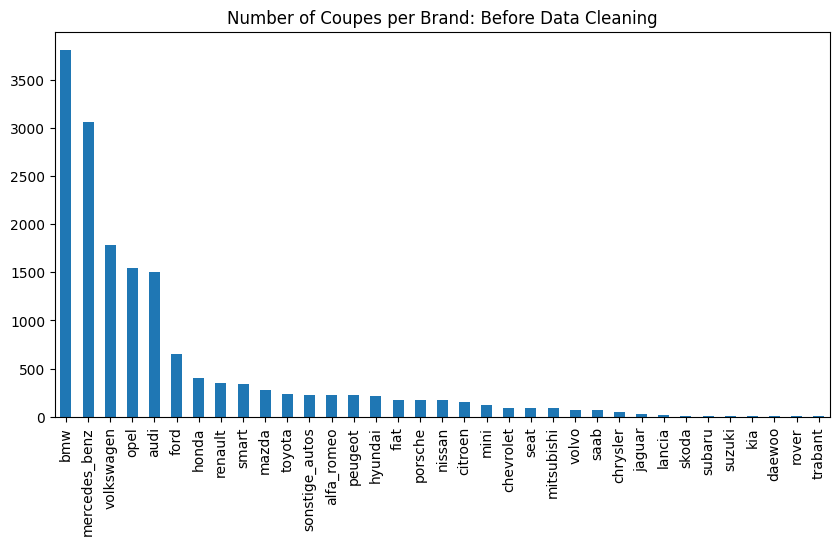

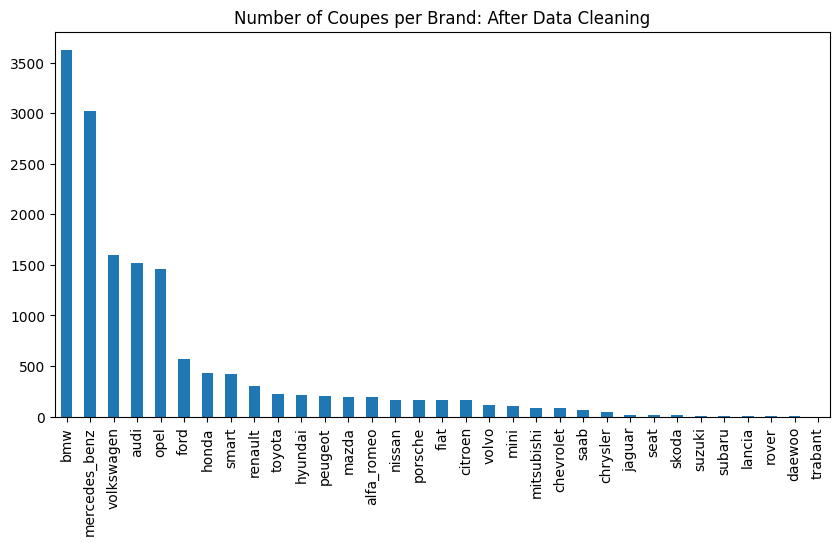

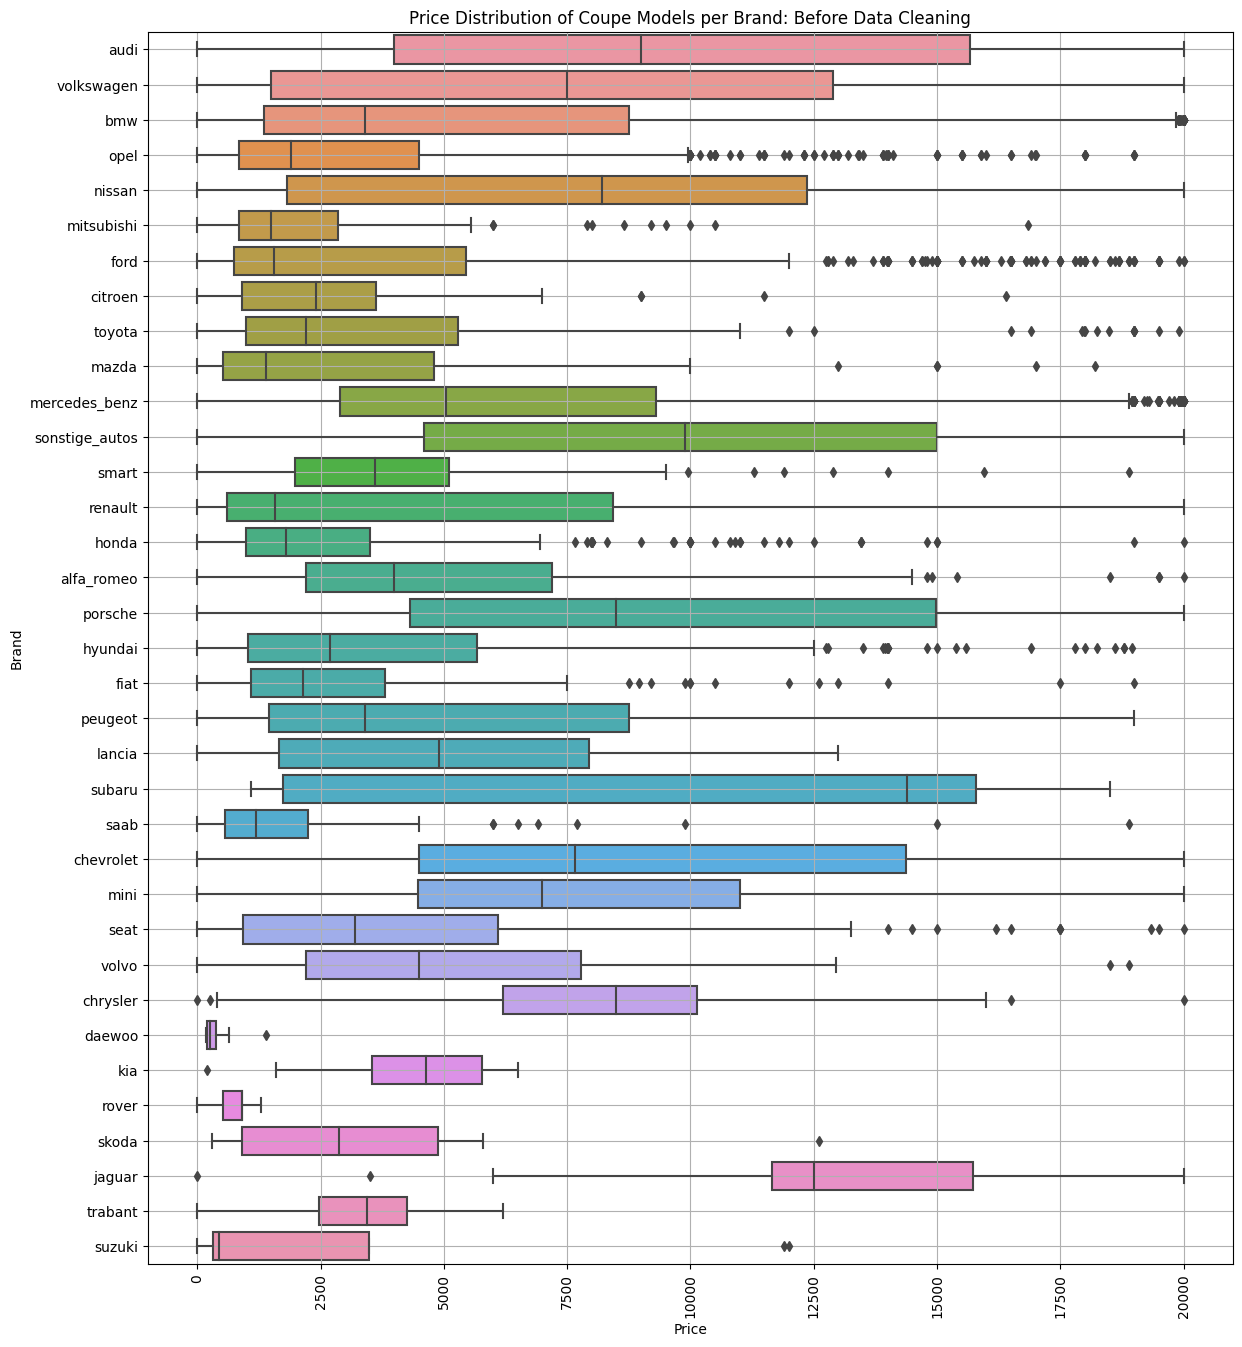

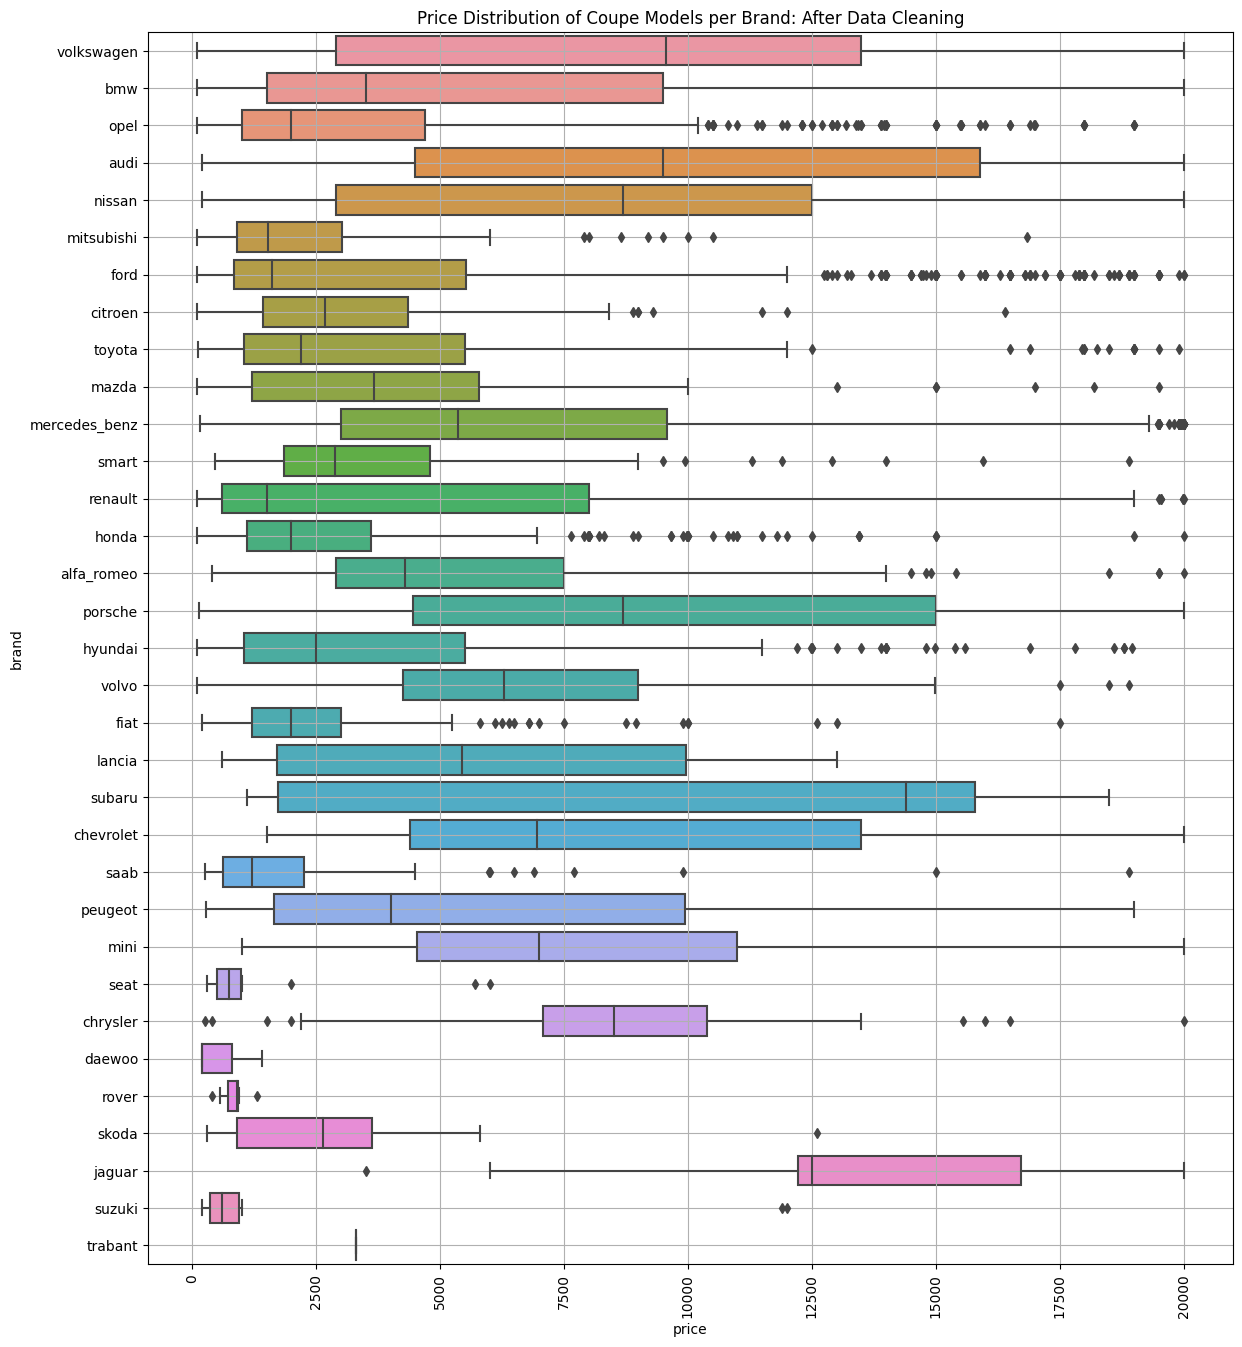

In [104]:
coupe['Brand'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of Coupes per Brand: Before Data Cleaning')
plt.show()

ncoupe['brand'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of Coupes per Brand: After Data Cleaning')
plt.show()

plt.figure(figsize=(14,16))
sns.boxplot(data=coupe, x='Price', y='Brand')
plt.xticks(rotation=90)
plt.title('Price Distribution of Coupe Models per Brand: Before Data Cleaning')
plt.grid()
plt.show()

plt.figure(figsize=(14,16))
sns.boxplot(data=ncoupe, x='price', y='brand')
plt.xticks(rotation=90)
plt.title('Price Distribution of Coupe Models per Brand: After Data Cleaning')
plt.grid()
plt.show()


In [105]:
del coupe
del ncoupe

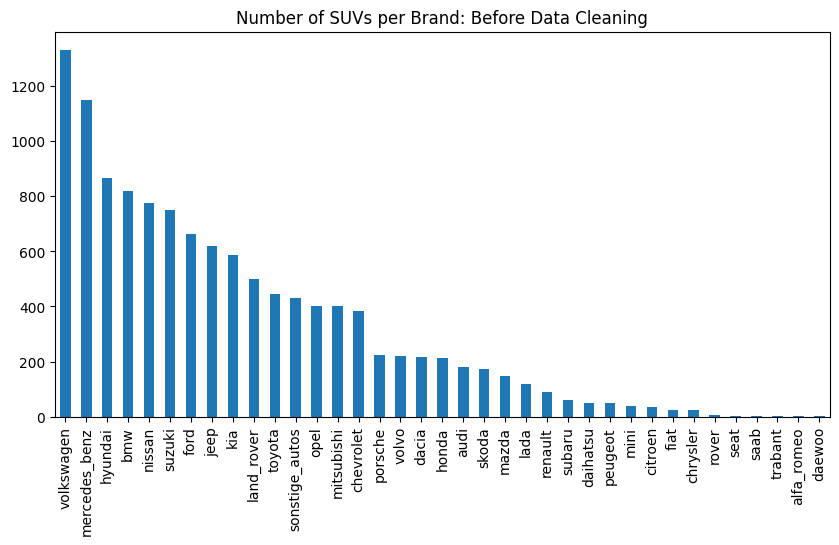

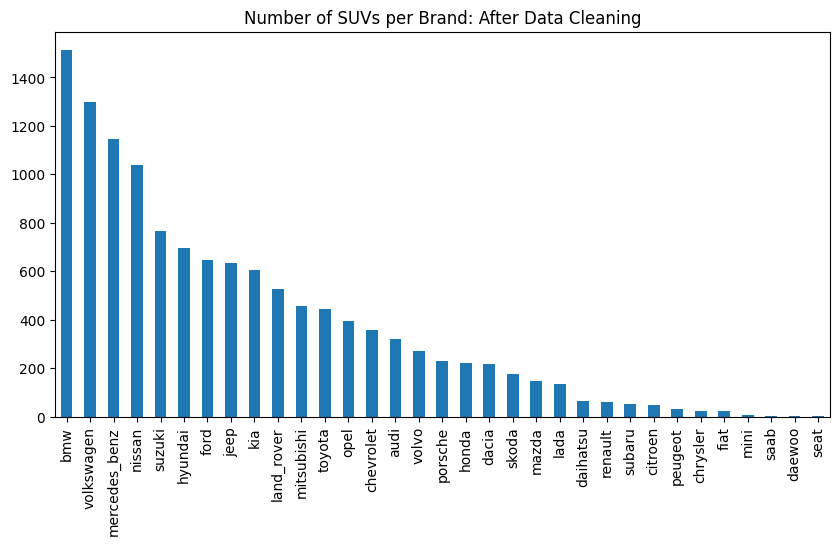

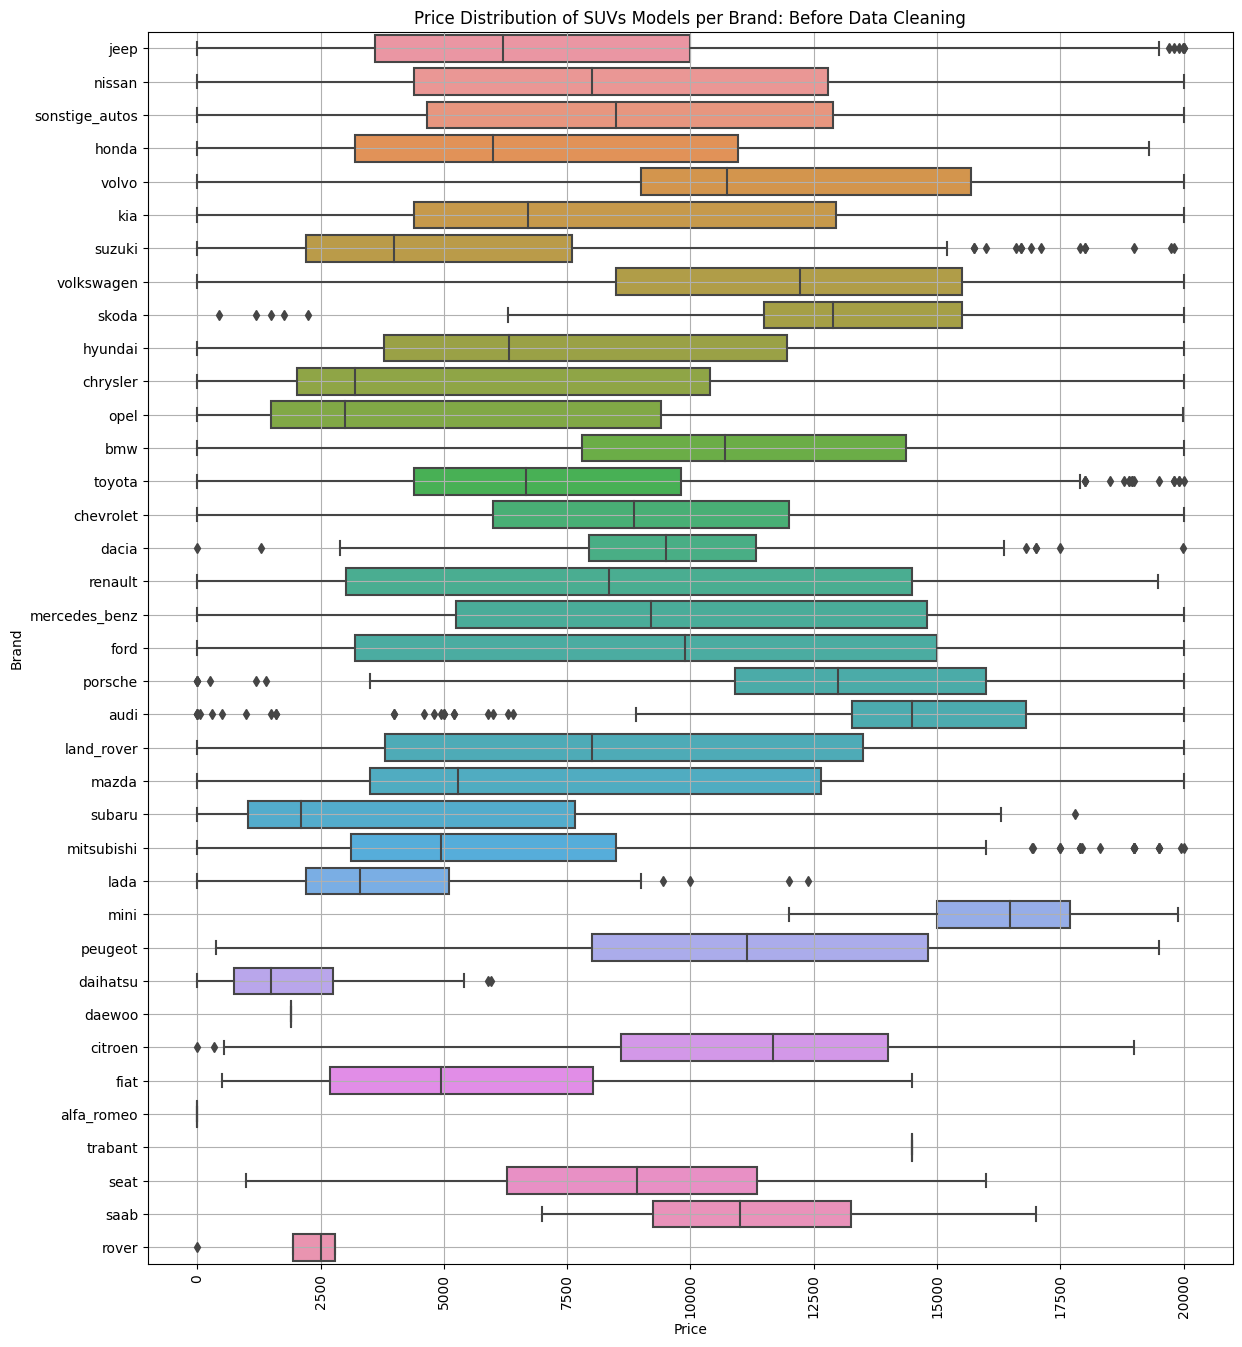

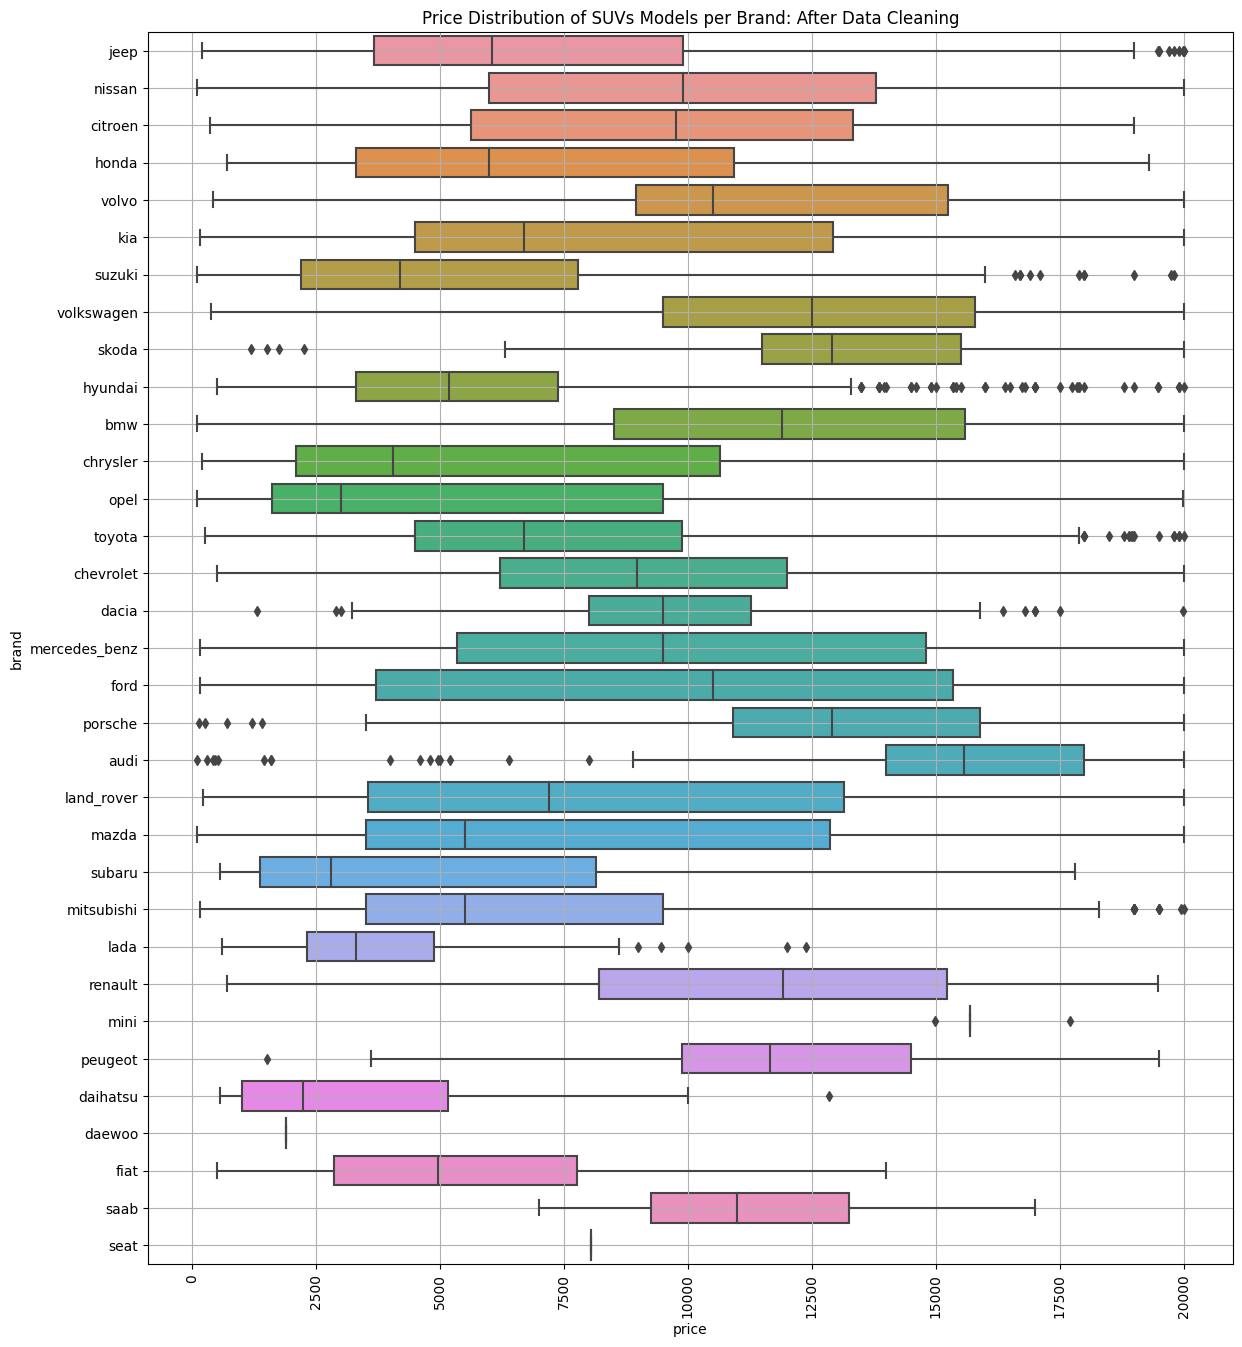

In [106]:
suv['Brand'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of SUVs per Brand: Before Data Cleaning')
plt.show()

nsuv['brand'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of SUVs per Brand: After Data Cleaning')
plt.show()

plt.figure(figsize=(14,16))
sns.boxplot(data=suv, x='Price', y='Brand')
plt.xticks(rotation=90)
plt.title('Price Distribution of SUVs Models per Brand: Before Data Cleaning')
plt.grid()
plt.show()

plt.figure(figsize=(14,16))
sns.boxplot(data=nsuv, x='price', y='brand')
plt.xticks(rotation=90)
plt.title('Price Distribution of SUVs Models per Brand: After Data Cleaning')
plt.grid()
plt.show()


In [107]:
del suv
del nsuv

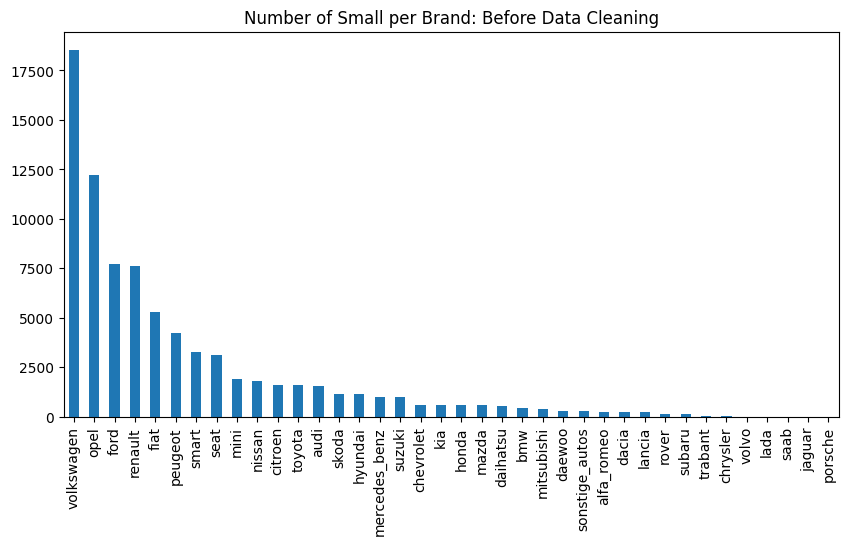

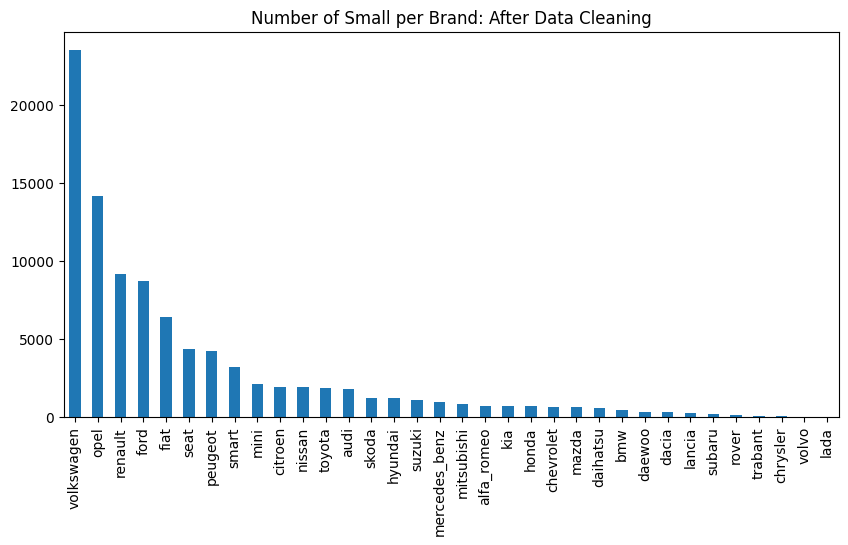

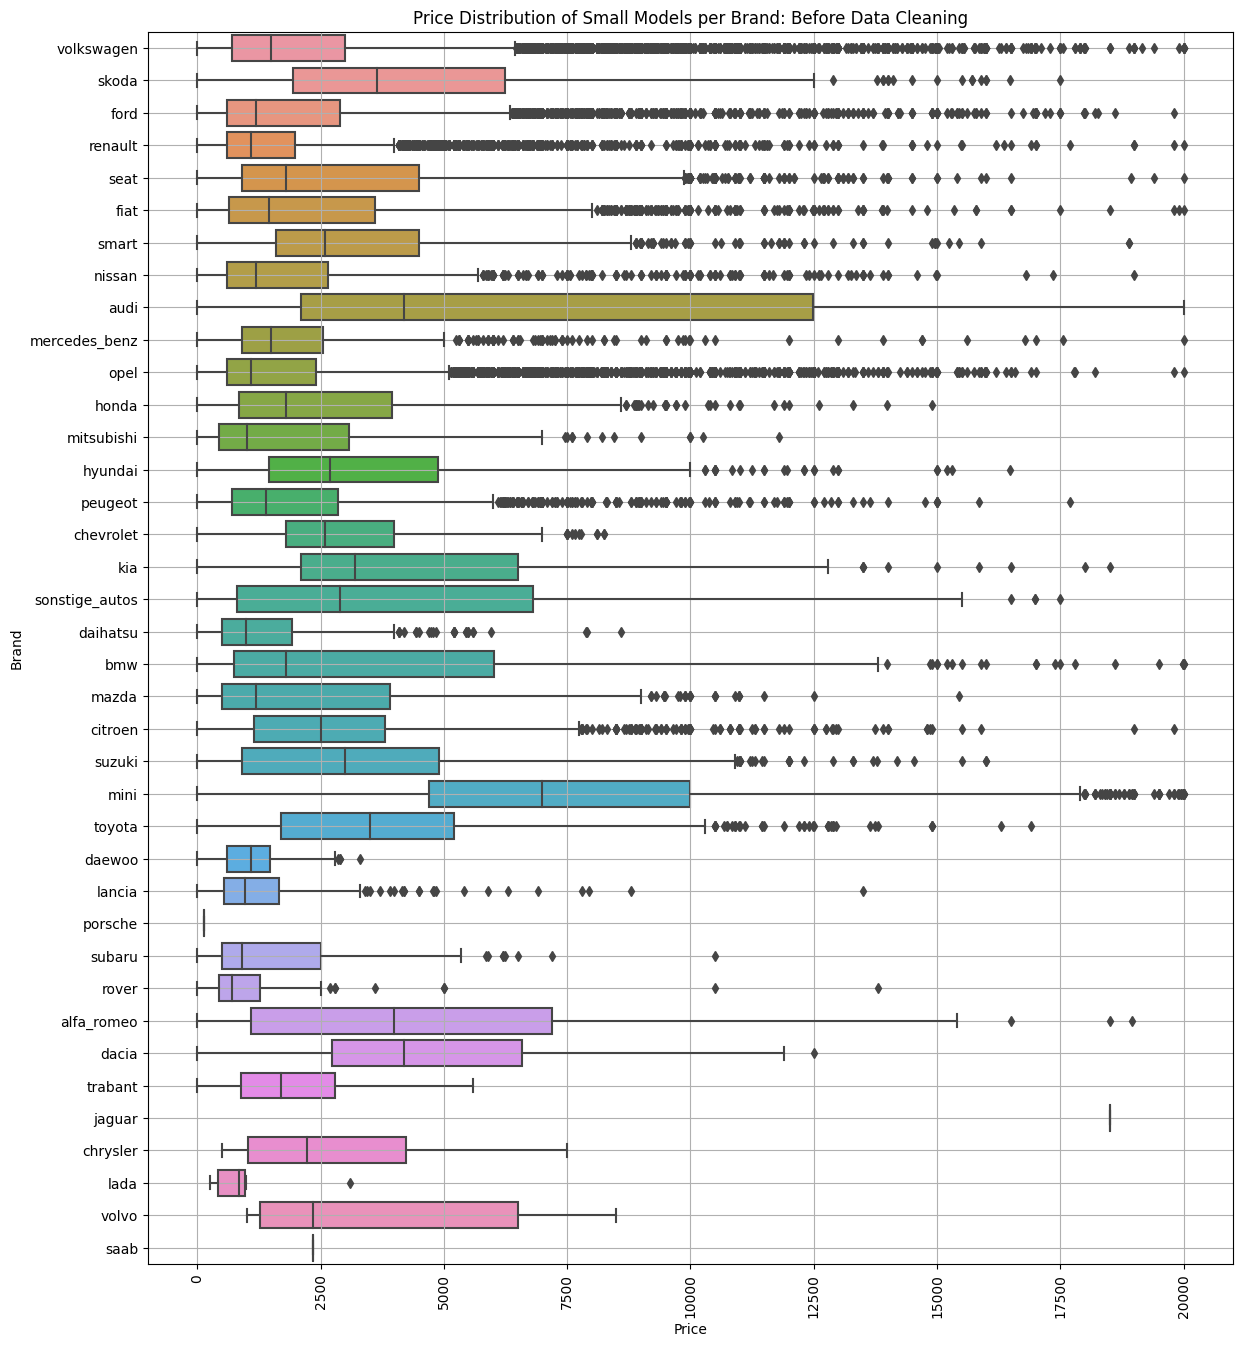

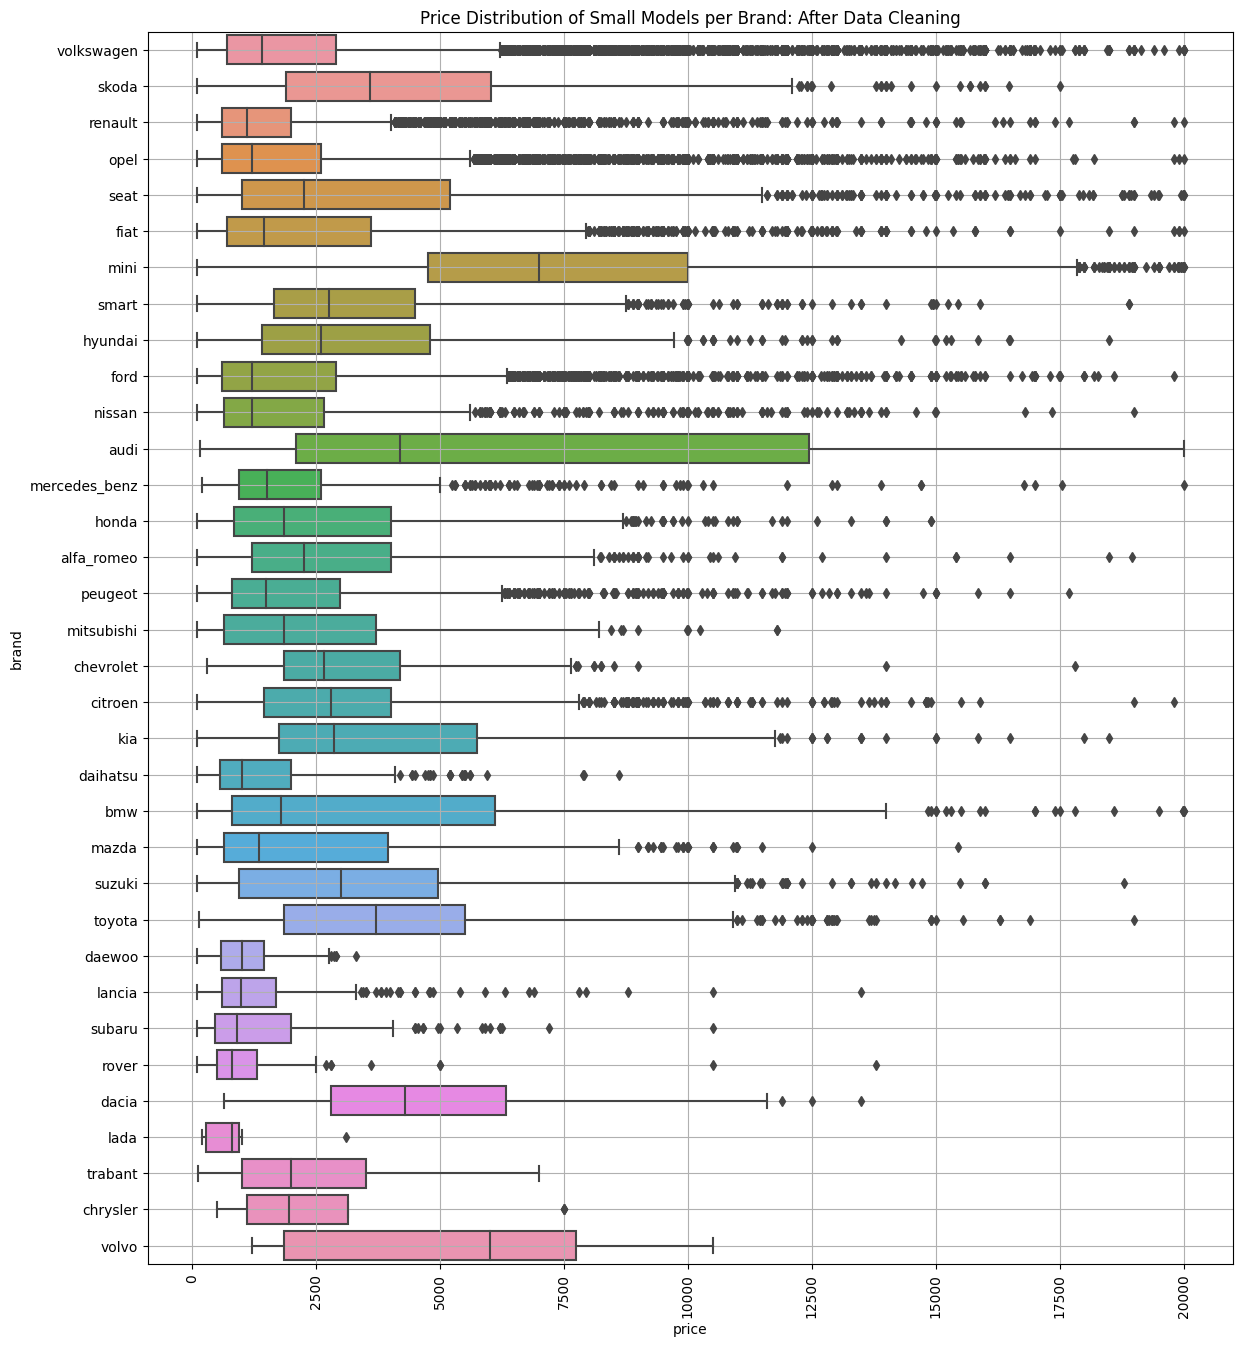

In [108]:
small['Brand'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of Small per Brand: Before Data Cleaning')
plt.show()

nsmall['brand'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of Small per Brand: After Data Cleaning')
plt.show()

plt.figure(figsize=(14,16))
sns.boxplot(data=small, x='Price', y='Brand')
plt.xticks(rotation=90)
plt.title('Price Distribution of Small Models per Brand: Before Data Cleaning')
plt.grid()
plt.show()


plt.figure(figsize=(14,16))
sns.boxplot(data=nsmall, x='price', y='brand')
plt.xticks(rotation=90)
plt.title('Price Distribution of Small Models per Brand: After Data Cleaning')
plt.grid()
plt.show()

In [109]:
del small
del nsmall

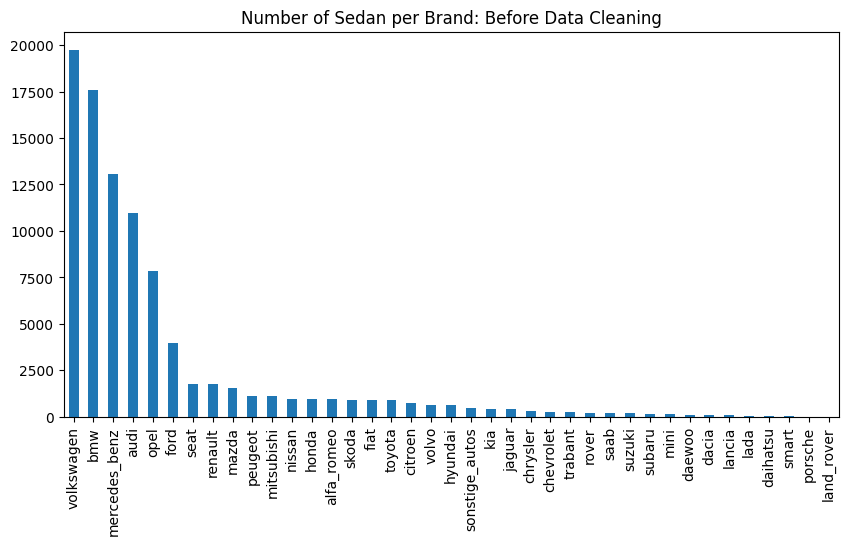

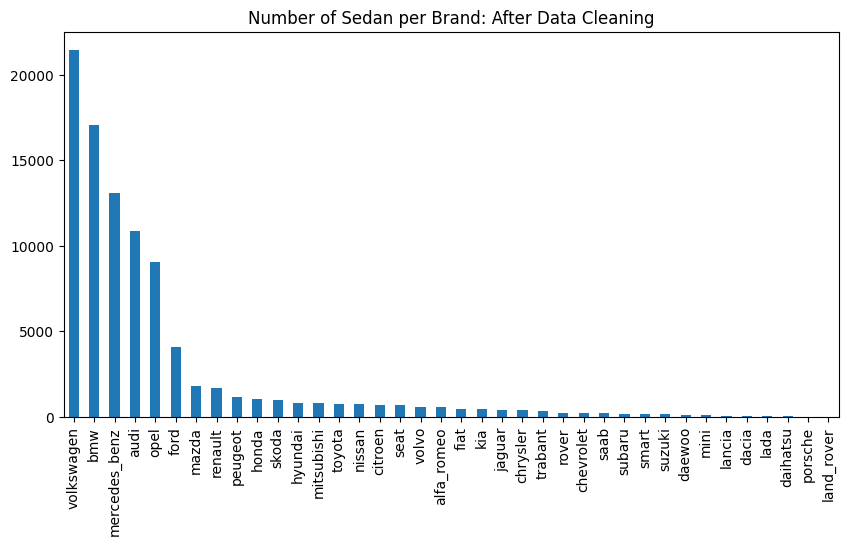

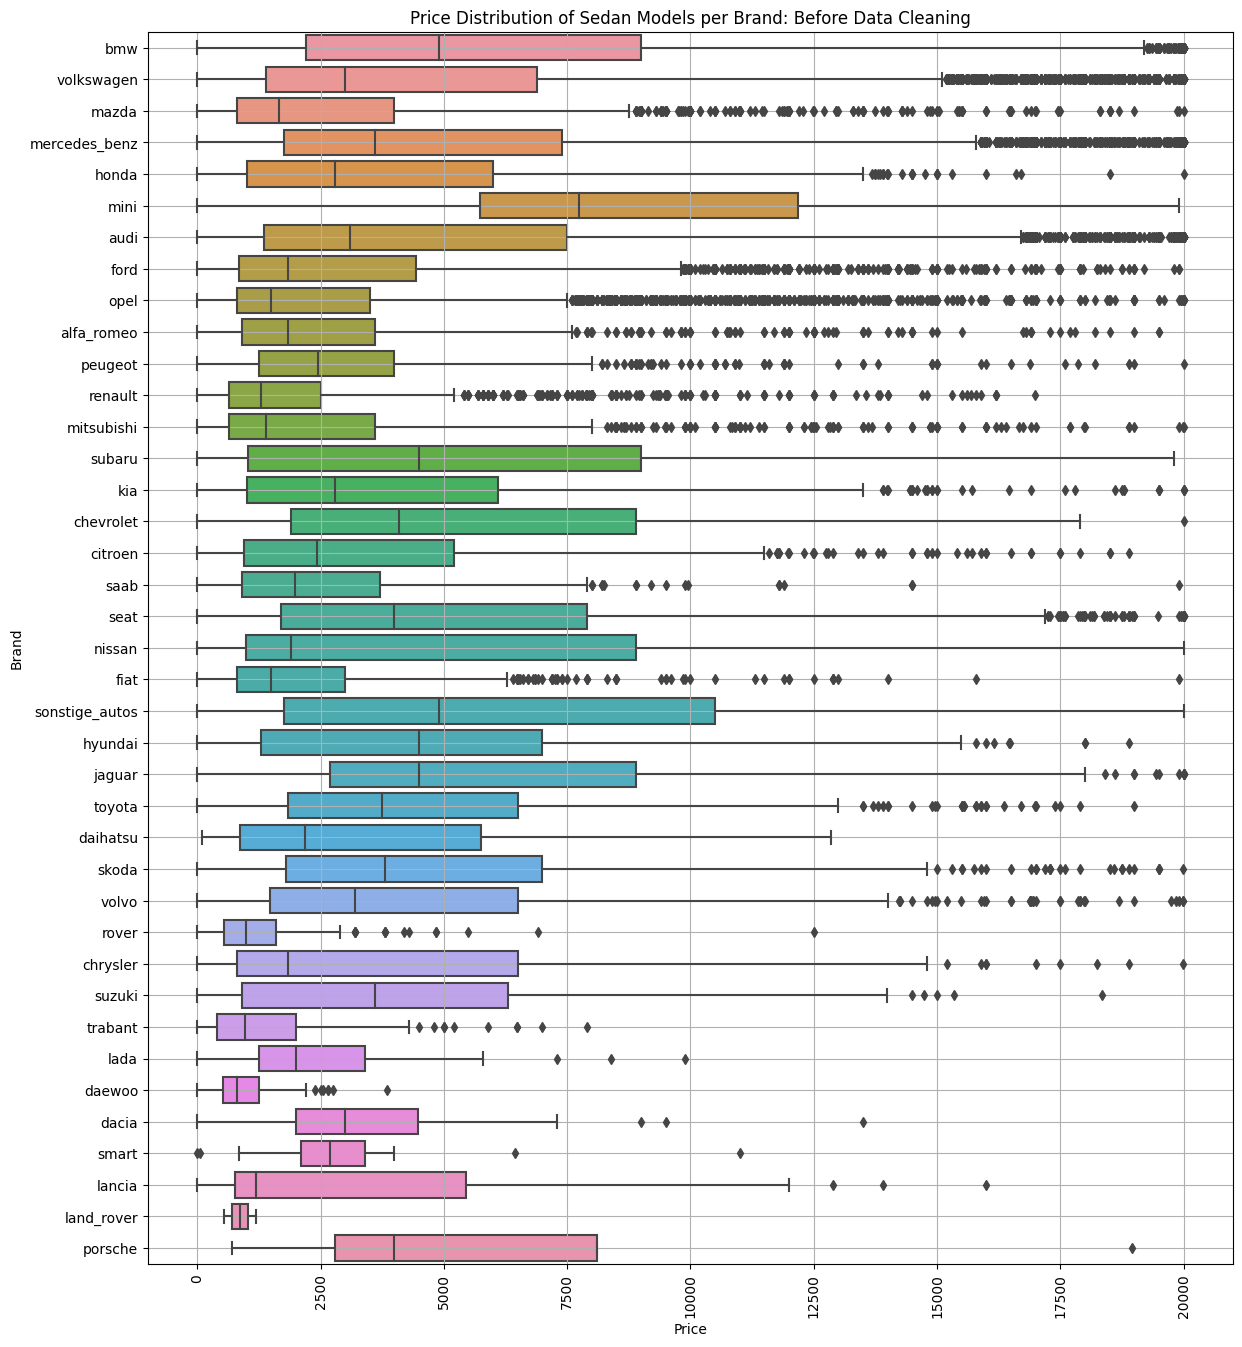

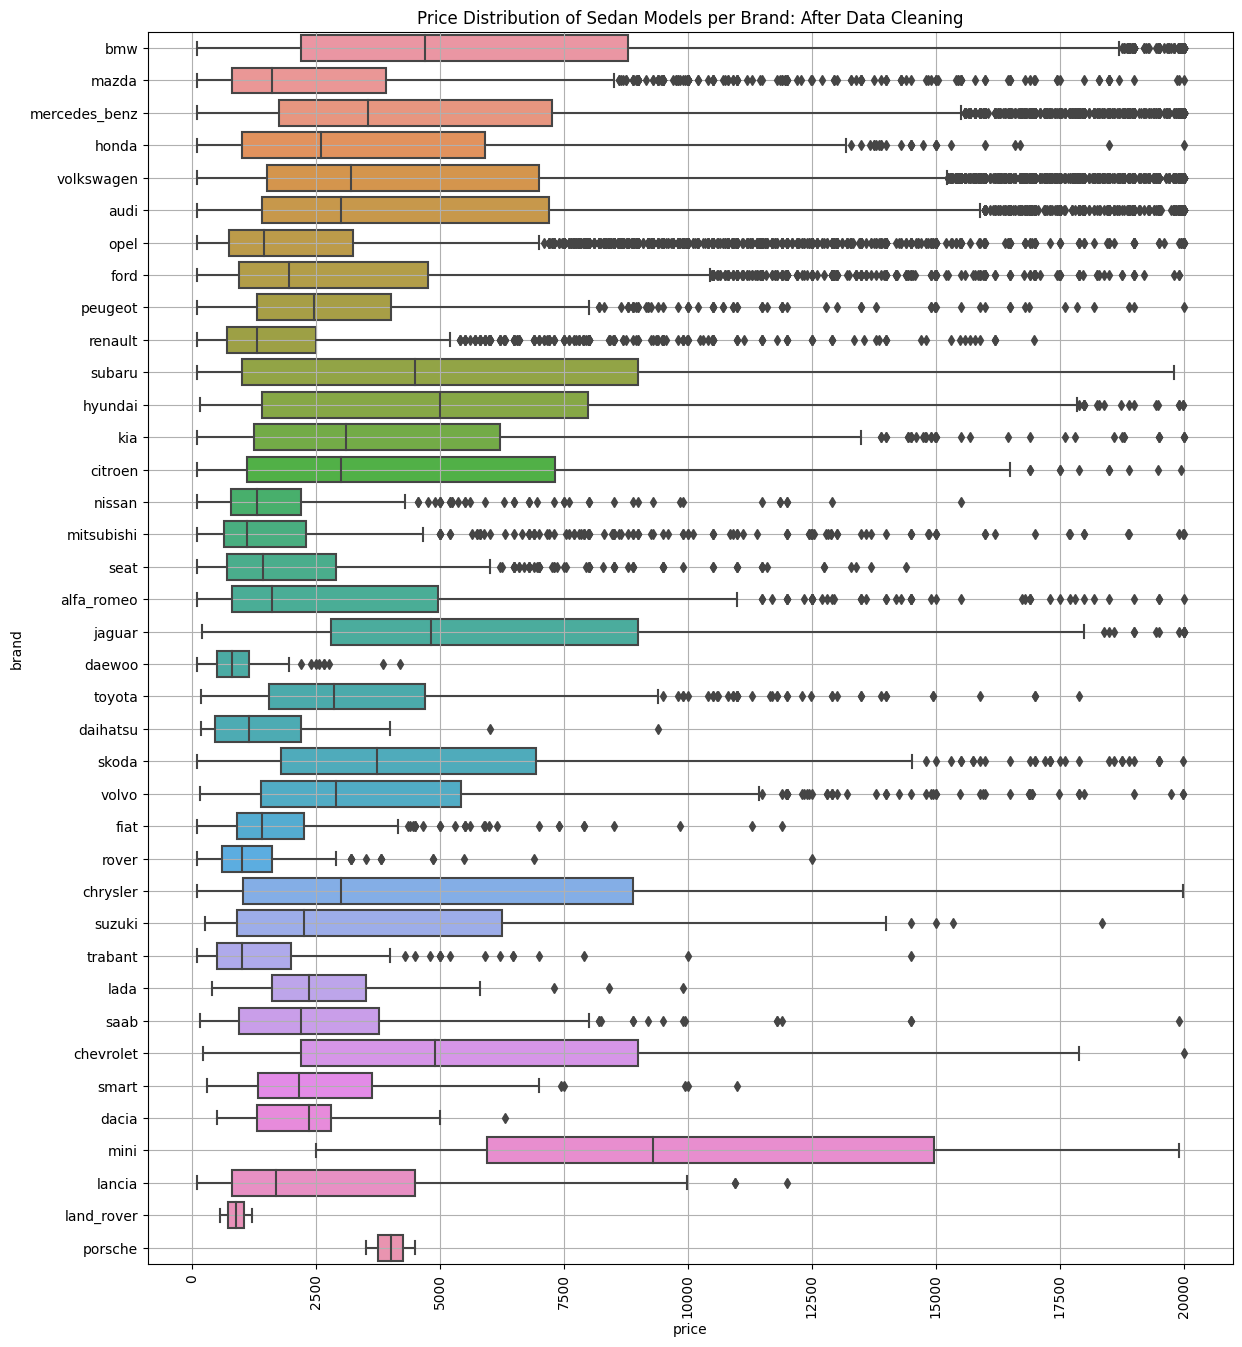

In [110]:
sedan['Brand'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of Sedan per Brand: Before Data Cleaning')
plt.show()

nsedan['brand'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of Sedan per Brand: After Data Cleaning')
plt.show()

plt.figure(figsize=(14,16))
sns.boxplot(data=sedan, x='Price', y='Brand')
plt.xticks(rotation=90)
plt.title('Price Distribution of Sedan Models per Brand: Before Data Cleaning')
plt.grid()
plt.show()


plt.figure(figsize=(14,16))
sns.boxplot(data=nsedan, x='price', y='brand')
plt.xticks(rotation=90)
plt.title('Price Distribution of Sedan Models per Brand: After Data Cleaning')
plt.grid()
plt.show()

In [111]:
del sedan
del nsedan

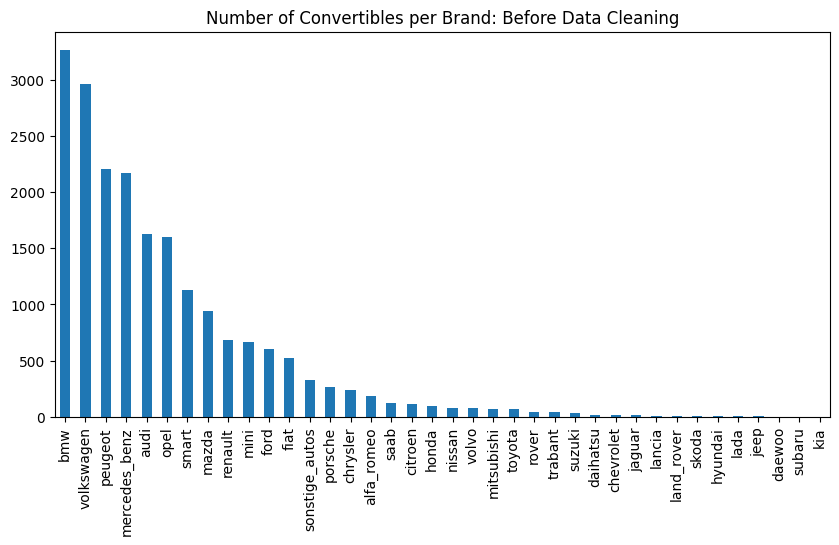

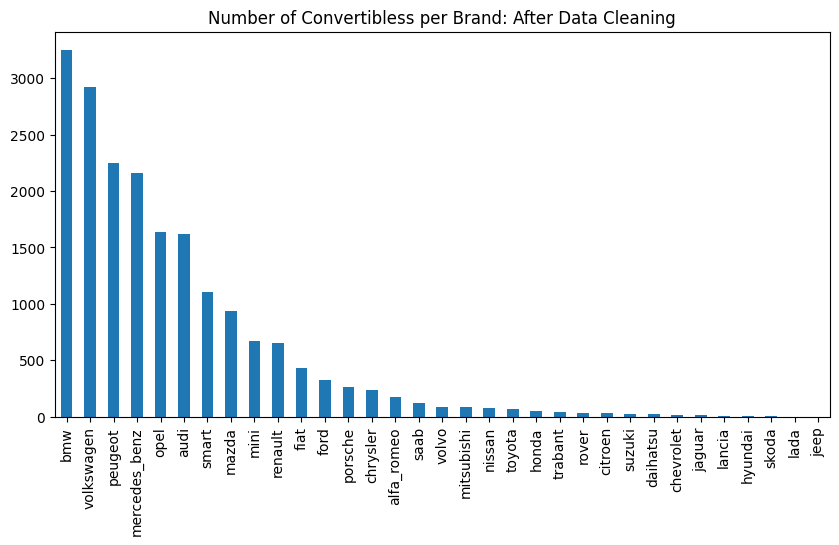

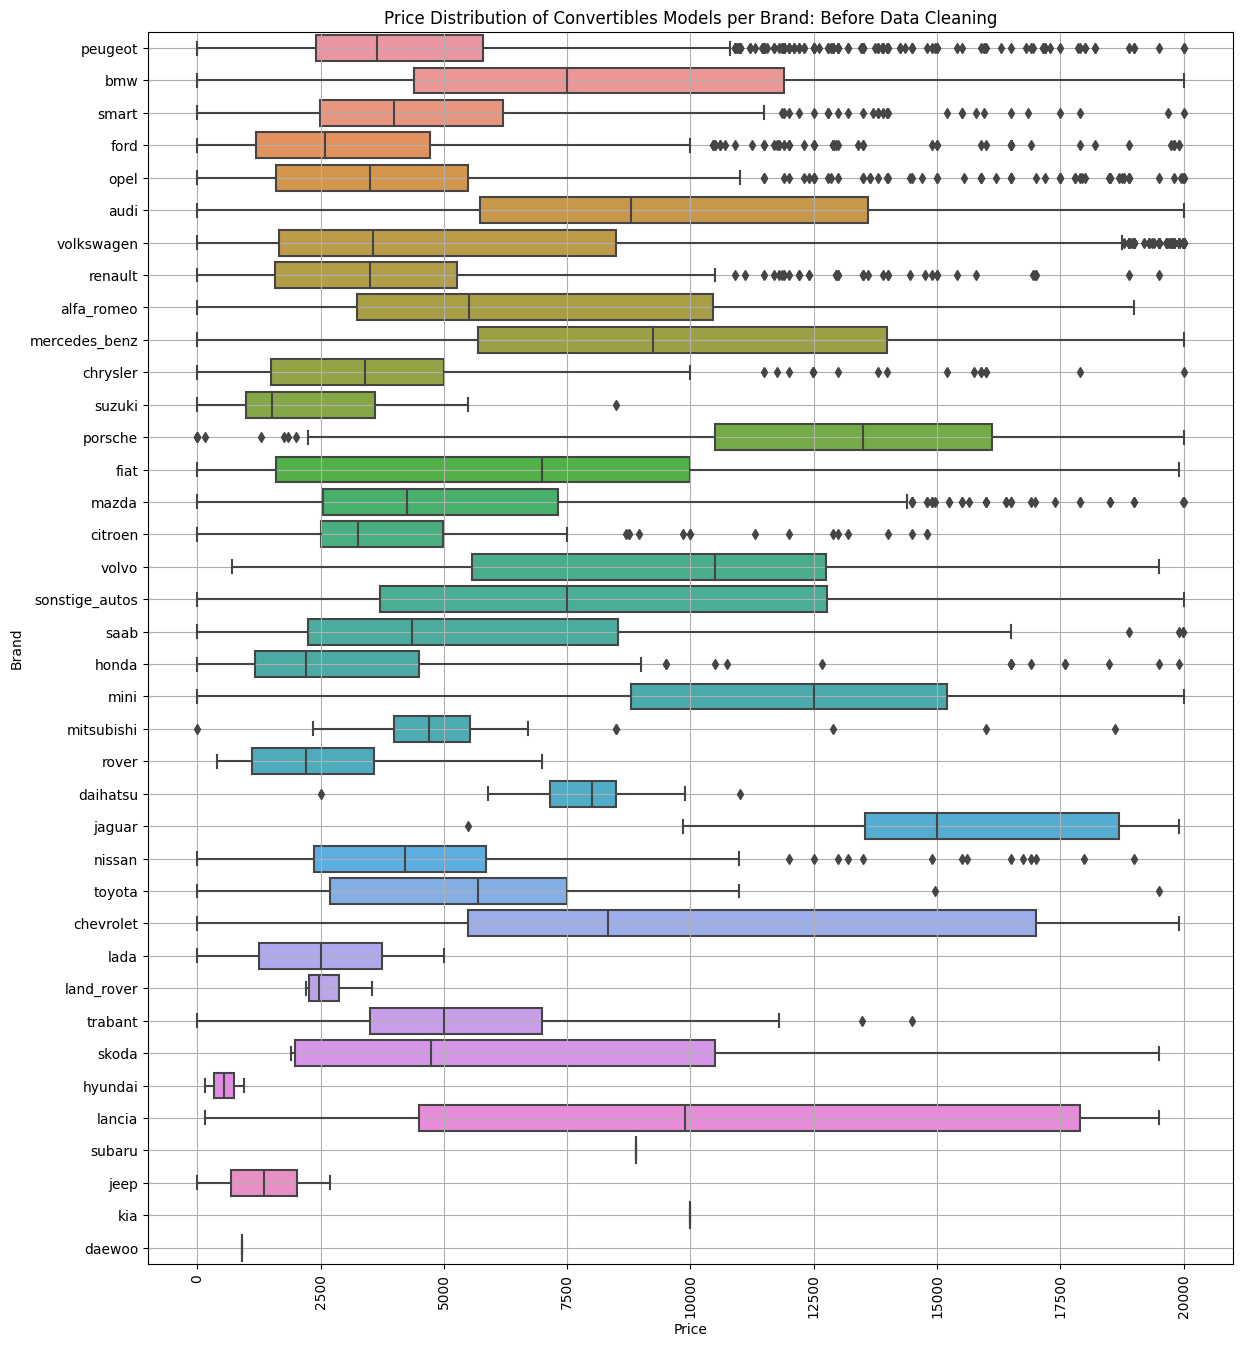

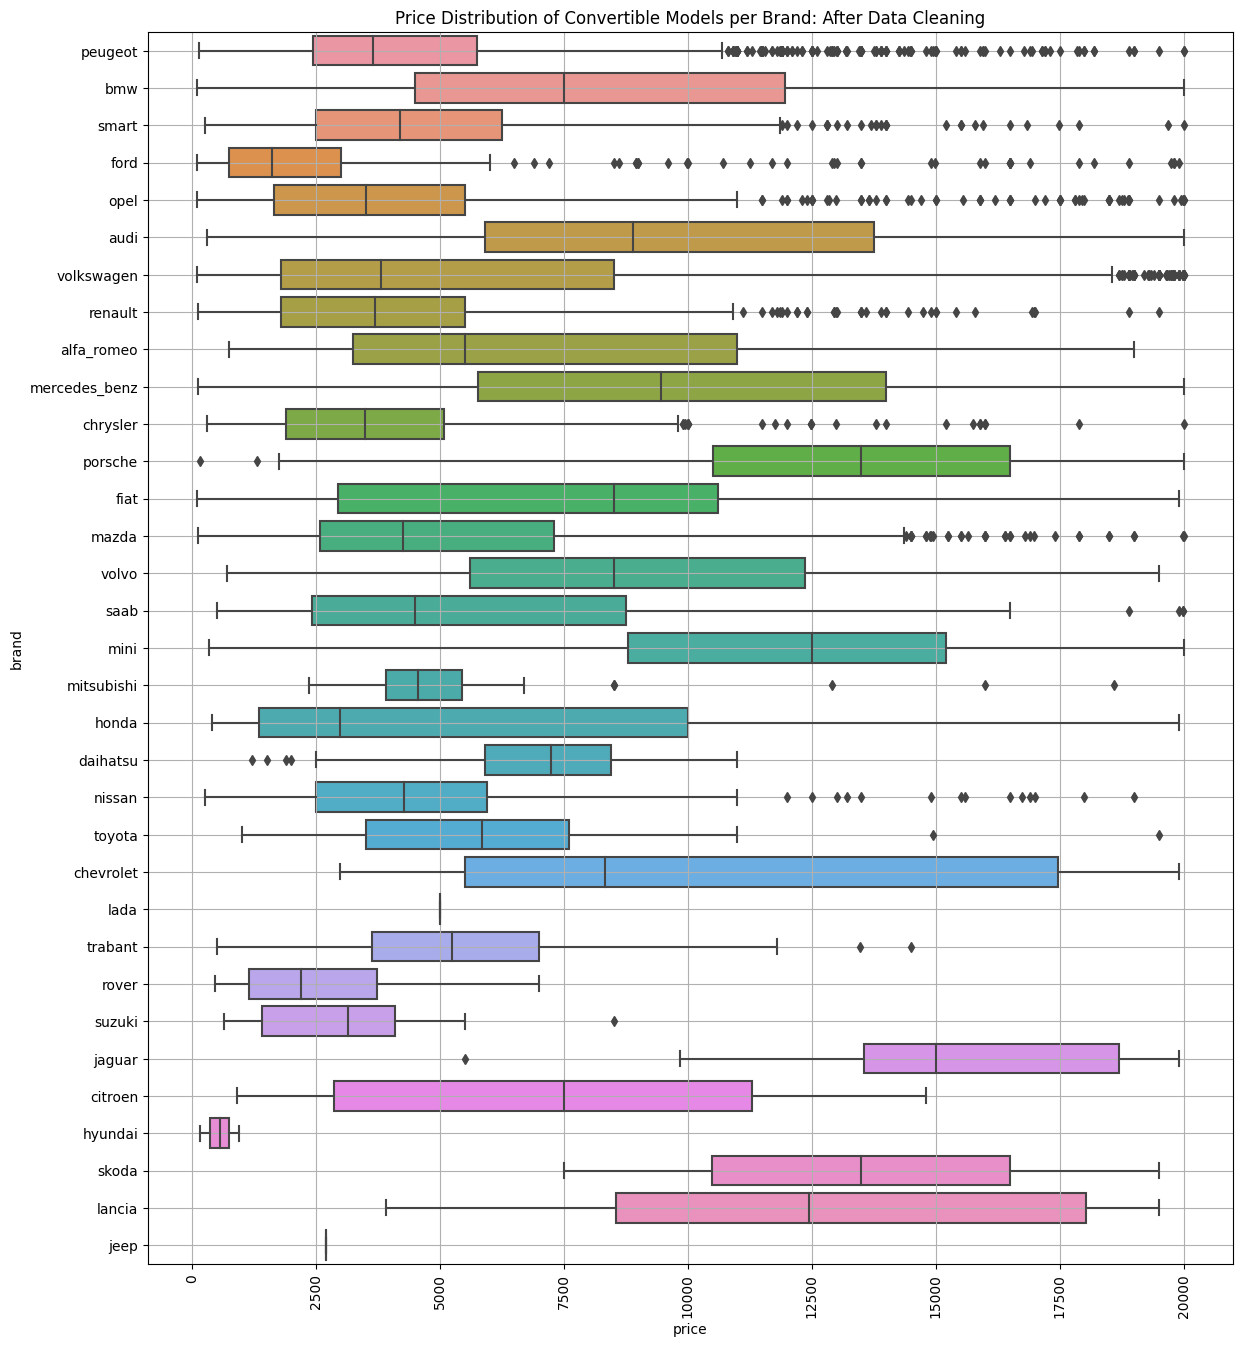

In [112]:
convertible['Brand'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of Convertibles per Brand: Before Data Cleaning')
plt.show()

nconvertible['brand'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of Convertibless per Brand: After Data Cleaning')
plt.show()

plt.figure(figsize=(14,16))
sns.boxplot(data=convertible, x='Price', y='Brand')
plt.xticks(rotation=90)
plt.title('Price Distribution of Convertibles Models per Brand: Before Data Cleaning')
plt.grid()
plt.show()



plt.figure(figsize=(14,16))
sns.boxplot(data=nconvertible, x='price', y='brand')
plt.xticks(rotation=90)
plt.title('Price Distribution of Convertible Models per Brand: After Data Cleaning')
plt.grid()
plt.show()

In [113]:
del convertible
del nconvertible

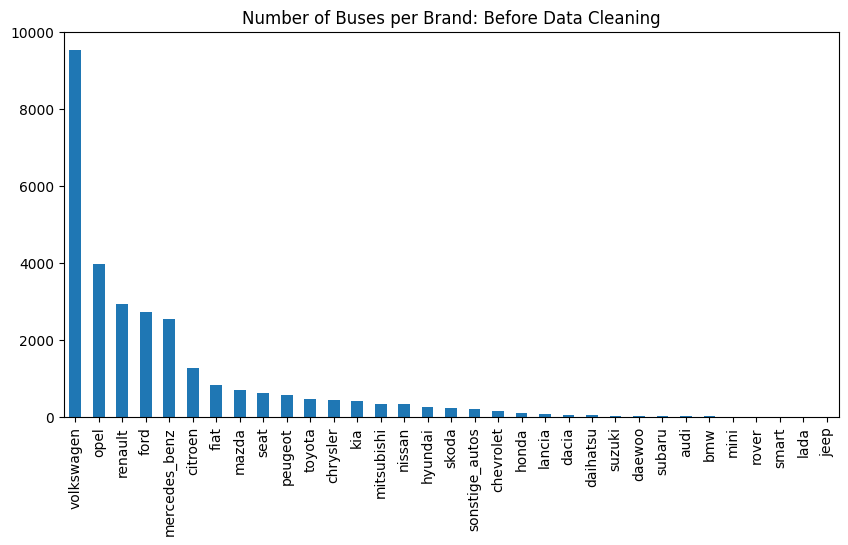

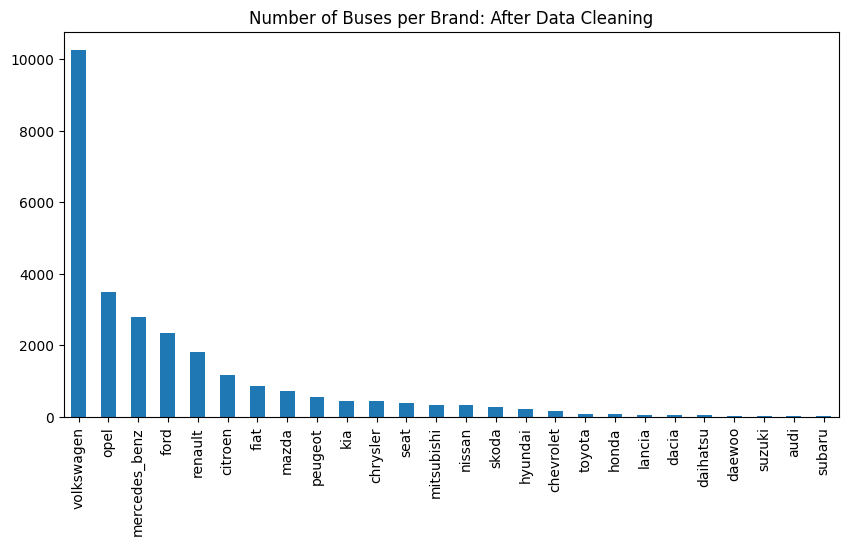

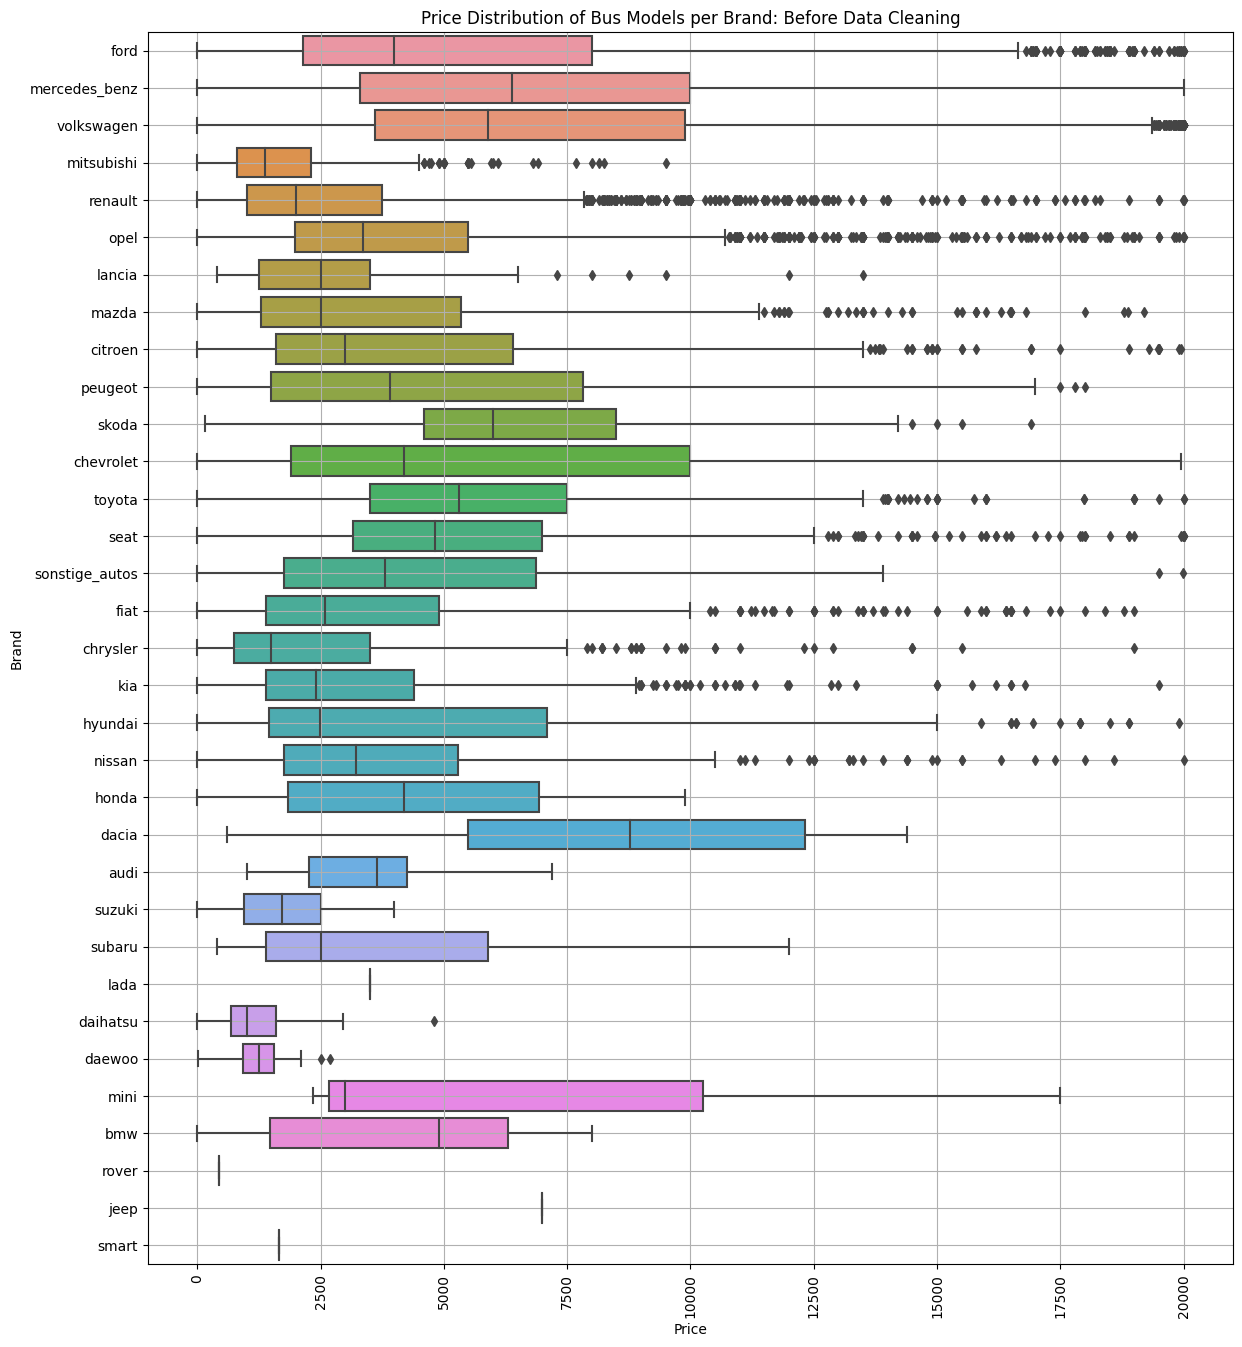

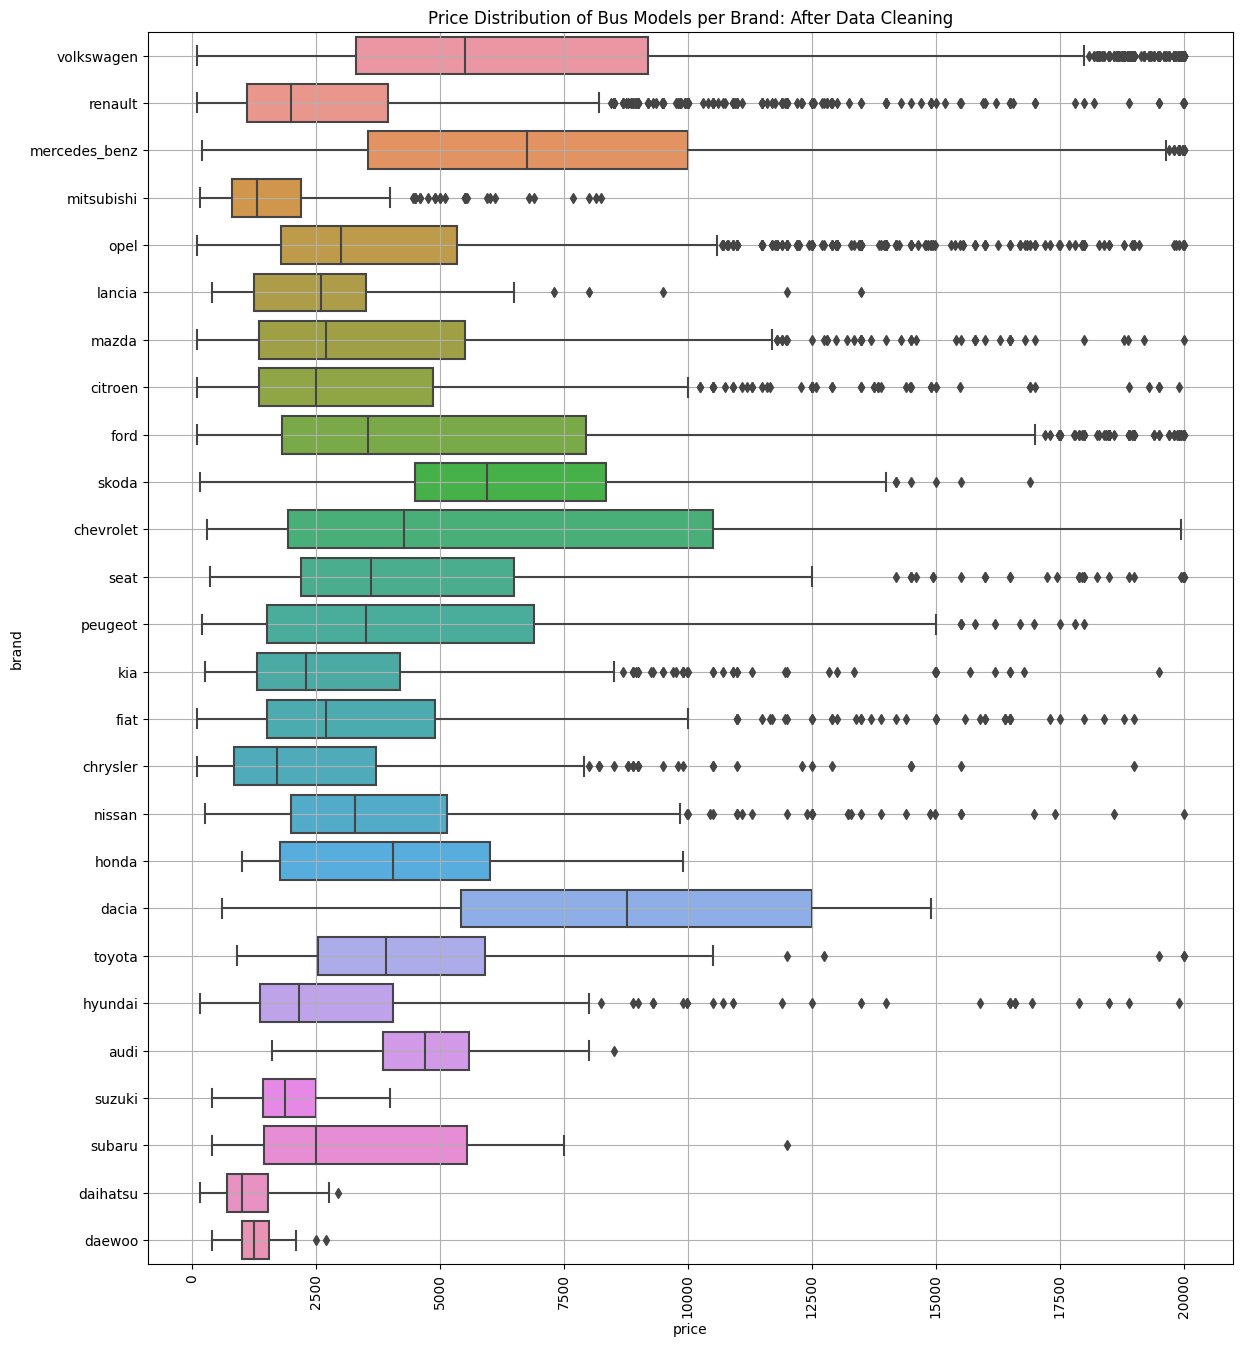

In [114]:
bus['Brand'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of Buses per Brand: Before Data Cleaning')
plt.show()

nbus['brand'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of Buses per Brand: After Data Cleaning')
plt.show()

plt.figure(figsize=(14,16))
sns.boxplot(data=bus, x='Price', y='Brand')
plt.xticks(rotation=90)
plt.title('Price Distribution of Bus Models per Brand: Before Data Cleaning')
plt.grid()
plt.show()


plt.figure(figsize=(14,16))
sns.boxplot(data=nbus, x='price', y='brand')
plt.xticks(rotation=90)
plt.title('Price Distribution of Bus Models per Brand: After Data Cleaning')
plt.grid()
plt.show()

In [115]:
del bus
del nbus

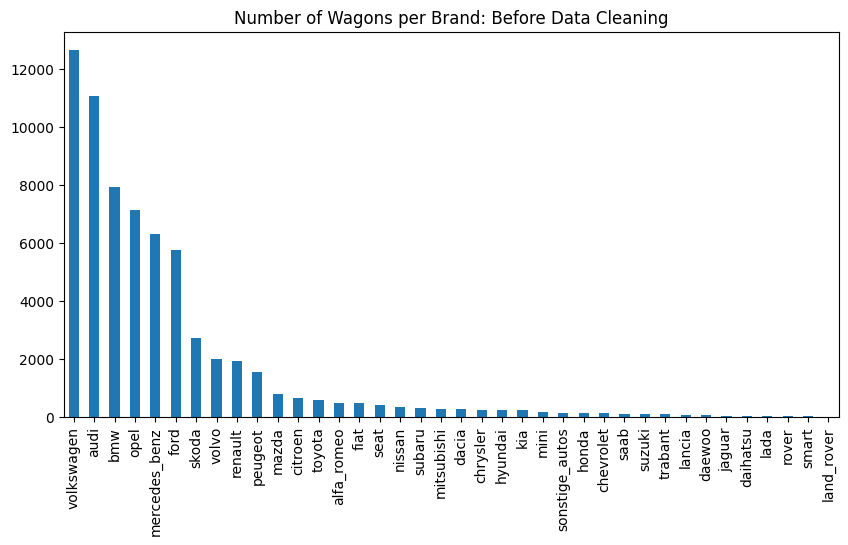

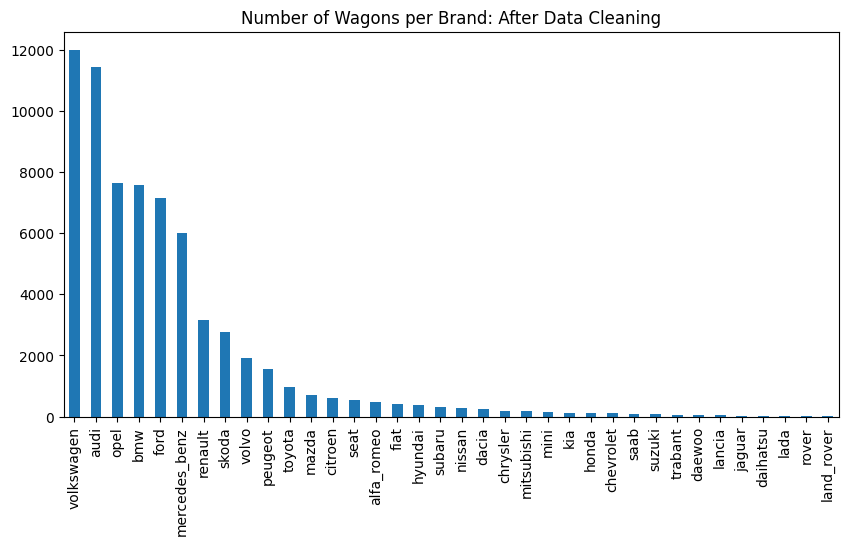

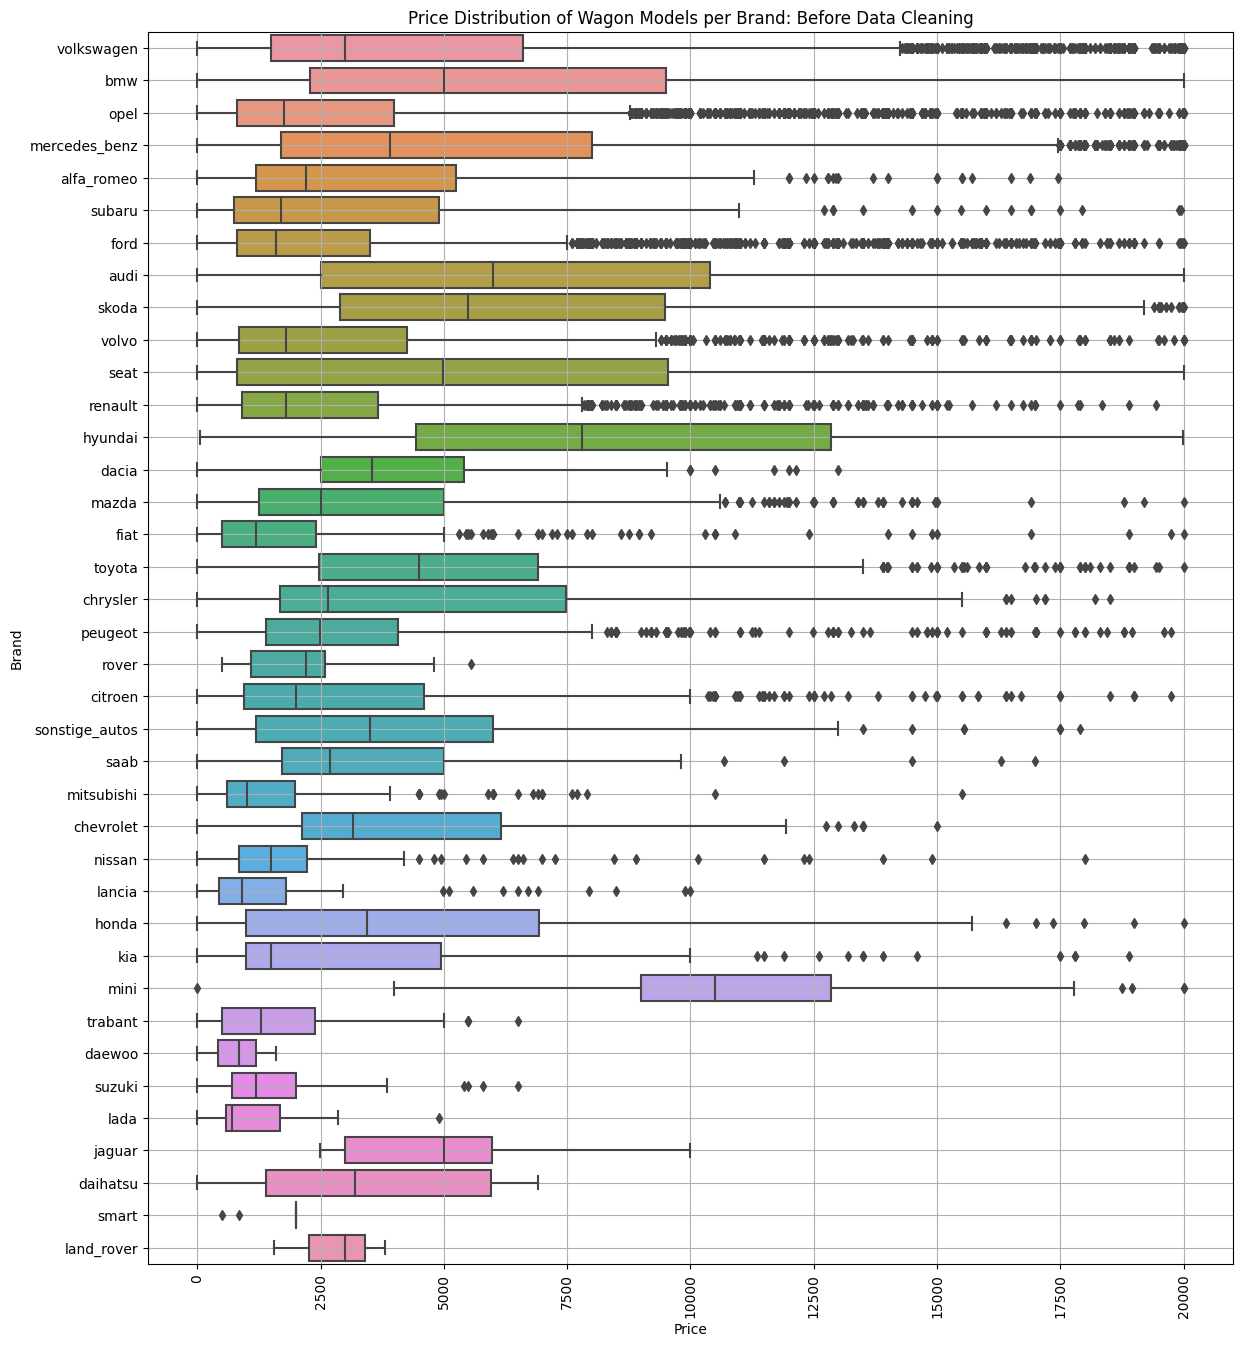

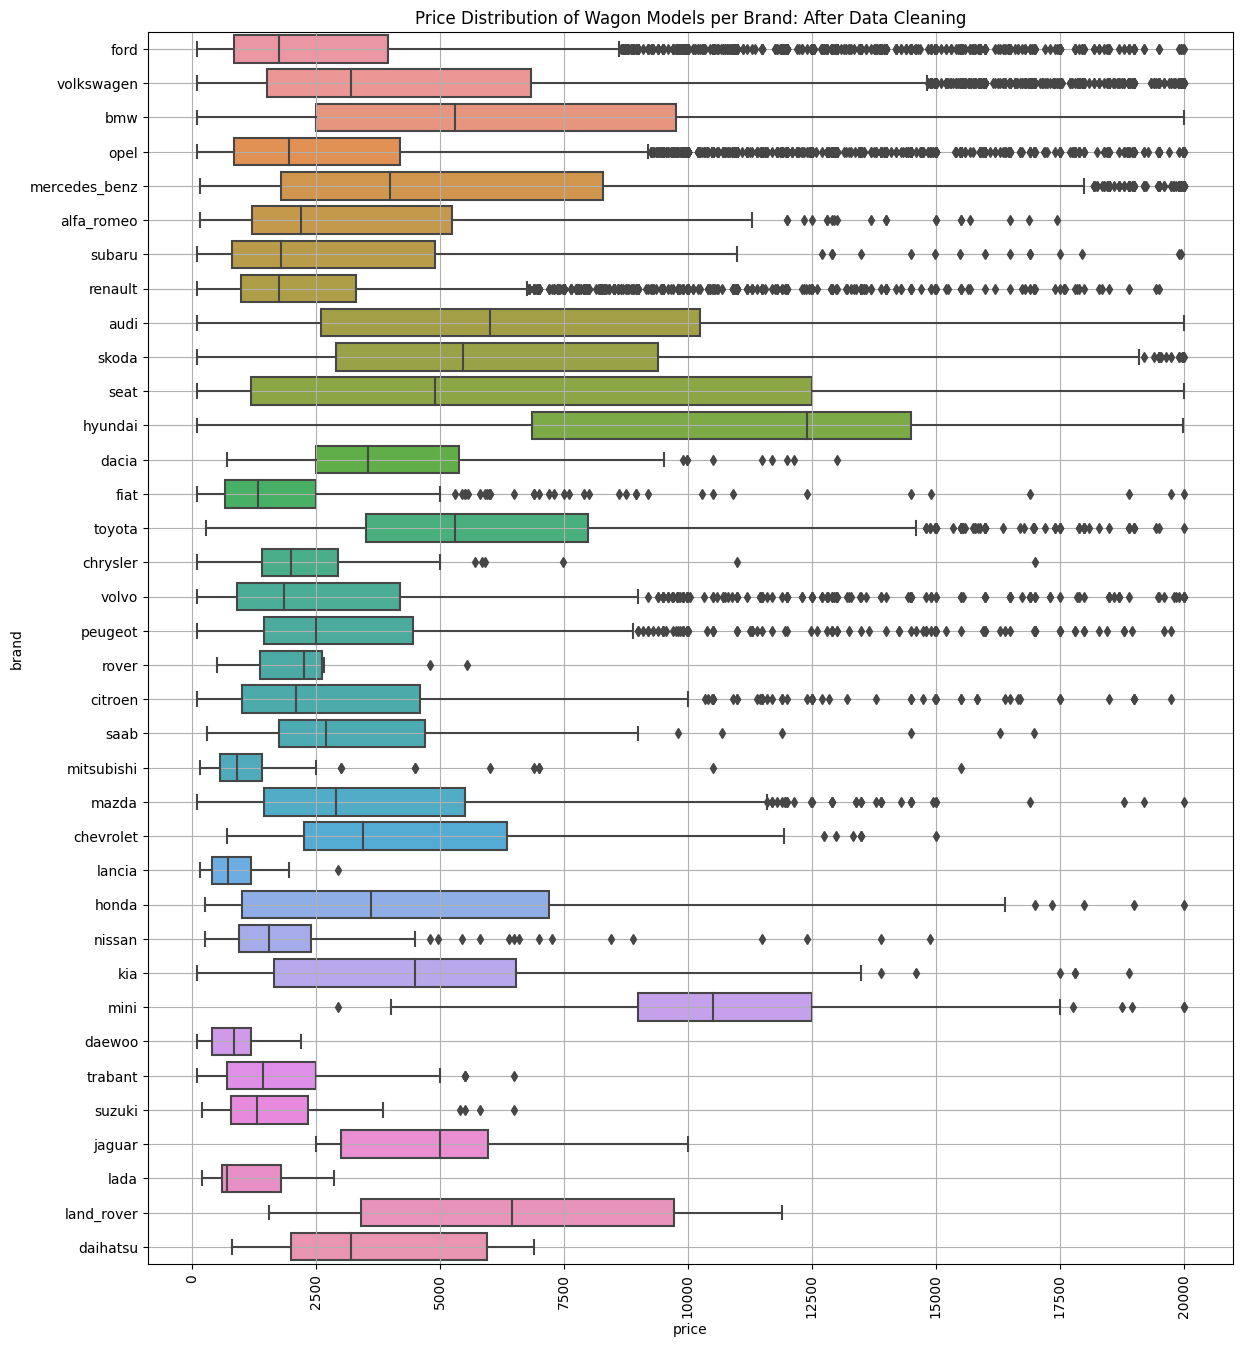

In [116]:
wagon['Brand'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of Wagons per Brand: Before Data Cleaning')
plt.show()

nwagon['brand'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of Wagons per Brand: After Data Cleaning')
plt.show()

plt.figure(figsize=(14,16))
sns.boxplot(data=wagon, x='Price', y='Brand')
plt.xticks(rotation=90)
plt.title('Price Distribution of Wagon Models per Brand: Before Data Cleaning')
plt.grid()
plt.show()


plt.figure(figsize=(14,16))
sns.boxplot(data=nwagon, x='price', y='brand')
plt.xticks(rotation=90)
plt.title('Price Distribution of Wagon Models per Brand: After Data Cleaning')
plt.grid()
plt.show()

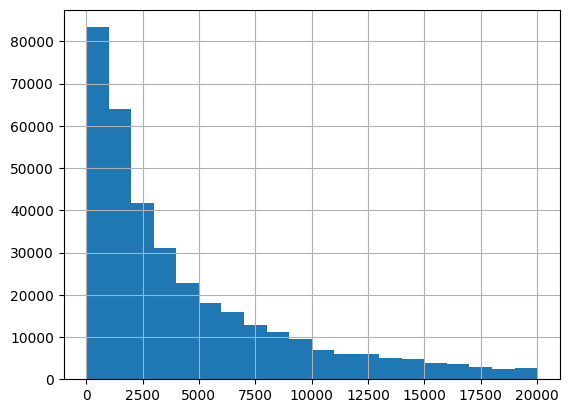

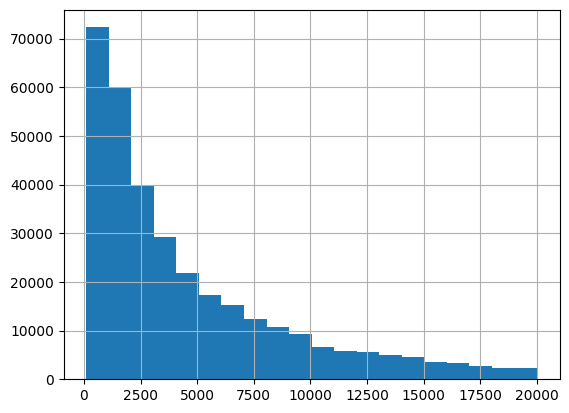

In [117]:
df1['Price'].hist(bins=20)
plt.show()

df_app15['price'].hist(bins=20)
plt.show()

In [118]:
del df_app13,df_app14,df_car,df_app3,df_reg,df_vt,df_model,df_ft,wagon,nwagon
gc.collect()

59778

# Model Training

In [119]:
import sys

def show_memory_usage():
    vars_list = []
    for name, obj in globals().items():
        if not name.startswith('_'):
            size_mb = sys.getsizeof(obj) / (1024**2)
            if size_mb > 1:  # Only show objects > 1MB
                vars_list.append((name, size_mb, type(obj).__name__))
    
    vars_list.sort(key=lambda x: x[1], reverse=True)
    print("\n🔍 Memory Usage:")
    for name, size, dtype in vars_list[:10]:
        print(f"  {name}: {size:.2f} MB ({dtype})")

# Use it throughout your notebook
show_memory_usage()


🔍 Memory Usage:
  df: 221.81 MB (DataFrame)
  df1: 213.99 MB (DataFrame)
  df_app15: 196.68 MB (DataFrame)
  passat: 11.10 MB (Series)
  qashqai: 11.10 MB (Series)
  ft: 11.10 MB (Series)
  vw_model: 4.10 MB (DataFrame)
  fix80: 3.01 MB (Series)
  fix90: 3.01 MB (Series)
  fix00: 3.01 MB (Series)


In [120]:
data = df_app15.copy()

In [121]:
del df_app15,passat, qashqai, ft, vw_model, fix80, fix90, fix00, fix10, cvt, gbus, puv, bmwsuv, astrabus, nosuv, noconvertible, nocoupe, nobus, nowagon, nosedan, nosmall, noaudi
gc.collect()


0

In [122]:
# If the kernel crashes:
# import libraries (Go to the top - press ctrl+F and type libraries to get there faster - run the libraries)
# data = pd.read_pickle('checkpoint_03.pkl') <-- copy this on a new line right below, run it
# This is a checkpoint to start off with the data DF
data.to_pickle('checkpoint_03.pkl')


## Train/Validate Split

In [3]:
features = data.drop('price', axis=1)
target = data['price']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, 
    test_size=0.25, 
    random_state=12345
)

# Identify categorical columns
cat_cols = features_train.select_dtypes(include=['object','category']).columns
num_cols = features_train.select_dtypes(exclude=['object','category']).columns

features_train = features_train.copy()
features_valid = features_valid.copy()

features_train.loc[:, cat_cols] = features_train[cat_cols].astype(str)
features_valid.loc[:, cat_cols] = features_valid[cat_cols].astype(str)

In [4]:
def evaluate_model(name, model, features_train, target_train, features_valid, target_valid, cat_features=None):
    print(f"\nTraining {name}...")

    start_train = time.time()

    if cat_features is not None:
        model.fit(features_train, target_train, cat_features=cat_features)
    else:
        model.fit(features_train, target_train)

    train_time = time.time() - start_train

    start_pred = time.time()
    preds = model.predict(features_valid)
    pred_time = time.time() - start_pred
    
    rmse = mean_squared_error(target_valid, preds, squared=False)

    print(f"{name}: RMSE={rmse:.3f}, TrainTime={train_time:.2f}s, PredTime={pred_time:.4f}s")

    return {
        'Model': name,
        'RMSE': rmse,
        'Train_Time': train_time,
        'Predict_Time': pred_time
    }


In [5]:
gc.collect()

0

In [6]:
ohe_processor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', dtype = int), cat_cols)
    ],
    remainder='passthrough'
)

lr_model = Pipeline([
    ('ohe', ohe_processor),
    ('lr', LinearRegression())
])

results = []
results.append(
    evaluate_model('Linear Regression Model', lr_model, features_train, target_train, features_valid, target_valid)
)



Training Linear Regression Model...
Linear Regression Model: RMSE=2849.125, TrainTime=1.19s, PredTime=0.2909s


In [7]:
gc.collect()

52

In [8]:
# DecisionTree
dt_model = Pipeline([
    ('ohe', ohe_processor),
    ('dt', DecisionTreeRegressor(
        max_depth=20,
        min_samples_leaf=4,
        random_state=12345
    ))
])

results.append(
    evaluate_model('Decision Tree Model', dt_model, features_train, target_train, features_valid, target_valid)
)




Training Decision Tree Model...
Decision Tree Model: RMSE=1860.135, TrainTime=28.17s, PredTime=0.2242s


In [9]:
gc.collect()

52

In [10]:
# Random Forest
rf_model = Pipeline([
    ('ohe', ohe_processor),
    ('rf', RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        random_state=12345,
        n_jobs=-1
    ))
])

results.append(
    evaluate_model('Random Forest', rf_model, features_train, target_train, features_valid, target_valid)
)




Training Random Forest...
Random Forest: RMSE=1676.330, TrainTime=1138.89s, PredTime=0.7616s


In [11]:
gc.collect()

27

In [12]:
# CATBOOST - Set 1 (Baseline)
cat_features = [features_train.columns.get_loc(c) for c in cat_cols]

cat_model = CatBoostRegressor(
    depth=8,
    learning_rate=0.1,
    iterations=500,
    loss_function='RMSE',
    verbose=False,
    random_seed=12345
)

results.append(
    evaluate_model(
        'CatBoost Set 1',
        cat_model,
        features_train,
        target_train,
        features_valid,
        target_valid,
        cat_features=cat_features
    )
)



# CATBOOST — Set 2 (More complex)
cat_model2 = CatBoostRegressor(
    depth=10,                 # deeper trees
    learning_rate=0.03,       # slower learning
    iterations=800,           # more boosting rounds
    l2_leaf_reg=5,            # L2 regularization
    random_strength=1.5,      # helps avoid overfitting
    loss_function='RMSE',
    verbose=False,
    random_seed=12345
)

results.append(
    evaluate_model(
        'CatBoost Set 2',
        cat_model2,
        features_train,
        target_train,
        features_valid,
        target_valid,
        cat_features=cat_features
    )
)



Training CatBoost Set 1...
CatBoost Set 1: RMSE=1633.907, TrainTime=243.91s, PredTime=0.7010s

Training CatBoost Set 2...
CatBoost Set 2: RMSE=1641.981, TrainTime=648.14s, PredTime=1.3688s


In [13]:
cat_cols = list(cat_cols)

for col in cat_cols:
    features_train[col] = features_train[col].astype("category")
    features_valid[col] = features_valid[col].astype("category")

In [14]:
gc.collect()

0

In [15]:
# XGBOOST
# Set 2 parameters to compare results; set 1 is a baseline and set 2 is more in depth

# xgb_model is a baseline
xgb_model = Pipeline(steps=[
    ('preprocess', ohe_processor),
    ('model', XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=12345,
        objective='reg:squarederror',
        n_jobs=-1
    ))
])

results.append(
    evaluate_model(
        "XGBoost Set 1", 
         xgb_model, 
        features_train, target_train, features_valid, target_valid)
)


xgb_model2 = Pipeline(steps=[
    ('preprocess', ohe_processor),
    ('model', XGBRegressor(
        n_estimators= 600,
        learning_rate= 0.03,       # slower learning
        max_depth= 10,             # deeper, more complex
        subsample= 0.7,            # stronger regularization
        colsample_bytree= 0.7,
        min_child_weight=5,       # added regularization
        gamma=0.3,                # added regularization
        random_state= 12345,
        objective= 'reg:squarederror',
        n_jobs= -1
    ))
])

results.append(
    evaluate_model(
        "XGBoost Set 2", 
         xgb_model2, 
        features_train, target_train, features_valid, target_valid)
)



Training XGBoost Set 1...
XGBoost Set 1: RMSE=1643.115, TrainTime=177.35s, PredTime=1.0357s

Training XGBoost Set 2...
XGBoost Set 2: RMSE=1606.470, TrainTime=418.01s, PredTime=2.6917s


In [16]:
gc.collect()

143

In [17]:
# LightGBM datasets
lgb_train = lgb.Dataset(
    features_train,
    label=target_train
)

lgb_valid = lgb.Dataset(
    features_valid,
    label=target_valid,
    reference=lgb_train
)


# LightGBM Set 1

# Set 1 is a conservative configuration with lower num_leaves and a smaller learning rate.
# It serves as a baseline tuned model.

#By comparing these two sets, I can analyze how parameter changes influence the model and select the best-performing configuration.

params_set1 = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1
}


print("\nTraining LightGBM (Set 1)...")
start1 = time.time()
lgb_model1 = lgb.train(
    params_set1, 
    lgb_train, 
    valid_sets=[lgb_valid], 
    num_boost_round=300,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)
train_time1 = time.time() - start1

start_pred1 = time.time()
preds1 = lgb_model1.predict(features_valid)
pred_time1 = time.time() - start_pred1
rmse1 = mean_squared_error(target_valid, preds1, squared=False)

results.append({
    'Model': 'LightGBM Set 1', 
    'RMSE': rmse1,
    'Boosting_Rounds': lgb_model1.best_iteration,
    'Train_Time': train_time1,
    'Predict_Time': pred_time1
})


# LightGBM Set 2

# Set 2 increases model complexity (higher num_leaves) and uses a larger learning rate and more boosting rounds.
# This helps evaluate whether deeper, more aggressive boosting improves performance.


params_set2 = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 64,
    'learning_rate': 0.1,
    'verbose': -1
}

print("\nTraining LightGBM (Set 2)...")
start2 = time.time()
lgb_model2 = lgb.train(
    params_set2, 
    lgb_train, 
    valid_sets=[lgb_valid], 
    num_boost_round=500,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)
train_time2 = time.time() - start2

start_pred2 = time.time()
preds2 = lgb_model2.predict(features_valid)
pred_time2 = time.time() - start_pred2
rmse2 = mean_squared_error(target_valid, preds2, squared=False)

results.append({
    'Model': 'LightGBM Set 2', 
    'RMSE': rmse2,
    'Boosting_Rounds': lgb_model2.best_iteration,
    'Train_Time': train_time2,
    'Predict_Time': pred_time2
})


print(f"LightGBM Set 1: RMSE={rmse1:.3f}, TrainTime={train_time1:.2f}, PredTime={pred_time1:.2f}")
print(f"LightGBM Set 2: RMSE={rmse2:.3f}TrainTime={train_time2:.2f}, PredTime={pred_time2:.2f}")



Training LightGBM (Set 1)...


/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 1670.76

Training LightGBM (Set 2)...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid_0's rmse: 1615.9
LightGBM Set 1: RMSE=1670.764, TrainTime=132.12, PredTime=1.51
LightGBM Set 2: RMSE=1615.896TrainTime=51.72, PredTime=4.73


# Model analysis

In [18]:
# RESULTS TABLE

results_df = pd.DataFrame(results)
results_df.sort_values(by='RMSE', inplace=True)
results_df.reset_index(drop=True, inplace=True)

print("\n\nFINAL MODEL COMPARISON:")
print(results_df.to_string())



FINAL MODEL COMPARISON:
                     Model         RMSE   Train_Time  Predict_Time  Boosting_Rounds
0            XGBoost Set 2  1606.470478   418.009612      2.691655              NaN
1           LightGBM Set 2  1615.896225    51.715416      4.728766            496.0
2           CatBoost Set 1  1633.907363   243.907404      0.700982              NaN
3           CatBoost Set 2  1641.981383   648.135489      1.368841              NaN
4            XGBoost Set 1  1643.114565   177.347155      1.035701              NaN
5           LightGBM Set 1  1670.763510   132.116036      1.507675            300.0
6            Random Forest  1676.329586  1138.894385      0.761605              NaN
7      Decision Tree Model  1860.134819    28.170426      0.224231              NaN
8  Linear Regression Model  2849.125340     1.188438      0.290866              NaN


# Final Conclusion

This project successfully developed and evaluated multiple machine learning models to predict used car prices for Rusty Bargain's mobile application. The analysis focused on three critical metrics: prediction quality (RMSE), prediction speed, and training time.

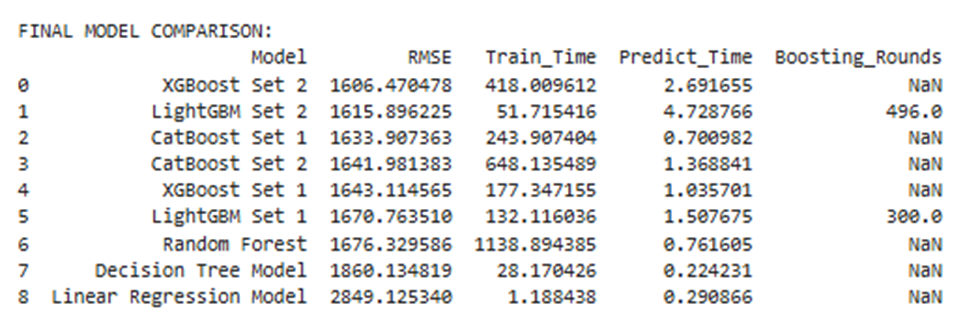

### Key Findings

**Best Overall Model: XGBoost Set 2**
- Achieved the lowest RMSE of **1,606.47 euros**, representing the most accurate predictions
- Demonstrated moderate training time (approximately **418 seconds**) and fast prediction speed (approximately **2.7 seconds**)
- Delivered superior accuracy without requiring manual boosting round tuning

**Model Performance Summary:**
1. **Top performers** (RMSE < 1,650): XGBoost Set 2 (1,606.47), LightGBM Set 2 (1,615.90), CatBoost Set 1 (1,633.91), and CatBoost Set 2 (1,641.98) all delivered excellent predictive accuracy
2. **LightGBM Set 2** offered the best balance of accuracy and training efficiency with only 9 euros higher RMSE (1,615.90) while training in just 52 seconds with 496 boosting rounds
3. **CatBoost Set 1** provided the fastest prediction time (0.7 seconds) with strong accuracy (1,633.91 RMSE), making it ideal for real-time applications
4. **Random Forest** achieved competitive accuracy (1,676.33 RMSE) but required significantly longer training time (1,139 seconds)
5. **Linear Regression** baseline achieved 2,849.13 RMSE, confirming that gradient boosting methods improved accuracy by approximately **44%**

### Trade-offs Analysis

**For Production Deployment:**
- **If prediction speed is critical**: CatBoost Set 1 delivers sub-second predictions (0.7s) with only 27 euros higher RMSE than the best model
- **If accuracy is paramount**: XGBoost Set 2 provides the best predictions with acceptable training and prediction times
- **If training efficiency matters**: LightGBM Set 2 offers near-identical accuracy (9 euro difference) while training 6x faster (52 vs 308 seconds)

### Technical Approach

The project successfully:
- Cleaned and preprocessed 320,000+ records with extensive missing value imputation using hierarchical grouping strategies
- Implemented proper categorical encoding (label encoding for LightGBM/CatBoost, one-hot encoding for XGBoost)
- Validated that gradient boosting methods significantly outperformed traditional algorithms
- Achieved prediction errors under 1,650 euros for the top four models

### Recommendation

For Rusty Bargain's mobile application, I recommend deploying XGBoost Set 2 as the primary model. With an RMSE of 1,606.47 euros, predictions are typically within this margin of actual prices—excellent accuracy for a used car valuation tool. The 2.7-second prediction time provides responsive user experience while the 418-second training time is acceptable for periodic model updates.

**Alternative option:** LightGBM Set 2 serves as a strong alternative if training efficiency becomes important (e.g., frequent model retraining). With only 9 euros higher error and 6x faster training, it offers nearly identical user-facing performance with significant operational advantages.

**Speed-optimized option:** If sub-second response times become critical during high-traffic periods, CatBoost Set 1 provides 0.7-second predictions with RMSE of 1,633.91—only 27 euros less accurate than the best model while being 4x faster.

The gradient boosting approaches demonstrated clear superiority over traditional methods, justifying their computational requirements for this business application where prediction accuracy directly impacts customer trust and satisfaction.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed